# A Cognitive Model or Harmonic Types (Simplified Amortization)

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Thesis/probabilistic_harmony_model

Mounted at /content/drive
/content/drive/MyDrive/Thesis/probabilistic_harmony_model


In [2]:
!pip install pyro-api==0.1.2
!pip install pyro-ppl==1.8.4
!pip install pitchtypes==0.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 kB 6.5 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

from pyro.distributions import *
#from collections import Counter
import pyro.infer
import pyro.optim
import pyro.util
pyro.enable_validation(True)

import matplotlib.pyplot as plt
import tqdm

import numpy as np
import pandas as pd
import scipy.stats as stats

import os.path as path
from datetime import datetime
import json

import utils

import gc

In [4]:
gpu = torch.cuda.is_available()

gpu_n = 0

torch.set_default_dtype(torch.float64)

#torch.autograd.set_detect_anomaly(True)

device = torch.device(f'cuda:{gpu_n}' if gpu else 'cpu')
print(device)

cpu


In [5]:
def save_rng_state(name):
    fn = name + '-' + datetime.today().isoformat() + '.state'
    state = pyro.util.get_rng_state()
    with open('rng-' + fn, 'w') as f:
        print(state, file=f)
    torch.save(state['torch'], 'torch-' + fn)

In [6]:
# set random seeds
pyro.set_rng_seed(0)
#torch.set_deterministic(True)
#torch.set_num_threads(1)
#torch.set_num_interop_threads(1)

# fix the range of pitches we consider
fifth_range = 2*7                  # 2 diatonics
npcs = 2*fifth_range+1             # around C: Cbb to C## on LoF
utils.set_fifth_range(fifth_range) # used to make helper functions work correctly

# **1. Amortization**



## Step 1: Model

**Notations:**
- $h$: probablity distribution of chords (harmony)
- $\Phi$: chord profile for all chord types, where each $\phi_i$ conntains weights for each chord
- $npcs$: range of line of fifths, which is the number of pitches we consider
- $n_{harmonies}$: number of different chord types
- $n_{chords}$: length of dataset (how many chords we observe in the dataset)

**Generating Process:**

For all $i$:

- $\phi_i \sim Dirichlet(0.5, npcs)$
- $h \sim Dirichlet(0.5, n_{harmonies})$

    For each chord j:
    - Choose chords: $c_i \sim Categorical(h)$
    - Choose pitches: $p_j \sim Multinomial(\phi_{cj}, N_j)$

where $p_j$ and $N_j$ are observed, other variables are unobserved.

In [45]:
def simplified_chord_model(npcs, nharmonies, data, subsamples=500, **kwargs):
    # parameters priors:
    # distribution of the harmonies
    p_harmony = pyro.sample('p_harmony', dist.Dirichlet(0.3 * torch.ones(nharmonies, device=device)))
    # distribution of notes in the harmonies (chord profiles)
    with pyro.plate('harmonies', nharmonies):
        chord_profiles = pyro.sample('chord_profiles', dist.Dirichlet(0.3 * torch.ones(npcs, device=device)))

    # Sampling the data:
    nchords = len(data['c'])
    subs = torch.arange(min(nchords, subsamples), device=device) if subsamples is not None else torch.arange(nchords, device=device)

    with pyro.plate('data', nchords, subsample=subs) as ind:
        # sample a chord type based on the harmony distribution (to be inferred)
        c = pyro.sample('c', dist.Categorical(p_harmony))

        # sampling pitches for the chord based on the selected chord type profile
        pitches = pyro.sample('pitches', dist.Multinomial(1, probs=chord_profiles[c], validate_args=False), obs=data['pitches'][ind])

    return {"p_harmony": p_harmony, "chord_profiles": chord_profiles, "c": c, "pitches": pitches}

## Step 2: Amortization Guide for Inference


In [46]:
# simpler
class AmortizationNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [47]:
# # with regulation
# class AmortizationNetwork(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super().__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, output_dim)
#         self.dropout = nn.Dropout(p=0.5)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x.float()))
#         x = self.dropout(x)
#         x = torch.softmax(self.fc2(x), dim=-1)
#         return x

In [48]:
# # more complex
# class AmortizationNetwork(nn.Module):
#     def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
#         super().__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim1)
#         self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
#         self.fc3 = nn.Linear(hidden_dim2, output_dim)
#         # self.dropout = nn.Dropout(p=0.5)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x.float()))
#         # x = self.dropout(x)
#         x = torch.softmax(self.fc3(x), dim=-1)
#         return x

In [49]:
def amortization_guide(npcs, nharmonies, data, subsamples=500, **kwargs):
    # for the distribution of the harmonies
    # initialize alpha parameters with more information, assuming some harmonies might be more probable
    alpha_h = pyro.param('alpha_h', (torch.ones(nharmonies, device=device) * 0.3), constraint=constraints.positive)
    pyro.sample('p_harmony', dist.Dirichlet(alpha_h))

    # for the chord profiles
    with pyro.plate('harmonies', nharmonies):
        alpha_phi = pyro.param('alpha_phi', (torch.ones([nharmonies, npcs], device=device) * 0.3), constraint=constraints.positive)
        pyro.sample('chord_profiles', dist.Dirichlet(alpha_phi))

    # for chord types
    net = AmortizationNetwork(input_dim=npcs, hidden_dim=128, output_dim=nharmonies)
    # net = AmortizationNetwork(input_dim=npcs, hidden_dim1=128, hidden_dim2=64, output_dim=nharmonies)
    net.to(device)
    pyro.module("net", net)

    nchords = len(data['c'])
    subs = torch.arange(min(nchords, subsamples), device=device) if subsamples is not None else torch.arange(nchords, device=device)

    with pyro.plate('data', nchords, subsample=subs) as ind:
        # Use NN to predict parameters for the chord types
        chord_features = data['pitches']
        chord_type_params = net(chord_features[ind])
        pyro.sample('c', dist.Categorical(probs=chord_type_params))

## Step 3: Data and Conditioning
**Data Format**


In [50]:
def simplified_chord_tensor(notes):
    """Takes a list of fifths and returns a vector of counts for fifths."""
    chord = torch.zeros(npcs, device=device)
    for fifth in notes:
        index = utils.fifth_to_index(fifth)
        chord[index] += 1
    return chord

def simplified_annot_data_obs(chords):
    """Helper function to turn a list of chord dictionaries into a dictionary of observation vectors."""
    obs = {}
    obs["pitches"] = torch.cat([simplified_chord_tensor(c['notes']).reshape((1, -1)) for c in chords], dim=0)
    obs["c"] = torch.tensor([c['label'] for c in chords], device=device)
    obs["n"] = torch.tensor([len(c['notes']) - 1 for c in chords], device=device)
    return obs

**Loading the Dataset**

The data is loaded from a TSV file that. The resulting dataframe is converted to the observation format that we pass to the model.

In [51]:
def load_dataset(filename):
    filename = path.join("data", filename)
    print("loading dataset...")
    df = utils.load_csv(filename)
    sizes = df.groupby(['chordid', 'label']).size()
    type_counts = sizes.groupby('label').size().sort_values(ascending=False)
    chordtypes = type_counts.index.tolist()
    df['numlabel'] = df.label.map(chordtypes.index)

    # check if precomputed tensor data is available:
    prefn = filename + " _precomp.pt"
    if path.exists(prefn) and path.getmtime(prefn) > path.getmtime(filename):
        print("using precomputed tensor data.")
        obs = torch.load(prefn, map_location=device)
    else:
        print('extracting chords...')
        chords = [{'label': numlabel, 'notes': [row['fifth'] for index, row in grp.iterrows()]}
                  for (_, numlabel), grp in tqdm.tqdm(df.groupby(['chordid', 'numlabel']))]
        print('converting chords to tensors...')
        obs = simplified_annot_data_obs(chords)
        torch.save(obs, prefn)

    print(len(chordtypes), "chord types")
    print(len(obs["c"]), "chords")
    return df, obs, chordtypes

In [52]:
def get_init_params(df, nharms, npcs):
    init = dict()

    # initialize params for harmonies
    init['harmonies'] = torch.tensor(df.groupby('numlabel').size().sort_values(ascending=False), device=device) + 0.5

    # initialize params for chord profiles
    init['chord_profiles'] = torch.zeros([nharms, npcs], device=device) + 0.5
    for (numlabel, fifth), grp in df.groupby(['numlabel', 'fifth']):
        init['chord_profiles'][numlabel, utils.fifth_to_index(fifth)] += grp.fifth.count()

    chord_sizes = df.groupby('chordid').size()
    init['sum_chords'] = torch.tensor(sum(chord_sizes), device=device)
    init['n_chords'] = torch.tensor(len(chord_sizes), device=device)
    return init

After inferring the parameters we save them for easier inspection and reuse.



In [53]:
def save_params(params, nharmonies, npcs, name):
    # Save the PyTorch parameters
    torch.save(params , path.join("results", name + '.pt'))

    # Save the parameters in a JSON file for easy access
    with open(path.join("results", name + '.json'), 'w') as f:
        json.dump({'params': {key: val.tolist() for key, val in params.items()},
                   'nharmonies': nharmonies,
                   'npcs': npcs},
                  f)

## Step 4: Inference

In [54]:
def infer_amortized_posteriors(npcs, nharmonies, data, nsteps=5000, lr=0.01, step_size=100, clip_grad=0.1, plot_loss=True, save_as=None, collect_history=False):
    pyro.clear_param_store()
    pyro.set_rng_seed(1625)

    svi = pyro.infer.SVI(model=simplified_chord_model,
                         guide=lambda npcs, nharmonies, data: amortization_guide(npcs, nharmonies, data),
                         optim=pyro.optim.Adam({"lr": lr, "betas": (0.95, 0.999)}),
                         loss=pyro.infer.Trace_ELBO())

    losses = []
    alpha_h_history = []
    alpha_phi_history = []

    for step in tqdm.trange(nsteps):
        loss = svi.step(npcs, nharmonies, data)

        # check for NaNs and infs in gradients
        for name, param in pyro.get_param_store().items():
            if param.grad is not None:
                if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                    raise ValueError(f'Gradient for {name} has NaN/inf values.')

        # apply gradient clipping
        for p in pyro.get_param_store().values():
            p.register_hook(lambda grad: torch.clamp(grad, -clip_grad, clip_grad))

        losses.append(loss)

        if collect_history:
            # collect parameter histories
            alpha_h_history.append(pyro.param('alpha_h').detach().cpu().numpy())
            alpha_phi_history.append(pyro.param('alpha_phi').detach().cpu().numpy())

        if step % 100 == 0:
            print(f"Step {step} : loss = {loss}")

    # plot the loss
    if plot_loss:
        plt.figure(figsize=(12, 5))
        plt.plot(losses)
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.title(f"SVI Convergence ({save_as})")
        plt.show()

    # save inferred parameters
    params = {name: value.detach().cpu().numpy() for name, value in pyro.get_param_store().items()}

    if save_as is not None:
        save_params(params, nharmonies, npcs, save_as)

    return params, (alpha_h_history, alpha_phi_history) if collect_history else params

## Step 5: Plotting

In [55]:
def plot_param_histories(alpha_h_history, alpha_phi_history):
    # Plot alpha_h history
    plt.figure(figsize=(12, 5))
    plt.plot(alpha_h_history)
    plt.title('Alpha_h parameter history')
    plt.xlabel('Iteration')
    plt.ylabel('Alpha_h values')
    plt.show()

    # Plot alpha_phi history (for simplicity, here we just plot the mean over the pitch classes)
    alpha_phi_mean_history = np.mean(alpha_phi_history, axis=-1)  # Compute the mean over pitch classes
    plt.figure(figsize=(12, 5))
    plt.plot(alpha_phi_mean_history)
    plt.title('Mean Alpha_phi parameter history')
    plt.xlabel('Iteration')
    plt.ylabel('Mean Alpha_phi values')
    plt.show()

In [56]:
def plot_amortized_inference_results(params, nharmonies, npcs, save_as=None):
    # Extract harmony and chord profile parameters
    harmony_params = params['alpha_h']
    chord_profile_params = params['alpha_phi']

    # Normalize the parameters
    harmony_normalized = harmony_params / np.sum(harmony_params)
    chord_profile_normalized = np.array([cp / np.sum(cp) for cp in chord_profile_params])

    num_subplots = nharmonies + 1

    fig, axs = plt.subplots(num_subplots, 1, figsize=(12, 3 * num_subplots))

    # Plot harmony distribution
    axs[0].bar(np.arange(len(harmony_normalized)), harmony_normalized)
    axs[0].set_title('Harmony Distribution')
    axs[0].set_xlabel('Harmony Types')
    axs[0].set_ylabel('Probability')

    # Plot chord profile parameters for each harmony
    for i in range(nharmonies):
        axs[i + 1].bar(np.arange(npcs), chord_profile_normalized[i])
        axs[i + 1].set_title(f'Chord Profile for Harmony {i}')
        axs[i + 1].set_xlabel('Pitches')
        axs[i + 1].set_ylabel('Probability')

    plt.tight_layout()
    if save_as:
        plt.savefig(f"{save_as}.png")
    plt.show()

# **2. Experiment**

In [57]:
dcml_df, dcml_obs, dcml_chordtypes = load_dataset('dcml.tsv')
dcml_init = get_init_params(dcml_df, len(dcml_chordtypes), npcs)

loading dataset...
using precomputed tensor data.
14 chord types
113771 chords


  0%|          | 0/500000 [00:00<?, ?it/s]<ipython-input-54-390aaa289ab3>:19: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  if param.grad is not None:
  0%|          | 3/500000 [00:00<9:12:39, 15.08it/s] 

Step 0 : loss = 5429122.260417427


  0%|          | 109/500000 [00:01<2:03:57, 67.21it/s]

Step 100 : loss = 1982582.2453300008


  0%|          | 215/500000 [00:03<1:57:00, 71.19it/s]

Step 200 : loss = 1893551.2257858769


  0%|          | 310/500000 [00:04<1:54:42, 72.60it/s]

Step 300 : loss = 1876058.494252603


  0%|          | 413/500000 [00:06<1:59:45, 69.53it/s]

Step 400 : loss = 1842958.807919254


  0%|          | 508/500000 [00:07<1:59:00, 69.96it/s]

Step 500 : loss = 1838548.998895459


  0%|          | 612/500000 [00:08<1:58:02, 70.51it/s]

Step 600 : loss = 1816769.9237263382


  0%|          | 708/500000 [00:10<1:57:34, 70.78it/s]

Step 700 : loss = 1810619.2122208057


  0%|          | 807/500000 [00:12<2:50:47, 48.72it/s]

Step 800 : loss = 1815473.802227028


  0%|          | 914/500000 [00:14<2:01:44, 68.32it/s]

Step 900 : loss = 1811539.6783449827


  0%|          | 1015/500000 [00:15<1:56:37, 71.31it/s]

Step 1000 : loss = 1808932.2956219888


  0%|          | 1111/500000 [00:16<1:53:51, 73.02it/s]

Step 1100 : loss = 1815963.1380515099


  0%|          | 1215/500000 [00:18<1:55:24, 72.03it/s]

Step 1200 : loss = 1813402.6672479112


  0%|          | 1315/500000 [00:19<1:58:01, 70.42it/s]

Step 1300 : loss = 1805891.286623051


  0%|          | 1411/500000 [00:21<1:50:18, 75.33it/s]

Step 1400 : loss = 1795264.4027591536


  0%|          | 1507/500000 [00:22<1:55:42, 71.80it/s]

Step 1500 : loss = 1822502.9121505963


  0%|          | 1607/500000 [00:23<2:27:29, 56.32it/s]

Step 1600 : loss = 1799438.0845088137


  0%|          | 1710/500000 [00:26<2:43:20, 50.85it/s]

Step 1700 : loss = 1803844.9638654257


  0%|          | 1812/500000 [00:27<1:58:57, 69.80it/s]

Step 1800 : loss = 1791234.8364783258


  0%|          | 1914/500000 [00:29<1:55:11, 72.07it/s]

Step 1900 : loss = 1811694.5057709606


  0%|          | 2009/500000 [00:30<1:58:08, 70.26it/s]

Step 2000 : loss = 1801268.4122459805


  0%|          | 2113/500000 [00:31<1:53:13, 73.29it/s]

Step 2100 : loss = 1795661.3018180171


  0%|          | 2209/500000 [00:33<1:51:17, 74.55it/s]

Step 2200 : loss = 1800343.049883733


  0%|          | 2313/500000 [00:34<1:56:48, 71.01it/s]

Step 2300 : loss = 1805628.0309475898


  0%|          | 2409/500000 [00:36<1:56:39, 71.09it/s]

Step 2400 : loss = 1790630.6562452787


  1%|          | 2510/500000 [00:37<2:42:38, 50.98it/s]

Step 2500 : loss = 1790449.6892115755


  1%|          | 2607/500000 [00:39<2:55:16, 47.30it/s]

Step 2600 : loss = 1787947.517241631


  1%|          | 2710/500000 [00:41<1:53:40, 72.91it/s]

Step 2700 : loss = 1809766.8705422333


  1%|          | 2814/500000 [00:42<1:55:00, 72.05it/s]

Step 2800 : loss = 1803601.586220088


  1%|          | 2914/500000 [00:44<2:00:59, 68.47it/s]

Step 2900 : loss = 1793713.9239881453


  1%|          | 3008/500000 [00:45<1:57:58, 70.21it/s]

Step 3000 : loss = 1803928.39056678


  1%|          | 3112/500000 [00:46<1:51:39, 74.17it/s]

Step 3100 : loss = 1794009.1174856476


  1%|          | 3208/500000 [00:48<1:55:15, 71.83it/s]

Step 3200 : loss = 1806649.1462137746


  1%|          | 3312/500000 [00:49<1:56:42, 70.93it/s]

Step 3300 : loss = 1808426.2842267153


  1%|          | 3406/500000 [00:51<2:41:41, 51.19it/s]

Step 3400 : loss = 1809823.584331334


  1%|          | 3512/500000 [00:53<2:06:42, 65.30it/s]

Step 3500 : loss = 1800371.3885952497


  1%|          | 3614/500000 [00:54<1:57:26, 70.45it/s]

Step 3600 : loss = 1805649.678533141


  1%|          | 3710/500000 [00:56<1:53:09, 73.09it/s]

Step 3700 : loss = 1814098.40229769


  1%|          | 3813/500000 [00:57<1:54:54, 71.97it/s]

Step 3800 : loss = 1811206.960423482


  1%|          | 3909/500000 [00:58<1:53:56, 72.57it/s]

Step 3900 : loss = 1807073.2668904825


  1%|          | 4013/500000 [01:00<1:58:54, 69.52it/s]

Step 4000 : loss = 1791768.943133553


  1%|          | 4116/500000 [01:01<1:50:05, 75.07it/s]

Step 4100 : loss = 1795067.318565038


  1%|          | 4204/500000 [01:03<2:15:29, 60.99it/s]

Step 4200 : loss = 1796459.0295326156


  1%|          | 4307/500000 [01:05<2:35:29, 53.13it/s]

Step 4300 : loss = 1786958.5469689525


  1%|          | 4411/500000 [01:06<1:54:58, 71.84it/s]

Step 4400 : loss = 1794909.9246885884


  1%|          | 4507/500000 [01:08<1:54:59, 71.81it/s]

Step 4500 : loss = 1800306.2723694255


  1%|          | 4611/500000 [01:09<1:51:34, 74.00it/s]

Step 4600 : loss = 1804227.9968889086


  1%|          | 4715/500000 [01:11<1:53:44, 72.57it/s]

Step 4700 : loss = 1814327.2749197804


  1%|          | 4811/500000 [01:12<1:58:33, 69.62it/s]

Step 4800 : loss = 1795509.6237485895


  1%|          | 4914/500000 [01:13<1:54:45, 71.90it/s]

Step 4900 : loss = 1788428.9196073818


  1%|          | 5010/500000 [01:15<1:53:18, 72.80it/s]

Step 5000 : loss = 1797915.736682553


  1%|          | 5107/500000 [01:16<2:31:48, 54.33it/s]

Step 5100 : loss = 1798975.6482977103


  1%|          | 5209/500000 [01:18<2:44:57, 49.99it/s]

Step 5200 : loss = 1800163.105851512


  1%|          | 5310/500000 [01:20<1:59:35, 68.95it/s]

Step 5300 : loss = 1795486.7161888487


  1%|          | 5408/500000 [01:21<1:59:14, 69.13it/s]

Step 5400 : loss = 1814238.244217503


  1%|          | 5514/500000 [01:23<1:56:46, 70.57it/s]

Step 5500 : loss = 1803626.4238987295


  1%|          | 5607/500000 [01:24<1:57:24, 70.18it/s]

Step 5600 : loss = 1795977.6321910748


  1%|          | 5711/500000 [01:26<1:55:53, 71.08it/s]

Step 5700 : loss = 1807490.8648080686


  1%|          | 5815/500000 [01:27<1:53:32, 72.54it/s]

Step 5800 : loss = 1810213.53962229


  1%|          | 5911/500000 [01:28<1:53:12, 72.74it/s]

Step 5900 : loss = 1785590.1704395781


  1%|          | 6008/500000 [01:30<2:52:03, 47.85it/s]

Step 6000 : loss = 1795628.812397291


  1%|          | 6115/500000 [01:32<2:11:41, 62.50it/s]

Step 6100 : loss = 1808789.3275587047


  1%|          | 6214/500000 [01:34<2:01:36, 67.68it/s]

Step 6200 : loss = 1801505.2077803789


  1%|▏         | 6316/500000 [01:35<1:53:45, 72.33it/s]

Step 6300 : loss = 1792913.2377125095


  1%|▏         | 6412/500000 [01:37<1:52:57, 72.83it/s]

Step 6400 : loss = 1786246.386632184


  1%|▏         | 6509/500000 [01:38<1:49:56, 74.82it/s]

Step 6500 : loss = 1805192.5313413762


  1%|▏         | 6613/500000 [01:39<1:52:16, 73.24it/s]

Step 6600 : loss = 1798087.842715825


  1%|▏         | 6709/500000 [01:41<1:53:14, 72.60it/s]

Step 6700 : loss = 1786065.975903991


  1%|▏         | 6813/500000 [01:42<2:04:47, 65.87it/s]

Step 6800 : loss = 1797541.0326872887


  1%|▏         | 6907/500000 [01:44<2:50:41, 48.14it/s]

Step 6900 : loss = 1797810.718130678


  1%|▏         | 7011/500000 [01:46<2:00:01, 68.46it/s]

Step 7000 : loss = 1792227.0945238117


  1%|▏         | 7115/500000 [01:47<1:57:47, 69.74it/s]

Step 7100 : loss = 1798562.0679242322


  1%|▏         | 7211/500000 [01:49<1:53:59, 72.05it/s]

Step 7200 : loss = 1804587.9766858027


  1%|▏         | 7307/500000 [01:50<1:51:58, 73.33it/s]

Step 7300 : loss = 1782695.3703269078


  1%|▏         | 7411/500000 [01:51<1:54:35, 71.65it/s]

Step 7400 : loss = 1785025.509319636


  2%|▏         | 7515/500000 [01:53<1:51:44, 73.46it/s]

Step 7500 : loss = 1796955.9607510776


  2%|▏         | 7611/500000 [01:54<1:51:24, 73.67it/s]

Step 7600 : loss = 1793680.4297850584


  2%|▏         | 7708/500000 [01:56<2:35:52, 52.64it/s]

Step 7700 : loss = 1786712.5586607482


  2%|▏         | 7807/500000 [01:58<2:56:05, 46.58it/s]

Step 7800 : loss = 1799000.5986723262


  2%|▏         | 7909/500000 [02:00<1:57:58, 69.52it/s]

Step 7900 : loss = 1798722.5705139139


  2%|▏         | 8012/500000 [02:01<1:55:01, 71.29it/s]

Step 8000 : loss = 1807328.054109481


  2%|▏         | 8108/500000 [02:02<1:49:54, 74.59it/s]

Step 8100 : loss = 1791909.1100580026


  2%|▏         | 8212/500000 [02:04<1:55:05, 71.21it/s]

Step 8200 : loss = 1804424.938748935


  2%|▏         | 8314/500000 [02:05<1:52:25, 72.89it/s]

Step 8300 : loss = 1796183.4793911246


  2%|▏         | 8410/500000 [02:06<1:52:35, 72.77it/s]

Step 8400 : loss = 1793977.8240193778


  2%|▏         | 8514/500000 [02:08<1:52:27, 72.84it/s]

Step 8500 : loss = 1794338.0975336824


  2%|▏         | 8609/500000 [02:10<2:48:02, 48.74it/s]

Step 8600 : loss = 1792112.5255738012


  2%|▏         | 8709/500000 [02:12<2:35:19, 52.72it/s]

Step 8700 : loss = 1784431.89225261


  2%|▏         | 8812/500000 [02:13<1:54:09, 71.71it/s]

Step 8800 : loss = 1798280.2669521414


  2%|▏         | 8908/500000 [02:14<1:52:37, 72.67it/s]

Step 8900 : loss = 1796009.7929257206


  2%|▏         | 9012/500000 [02:16<1:52:30, 72.74it/s]

Step 9000 : loss = 1788272.9222788624


  2%|▏         | 9108/500000 [02:17<1:54:31, 71.44it/s]

Step 9100 : loss = 1793785.1995391112


  2%|▏         | 9212/500000 [02:19<1:54:20, 71.54it/s]

Step 9200 : loss = 1797508.189728234


  2%|▏         | 9316/500000 [02:20<1:52:10, 72.91it/s]

Step 9300 : loss = 1783201.391131841


  2%|▏         | 9412/500000 [02:21<1:53:45, 71.87it/s]

Step 9400 : loss = 1789852.0513197475


  2%|▏         | 9510/500000 [02:23<2:38:19, 51.63it/s]

Step 9500 : loss = 1786921.522682636


  2%|▏         | 9615/500000 [02:25<2:09:23, 63.16it/s]

Step 9600 : loss = 1808291.474987778


  2%|▏         | 9711/500000 [02:26<1:53:05, 72.26it/s]

Step 9700 : loss = 1800357.011904033


  2%|▏         | 9815/500000 [02:28<1:51:24, 73.34it/s]

Step 9800 : loss = 1788075.6552817598


  2%|▏         | 9911/500000 [02:29<1:49:14, 74.77it/s]

Step 9900 : loss = 1787000.678610614


  2%|▏         | 10007/500000 [02:30<1:53:22, 72.03it/s]

Step 10000 : loss = 1800275.864335563


  2%|▏         | 10111/500000 [02:32<1:53:37, 71.86it/s]

Step 10100 : loss = 1793137.560706465


  2%|▏         | 10215/500000 [02:33<1:49:28, 74.56it/s]

Step 10200 : loss = 1792988.0896697878


  2%|▏         | 10311/500000 [02:35<1:58:28, 68.89it/s]

Step 10300 : loss = 1798521.4758725944


  2%|▏         | 10412/500000 [02:37<2:37:52, 51.69it/s]

Step 10400 : loss = 1796448.3353072484


  2%|▏         | 10515/500000 [02:38<1:57:57, 69.16it/s]

Step 10500 : loss = 1793489.338470302


  2%|▏         | 10611/500000 [02:40<1:54:23, 71.30it/s]

Step 10600 : loss = 1807019.604914073


  2%|▏         | 10714/500000 [02:41<1:53:22, 71.93it/s]

Step 10700 : loss = 1806060.6320355888


  2%|▏         | 10810/500000 [02:42<1:52:33, 72.44it/s]

Step 10800 : loss = 1809842.4021867192


  2%|▏         | 10914/500000 [02:44<1:51:43, 72.96it/s]

Step 10900 : loss = 1798363.3077152893


  2%|▏         | 11010/500000 [02:45<1:49:14, 74.60it/s]

Step 11000 : loss = 1797686.9849964269


  2%|▏         | 11114/500000 [02:47<1:51:45, 72.91it/s]

Step 11100 : loss = 1793943.575677695


  2%|▏         | 11210/500000 [02:48<1:53:22, 71.86it/s]

Step 11200 : loss = 1805325.5425636661


  2%|▏         | 11309/500000 [02:50<2:32:53, 53.27it/s]

Step 11300 : loss = 1789225.888001908


  2%|▏         | 11404/500000 [02:51<2:01:38, 66.94it/s]

Step 11400 : loss = 1812902.8019192305


  2%|▏         | 11514/500000 [02:53<1:50:35, 73.61it/s]

Step 11500 : loss = 1805433.9763064075


  2%|▏         | 11609/500000 [02:55<2:16:50, 59.48it/s]

Step 11600 : loss = 1791023.9828681077


  2%|▏         | 11715/500000 [02:57<1:55:05, 70.71it/s]

Step 11700 : loss = 1799466.8136592612


  2%|▏         | 11813/500000 [02:58<1:47:11, 75.91it/s]

Step 11800 : loss = 1789783.5098487693


  2%|▏         | 11910/500000 [03:00<1:50:01, 73.93it/s]

Step 11900 : loss = 1794760.0094535078


  2%|▏         | 12008/500000 [03:01<1:50:37, 73.52it/s]

Step 12000 : loss = 1780423.2723915563


  2%|▏         | 12107/500000 [03:03<2:47:06, 48.66it/s]

Step 12100 : loss = 1795643.3763186433


  2%|▏         | 12213/500000 [03:05<2:08:10, 63.43it/s]

Step 12200 : loss = 1798054.7774828018


  2%|▏         | 12315/500000 [03:06<1:52:15, 72.41it/s]

Step 12300 : loss = 1780488.1543583688


  2%|▏         | 12411/500000 [03:07<1:48:19, 75.01it/s]

Step 12400 : loss = 1784579.8673031915


  3%|▎         | 12515/500000 [03:09<1:51:56, 72.58it/s]

Step 12500 : loss = 1822911.901135806


  3%|▎         | 12611/500000 [03:10<1:55:52, 70.10it/s]

Step 12600 : loss = 1791094.4330370957


  3%|▎         | 12710/500000 [03:11<1:44:23, 77.80it/s]

Step 12700 : loss = 1799265.5610772064


  3%|▎         | 12814/500000 [03:13<1:46:14, 76.43it/s]

Step 12800 : loss = 1797198.0348471769


  3%|▎         | 12911/500000 [03:14<1:51:23, 72.88it/s]

Step 12900 : loss = 1802205.0118095384


  3%|▎         | 13007/500000 [03:16<2:38:24, 51.24it/s]

Step 13000 : loss = 1802557.7692781608


  3%|▎         | 13115/500000 [03:18<2:00:26, 67.38it/s]

Step 13100 : loss = 1788895.9873748485


  3%|▎         | 13211/500000 [03:19<1:54:37, 70.78it/s]

Step 13200 : loss = 1788512.9609112414


  3%|▎         | 13315/500000 [03:21<1:50:52, 73.16it/s]

Step 13300 : loss = 1803937.8140030804


  3%|▎         | 13411/500000 [03:22<1:50:08, 73.63it/s]

Step 13400 : loss = 1801573.258385468


  3%|▎         | 13516/500000 [03:23<1:48:39, 74.62it/s]

Step 13500 : loss = 1796430.560061331


  3%|▎         | 13612/500000 [03:25<1:51:13, 72.89it/s]

Step 13600 : loss = 1803952.3443491189


  3%|▎         | 13709/500000 [03:26<1:48:40, 74.58it/s]

Step 13700 : loss = 1794584.3015717026


  3%|▎         | 13813/500000 [03:27<1:53:23, 71.46it/s]

Step 13800 : loss = 1798424.8384110327


  3%|▎         | 13912/500000 [03:29<2:31:35, 53.44it/s]

Step 13900 : loss = 1808592.916528559


  3%|▎         | 14009/500000 [03:31<1:57:51, 68.72it/s]

Step 14000 : loss = 1784267.1580223


  3%|▎         | 14115/500000 [03:33<1:56:22, 69.59it/s]

Step 14100 : loss = 1796710.0444680778


  3%|▎         | 14211/500000 [03:34<1:48:53, 74.35it/s]

Step 14200 : loss = 1804499.8423454408


  3%|▎         | 14315/500000 [03:35<1:49:21, 74.03it/s]

Step 14300 : loss = 1806909.7443540804


  3%|▎         | 14411/500000 [03:37<1:51:56, 72.30it/s]

Step 14400 : loss = 1803685.1909918184


  3%|▎         | 14514/500000 [03:38<1:53:31, 71.27it/s]

Step 14500 : loss = 1797323.1997593832


  3%|▎         | 14610/500000 [03:39<1:51:02, 72.85it/s]

Step 14600 : loss = 1799430.422202656


  3%|▎         | 14705/500000 [03:41<2:12:29, 61.05it/s]

Step 14700 : loss = 1807610.6749704732


  3%|▎         | 14807/500000 [03:43<2:35:31, 52.00it/s]

Step 14800 : loss = 1799378.507511973


  3%|▎         | 14906/500000 [03:45<2:24:32, 55.93it/s]

Step 14900 : loss = 1800530.7703860127


  3%|▎         | 15012/500000 [03:46<1:56:56, 69.12it/s]

Step 15000 : loss = 1800122.9989353013


  3%|▎         | 15115/500000 [03:48<1:51:24, 72.54it/s]

Step 15100 : loss = 1789535.0501626928


  3%|▎         | 15215/500000 [03:49<1:50:43, 72.97it/s]

Step 15200 : loss = 1796822.3643632291


  3%|▎         | 15311/500000 [03:51<1:52:56, 71.52it/s]

Step 15300 : loss = 1795335.2879810827


  3%|▎         | 15415/500000 [03:52<1:48:20, 74.55it/s]

Step 15400 : loss = 1798961.1460284297


  3%|▎         | 15511/500000 [03:53<1:49:04, 74.03it/s]

Step 15500 : loss = 1802714.1383768665


  3%|▎         | 15607/500000 [03:55<2:37:12, 51.35it/s]

Step 15600 : loss = 1793365.6240518223


  3%|▎         | 15707/500000 [03:57<2:39:09, 50.71it/s]

Step 15700 : loss = 1810718.49946571


  3%|▎         | 15811/500000 [03:58<1:54:15, 70.62it/s]

Step 15800 : loss = 1797303.2367045386


  3%|▎         | 15915/500000 [04:00<1:53:07, 71.31it/s]

Step 15900 : loss = 1798759.0918936331


  3%|▎         | 16011/500000 [04:01<1:49:52, 73.41it/s]

Step 16000 : loss = 1784168.992083252


  3%|▎         | 16114/500000 [04:03<1:48:53, 74.06it/s]

Step 16100 : loss = 1799500.0136233887


  3%|▎         | 16211/500000 [04:04<1:48:20, 74.43it/s]

Step 16200 : loss = 1810280.020908433


  3%|▎         | 16315/500000 [04:05<1:47:23, 75.07it/s]

Step 16300 : loss = 1805334.9473388046


  3%|▎         | 16411/500000 [04:07<1:50:15, 73.10it/s]

Step 16400 : loss = 1798066.6255820738


  3%|▎         | 16505/500000 [04:08<2:27:06, 54.78it/s]

Step 16500 : loss = 1797224.238643264


  3%|▎         | 16609/500000 [04:10<2:33:32, 52.47it/s]

Step 16600 : loss = 1800369.9704646869


  3%|▎         | 16711/500000 [04:12<2:00:24, 66.90it/s]

Step 16700 : loss = 1798219.5794779616


  3%|▎         | 16813/500000 [04:13<1:54:05, 70.58it/s]

Step 16800 : loss = 1786678.7587975874


  3%|▎         | 16909/500000 [04:14<1:50:12, 73.06it/s]

Step 16900 : loss = 1800991.8735670345


  3%|▎         | 17013/500000 [04:16<1:51:02, 72.50it/s]

Step 17000 : loss = 1789840.3871169365


  3%|▎         | 17109/500000 [04:17<1:50:05, 73.11it/s]

Step 17100 : loss = 1794048.0795672317


  3%|▎         | 17213/500000 [04:19<1:51:54, 71.90it/s]

Step 17200 : loss = 1794047.5543445484


  3%|▎         | 17316/500000 [04:20<1:51:36, 72.08it/s]

Step 17300 : loss = 1787879.6433484177


  3%|▎         | 17410/500000 [04:22<2:37:50, 50.96it/s]

Step 17400 : loss = 1797173.1937956251


  4%|▎         | 17509/500000 [04:24<2:07:41, 62.98it/s]

Step 17500 : loss = 1797991.2129762277


  4%|▎         | 17612/500000 [04:25<1:50:40, 72.65it/s]

Step 17600 : loss = 1806324.2174136275


  4%|▎         | 17708/500000 [04:27<1:54:20, 70.30it/s]

Step 17700 : loss = 1809226.9819102208


  4%|▎         | 17812/500000 [04:28<1:51:32, 72.05it/s]

Step 17800 : loss = 1802640.1438627993


  4%|▎         | 17916/500000 [04:29<1:46:24, 75.51it/s]

Step 17900 : loss = 1801714.4564935225


  4%|▎         | 18012/500000 [04:31<1:54:09, 70.37it/s]

Step 18000 : loss = 1796009.6916882035


  4%|▎         | 18116/500000 [04:32<1:50:57, 72.39it/s]

Step 18100 : loss = 1802111.5467493543


  4%|▎         | 18204/500000 [04:33<2:06:20, 63.56it/s]

Step 18200 : loss = 1809729.3729163492


  4%|▎         | 18306/500000 [04:35<2:31:06, 53.13it/s]

Step 18300 : loss = 1795574.3554988578


  4%|▎         | 18414/500000 [04:37<1:51:40, 71.87it/s]

Step 18400 : loss = 1803298.924045451


  4%|▎         | 18510/500000 [04:39<1:51:26, 72.01it/s]

Step 18500 : loss = 1804263.579037082


  4%|▎         | 18614/500000 [04:40<1:53:28, 70.71it/s]

Step 18600 : loss = 1811764.0183678376


  4%|▎         | 18710/500000 [04:41<1:45:45, 75.85it/s]

Step 18700 : loss = 1793921.023162704


  4%|▍         | 18814/500000 [04:43<1:51:53, 71.67it/s]

Step 18800 : loss = 1810090.40403939


  4%|▍         | 18910/500000 [04:44<1:55:50, 69.21it/s]

Step 18900 : loss = 1807726.9334585983


  4%|▍         | 19015/500000 [04:46<1:50:43, 72.40it/s]

Step 19000 : loss = 1811786.5272259263


  4%|▍         | 19106/500000 [04:47<2:21:43, 56.55it/s]

Step 19100 : loss = 1793188.7811096425


  4%|▍         | 19208/500000 [04:49<2:32:33, 52.52it/s]

Step 19200 : loss = 1787176.6377252378


  4%|▍         | 19310/500000 [04:51<1:53:07, 70.82it/s]

Step 19300 : loss = 1803617.5296735778


  4%|▍         | 19414/500000 [04:52<1:51:07, 72.07it/s]

Step 19400 : loss = 1815485.6093012963


  4%|▍         | 19510/500000 [04:54<1:55:28, 69.35it/s]

Step 19500 : loss = 1800288.8539874742


  4%|▍         | 19611/500000 [04:55<1:51:55, 71.53it/s]

Step 19600 : loss = 1807112.1645601364


  4%|▍         | 19709/500000 [04:56<2:00:16, 66.55it/s]

Step 19700 : loss = 1800075.6177120556


  4%|▍         | 19811/500000 [04:58<1:51:44, 71.63it/s]

Step 19800 : loss = 1789548.9373412991


  4%|▍         | 19915/500000 [04:59<1:46:13, 75.33it/s]

Step 19900 : loss = 1794603.0610887054


  4%|▍         | 20011/500000 [05:01<2:27:28, 54.25it/s]

Step 20000 : loss = 1804025.0376170003


  4%|▍         | 20111/500000 [05:03<2:39:33, 50.13it/s]

Step 20100 : loss = 1795644.561909696


  4%|▍         | 20212/500000 [05:04<1:49:04, 73.31it/s]

Step 20200 : loss = 1804108.806661083


  4%|▍         | 20308/500000 [05:06<1:48:54, 73.40it/s]

Step 20300 : loss = 1801464.3230500426


  4%|▍         | 20412/500000 [05:07<1:50:45, 72.17it/s]

Step 20400 : loss = 1800158.7892375686


  4%|▍         | 20515/500000 [05:09<1:53:38, 70.32it/s]

Step 20500 : loss = 1807164.8216308285


  4%|▍         | 20610/500000 [05:10<1:52:00, 71.33it/s]

Step 20600 : loss = 1799925.2175692255


  4%|▍         | 20715/500000 [05:11<1:49:16, 73.10it/s]

Step 20700 : loss = 1800807.0127422982


  4%|▍         | 20811/500000 [05:13<1:49:18, 73.06it/s]

Step 20800 : loss = 1789836.0145970327


  4%|▍         | 20907/500000 [05:14<2:32:31, 52.35it/s]

Step 20900 : loss = 1801663.713590148


  4%|▍         | 21007/500000 [05:16<2:47:17, 47.72it/s]

Step 21000 : loss = 1796495.135316934


  4%|▍         | 21114/500000 [05:18<1:55:03, 69.37it/s]

Step 21100 : loss = 1804080.8589386942


  4%|▍         | 21213/500000 [05:19<1:49:37, 72.79it/s]

Step 21200 : loss = 1808383.7794860373


  4%|▍         | 21309/500000 [05:21<1:48:00, 73.87it/s]

Step 21300 : loss = 1796311.2398336586


  4%|▍         | 21414/500000 [05:22<1:48:10, 73.74it/s]

Step 21400 : loss = 1807568.0834709478


  4%|▍         | 21510/500000 [05:23<1:47:08, 74.43it/s]

Step 21500 : loss = 1794975.083612026


  4%|▍         | 21614/500000 [05:25<1:49:15, 72.98it/s]

Step 21600 : loss = 1802576.8682786128


  4%|▍         | 21710/500000 [05:26<1:46:05, 75.14it/s]

Step 21700 : loss = 1806056.2567072148


  4%|▍         | 21809/500000 [05:28<2:47:06, 47.69it/s]

Step 21800 : loss = 1807329.83261254


  4%|▍         | 21909/500000 [05:30<2:10:51, 60.89it/s]

Step 21900 : loss = 1792211.4625836143


  4%|▍         | 22010/500000 [05:31<1:52:41, 70.69it/s]

Step 22000 : loss = 1800586.3193859893


  4%|▍         | 22112/500000 [05:33<1:53:05, 70.43it/s]

Step 22100 : loss = 1801318.0698328025


  4%|▍         | 22208/500000 [05:34<1:52:47, 70.60it/s]

Step 22200 : loss = 1792347.3397756862


  4%|▍         | 22312/500000 [05:35<1:43:16, 77.09it/s]

Step 22300 : loss = 1811940.6852982526


  4%|▍         | 22416/500000 [05:37<1:45:14, 75.64it/s]

Step 22400 : loss = 1799622.1664812642


  5%|▍         | 22512/500000 [05:38<1:52:42, 70.61it/s]

Step 22500 : loss = 1806000.8302777093


  5%|▍         | 22616/500000 [05:39<1:48:33, 73.29it/s]

Step 22600 : loss = 1787585.0877593833


  5%|▍         | 22710/500000 [05:41<2:38:17, 50.26it/s]

Step 22700 : loss = 1794869.704197303


  5%|▍         | 22811/500000 [05:43<1:59:37, 66.48it/s]

Step 22800 : loss = 1794483.1597999553


  5%|▍         | 22914/500000 [05:45<1:51:50, 71.09it/s]

Step 22900 : loss = 1795490.9061514928


  5%|▍         | 23010/500000 [05:46<1:46:54, 74.36it/s]

Step 23000 : loss = 1803584.2525832292


  5%|▍         | 23111/500000 [05:47<1:47:31, 73.92it/s]

Step 23100 : loss = 1801989.2152986312


  5%|▍         | 23215/500000 [05:49<1:52:19, 70.75it/s]

Step 23200 : loss = 1798630.781124389


  5%|▍         | 23312/500000 [05:50<1:59:24, 66.54it/s]

Step 23300 : loss = 1801638.4440381736


  5%|▍         | 23412/500000 [05:52<1:55:08, 68.98it/s]

Step 23400 : loss = 1801067.5447103023


  5%|▍         | 23507/500000 [05:53<2:30:29, 52.77it/s]

Step 23500 : loss = 1796878.5748801113


  5%|▍         | 23609/500000 [05:55<2:20:45, 56.41it/s]

Step 23600 : loss = 1803885.633184032


  5%|▍         | 23715/500000 [05:57<1:49:21, 72.58it/s]

Step 23700 : loss = 1796165.7572339547


  5%|▍         | 23811/500000 [05:58<1:48:40, 73.03it/s]

Step 23800 : loss = 1798287.4022527211


  5%|▍         | 23915/500000 [06:00<1:50:51, 71.57it/s]

Step 23900 : loss = 1803483.9112803864


  5%|▍         | 24011/500000 [06:01<1:50:26, 71.83it/s]

Step 24000 : loss = 1803528.4852377374


  5%|▍         | 24115/500000 [06:02<1:50:57, 71.48it/s]

Step 24100 : loss = 1802810.3050426738


  5%|▍         | 24216/500000 [06:04<2:19:12, 56.96it/s]

Step 24200 : loss = 1794682.8651172612


  5%|▍         | 24316/500000 [06:06<1:46:01, 74.78it/s]

Step 24300 : loss = 1805031.6055767562


  5%|▍         | 24408/500000 [06:07<2:36:20, 50.70it/s]

Step 24400 : loss = 1812099.7516475539


  5%|▍         | 24510/500000 [06:09<2:18:15, 57.32it/s]

Step 24500 : loss = 1788302.4616902943


  5%|▍         | 24613/500000 [06:11<1:50:56, 71.42it/s]

Step 24600 : loss = 1816761.4148018684


  5%|▍         | 24709/500000 [06:12<1:55:04, 68.84it/s]

Step 24700 : loss = 1813161.0958197657


  5%|▍         | 24810/500000 [06:13<1:51:31, 71.02it/s]

Step 24800 : loss = 1809800.21463753


  5%|▍         | 24909/500000 [06:15<1:53:33, 69.73it/s]

Step 24900 : loss = 1802834.6878646803


  5%|▌         | 25015/500000 [06:16<1:53:52, 69.52it/s]

Step 25000 : loss = 1791350.4173138612


  5%|▌         | 25114/500000 [06:18<1:58:27, 66.82it/s]

Step 25100 : loss = 1791903.3669559453


  5%|▌         | 25207/500000 [06:19<2:21:38, 55.87it/s]

Step 25200 : loss = 1799163.671758905


  5%|▌         | 25311/500000 [06:22<2:33:22, 51.58it/s]

Step 25300 : loss = 1808346.4386124597


  5%|▌         | 25409/500000 [06:23<1:53:55, 69.43it/s]

Step 25400 : loss = 1808324.1834162124


  5%|▌         | 25510/500000 [06:25<1:53:19, 69.78it/s]

Step 25500 : loss = 1792266.081369984


  5%|▌         | 25615/500000 [06:26<1:53:51, 69.44it/s]

Step 25600 : loss = 1799886.6659663823


  5%|▌         | 25711/500000 [06:28<1:54:24, 69.10it/s]

Step 25700 : loss = 1794441.2185321522


  5%|▌         | 25814/500000 [06:29<1:52:05, 70.51it/s]

Step 25800 : loss = 1816268.1621749494


  5%|▌         | 25914/500000 [06:30<1:51:19, 70.98it/s]

Step 25900 : loss = 1799792.9435938976


  5%|▌         | 26016/500000 [06:32<1:50:36, 71.43it/s]

Step 26000 : loss = 1808003.036233261


  5%|▌         | 26110/500000 [06:34<2:25:12, 54.39it/s]

Step 26100 : loss = 1799394.522152401


  5%|▌         | 26206/500000 [06:36<2:48:33, 46.85it/s]

Step 26200 : loss = 1803656.2835028144


  5%|▌         | 26314/500000 [06:37<1:53:01, 69.85it/s]

Step 26300 : loss = 1804507.4004654516


  5%|▌         | 26410/500000 [06:38<1:47:30, 73.42it/s]

Step 26400 : loss = 1788007.9781277308


  5%|▌         | 26514/500000 [06:40<1:50:23, 71.49it/s]

Step 26500 : loss = 1783193.153371274


  5%|▌         | 26616/500000 [06:41<1:50:08, 71.63it/s]

Step 26600 : loss = 1793244.8757228793


  5%|▌         | 26712/500000 [06:43<1:44:16, 75.65it/s]

Step 26700 : loss = 1802852.8580736609


  5%|▌         | 26808/500000 [06:44<1:43:50, 75.95it/s]

Step 26800 : loss = 1787295.300947913


  5%|▌         | 26912/500000 [06:45<1:48:56, 72.38it/s]

Step 26900 : loss = 1823704.0504249055


  5%|▌         | 27009/500000 [06:47<2:35:03, 50.84it/s]

Step 27000 : loss = 1812825.3032924135


  5%|▌         | 27115/500000 [06:49<1:58:00, 66.79it/s]

Step 27100 : loss = 1801096.0694433474


  5%|▌         | 27211/500000 [06:50<1:49:16, 72.11it/s]

Step 27200 : loss = 1799018.6669996753


  5%|▌         | 27314/500000 [06:52<1:51:11, 70.85it/s]

Step 27300 : loss = 1797863.055183364


  5%|▌         | 27410/500000 [06:53<1:44:04, 75.68it/s]

Step 27400 : loss = 1791510.9159416233


  6%|▌         | 27512/500000 [06:55<1:53:52, 69.16it/s]

Step 27500 : loss = 1804169.850720677


  6%|▌         | 27608/500000 [06:56<1:48:09, 72.79it/s]

Step 27600 : loss = 1794386.6194509843


  6%|▌         | 27712/500000 [06:57<1:45:53, 74.33it/s]

Step 27700 : loss = 1795195.5933011302


  6%|▌         | 27808/500000 [06:59<1:53:32, 69.31it/s]

Step 27800 : loss = 1798221.5856037322


  6%|▌         | 27906/500000 [07:01<2:31:37, 51.90it/s]

Step 27900 : loss = 1795406.4815636012


  6%|▌         | 28012/500000 [07:03<1:52:57, 69.64it/s]

Step 28000 : loss = 1805779.5178448618


  6%|▌         | 28108/500000 [07:04<1:52:36, 69.84it/s]

Step 28100 : loss = 1793641.9054014701


  6%|▌         | 28212/500000 [07:05<1:44:13, 75.44it/s]

Step 28200 : loss = 1793171.9191751739


  6%|▌         | 28316/500000 [07:07<1:46:14, 74.00it/s]

Step 28300 : loss = 1805591.9696178902


  6%|▌         | 28412/500000 [07:08<1:51:10, 70.70it/s]

Step 28400 : loss = 1797209.3718787679


  6%|▌         | 28508/500000 [07:09<1:50:27, 71.14it/s]

Step 28500 : loss = 1792635.8653176213


  6%|▌         | 28613/500000 [07:11<1:42:33, 76.61it/s]

Step 28600 : loss = 1807843.8733295503


  6%|▌         | 28708/500000 [07:12<2:11:15, 59.84it/s]

Step 28700 : loss = 1791232.9762796166


  6%|▌         | 28811/500000 [07:14<2:28:57, 52.72it/s]

Step 28800 : loss = 1812144.8406554242


  6%|▌         | 28911/500000 [07:16<1:53:47, 69.00it/s]

Step 28900 : loss = 1803869.9921908604


  6%|▌         | 29013/500000 [07:17<1:50:07, 71.28it/s]

Step 29000 : loss = 1788213.465828604


  6%|▌         | 29109/500000 [07:19<1:51:13, 70.56it/s]

Step 29100 : loss = 1792783.8850459121


  6%|▌         | 29213/500000 [07:20<1:50:12, 71.20it/s]

Step 29200 : loss = 1800410.2626923


  6%|▌         | 29314/500000 [07:22<1:49:26, 71.68it/s]

Step 29300 : loss = 1799039.818270157


  6%|▌         | 29410/500000 [07:23<1:47:47, 72.76it/s]

Step 29400 : loss = 1801481.6244299668


  6%|▌         | 29514/500000 [07:24<1:45:24, 74.39it/s]

Step 29500 : loss = 1798605.4941525294


  6%|▌         | 29606/500000 [07:26<2:23:57, 54.46it/s]

Step 29600 : loss = 1809273.4804019355


  6%|▌         | 29708/500000 [07:28<2:26:32, 53.49it/s]

Step 29700 : loss = 1790575.036653629


  6%|▌         | 29810/500000 [07:29<1:54:22, 68.52it/s]

Step 29800 : loss = 1801692.5891411614


  6%|▌         | 29913/500000 [07:31<1:52:32, 69.62it/s]

Step 29900 : loss = 1792820.6447743913


  6%|▌         | 30013/500000 [07:32<1:52:48, 69.44it/s]

Step 30000 : loss = 1803274.857458693


  6%|▌         | 30107/500000 [07:34<1:47:07, 73.11it/s]

Step 30100 : loss = 1795535.9742465392


  6%|▌         | 30210/500000 [07:35<1:49:57, 71.21it/s]

Step 30200 : loss = 1812199.679467022


  6%|▌         | 30314/500000 [07:36<1:49:13, 71.67it/s]

Step 30300 : loss = 1798979.080688952


  6%|▌         | 30410/500000 [07:38<1:46:01, 73.82it/s]

Step 30400 : loss = 1798060.5850938763


  6%|▌         | 30506/500000 [07:39<2:27:32, 53.04it/s]

Step 30500 : loss = 1786468.298343286


  6%|▌         | 30607/500000 [07:41<2:38:17, 49.42it/s]

Step 30600 : loss = 1803318.9600855173


  6%|▌         | 30713/500000 [07:43<1:51:14, 70.31it/s]

Step 30700 : loss = 1806452.8778009657


  6%|▌         | 30809/500000 [07:44<1:50:03, 71.06it/s]

Step 30800 : loss = 1824253.7407947895


  6%|▌         | 30913/500000 [07:46<1:48:45, 71.89it/s]

Step 30900 : loss = 1799812.008369538


  6%|▌         | 31009/500000 [07:47<1:45:41, 73.96it/s]

Step 31000 : loss = 1804127.7066848099


  6%|▌         | 31113/500000 [07:48<1:46:10, 73.60it/s]

Step 31100 : loss = 1795728.9085352598


  6%|▌         | 31209/500000 [07:50<1:46:00, 73.70it/s]

Step 31200 : loss = 1790455.5918533956


  6%|▋         | 31313/500000 [07:51<1:45:59, 73.69it/s]

Step 31300 : loss = 1799659.6094135707


  6%|▋         | 31411/500000 [07:53<2:22:56, 54.64it/s]

Step 31400 : loss = 1779026.251636773


  6%|▋         | 31506/500000 [07:55<2:34:58, 50.38it/s]

Step 31500 : loss = 1800514.7342952746


  6%|▋         | 31609/500000 [07:56<1:48:46, 71.77it/s]

Step 31600 : loss = 1805005.242069454


  6%|▋         | 31713/500000 [07:58<1:46:41, 73.15it/s]

Step 31700 : loss = 1797771.0989541335


  6%|▋         | 31809/500000 [07:59<1:49:25, 71.31it/s]

Step 31800 : loss = 1801406.879961689


  6%|▋         | 31913/500000 [08:00<1:44:22, 74.75it/s]

Step 31900 : loss = 1799538.9349496444


  6%|▋         | 32009/500000 [08:02<1:49:14, 71.40it/s]

Step 32000 : loss = 1790983.713687482


  6%|▋         | 32113/500000 [08:03<1:47:58, 72.22it/s]

Step 32100 : loss = 1806839.120754938


  6%|▋         | 32209/500000 [08:05<1:47:58, 72.20it/s]

Step 32200 : loss = 1790853.264087332


  6%|▋         | 32309/500000 [08:06<2:38:57, 49.04it/s]

Step 32300 : loss = 1798624.0169631238


  6%|▋         | 32412/500000 [08:08<2:28:27, 52.50it/s]

Step 32400 : loss = 1798818.7143311077


  7%|▋         | 32516/500000 [08:10<1:46:25, 73.21it/s]

Step 32500 : loss = 1804686.4056088766


  7%|▋         | 32612/500000 [08:11<1:46:07, 73.40it/s]

Step 32600 : loss = 1794366.1796160862


  7%|▋         | 32716/500000 [08:13<1:47:09, 72.68it/s]

Step 32700 : loss = 1792088.6386204686


  7%|▋         | 32812/500000 [08:14<1:47:15, 72.59it/s]

Step 32800 : loss = 1801837.646945626


  7%|▋         | 32916/500000 [08:15<1:45:33, 73.75it/s]

Step 32900 : loss = 1799978.124866344


  7%|▋         | 33012/500000 [08:17<1:50:28, 70.46it/s]

Step 33000 : loss = 1802334.2747566265


  7%|▋         | 33115/500000 [08:18<1:46:12, 73.26it/s]

Step 33100 : loss = 1800037.6702822014


  7%|▋         | 33209/500000 [08:20<2:43:33, 47.57it/s]

Step 33200 : loss = 1796533.1090607329


  7%|▋         | 33311/500000 [08:22<2:09:00, 60.30it/s]

Step 33300 : loss = 1801151.3521076723


  7%|▋         | 33414/500000 [08:23<1:44:15, 74.58it/s]

Step 33400 : loss = 1797711.2932978612


  7%|▋         | 33510/500000 [08:25<1:48:48, 71.46it/s]

Step 33500 : loss = 1798431.5950371139


  7%|▋         | 33614/500000 [08:26<1:47:27, 72.34it/s]

Step 33600 : loss = 1783348.4770489275


  7%|▋         | 33709/500000 [08:27<1:49:48, 70.78it/s]

Step 33700 : loss = 1807889.9242660254


  7%|▋         | 33813/500000 [08:29<1:50:03, 70.60it/s]

Step 33800 : loss = 1795408.974623561


  7%|▋         | 33909/500000 [08:30<1:50:55, 70.04it/s]

Step 33900 : loss = 1804681.7269161958


  7%|▋         | 34012/500000 [08:32<1:56:49, 66.48it/s]

Step 34000 : loss = 1799084.812104192


  7%|▋         | 34110/500000 [08:34<2:25:06, 53.51it/s]

Step 34100 : loss = 1786388.7732778015


  7%|▋         | 34210/500000 [08:35<1:55:10, 67.41it/s]

Step 34200 : loss = 1800448.8271197148


  7%|▋         | 34314/500000 [08:37<1:45:36, 73.49it/s]

Step 34300 : loss = 1811312.8795091098


  7%|▋         | 34410/500000 [08:38<1:45:12, 73.75it/s]

Step 34400 : loss = 1800647.195542691


  7%|▋         | 34514/500000 [08:40<1:46:46, 72.65it/s]

Step 34500 : loss = 1797588.6611842571


  7%|▋         | 34616/500000 [08:41<1:45:34, 73.47it/s]

Step 34600 : loss = 1803796.3668376356


  7%|▋         | 34712/500000 [08:42<1:46:22, 72.90it/s]

Step 34700 : loss = 1800097.227580093


  7%|▋         | 34816/500000 [08:44<1:44:52, 73.93it/s]

Step 34800 : loss = 1812188.5894922907


  7%|▋         | 34909/500000 [08:45<2:15:22, 57.26it/s]

Step 34900 : loss = 1813501.6028578228


  7%|▋         | 35011/500000 [08:47<2:23:32, 53.99it/s]

Step 35000 : loss = 1801392.477095126


  7%|▋         | 35110/500000 [08:49<1:56:58, 66.24it/s]

Step 35100 : loss = 1794190.4050741133


  7%|▋         | 35214/500000 [08:50<1:44:14, 74.32it/s]

Step 35200 : loss = 1814044.980638461


  7%|▋         | 35310/500000 [08:52<1:44:03, 74.42it/s]

Step 35300 : loss = 1808231.1387868475


  7%|▋         | 35415/500000 [08:53<1:44:42, 73.95it/s]

Step 35400 : loss = 1794283.4255529419


  7%|▋         | 35511/500000 [08:54<1:43:55, 74.49it/s]

Step 35500 : loss = 1784415.0266240279


  7%|▋         | 35615/500000 [08:56<1:49:22, 70.76it/s]

Step 35600 : loss = 1800013.243774223


  7%|▋         | 35711/500000 [08:57<1:44:43, 73.89it/s]

Step 35700 : loss = 1783857.414749957


  7%|▋         | 35808/500000 [08:58<1:55:46, 66.82it/s]

Step 35800 : loss = 1796503.1804411209


  7%|▋         | 35910/500000 [09:00<2:30:20, 51.45it/s]

Step 35900 : loss = 1803868.1419363064


  7%|▋         | 36015/500000 [09:02<1:52:50, 68.53it/s]

Step 36000 : loss = 1785509.4244332954


  7%|▋         | 36110/500000 [09:03<1:49:20, 70.71it/s]

Step 36100 : loss = 1794956.2157162987


  7%|▋         | 36213/500000 [09:05<1:42:33, 75.37it/s]

Step 36200 : loss = 1799744.2875019938


  7%|▋         | 36309/500000 [09:06<1:48:41, 71.10it/s]

Step 36300 : loss = 1810076.399286441


  7%|▋         | 36413/500000 [09:08<1:47:49, 71.66it/s]

Step 36400 : loss = 1786821.710998985


  7%|▋         | 36509/500000 [09:09<1:41:05, 76.41it/s]

Step 36500 : loss = 1795663.56373687


  7%|▋         | 36613/500000 [09:10<1:43:41, 74.48it/s]

Step 36600 : loss = 1806369.5887318763


  7%|▋         | 36707/500000 [09:12<2:15:07, 57.14it/s]

Step 36700 : loss = 1798559.8969755452


  7%|▋         | 36809/500000 [09:14<2:27:31, 52.33it/s]

Step 36800 : loss = 1791237.8219972565


  7%|▋         | 36911/500000 [09:16<1:51:39, 69.12it/s]

Step 36900 : loss = 1783796.886084672


  7%|▋         | 37014/500000 [09:17<1:44:19, 73.96it/s]

Step 37000 : loss = 1801460.8997350545


  7%|▋         | 37112/500000 [09:18<1:42:55, 74.96it/s]

Step 37100 : loss = 1796397.1961146682


  7%|▋         | 37208/500000 [09:20<1:46:14, 72.60it/s]

Step 37200 : loss = 1794731.098274464


  7%|▋         | 37312/500000 [09:21<1:45:21, 73.19it/s]

Step 37300 : loss = 1803991.5312428572


  7%|▋         | 37416/500000 [09:22<1:43:06, 74.78it/s]

Step 37400 : loss = 1803852.076454241


  8%|▊         | 37512/500000 [09:24<1:48:11, 71.25it/s]

Step 37500 : loss = 1796854.696267785


  8%|▊         | 37606/500000 [09:25<2:15:56, 56.69it/s]

Step 37600 : loss = 1803333.2071955085


  8%|▊         | 37712/500000 [09:27<2:24:21, 53.37it/s]

Step 37700 : loss = 1807870.7044813763


  8%|▊         | 37809/500000 [09:29<1:43:30, 74.42it/s]

Step 37800 : loss = 1803716.7777866707


  8%|▊         | 37914/500000 [09:30<1:45:07, 73.26it/s]

Step 37900 : loss = 1800913.752329441


  8%|▊         | 38010/500000 [09:32<1:45:00, 73.33it/s]

Step 38000 : loss = 1803918.0879866502


  8%|▊         | 38114/500000 [09:33<1:50:56, 69.39it/s]

Step 38100 : loss = 1799644.312660829


  8%|▊         | 38210/500000 [09:34<1:45:34, 72.90it/s]

Step 38200 : loss = 1807547.667848092


  8%|▊         | 38314/500000 [09:36<1:47:35, 71.52it/s]

Step 38300 : loss = 1801320.9870411414


  8%|▊         | 38410/500000 [09:37<1:46:40, 72.11it/s]

Step 38400 : loss = 1795867.730196518


  8%|▊         | 38508/500000 [09:39<2:17:42, 55.85it/s]

Step 38500 : loss = 1801852.1027606684


  8%|▊         | 38610/500000 [09:41<2:21:33, 54.32it/s]

Step 38600 : loss = 1788589.5063950047


  8%|▊         | 38714/500000 [09:42<1:48:04, 71.13it/s]

Step 38700 : loss = 1791257.2316444654


  8%|▊         | 38810/500000 [09:44<1:46:59, 71.84it/s]

Step 38800 : loss = 1800774.7176352837


  8%|▊         | 38914/500000 [09:45<1:48:50, 70.60it/s]

Step 38900 : loss = 1808103.9585702638


  8%|▊         | 39010/500000 [09:46<1:45:08, 73.07it/s]

Step 39000 : loss = 1793092.885129092


  8%|▊         | 39114/500000 [09:48<1:46:03, 72.43it/s]

Step 39100 : loss = 1792912.004883324


  8%|▊         | 39210/500000 [09:49<1:44:57, 73.17it/s]

Step 39200 : loss = 1793865.6320310943


  8%|▊         | 39314/500000 [09:51<1:46:57, 71.79it/s]

Step 39300 : loss = 1805257.604596277


  8%|▊         | 39406/500000 [09:52<2:19:38, 54.97it/s]

Step 39400 : loss = 1791481.1297294046


  8%|▊         | 39508/500000 [09:54<2:24:55, 52.96it/s]

Step 39500 : loss = 1800745.6980082742


  8%|▊         | 39609/500000 [09:56<2:39:12, 48.20it/s]

Step 39600 : loss = 1805618.4821410484


  8%|▊         | 39711/500000 [09:57<1:42:59, 74.49it/s]

Step 39700 : loss = 1799216.9739240645


  8%|▊         | 39810/500000 [09:59<1:47:44, 71.19it/s]

Step 39800 : loss = 1813301.0155070769


  8%|▊         | 39914/500000 [10:00<1:46:45, 71.82it/s]

Step 39900 : loss = 1791947.0595823969


  8%|▊         | 40010/500000 [10:02<1:41:20, 75.65it/s]

Step 40000 : loss = 1795737.1356343874


  8%|▊         | 40114/500000 [10:03<1:44:53, 73.07it/s]

Step 40100 : loss = 1792568.8995982371


  8%|▊         | 40210/500000 [10:04<1:42:15, 74.93it/s]

Step 40200 : loss = 1791180.9608101794


  8%|▊         | 40306/500000 [10:06<2:21:52, 54.00it/s]

Step 40300 : loss = 1789135.1424370054


  8%|▊         | 40410/500000 [10:08<2:36:22, 48.98it/s]

Step 40400 : loss = 1796985.3225081612


  8%|▊         | 40510/500000 [10:09<1:47:49, 71.02it/s]

Step 40500 : loss = 1801611.5790546364


  8%|▊         | 40614/500000 [10:11<1:45:43, 72.42it/s]

Step 40600 : loss = 1801692.1364013557


  8%|▊         | 40710/500000 [10:12<1:41:53, 75.13it/s]

Step 40700 : loss = 1781255.4632378449


  8%|▊         | 40814/500000 [10:14<1:46:05, 72.14it/s]

Step 40800 : loss = 1788649.0539457633


  8%|▊         | 40910/500000 [10:15<1:41:03, 75.71it/s]

Step 40900 : loss = 1793721.5599263627


  8%|▊         | 41014/500000 [10:16<1:40:38, 76.01it/s]

Step 41000 : loss = 1802083.1739031353


  8%|▊         | 41110/500000 [10:18<1:45:39, 72.38it/s]

Step 41100 : loss = 1799792.7326933676


  8%|▊         | 41206/500000 [10:19<2:23:18, 53.36it/s]

Step 41200 : loss = 1780813.1785779195


  8%|▊         | 41308/500000 [10:21<2:32:52, 50.01it/s]

Step 41300 : loss = 1808678.5326550757


  8%|▊         | 41415/500000 [10:23<1:46:05, 72.05it/s]

Step 41400 : loss = 1801828.568961122


  8%|▊         | 41511/500000 [10:24<1:44:16, 73.28it/s]

Step 41500 : loss = 1807819.5593856499


  8%|▊         | 41615/500000 [10:25<1:39:57, 76.43it/s]

Step 41600 : loss = 1803229.1885565494


  8%|▊         | 41712/500000 [10:27<1:40:16, 76.18it/s]

Step 41700 : loss = 1798457.6410147622


  8%|▊         | 41816/500000 [10:28<1:42:39, 74.38it/s]

Step 41800 : loss = 1800029.643293914


  8%|▊         | 41912/500000 [10:29<1:44:27, 73.09it/s]

Step 41900 : loss = 1806604.75663147


  8%|▊         | 42016/500000 [10:31<1:43:43, 73.59it/s]

Step 42000 : loss = 1805676.4370116112


  8%|▊         | 42110/500000 [10:33<2:22:05, 53.71it/s]

Step 42100 : loss = 1789557.8322895712


  8%|▊         | 42206/500000 [10:34<2:28:43, 51.30it/s]

Step 42200 : loss = 1796218.9076780942


  8%|▊         | 42313/500000 [10:36<1:43:02, 74.02it/s]

Step 42300 : loss = 1802454.8281126341


  8%|▊         | 42411/500000 [10:37<1:45:36, 72.22it/s]

Step 42400 : loss = 1815842.2020872838


  9%|▊         | 42510/500000 [10:39<1:41:08, 75.39it/s]

Step 42500 : loss = 1803399.401195542


  9%|▊         | 42614/500000 [10:40<1:44:39, 72.84it/s]

Step 42600 : loss = 1806176.3969125312


  9%|▊         | 42710/500000 [10:41<1:45:06, 72.51it/s]

Step 42700 : loss = 1804278.6729625375


  9%|▊         | 42814/500000 [10:43<1:46:31, 71.53it/s]

Step 42800 : loss = 1807554.121419983


  9%|▊         | 42910/500000 [10:44<1:45:05, 72.49it/s]

Step 42900 : loss = 1792154.1444607514


  9%|▊         | 43010/500000 [10:46<2:31:33, 50.25it/s]

Step 43000 : loss = 1789642.2136010472


  9%|▊         | 43110/500000 [10:48<2:31:25, 50.29it/s]

Step 43100 : loss = 1793396.5143572323


  9%|▊         | 43209/500000 [10:49<1:44:43, 72.70it/s]

Step 43200 : loss = 1802179.1685954987


  9%|▊         | 43313/500000 [10:51<1:48:00, 70.48it/s]

Step 43300 : loss = 1798720.5622127424


  9%|▊         | 43409/500000 [10:52<1:46:01, 71.77it/s]

Step 43400 : loss = 1803334.3775029045


  9%|▊         | 43513/500000 [10:54<1:47:09, 70.99it/s]

Step 43500 : loss = 1803996.1435904768


  9%|▊         | 43609/500000 [10:55<1:50:04, 69.10it/s]

Step 43600 : loss = 1802875.5230536705


  9%|▊         | 43710/500000 [10:56<1:48:14, 70.26it/s]

Step 43700 : loss = 1808198.6512092652


  9%|▉         | 43814/500000 [10:58<1:45:01, 72.39it/s]

Step 43800 : loss = 1807136.9138906626


  9%|▉         | 43906/500000 [10:59<2:30:08, 50.63it/s]

Step 43900 : loss = 1810412.4595469818


  9%|▉         | 44006/500000 [11:01<2:36:43, 48.49it/s]

Step 44000 : loss = 1783812.4776434111


  9%|▉         | 44109/500000 [11:03<1:43:19, 73.53it/s]

Step 44100 : loss = 1797024.365668908


  9%|▉         | 44214/500000 [11:04<1:46:16, 71.47it/s]

Step 44200 : loss = 1812606.0373464338


  9%|▉         | 44312/500000 [11:06<1:43:42, 73.23it/s]

Step 44300 : loss = 1793951.6648402698


  9%|▉         | 44415/500000 [11:07<1:44:21, 72.76it/s]

Step 44400 : loss = 1801386.9027498802


  9%|▉         | 44511/500000 [11:08<1:44:17, 72.79it/s]

Step 44500 : loss = 1801135.9384891447


  9%|▉         | 44615/500000 [11:10<1:43:17, 73.48it/s]

Step 44600 : loss = 1779858.3379636558


  9%|▉         | 44711/500000 [11:11<1:44:26, 72.66it/s]

Step 44700 : loss = 1802104.2690703615


  9%|▉         | 44806/500000 [11:13<2:36:49, 48.38it/s]

Step 44800 : loss = 1793647.952543927


  9%|▉         | 44910/500000 [11:15<2:07:44, 59.38it/s]

Step 44900 : loss = 1793645.710041366


  9%|▉         | 45013/500000 [11:16<1:42:36, 73.90it/s]

Step 45000 : loss = 1804636.3894835217


  9%|▉         | 45109/500000 [11:18<1:50:16, 68.75it/s]

Step 45100 : loss = 1805938.681297727


  9%|▉         | 45211/500000 [11:19<1:43:23, 73.31it/s]

Step 45200 : loss = 1798441.5547290465


  9%|▉         | 45315/500000 [11:21<1:40:35, 75.34it/s]

Step 45300 : loss = 1789570.9270508373


  9%|▉         | 45411/500000 [11:22<1:50:34, 68.52it/s]

Step 45400 : loss = 1808931.6582400093


  9%|▉         | 45514/500000 [11:23<1:40:05, 75.68it/s]

Step 45500 : loss = 1796809.4730752995


  9%|▉         | 45610/500000 [11:25<1:43:48, 72.95it/s]

Step 45600 : loss = 1802955.1109824865


  9%|▉         | 45711/500000 [11:26<2:26:07, 51.82it/s]

Step 45700 : loss = 1781915.0843866284


  9%|▉         | 45810/500000 [11:28<2:09:27, 58.48it/s]

Step 45800 : loss = 1799812.1442978121


  9%|▉         | 45911/500000 [11:30<1:45:29, 71.75it/s]

Step 45900 : loss = 1806473.3202168592


  9%|▉         | 46015/500000 [11:31<1:39:36, 75.96it/s]

Step 46000 : loss = 1801561.0773979498


  9%|▉         | 46112/500000 [11:32<1:45:28, 71.72it/s]

Step 46100 : loss = 1789683.9135940745


  9%|▉         | 46209/500000 [11:34<1:42:15, 73.96it/s]

Step 46200 : loss = 1794854.689493225


  9%|▉         | 46313/500000 [11:35<1:44:08, 72.61it/s]

Step 46300 : loss = 1798680.1392081808


  9%|▉         | 46409/500000 [11:37<1:42:43, 73.60it/s]

Step 46400 : loss = 1811345.636967432


  9%|▉         | 46513/500000 [11:38<1:43:01, 73.37it/s]

Step 46500 : loss = 1801365.7441199622


  9%|▉         | 46608/500000 [11:40<2:31:21, 49.92it/s]

Step 46600 : loss = 1806292.771728755


  9%|▉         | 46712/500000 [11:42<2:07:42, 59.16it/s]

Step 46700 : loss = 1786412.5152679663


  9%|▉         | 46815/500000 [11:43<1:39:54, 75.61it/s]

Step 46800 : loss = 1786969.3218586468


  9%|▉         | 46911/500000 [11:44<1:41:47, 74.19it/s]

Step 46900 : loss = 1788208.964664251


  9%|▉         | 47008/500000 [11:46<1:45:59, 71.23it/s]

Step 47000 : loss = 1790302.948645574


  9%|▉         | 47112/500000 [11:47<1:43:13, 73.12it/s]

Step 47100 : loss = 1795565.1126088537


  9%|▉         | 47208/500000 [11:48<1:47:46, 70.02it/s]

Step 47200 : loss = 1804983.5272437958


  9%|▉         | 47312/500000 [11:50<1:44:20, 72.31it/s]

Step 47300 : loss = 1791410.3045723422


  9%|▉         | 47408/500000 [11:51<1:46:01, 71.15it/s]

Step 47400 : loss = 1810022.4146822328


 10%|▉         | 47506/500000 [11:53<2:26:20, 51.54it/s]

Step 47500 : loss = 1799727.66771569


 10%|▉         | 47608/500000 [11:55<2:23:03, 52.71it/s]

Step 47600 : loss = 1799871.4412509901


 10%|▉         | 47711/500000 [11:56<1:41:07, 74.54it/s]

Step 47700 : loss = 1786217.1257038563


 10%|▉         | 47815/500000 [11:58<1:48:00, 69.77it/s]

Step 47800 : loss = 1795250.9224551239


 10%|▉         | 47911/500000 [11:59<1:41:25, 74.29it/s]

Step 47900 : loss = 1793881.818747355


 10%|▉         | 48011/500000 [12:01<1:45:25, 71.45it/s]

Step 48000 : loss = 1797501.0144073484


 10%|▉         | 48111/500000 [12:02<1:51:29, 67.55it/s]

Step 48100 : loss = 1799315.9063434126


 10%|▉         | 48212/500000 [12:03<1:46:01, 71.02it/s]

Step 48200 : loss = 1806592.979205212


 10%|▉         | 48316/500000 [12:05<1:41:18, 74.31it/s]

Step 48300 : loss = 1797625.0182013344


 10%|▉         | 48411/500000 [12:07<2:26:59, 51.20it/s]

Step 48400 : loss = 1801101.9456197796


 10%|▉         | 48509/500000 [12:08<2:13:26, 56.39it/s]

Step 48500 : loss = 1806214.2526783324


 10%|▉         | 48610/500000 [12:10<1:50:54, 67.83it/s]

Step 48600 : loss = 1813664.1622517114


 10%|▉         | 48713/500000 [12:11<1:43:04, 72.97it/s]

Step 48700 : loss = 1802484.5270218633


 10%|▉         | 48809/500000 [12:13<1:45:11, 71.48it/s]

Step 48800 : loss = 1793965.8035059753


 10%|▉         | 48908/500000 [12:14<1:49:34, 68.61it/s]

Step 48900 : loss = 1797710.5096092995


 10%|▉         | 49011/500000 [12:16<1:45:50, 71.01it/s]

Step 49000 : loss = 1796464.5951404688


 10%|▉         | 49113/500000 [12:17<1:45:22, 71.32it/s]

Step 49100 : loss = 1802947.116237382


 10%|▉         | 49208/500000 [12:18<1:51:18, 67.50it/s]

Step 49200 : loss = 1801382.0911090337


 10%|▉         | 49306/500000 [12:20<2:30:20, 49.96it/s]

Step 49300 : loss = 1782866.9323333632


 10%|▉         | 49415/500000 [12:22<1:53:48, 65.98it/s]

Step 49400 : loss = 1794829.97832267


 10%|▉         | 49510/500000 [12:24<1:45:40, 71.06it/s]

Step 49500 : loss = 1799588.8149421993


 10%|▉         | 49611/500000 [12:25<1:45:58, 70.83it/s]

Step 49600 : loss = 1789175.9363330167


 10%|▉         | 49715/500000 [12:27<1:43:09, 72.75it/s]

Step 49700 : loss = 1804876.3932694744


 10%|▉         | 49816/500000 [12:28<1:45:41, 70.99it/s]

Step 49800 : loss = 1807520.0767064034


 10%|▉         | 49911/500000 [12:29<1:44:49, 71.56it/s]

Step 49900 : loss = 1801680.9763346436


 10%|█         | 50014/500000 [12:31<1:43:34, 72.40it/s]

Step 50000 : loss = 1801254.759763208


 10%|█         | 50106/500000 [12:32<2:17:05, 54.70it/s]

Step 50100 : loss = 1787852.8120330358


 10%|█         | 50208/500000 [12:34<2:18:47, 54.01it/s]

Step 50200 : loss = 1813969.5731791686


 10%|█         | 50309/500000 [12:36<1:47:56, 69.44it/s]

Step 50300 : loss = 1791314.5222795983


 10%|█         | 50411/500000 [12:37<1:42:03, 73.42it/s]

Step 50400 : loss = 1806298.6120141908


 10%|█         | 50515/500000 [12:39<1:41:25, 73.87it/s]

Step 50500 : loss = 1803127.578214339


 10%|█         | 50611/500000 [12:40<1:43:51, 72.12it/s]

Step 50600 : loss = 1788540.0701003238


 10%|█         | 50715/500000 [12:41<1:43:18, 72.49it/s]

Step 50700 : loss = 1790962.7955890866


 10%|█         | 50811/500000 [12:43<1:47:12, 69.83it/s]

Step 50800 : loss = 1804671.4323702133


 10%|█         | 50915/500000 [12:44<1:42:52, 72.76it/s]

Step 50900 : loss = 1797614.3320034351


 10%|█         | 51006/500000 [12:46<2:22:23, 52.55it/s]

Step 51000 : loss = 1795909.837937312


 10%|█         | 51111/500000 [12:48<2:20:26, 53.27it/s]

Step 51100 : loss = 1796338.9839730838


 10%|█         | 51210/500000 [12:49<1:44:04, 71.87it/s]

Step 51200 : loss = 1800032.8234106053


 10%|█         | 51314/500000 [12:51<1:41:49, 73.44it/s]

Step 51300 : loss = 1809810.9642059626


 10%|█         | 51410/500000 [12:52<1:40:36, 74.31it/s]

Step 51400 : loss = 1788842.1952321478


 10%|█         | 51515/500000 [12:53<1:41:31, 73.62it/s]

Step 51500 : loss = 1796742.295437723


 10%|█         | 51611/500000 [12:55<1:42:51, 72.65it/s]

Step 51600 : loss = 1796524.018272826


 10%|█         | 51715/500000 [12:56<1:44:12, 71.70it/s]

Step 51700 : loss = 1800139.1209869205


 10%|█         | 51811/500000 [12:58<1:42:36, 72.80it/s]

Step 51800 : loss = 1799538.0439977841


 10%|█         | 51910/500000 [12:59<2:23:47, 51.94it/s]

Step 51900 : loss = 1798838.912189548


 10%|█         | 52012/500000 [13:01<2:17:06, 54.46it/s]

Step 52000 : loss = 1782279.92792693


 10%|█         | 52110/500000 [13:03<1:44:13, 71.62it/s]

Step 52100 : loss = 1798337.3661567331


 10%|█         | 52214/500000 [13:04<1:43:48, 71.90it/s]

Step 52200 : loss = 1805261.9003701366


 10%|█         | 52310/500000 [13:05<1:44:39, 71.29it/s]

Step 52300 : loss = 1788575.4203274376


 10%|█         | 52411/500000 [13:07<1:42:59, 72.44it/s]

Step 52400 : loss = 1797975.8114130802


 11%|█         | 52515/500000 [13:08<1:44:57, 71.06it/s]

Step 52500 : loss = 1810417.7191043845


 11%|█         | 52610/500000 [13:10<1:48:21, 68.81it/s]

Step 52600 : loss = 1793900.745344221


 11%|█         | 52713/500000 [13:11<1:43:39, 71.91it/s]

Step 52700 : loss = 1787624.846675489


 11%|█         | 52809/500000 [13:13<2:18:19, 53.88it/s]

Step 52800 : loss = 1794311.1294664089


 11%|█         | 52911/500000 [13:15<2:17:07, 54.34it/s]

Step 52900 : loss = 1800993.3612383078


 11%|█         | 53015/500000 [13:16<1:45:10, 70.83it/s]

Step 53000 : loss = 1793583.9868764342


 11%|█         | 53111/500000 [13:18<1:44:46, 71.08it/s]

Step 53100 : loss = 1790477.5328116813


 11%|█         | 53214/500000 [13:19<1:46:55, 69.64it/s]

Step 53200 : loss = 1800079.5727674854


 11%|█         | 53309/500000 [13:20<1:43:35, 71.87it/s]

Step 53300 : loss = 1790698.4195798817


 11%|█         | 53413/500000 [13:22<1:41:05, 73.63it/s]

Step 53400 : loss = 1784743.2759931535


 11%|█         | 53509/500000 [13:23<1:43:09, 72.13it/s]

Step 53500 : loss = 1802130.780219318


 11%|█         | 53613/500000 [13:25<1:43:50, 71.64it/s]

Step 53600 : loss = 1797027.4852196905


 11%|█         | 53707/500000 [13:26<2:15:17, 54.98it/s]

Step 53700 : loss = 1807979.326605781


 11%|█         | 53809/500000 [13:28<2:25:10, 51.22it/s]

Step 53800 : loss = 1785834.1552295457


 11%|█         | 53910/500000 [13:30<1:47:18, 69.29it/s]

Step 53900 : loss = 1801826.6065138066


 11%|█         | 54014/500000 [13:31<1:39:59, 74.34it/s]

Step 54000 : loss = 1796162.3819332323


 11%|█         | 54110/500000 [13:32<1:41:42, 73.07it/s]

Step 54100 : loss = 1793781.100349634


 11%|█         | 54212/500000 [13:34<1:47:15, 69.27it/s]

Step 54200 : loss = 1796282.4946534636


 11%|█         | 54311/500000 [13:35<1:38:14, 75.61it/s]

Step 54300 : loss = 1789198.1427114322


 11%|█         | 54409/500000 [13:37<1:39:16, 74.81it/s]

Step 54400 : loss = 1790451.8028536085


 11%|█         | 54514/500000 [13:38<1:40:19, 74.01it/s]

Step 54500 : loss = 1785826.2039546124


 11%|█         | 54612/500000 [13:40<2:13:48, 55.47it/s]

Step 54600 : loss = 1824125.1069902736


 11%|█         | 54706/500000 [13:42<2:33:38, 48.30it/s]

Step 54700 : loss = 1795249.6048055831


 11%|█         | 54810/500000 [13:43<1:45:14, 70.50it/s]

Step 54800 : loss = 1810103.9820287407


 11%|█         | 54914/500000 [13:45<1:45:18, 70.45it/s]

Step 54900 : loss = 1790783.565287882


 11%|█         | 55010/500000 [13:46<1:45:15, 70.46it/s]

Step 55000 : loss = 1798632.0055071916


 11%|█         | 55115/500000 [13:47<1:38:53, 74.98it/s]

Step 55100 : loss = 1789440.0225659593


 11%|█         | 55210/500000 [13:49<1:47:25, 69.01it/s]

Step 55200 : loss = 1800491.2384615177


 11%|█         | 55312/500000 [13:50<1:43:48, 71.40it/s]

Step 55300 : loss = 1795238.6561636543


 11%|█         | 55408/500000 [13:51<1:43:24, 71.66it/s]

Step 55400 : loss = 1797716.9566749241


 11%|█         | 55506/500000 [13:53<2:23:02, 51.79it/s]

Step 55500 : loss = 1799295.564859893


 11%|█         | 55606/500000 [13:55<2:31:01, 49.04it/s]

Step 55600 : loss = 1796185.7972330507


 11%|█         | 55714/500000 [13:57<1:42:49, 72.01it/s]

Step 55700 : loss = 1799161.019831403


 11%|█         | 55810/500000 [13:58<1:43:19, 71.65it/s]

Step 55800 : loss = 1806340.956675971


 11%|█         | 55915/500000 [13:59<1:40:33, 73.60it/s]

Step 55900 : loss = 1786846.427501408


 11%|█         | 56011/500000 [14:01<1:39:49, 74.13it/s]

Step 56000 : loss = 1801888.8738882518


 11%|█         | 56116/500000 [14:02<1:39:38, 74.25it/s]

Step 56100 : loss = 1786251.2369903643


 11%|█         | 56212/500000 [14:04<1:40:12, 73.82it/s]

Step 56200 : loss = 1790861.7359964116


 11%|█▏        | 56316/500000 [14:05<1:42:34, 72.09it/s]

Step 56300 : loss = 1798247.963664586


 11%|█▏        | 56406/500000 [14:07<2:17:02, 53.95it/s]

Step 56400 : loss = 1799898.8023274844


 11%|█▏        | 56508/500000 [14:09<2:28:25, 49.80it/s]

Step 56500 : loss = 1799022.7675431913


 11%|█▏        | 56611/500000 [14:10<1:42:44, 71.93it/s]

Step 56600 : loss = 1800575.469274363


 11%|█▏        | 56715/500000 [14:12<1:42:12, 72.29it/s]

Step 56700 : loss = 1800131.3824669984


 11%|█▏        | 56812/500000 [14:13<1:40:37, 73.40it/s]

Step 56800 : loss = 1802451.75970059


 11%|█▏        | 56916/500000 [14:14<1:38:53, 74.67it/s]

Step 56900 : loss = 1793044.153263466


 11%|█▏        | 57012/500000 [14:16<1:41:30, 72.74it/s]

Step 57000 : loss = 1779249.3500864967


 11%|█▏        | 57115/500000 [14:17<1:41:27, 72.75it/s]

Step 57100 : loss = 1784080.4995727655


 11%|█▏        | 57211/500000 [14:18<1:40:14, 73.62it/s]

Step 57200 : loss = 1803094.7055266628


 11%|█▏        | 57308/500000 [14:20<2:12:51, 55.53it/s]

Step 57300 : loss = 1803603.5693141967


 11%|█▏        | 57410/500000 [14:22<2:23:21, 51.46it/s]

Step 57400 : loss = 1793532.4675837113


 12%|█▏        | 57514/500000 [14:24<1:46:17, 69.39it/s]

Step 57500 : loss = 1802661.9723643037


 12%|█▏        | 57610/500000 [14:25<1:41:12, 72.86it/s]

Step 57600 : loss = 1791882.4471905832


 12%|█▏        | 57712/500000 [14:26<1:44:34, 70.49it/s]

Step 57700 : loss = 1790158.7206846485


 12%|█▏        | 57814/500000 [14:28<1:43:57, 70.89it/s]

Step 57800 : loss = 1793992.6150625916


 12%|█▏        | 57910/500000 [14:29<1:39:41, 73.91it/s]

Step 57900 : loss = 1811952.7939859095


 12%|█▏        | 58014/500000 [14:31<1:40:24, 73.36it/s]

Step 58000 : loss = 1801892.7400679146


 12%|█▏        | 58109/500000 [14:32<1:45:54, 69.54it/s]

Step 58100 : loss = 1796421.9708036513


 12%|█▏        | 58206/500000 [14:34<2:21:29, 52.04it/s]

Step 58200 : loss = 1798358.4384475686


 12%|█▏        | 58308/500000 [14:36<2:22:43, 51.58it/s]

Step 58300 : loss = 1801448.8347046971


 12%|█▏        | 58414/500000 [14:37<1:43:37, 71.02it/s]

Step 58400 : loss = 1797706.1802845239


 12%|█▏        | 58510/500000 [14:38<1:39:39, 73.83it/s]

Step 58500 : loss = 1794092.6407498328


 12%|█▏        | 58611/500000 [14:40<1:56:40, 63.05it/s]

Step 58600 : loss = 1788767.8633861237


 12%|█▏        | 58714/500000 [14:42<1:42:32, 71.73it/s]

Step 58700 : loss = 1783232.5074608282


 12%|█▏        | 58810/500000 [14:43<1:37:45, 75.22it/s]

Step 58800 : loss = 1805393.44848691


 12%|█▏        | 58914/500000 [14:44<1:39:27, 73.92it/s]

Step 58900 : loss = 1797966.0344470749


 12%|█▏        | 59010/500000 [14:46<1:41:01, 72.76it/s]

Step 59000 : loss = 1797933.1291772462


 12%|█▏        | 59110/500000 [14:48<2:24:26, 50.87it/s]

Step 59100 : loss = 1802404.242246369


 12%|█▏        | 59208/500000 [14:50<2:03:37, 59.42it/s]

Step 59200 : loss = 1786421.3470486205


 12%|█▏        | 59312/500000 [14:51<1:40:14, 73.27it/s]

Step 59300 : loss = 1785526.4051686076


 12%|█▏        | 59408/500000 [14:52<1:43:40, 70.83it/s]

Step 59400 : loss = 1787194.9098066245


 12%|█▏        | 59512/500000 [14:54<1:41:02, 72.66it/s]

Step 59500 : loss = 1804766.8461079593


 12%|█▏        | 59616/500000 [14:55<1:38:57, 74.16it/s]

Step 59600 : loss = 1800058.553834449


 12%|█▏        | 59712/500000 [14:56<1:40:16, 73.18it/s]

Step 59700 : loss = 1818226.6273764418


 12%|█▏        | 59816/500000 [14:58<1:41:15, 72.46it/s]

Step 59800 : loss = 1794061.3744838985


 12%|█▏        | 59912/500000 [14:59<1:42:21, 71.66it/s]

Step 59900 : loss = 1801067.9881175598


 12%|█▏        | 60010/500000 [15:01<2:24:29, 50.75it/s]

Step 60000 : loss = 1803637.761088153


 12%|█▏        | 60109/500000 [15:03<1:52:03, 65.42it/s]

Step 60100 : loss = 1806671.2930443198


 12%|█▏        | 60212/500000 [15:05<1:44:24, 70.20it/s]

Step 60200 : loss = 1805941.1267393434


 12%|█▏        | 60308/500000 [15:06<1:39:33, 73.61it/s]

Step 60300 : loss = 1797726.9266796713


 12%|█▏        | 60412/500000 [15:07<1:41:01, 72.52it/s]

Step 60400 : loss = 1801987.4202753701


 12%|█▏        | 60516/500000 [15:09<1:38:58, 74.01it/s]

Step 60500 : loss = 1797467.081305949


 12%|█▏        | 60612/500000 [15:10<1:41:06, 72.43it/s]

Step 60600 : loss = 1807128.100349849


 12%|█▏        | 60712/500000 [15:11<1:46:09, 68.97it/s]

Step 60700 : loss = 1804691.7621597173


 12%|█▏        | 60806/500000 [15:13<2:00:21, 60.82it/s]

Step 60800 : loss = 1797686.8252706968


 12%|█▏        | 60908/500000 [15:15<2:29:11, 49.05it/s]

Step 60900 : loss = 1802797.0691164243


 12%|█▏        | 61014/500000 [15:17<1:49:44, 66.67it/s]

Step 61000 : loss = 1799240.8614804624


 12%|█▏        | 61109/500000 [15:18<1:45:15, 69.50it/s]

Step 61100 : loss = 1789983.844606293


 12%|█▏        | 61211/500000 [15:20<1:42:50, 71.12it/s]

Step 61200 : loss = 1792300.5111415081


 12%|█▏        | 61314/500000 [15:21<1:41:52, 71.77it/s]

Step 61300 : loss = 1810403.20851506


 12%|█▏        | 61414/500000 [15:22<1:43:37, 70.55it/s]

Step 61400 : loss = 1797765.7662721705


 12%|█▏        | 61515/500000 [15:24<1:43:22, 70.70it/s]

Step 61500 : loss = 1810817.7927046674


 12%|█▏        | 61611/500000 [15:25<1:38:17, 74.33it/s]

Step 61600 : loss = 1811266.2970670315


 12%|█▏        | 61707/500000 [15:27<2:14:49, 54.18it/s]

Step 61700 : loss = 1805036.122930841


 12%|█▏        | 61807/500000 [15:29<2:27:52, 49.39it/s]

Step 61800 : loss = 1795671.3877899593


 12%|█▏        | 61914/500000 [15:30<1:39:06, 73.68it/s]

Step 61900 : loss = 1796399.5153830422


 12%|█▏        | 62010/500000 [15:32<1:38:37, 74.01it/s]

Step 62000 : loss = 1804727.4470480224


 12%|█▏        | 62110/500000 [15:33<1:45:47, 68.98it/s]

Step 62100 : loss = 1807703.8974876665


 12%|█▏        | 62215/500000 [15:35<1:39:50, 73.08it/s]

Step 62200 : loss = 1809062.9751311364


 12%|█▏        | 62308/500000 [15:36<1:55:16, 63.28it/s]

Step 62300 : loss = 1800110.8928467631


 12%|█▏        | 62411/500000 [15:37<1:38:32, 74.01it/s]

Step 62400 : loss = 1808226.589181403


 13%|█▎        | 62515/500000 [15:39<1:38:33, 73.98it/s]

Step 62500 : loss = 1811108.8368875366


 13%|█▎        | 62612/500000 [15:41<2:14:32, 54.18it/s]

Step 62600 : loss = 1793789.185611335


 13%|█▎        | 62708/500000 [15:42<2:23:07, 50.92it/s]

Step 62700 : loss = 1789843.3657773663


 13%|█▎        | 62813/500000 [15:44<1:42:51, 70.84it/s]

Step 62800 : loss = 1799929.6350871914


 13%|█▎        | 62913/500000 [15:45<1:45:10, 69.26it/s]

Step 62900 : loss = 1793708.830207482


 13%|█▎        | 63016/500000 [15:47<1:42:09, 71.30it/s]

Step 63000 : loss = 1807106.3847540796


 13%|█▎        | 63111/500000 [15:48<1:42:55, 70.74it/s]

Step 63100 : loss = 1792563.3821131964


 13%|█▎        | 63214/500000 [15:50<1:41:50, 71.48it/s]

Step 63200 : loss = 1798785.0642824748


 13%|█▎        | 63310/500000 [15:51<1:41:49, 71.47it/s]

Step 63300 : loss = 1797124.4649666126


 13%|█▎        | 63412/500000 [15:53<1:43:56, 70.01it/s]

Step 63400 : loss = 1797377.1425779066


 13%|█▎        | 63508/500000 [15:54<2:41:25, 45.07it/s]

Step 63500 : loss = 1792382.8057629745


 13%|█▎        | 63611/500000 [15:56<2:13:13, 54.59it/s]

Step 63600 : loss = 1783688.729655853


 13%|█▎        | 63709/500000 [15:58<1:44:52, 69.34it/s]

Step 63700 : loss = 1809580.2780309464


 13%|█▎        | 63811/500000 [15:59<1:40:11, 72.56it/s]

Step 63800 : loss = 1796436.1573332022


 13%|█▎        | 63915/500000 [16:01<1:37:59, 74.17it/s]

Step 63900 : loss = 1797009.1329385438


 13%|█▎        | 64009/500000 [16:02<1:46:11, 68.43it/s]

Step 64000 : loss = 1794095.013245908


 13%|█▎        | 64112/500000 [16:04<1:46:32, 68.19it/s]

Step 64100 : loss = 1806945.3711597421


 13%|█▎        | 64213/500000 [16:05<1:43:19, 70.29it/s]

Step 64200 : loss = 1795542.9979497534


 13%|█▎        | 64307/500000 [16:06<1:59:17, 60.88it/s]

Step 64300 : loss = 1800957.7316109939


 13%|█▎        | 64407/500000 [16:08<2:22:53, 50.81it/s]

Step 64400 : loss = 1801757.7507944084


 13%|█▎        | 64512/500000 [16:10<1:50:34, 65.64it/s]

Step 64500 : loss = 1808597.3275954938


 13%|█▎        | 64615/500000 [16:12<1:43:01, 70.43it/s]

Step 64600 : loss = 1796116.4396309664


 13%|█▎        | 64711/500000 [16:13<1:42:06, 71.05it/s]

Step 64700 : loss = 1801681.860043305


 13%|█▎        | 64814/500000 [16:15<1:39:31, 72.87it/s]

Step 64800 : loss = 1800695.5012981964


 13%|█▎        | 64910/500000 [16:16<1:43:26, 70.10it/s]

Step 64900 : loss = 1799260.9480414074


 13%|█▎        | 65011/500000 [16:17<1:45:35, 68.66it/s]

Step 65000 : loss = 1799645.377410366


 13%|█▎        | 65111/500000 [16:19<1:44:00, 69.69it/s]

Step 65100 : loss = 1783957.6936548739


 13%|█▎        | 65207/500000 [16:20<2:20:02, 51.74it/s]

Step 65200 : loss = 1788330.458313084


 13%|█▎        | 65308/500000 [16:22<2:19:52, 51.79it/s]

Step 65300 : loss = 1805904.2273538308


 13%|█▎        | 65409/500000 [16:24<1:49:09, 66.35it/s]

Step 65400 : loss = 1787388.6833167179


 13%|█▎        | 65516/500000 [16:26<1:40:15, 72.23it/s]

Step 65500 : loss = 1784417.3703516799


 13%|█▎        | 65610/500000 [16:27<1:44:24, 69.34it/s]

Step 65600 : loss = 1805099.2179159028


 13%|█▎        | 65715/500000 [16:28<1:43:06, 70.20it/s]

Step 65700 : loss = 1803615.7789721491


 13%|█▎        | 65808/500000 [16:30<1:40:50, 71.76it/s]

Step 65800 : loss = 1786031.508031335


 13%|█▎        | 65916/500000 [16:31<1:42:34, 70.53it/s]

Step 65900 : loss = 1804235.574663699


 13%|█▎        | 66011/500000 [16:33<1:40:58, 71.63it/s]

Step 66000 : loss = 1803044.1774621438


 13%|█▎        | 66111/500000 [16:35<2:24:20, 50.10it/s]

Step 66100 : loss = 1796881.6439055677


 13%|█▎        | 66207/500000 [16:36<2:26:13, 49.44it/s]

Step 66200 : loss = 1796127.8837258653


 13%|█▎        | 66310/500000 [16:38<1:41:26, 71.25it/s]

Step 66300 : loss = 1810824.9648941406


 13%|█▎        | 66412/500000 [16:39<1:44:14, 69.33it/s]

Step 66400 : loss = 1796052.6337452014


 13%|█▎        | 66514/500000 [16:41<1:40:48, 71.67it/s]

Step 66500 : loss = 1795571.937517461


 13%|█▎        | 66611/500000 [16:42<1:45:56, 68.18it/s]

Step 66600 : loss = 1796487.4242299492


 13%|█▎        | 66714/500000 [16:44<1:42:28, 70.47it/s]

Step 66700 : loss = 1806979.8774240762


 13%|█▎        | 66811/500000 [16:45<1:43:50, 69.52it/s]

Step 66800 : loss = 1795336.1383984385


 13%|█▎        | 66910/500000 [16:47<1:47:24, 67.20it/s]

Step 66900 : loss = 1800118.779331192


 13%|█▎        | 67008/500000 [16:49<2:24:40, 49.88it/s]

Step 67000 : loss = 1811972.3276103083


 13%|█▎        | 67112/500000 [16:50<1:53:05, 63.79it/s]

Step 67100 : loss = 1798183.4286578547


 13%|█▎        | 67213/500000 [16:52<1:45:16, 68.52it/s]

Step 67200 : loss = 1799700.2098340283


 13%|█▎        | 67313/500000 [16:53<1:42:11, 70.56it/s]

Step 67300 : loss = 1803663.2754865808


 13%|█▎        | 67408/500000 [16:55<1:43:41, 69.53it/s]

Step 67400 : loss = 1794351.239225623


 14%|█▎        | 67509/500000 [16:56<1:41:40, 70.90it/s]

Step 67500 : loss = 1798264.0137981703


 14%|█▎        | 67613/500000 [16:58<1:43:21, 69.72it/s]

Step 67600 : loss = 1803366.928216422


 14%|█▎        | 67715/500000 [16:59<1:40:05, 71.98it/s]

Step 67700 : loss = 1788568.5319745648


 14%|█▎        | 67806/500000 [17:01<2:18:19, 52.07it/s]

Step 67800 : loss = 1794663.5296768583


 14%|█▎        | 67910/500000 [17:03<2:21:08, 51.02it/s]

Step 67900 : loss = 1805183.7497015367


 14%|█▎        | 68012/500000 [17:04<1:44:31, 68.89it/s]

Step 68000 : loss = 1791026.7634159718


 14%|█▎        | 68112/500000 [17:06<1:42:39, 70.11it/s]

Step 68100 : loss = 1788920.8260662681


 14%|█▎        | 68211/500000 [17:07<1:44:57, 68.57it/s]

Step 68200 : loss = 1803507.3426588322


 14%|█▎        | 68310/500000 [17:09<1:45:23, 68.27it/s]

Step 68300 : loss = 1790293.0773886086


 14%|█▎        | 68411/500000 [17:10<1:44:41, 68.71it/s]

Step 68400 : loss = 1804443.207735009


 14%|█▎        | 68510/500000 [17:12<1:47:42, 66.77it/s]

Step 68500 : loss = 1802920.3255602033


 14%|█▎        | 68609/500000 [17:13<1:48:45, 66.11it/s]

Step 68600 : loss = 1790064.6425801604


 14%|█▎        | 68708/500000 [17:15<2:23:25, 50.12it/s]

Step 68700 : loss = 1803858.7157616215


 14%|█▍        | 68810/500000 [17:17<1:50:12, 65.21it/s]

Step 68800 : loss = 1802147.2182901313


 14%|█▍        | 68911/500000 [17:19<1:49:37, 65.54it/s]

Step 68900 : loss = 1802550.5516009603


 14%|█▍        | 69011/500000 [17:20<1:44:22, 68.82it/s]

Step 69000 : loss = 1807155.8833738528


 14%|█▍        | 69109/500000 [17:22<1:45:14, 68.23it/s]

Step 69100 : loss = 1794335.541847081


 14%|█▍        | 69215/500000 [17:23<1:42:43, 69.89it/s]

Step 69200 : loss = 1801419.8590303354


 14%|█▍        | 69309/500000 [17:25<1:46:06, 67.65it/s]

Step 69300 : loss = 1798556.721704603


 14%|█▍        | 69410/500000 [17:26<1:45:03, 68.31it/s]

Step 69400 : loss = 1779198.552936563


 14%|█▍        | 69510/500000 [17:28<2:17:00, 52.37it/s]

Step 69500 : loss = 1803611.6312310218


 14%|█▍        | 69610/500000 [17:30<2:23:47, 49.88it/s]

Step 69600 : loss = 1792737.3644536147


 14%|█▍        | 69713/500000 [17:32<1:45:53, 67.73it/s]

Step 69700 : loss = 1801283.0149663796


 14%|█▍        | 69811/500000 [17:33<1:43:19, 69.39it/s]

Step 69800 : loss = 1796945.4247691205


 14%|█▍        | 69908/500000 [17:34<1:44:30, 68.59it/s]

Step 69900 : loss = 1787157.6816019604


 14%|█▍        | 70011/500000 [17:36<1:44:24, 68.64it/s]

Step 70000 : loss = 1798987.1750152302


 14%|█▍        | 70115/500000 [17:37<1:44:34, 68.51it/s]

Step 70100 : loss = 1798218.2959629297


 14%|█▍        | 70210/500000 [17:39<1:42:17, 70.02it/s]

Step 70200 : loss = 1788261.1184854372


 14%|█▍        | 70311/500000 [17:40<1:39:49, 71.74it/s]

Step 70300 : loss = 1802515.5503377235


 14%|█▍        | 70409/500000 [17:42<2:24:10, 49.66it/s]

Step 70400 : loss = 1796590.9086257257


 14%|█▍        | 70514/500000 [17:44<1:54:11, 62.68it/s]

Step 70500 : loss = 1800676.51220322


 14%|█▍        | 70611/500000 [17:46<1:46:21, 67.29it/s]

Step 70600 : loss = 1803496.803622647


 14%|█▍        | 70715/500000 [17:47<1:44:07, 68.71it/s]

Step 70700 : loss = 1796469.6536198687


 14%|█▍        | 70808/500000 [17:48<1:40:44, 71.00it/s]

Step 70800 : loss = 1794608.0782824862


 14%|█▍        | 70915/500000 [17:50<1:43:00, 69.42it/s]

Step 70900 : loss = 1807740.2976680319


 14%|█▍        | 71016/500000 [17:51<1:39:03, 72.18it/s]

Step 71000 : loss = 1792489.7864394658


 14%|█▍        | 71112/500000 [17:53<1:48:17, 66.01it/s]

Step 71100 : loss = 1793866.425431495


 14%|█▍        | 71209/500000 [17:54<2:05:25, 56.98it/s]

Step 71200 : loss = 1798352.2780231717


 14%|█▍        | 71308/500000 [17:56<2:16:25, 52.37it/s]

Step 71300 : loss = 1799859.2259314694


 14%|█▍        | 71411/500000 [17:58<1:44:23, 68.43it/s]

Step 71400 : loss = 1798516.6209777235


 14%|█▍        | 71510/500000 [17:59<1:37:44, 73.07it/s]

Step 71500 : loss = 1805095.010738215


 14%|█▍        | 71614/500000 [18:01<1:41:07, 70.61it/s]

Step 71600 : loss = 1805987.064087261


 14%|█▍        | 71710/500000 [18:02<1:39:15, 71.91it/s]

Step 71700 : loss = 1800420.1694939001


 14%|█▍        | 71814/500000 [18:04<1:39:13, 71.92it/s]

Step 71800 : loss = 1800118.3759055892


 14%|█▍        | 71910/500000 [18:05<1:39:43, 71.54it/s]

Step 71900 : loss = 1796127.1291827366


 14%|█▍        | 72015/500000 [18:06<1:38:38, 72.31it/s]

Step 72000 : loss = 1788360.353317461


 14%|█▍        | 72106/500000 [18:08<2:10:02, 54.84it/s]

Step 72100 : loss = 1800218.5686187106


 14%|█▍        | 72211/500000 [18:10<2:18:00, 51.66it/s]

Step 72200 : loss = 1805439.0058118412


 14%|█▍        | 72308/500000 [18:12<1:49:26, 65.13it/s]

Step 72300 : loss = 1795858.225205997


 14%|█▍        | 72414/500000 [18:13<1:40:45, 70.73it/s]

Step 72400 : loss = 1791359.5218818244


 15%|█▍        | 72509/500000 [18:15<1:41:09, 70.44it/s]

Step 72500 : loss = 1796444.5253066013


 15%|█▍        | 72609/500000 [18:17<2:22:54, 49.85it/s]

Step 72600 : loss = 1808138.7701402989


 15%|█▍        | 72712/500000 [18:19<1:49:18, 65.15it/s]

Step 72700 : loss = 1780718.3073734492


 15%|█▍        | 72809/500000 [18:20<1:41:14, 70.32it/s]

Step 72800 : loss = 1789999.3961334005


 15%|█▍        | 72909/500000 [18:22<2:18:15, 51.49it/s]

Step 72900 : loss = 1793509.1729355133


 15%|█▍        | 73009/500000 [18:24<2:28:20, 47.97it/s]

Step 73000 : loss = 1795436.5799214158


 15%|█▍        | 73106/500000 [18:26<2:44:20, 43.29it/s]

Step 73100 : loss = 1787817.214743789


 15%|█▍        | 73216/500000 [18:28<1:48:52, 65.33it/s]

Step 73200 : loss = 1787260.412358849


 15%|█▍        | 73311/500000 [18:30<1:41:16, 70.22it/s]

Step 73300 : loss = 1797937.5514473815


 15%|█▍        | 73412/500000 [18:31<1:41:01, 70.37it/s]

Step 73400 : loss = 1800216.657127244


 15%|█▍        | 73508/500000 [18:33<1:40:47, 70.52it/s]

Step 73500 : loss = 1790907.795543192


 15%|█▍        | 73612/500000 [18:34<1:39:08, 71.68it/s]

Step 73600 : loss = 1795535.5283445457


 15%|█▍        | 73710/500000 [18:36<2:23:56, 49.36it/s]

Step 73700 : loss = 1792223.2339843262


 15%|█▍        | 73806/500000 [18:38<2:32:16, 46.65it/s]

Step 73800 : loss = 1805175.1679859469


 15%|█▍        | 73915/500000 [18:39<1:39:44, 71.20it/s]

Step 73900 : loss = 1788185.939246683


 15%|█▍        | 74011/500000 [18:41<1:42:42, 69.13it/s]

Step 74000 : loss = 1802473.5291933096


 15%|█▍        | 74109/500000 [18:42<1:42:35, 69.19it/s]

Step 74100 : loss = 1800645.8438175623


 15%|█▍        | 74211/500000 [18:44<1:40:08, 70.86it/s]

Step 74200 : loss = 1789238.0873385437


 15%|█▍        | 74315/500000 [18:45<1:40:17, 70.74it/s]

Step 74300 : loss = 1811434.1057976026


 15%|█▍        | 74409/500000 [18:46<1:40:33, 70.54it/s]

Step 74400 : loss = 1804161.935872415


 15%|█▍        | 74511/500000 [18:48<1:41:20, 69.98it/s]

Step 74500 : loss = 1804026.3338935338


 15%|█▍        | 74609/500000 [18:50<2:26:35, 48.37it/s]

Step 74600 : loss = 1808065.5575510552


 15%|█▍        | 74712/500000 [18:52<1:52:14, 63.15it/s]

Step 74700 : loss = 1801513.7236991627


 15%|█▍        | 74808/500000 [18:53<1:43:33, 68.43it/s]

Step 74800 : loss = 1803435.3214449638


 15%|█▍        | 74909/500000 [18:55<1:38:25, 71.98it/s]

Step 74900 : loss = 1808004.1410776663


 15%|█▌        | 75011/500000 [18:56<1:41:45, 69.61it/s]

Step 75000 : loss = 1789776.6503718125


 15%|█▌        | 75110/500000 [18:57<1:44:44, 67.60it/s]

Step 75100 : loss = 1797973.0162863384


 15%|█▌        | 75212/500000 [18:59<1:39:08, 71.41it/s]

Step 75200 : loss = 1795228.3359090434


 15%|█▌        | 75315/500000 [19:00<1:42:32, 69.03it/s]

Step 75300 : loss = 1794728.4569629016


 15%|█▌        | 75411/500000 [19:02<2:12:30, 53.41it/s]

Step 75400 : loss = 1799139.7118384303


 15%|█▌        | 75507/500000 [19:04<2:19:04, 50.87it/s]

Step 75500 : loss = 1792333.0716570169


 15%|█▌        | 75611/500000 [19:06<1:42:54, 68.74it/s]

Step 75600 : loss = 1804848.490573494


 15%|█▌        | 75713/500000 [19:07<1:37:42, 72.37it/s]

Step 75700 : loss = 1787340.1847185204


 15%|█▌        | 75812/500000 [19:08<1:43:46, 68.12it/s]

Step 75800 : loss = 1809860.0538916108


 15%|█▌        | 75910/500000 [19:10<1:41:13, 69.83it/s]

Step 75900 : loss = 1822444.4722995986


 15%|█▌        | 76015/500000 [19:11<1:37:34, 72.42it/s]

Step 76000 : loss = 1805758.2231935626


 15%|█▌        | 76113/500000 [19:13<1:49:08, 64.73it/s]

Step 76100 : loss = 1792620.4959974897


 15%|█▌        | 76213/500000 [19:14<1:41:37, 69.50it/s]

Step 76200 : loss = 1800811.742546529


 15%|█▌        | 76310/500000 [19:16<2:16:07, 51.87it/s]

Step 76300 : loss = 1802572.365720871


 15%|█▌        | 76407/500000 [19:18<2:21:24, 49.92it/s]

Step 76400 : loss = 1788247.259475592


 15%|█▌        | 76514/500000 [19:20<1:42:57, 68.55it/s]

Step 76500 : loss = 1798999.754506596


 15%|█▌        | 76608/500000 [19:21<1:43:46, 68.00it/s]

Step 76600 : loss = 1793919.5505077445


 15%|█▌        | 76709/500000 [19:23<1:42:18, 68.96it/s]

Step 76700 : loss = 1791859.690605048


 15%|█▌        | 76810/500000 [19:24<1:38:52, 71.33it/s]

Step 76800 : loss = 1792836.6494121058


 15%|█▌        | 76912/500000 [19:25<1:38:17, 71.75it/s]

Step 76900 : loss = 1801785.3722238175


 15%|█▌        | 77015/500000 [19:27<1:42:24, 68.84it/s]

Step 77000 : loss = 1804169.1474326525


 15%|█▌        | 77115/500000 [19:28<1:39:45, 70.65it/s]

Step 77100 : loss = 1780377.9175228244


 15%|█▌        | 77211/500000 [19:30<2:17:35, 51.21it/s]

Step 77200 : loss = 1815954.7245560177


 15%|█▌        | 77309/500000 [19:32<1:54:50, 61.35it/s]

Step 77300 : loss = 1792989.0511819278


 15%|█▌        | 77410/500000 [19:34<1:38:09, 71.75it/s]

Step 77400 : loss = 1800658.8489573842


 16%|█▌        | 77514/500000 [19:35<1:37:31, 72.20it/s]

Step 77500 : loss = 1797716.5988488474


 16%|█▌        | 77610/500000 [19:36<1:38:17, 71.63it/s]

Step 77600 : loss = 1801347.556914311


 16%|█▌        | 77709/500000 [19:38<1:43:41, 67.87it/s]

Step 77700 : loss = 1792184.782090513


 16%|█▌        | 77809/500000 [19:39<1:38:19, 71.56it/s]

Step 77800 : loss = 1791184.8095339767


 16%|█▌        | 77911/500000 [19:41<1:37:22, 72.24it/s]

Step 77900 : loss = 1808108.198036021


 16%|█▌        | 78005/500000 [19:42<2:00:33, 58.34it/s]

Step 78000 : loss = 1788004.39859864


 16%|█▌        | 78108/500000 [19:44<2:29:33, 47.01it/s]

Step 78100 : loss = 1801265.2848791417


 16%|█▌        | 78214/500000 [19:46<1:44:34, 67.23it/s]

Step 78200 : loss = 1803052.9109919895


 16%|█▌        | 78311/500000 [19:47<1:40:00, 70.28it/s]

Step 78300 : loss = 1799315.2135964544


 16%|█▌        | 78413/500000 [19:49<1:48:29, 64.76it/s]

Step 78400 : loss = 1801507.8115526233


 16%|█▌        | 78515/500000 [19:50<1:37:43, 71.88it/s]

Step 78500 : loss = 1808738.1639098502


 16%|█▌        | 78611/500000 [19:52<1:39:47, 70.37it/s]

Step 78600 : loss = 1795992.6677787863


 16%|█▌        | 78715/500000 [19:53<1:40:08, 70.11it/s]

Step 78700 : loss = 1799650.0648355188


 16%|█▌        | 78810/500000 [19:55<1:39:47, 70.35it/s]

Step 78800 : loss = 1788278.9256701705


 16%|█▌        | 78910/500000 [19:56<2:22:04, 49.40it/s]

Step 78900 : loss = 1790571.1390889983


 16%|█▌        | 79010/500000 [19:58<2:13:55, 52.39it/s]

Step 79000 : loss = 1793982.354434502


 16%|█▌        | 79114/500000 [20:00<1:43:09, 68.00it/s]

Step 79100 : loss = 1796061.2270440825


 16%|█▌        | 79209/500000 [20:01<1:36:12, 72.89it/s]

Step 79200 : loss = 1805815.910832032


 16%|█▌        | 79313/500000 [20:03<1:42:18, 68.53it/s]

Step 79300 : loss = 1814030.9860714518


 16%|█▌        | 79414/500000 [20:04<1:39:11, 70.67it/s]

Step 79400 : loss = 1801129.7787401904


 16%|█▌        | 79508/500000 [20:06<1:38:11, 71.37it/s]

Step 79500 : loss = 1799253.1570192948


 16%|█▌        | 79611/500000 [20:07<1:39:47, 70.21it/s]

Step 79600 : loss = 1799717.5173345301


 16%|█▌        | 79715/500000 [20:08<1:34:38, 74.01it/s]

Step 79700 : loss = 1800517.5262981893


 16%|█▌        | 79810/500000 [20:10<2:18:14, 50.66it/s]

Step 79800 : loss = 1786505.0232690584


 16%|█▌        | 79905/500000 [20:12<2:16:24, 51.33it/s]

Step 79900 : loss = 1802796.0554324505


 16%|█▌        | 80014/500000 [20:14<1:36:08, 72.80it/s]

Step 80000 : loss = 1797777.35954163


 16%|█▌        | 80110/500000 [20:15<1:36:59, 72.15it/s]

Step 80100 : loss = 1786877.4673997194


 16%|█▌        | 80212/500000 [20:17<1:49:40, 63.79it/s]

Step 80200 : loss = 1804241.0052293562


 16%|█▌        | 80310/500000 [20:18<1:39:02, 70.63it/s]

Step 80300 : loss = 1800074.5875106754


 16%|█▌        | 80412/500000 [20:19<1:41:08, 69.15it/s]

Step 80400 : loss = 1803986.729912229


 16%|█▌        | 80515/500000 [20:21<1:37:49, 71.47it/s]

Step 80500 : loss = 1813522.151554972


 16%|█▌        | 80609/500000 [20:22<1:38:19, 71.09it/s]

Step 80600 : loss = 1792023.537087512


 16%|█▌        | 80707/500000 [20:24<2:25:06, 48.16it/s]

Step 80700 : loss = 1797308.7145959223


 16%|█▌        | 80809/500000 [20:26<1:53:10, 61.74it/s]

Step 80800 : loss = 1795990.3137282485


 16%|█▌        | 80911/500000 [20:28<1:46:01, 65.88it/s]

Step 80900 : loss = 1796396.4050193029


 16%|█▌        | 81012/500000 [20:29<1:38:30, 70.88it/s]

Step 81000 : loss = 1811097.289201805


 16%|█▌        | 81114/500000 [20:31<1:39:08, 70.42it/s]

Step 81100 : loss = 1813826.8969035945


 16%|█▌        | 81209/500000 [20:32<1:39:25, 70.21it/s]

Step 81200 : loss = 1796338.4915231839


 16%|█▋        | 81315/500000 [20:33<1:39:29, 70.13it/s]

Step 81300 : loss = 1798883.9969436913


 16%|█▋        | 81410/500000 [20:35<1:38:44, 70.66it/s]

Step 81400 : loss = 1805674.979224269


 16%|█▋        | 81508/500000 [20:36<2:10:59, 53.25it/s]

Step 81500 : loss = 1798781.2855873567


 16%|█▋        | 81609/500000 [20:38<2:16:28, 51.10it/s]

Step 81600 : loss = 1803978.627333251


 16%|█▋        | 81713/500000 [20:40<1:46:05, 65.71it/s]

Step 81700 : loss = 1799063.7944554118


 16%|█▋        | 81814/500000 [20:42<1:40:01, 69.68it/s]

Step 81800 : loss = 1807075.2212356979


 16%|█▋        | 81910/500000 [20:43<1:37:48, 71.24it/s]

Step 81900 : loss = 1792543.8075481565


 16%|█▋        | 82004/500000 [20:45<1:42:23, 68.03it/s]

Step 82000 : loss = 1806427.950762879


 16%|█▋        | 82110/500000 [20:47<1:46:10, 65.60it/s]

Step 82100 : loss = 1797949.9401577667


 16%|█▋        | 82209/500000 [20:48<1:41:02, 68.92it/s]

Step 82200 : loss = 1801282.7588719318


 16%|█▋        | 82306/500000 [20:49<1:40:05, 69.55it/s]

Step 82300 : loss = 1788555.186686879


 16%|█▋        | 82406/500000 [20:52<2:37:42, 44.13it/s]

Step 82400 : loss = 1809938.4797544356


 17%|█▋        | 82512/500000 [20:54<1:46:08, 65.56it/s]

Step 82500 : loss = 1798684.3683530905


 17%|█▋        | 82608/500000 [20:55<1:39:56, 69.61it/s]

Step 82600 : loss = 1795089.667513752


 17%|█▋        | 82711/500000 [20:56<1:39:53, 69.63it/s]

Step 82700 : loss = 1799389.2698519342


 17%|█▋        | 82810/500000 [20:58<1:40:24, 69.25it/s]

Step 82800 : loss = 1801525.1373632275


 17%|█▋        | 82914/500000 [20:59<1:41:37, 68.40it/s]

Step 82900 : loss = 1788479.344976032


 17%|█▋        | 83012/500000 [21:01<1:47:00, 64.94it/s]

Step 83000 : loss = 1808183.6426134498


 17%|█▋        | 83112/500000 [21:02<1:43:22, 67.22it/s]

Step 83100 : loss = 1787221.0795850041


 17%|█▋        | 83208/500000 [21:04<2:26:36, 47.38it/s]

Step 83200 : loss = 1795526.2619653717


 17%|█▋        | 83307/500000 [21:06<2:38:42, 43.76it/s]

Step 83300 : loss = 1797556.6504349748


 17%|█▋        | 83408/500000 [21:08<1:42:43, 67.59it/s]

Step 83400 : loss = 1807672.8217321858


 17%|█▋        | 83510/500000 [21:09<1:41:36, 68.32it/s]

Step 83500 : loss = 1802954.2093140162


 17%|█▋        | 83611/500000 [21:11<1:40:41, 68.92it/s]

Step 83600 : loss = 1796104.494073022


 17%|█▋        | 83711/500000 [21:12<1:45:36, 65.70it/s]

Step 83700 : loss = 1800567.5464710589


 17%|█▋        | 83812/500000 [21:14<1:42:30, 67.67it/s]

Step 83800 : loss = 1800718.3443929623


 17%|█▋        | 83907/500000 [21:15<1:38:56, 70.09it/s]

Step 83900 : loss = 1798554.677724054


 17%|█▋        | 84007/500000 [21:17<2:17:28, 50.43it/s]

Step 84000 : loss = 1802033.6657945747


 17%|█▋        | 84107/500000 [21:19<2:16:49, 50.66it/s]

Step 84100 : loss = 1792105.5329890363


 17%|█▋        | 84208/500000 [21:21<1:43:18, 67.08it/s]

Step 84200 : loss = 1782501.9127486106


 17%|█▋        | 84313/500000 [21:22<1:41:39, 68.15it/s]

Step 84300 : loss = 1807411.4383772546


 17%|█▋        | 84412/500000 [21:24<1:48:22, 63.92it/s]

Step 84400 : loss = 1801907.193939011


 17%|█▋        | 84512/500000 [21:25<1:43:09, 67.12it/s]

Step 84500 : loss = 1799174.8360665373


 17%|█▋        | 84615/500000 [21:27<1:41:06, 68.47it/s]

Step 84600 : loss = 1795090.7946483344


 17%|█▋        | 84715/500000 [21:28<1:42:18, 67.65it/s]

Step 84700 : loss = 1803832.9765903135


 17%|█▋        | 84809/500000 [21:30<1:42:12, 67.70it/s]

Step 84800 : loss = 1792785.1996588868


 17%|█▋        | 84906/500000 [21:32<2:26:30, 47.22it/s]

Step 84900 : loss = 1788497.6552574532


 17%|█▋        | 85009/500000 [21:34<2:06:51, 54.52it/s]

Step 85000 : loss = 1808222.9539394297


 17%|█▋        | 85114/500000 [21:35<1:44:05, 66.43it/s]

Step 85100 : loss = 1798834.9493390177


 17%|█▋        | 85208/500000 [21:37<1:43:32, 66.77it/s]

Step 85200 : loss = 1804585.3824996057


 17%|█▋        | 85312/500000 [21:38<1:37:40, 70.76it/s]

Step 85300 : loss = 1799852.5361752128


 17%|█▋        | 85410/500000 [21:40<1:44:07, 66.36it/s]

Step 85400 : loss = 1789822.2600605262


 17%|█▋        | 85510/500000 [21:41<1:39:37, 69.34it/s]

Step 85500 : loss = 1800950.4170540776


 17%|█▋        | 85609/500000 [21:42<1:36:49, 71.33it/s]

Step 85600 : loss = 1789613.3944874613


 17%|█▋        | 85707/500000 [21:44<2:07:16, 54.25it/s]

Step 85700 : loss = 1787076.7080233


 17%|█▋        | 85809/500000 [21:46<2:16:56, 50.41it/s]

Step 85800 : loss = 1808071.3850019434


 17%|█▋        | 85909/500000 [21:48<1:49:18, 63.14it/s]

Step 85900 : loss = 1805013.2733885294


 17%|█▋        | 86010/500000 [21:49<1:37:53, 70.48it/s]

Step 86000 : loss = 1777922.2495324886


 17%|█▋        | 86114/500000 [21:51<1:42:34, 67.24it/s]

Step 86100 : loss = 1798505.044885219


 17%|█▋        | 86212/500000 [21:52<1:39:25, 69.36it/s]

Step 86200 : loss = 1809242.3756406277


 17%|█▋        | 86311/500000 [21:54<1:42:18, 67.40it/s]

Step 86300 : loss = 1794427.090762021


 17%|█▋        | 86413/500000 [21:55<1:48:03, 63.79it/s]

Step 86400 : loss = 1791327.8521686678


 17%|█▋        | 86514/500000 [21:57<1:41:40, 67.77it/s]

Step 86500 : loss = 1797216.2376789758


 17%|█▋        | 86610/500000 [21:58<2:11:20, 52.45it/s]

Step 86600 : loss = 1798316.3238893126


 17%|█▋        | 86705/500000 [22:00<2:21:12, 48.78it/s]

Step 86700 : loss = 1795960.4467732068


 17%|█▋        | 86808/500000 [22:02<1:43:55, 66.26it/s]

Step 86800 : loss = 1806474.8674416007


 17%|█▋        | 86908/500000 [22:03<1:39:04, 69.50it/s]

Step 86900 : loss = 1797480.4713468917


 17%|█▋        | 87014/500000 [22:05<1:38:46, 69.69it/s]

Step 87000 : loss = 1797818.3823509568


 17%|█▋        | 87114/500000 [22:06<1:39:55, 68.86it/s]

Step 87100 : loss = 1801392.7376466922


 17%|█▋        | 87210/500000 [22:08<1:40:51, 68.21it/s]

Step 87200 : loss = 1786111.5307690338


 17%|█▋        | 87313/500000 [22:09<1:42:00, 67.43it/s]

Step 87300 : loss = 1792448.235037345


 17%|█▋        | 87404/500000 [22:11<1:57:15, 58.65it/s]

Step 87400 : loss = 1807191.301044445


 18%|█▊        | 87510/500000 [22:13<2:21:10, 48.69it/s]

Step 87500 : loss = 1802956.9874647825


 18%|█▊        | 87615/500000 [22:15<1:42:41, 66.92it/s]

Step 87600 : loss = 1784136.6882038717


 18%|█▊        | 87715/500000 [22:16<1:37:31, 70.46it/s]

Step 87700 : loss = 1793267.2559617027


 18%|█▊        | 87812/500000 [22:18<1:39:47, 68.85it/s]

Step 87800 : loss = 1798243.9001739903


 18%|█▊        | 87913/500000 [22:19<1:41:10, 67.89it/s]

Step 87900 : loss = 1805979.983431338


 18%|█▊        | 88012/500000 [22:21<1:37:45, 70.23it/s]

Step 88000 : loss = 1802491.2039910587


 18%|█▊        | 88109/500000 [22:22<1:40:11, 68.52it/s]

Step 88100 : loss = 1793180.0112429732


 18%|█▊        | 88210/500000 [22:24<1:45:01, 65.35it/s]

Step 88200 : loss = 1806798.9508629804


 18%|█▊        | 88310/500000 [22:25<2:11:22, 52.23it/s]

Step 88300 : loss = 1807446.6898536724


 18%|█▊        | 88406/500000 [22:27<2:27:12, 46.60it/s]

Step 88400 : loss = 1815727.4556925893


 18%|█▊        | 88509/500000 [22:29<1:39:42, 68.79it/s]

Step 88500 : loss = 1806151.7333073658


 18%|█▊        | 88611/500000 [22:30<1:41:42, 67.41it/s]

Step 88600 : loss = 1793967.241724556


 18%|█▊        | 88709/500000 [22:32<1:39:07, 69.16it/s]

Step 88700 : loss = 1799239.9317088213


 18%|█▊        | 88812/500000 [22:33<1:41:55, 67.24it/s]

Step 88800 : loss = 1791202.2880148282


 18%|█▊        | 88910/500000 [22:35<1:38:33, 69.52it/s]

Step 88900 : loss = 1825470.5192045616


 18%|█▊        | 89009/500000 [22:36<1:35:02, 72.07it/s]

Step 89000 : loss = 1793865.9777036845


 18%|█▊        | 89112/500000 [22:38<1:45:42, 64.79it/s]

Step 89100 : loss = 1806177.0720332793


 18%|█▊        | 89208/500000 [22:40<2:27:03, 46.56it/s]

Step 89200 : loss = 1803047.5283360677


 18%|█▊        | 89308/500000 [22:42<1:51:10, 61.57it/s]

Step 89300 : loss = 1786433.28642923


 18%|█▊        | 89411/500000 [22:43<1:39:03, 69.08it/s]

Step 89400 : loss = 1793931.5683661024


 18%|█▊        | 89514/500000 [22:45<1:37:08, 70.42it/s]

Step 89500 : loss = 1790422.1471300856


 18%|█▊        | 89613/500000 [22:46<1:38:51, 69.19it/s]

Step 89600 : loss = 1796195.5806894565


 18%|█▊        | 89715/500000 [22:48<1:38:20, 69.53it/s]

Step 89700 : loss = 1796459.4481786937


 18%|█▊        | 89809/500000 [22:49<1:43:06, 66.31it/s]

Step 89800 : loss = 1789753.923512284


 18%|█▊        | 89912/500000 [22:50<1:36:59, 70.47it/s]

Step 89900 : loss = 1796777.7680592807


 18%|█▊        | 90006/500000 [22:52<2:07:52, 53.43it/s]

Step 90000 : loss = 1799035.2877733652


 18%|█▊        | 90105/500000 [22:54<2:12:29, 51.56it/s]

Step 90100 : loss = 1803209.368924701


 18%|█▊        | 90207/500000 [22:56<1:44:38, 65.27it/s]

Step 90200 : loss = 1787386.8938171284


 18%|█▊        | 90312/500000 [22:57<1:39:08, 68.87it/s]

Step 90300 : loss = 1793012.0228963343


 18%|█▊        | 90415/500000 [22:59<1:34:03, 72.58it/s]

Step 90400 : loss = 1794052.761821508


 18%|█▊        | 90512/500000 [23:00<1:36:37, 70.63it/s]

Step 90500 : loss = 1800558.0469105006


 18%|█▊        | 90613/500000 [23:02<1:35:15, 71.63it/s]

Step 90600 : loss = 1787948.589649236


 18%|█▊        | 90709/500000 [23:03<1:35:50, 71.18it/s]

Step 90700 : loss = 1790299.1948799358


 18%|█▊        | 90808/500000 [23:05<1:43:32, 65.87it/s]

Step 90800 : loss = 1797516.320882466


 18%|█▊        | 90909/500000 [23:06<2:15:58, 50.14it/s]

Step 90900 : loss = 1807514.266259295


 18%|█▊        | 91010/500000 [23:08<2:05:07, 54.47it/s]

Step 91000 : loss = 1801620.9959893695


 18%|█▊        | 91110/500000 [23:10<1:39:51, 68.24it/s]

Step 91100 : loss = 1808962.7734595928


 18%|█▊        | 91208/500000 [23:11<1:36:08, 70.87it/s]

Step 91200 : loss = 1801715.5229602114


 18%|█▊        | 91311/500000 [23:13<1:40:30, 67.77it/s]

Step 91300 : loss = 1800883.8024099553


 18%|█▊        | 91415/500000 [23:14<1:39:16, 68.60it/s]

Step 91400 : loss = 1785765.2682422379


 18%|█▊        | 91508/500000 [23:16<1:38:01, 69.46it/s]

Step 91500 : loss = 1793707.8531719162


 18%|█▊        | 91611/500000 [23:17<1:35:56, 70.95it/s]

Step 91600 : loss = 1789091.3480969316


 18%|█▊        | 91709/500000 [23:19<1:54:51, 59.25it/s]

Step 91700 : loss = 1794931.2420728472


 18%|█▊        | 91806/500000 [23:21<2:10:13, 52.24it/s]

Step 91800 : loss = 1803446.2876094268


 18%|█▊        | 91912/500000 [23:22<1:44:38, 65.00it/s]

Step 91900 : loss = 1808836.3626601375


 18%|█▊        | 92013/500000 [23:24<1:33:35, 72.66it/s]

Step 92000 : loss = 1807822.001572982


 18%|█▊        | 92114/500000 [23:25<1:39:06, 68.59it/s]

Step 92100 : loss = 1786815.8014957192


 18%|█▊        | 92211/500000 [23:27<1:36:21, 70.54it/s]

Step 92200 : loss = 1802316.3606042159


 18%|█▊        | 92309/500000 [23:28<1:39:37, 68.20it/s]

Step 92300 : loss = 1800599.0161340742


 18%|█▊        | 92410/500000 [23:30<1:40:46, 67.41it/s]

Step 92400 : loss = 1803712.4049090121


 19%|█▊        | 92514/500000 [23:31<1:35:40, 70.98it/s]

Step 92500 : loss = 1801072.918314754


 19%|█▊        | 92609/500000 [23:33<2:11:51, 51.49it/s]

Step 92600 : loss = 1792175.5981793096


 19%|█▊        | 92708/500000 [23:35<2:22:02, 47.79it/s]

Step 92700 : loss = 1797333.156286073


 19%|█▊        | 92811/500000 [23:37<1:41:27, 66.89it/s]

Step 92800 : loss = 1798316.1258512037


 19%|█▊        | 92909/500000 [23:38<1:38:25, 68.93it/s]

Step 92900 : loss = 1793893.4959195664


 19%|█▊        | 93009/500000 [23:40<1:40:25, 67.55it/s]

Step 93000 : loss = 1785047.7065696362


 19%|█▊        | 93113/500000 [23:41<1:39:01, 68.49it/s]

Step 93100 : loss = 1799741.3361472888


 19%|█▊        | 93209/500000 [23:42<1:38:23, 68.91it/s]

Step 93200 : loss = 1805387.1666506676


 19%|█▊        | 93310/500000 [23:44<1:34:43, 71.55it/s]

Step 93300 : loss = 1804998.2911782025


 19%|█▊        | 93413/500000 [23:45<1:38:22, 68.88it/s]

Step 93400 : loss = 1802870.7228228587


 19%|█▊        | 93510/500000 [23:47<2:20:08, 48.34it/s]

Step 93500 : loss = 1796375.43696207


 19%|█▊        | 93608/500000 [23:49<1:56:08, 58.32it/s]

Step 93600 : loss = 1794711.4975012133


 19%|█▊        | 93715/500000 [23:51<1:38:44, 68.58it/s]

Step 93700 : loss = 1796474.0307566854


 19%|█▉        | 93809/500000 [23:52<1:38:24, 68.79it/s]

Step 93800 : loss = 1789334.5000837303


 19%|█▉        | 93912/500000 [23:54<1:38:34, 68.67it/s]

Step 93900 : loss = 1793053.6508698785


 19%|█▉        | 94010/500000 [23:55<1:35:13, 71.06it/s]

Step 94000 : loss = 1790933.8388677307


 19%|█▉        | 94109/500000 [23:57<1:37:29, 69.39it/s]

Step 94100 : loss = 1788667.130779715


 19%|█▉        | 94211/500000 [23:58<1:38:37, 68.58it/s]

Step 94200 : loss = 1794962.9864090942


 19%|█▉        | 94308/500000 [24:00<2:12:20, 51.09it/s]

Step 94300 : loss = 1802652.0301025847


 19%|█▉        | 94410/500000 [24:02<2:17:45, 49.07it/s]

Step 94400 : loss = 1800976.483514173


 19%|█▉        | 94512/500000 [24:04<1:45:05, 64.30it/s]

Step 94500 : loss = 1790116.5315538193


 19%|█▉        | 94614/500000 [24:05<1:42:12, 66.10it/s]

Step 94600 : loss = 1796816.2674762171


 19%|█▉        | 94709/500000 [24:06<1:33:29, 72.25it/s]

Step 94700 : loss = 1793961.9916057696


 19%|█▉        | 94812/500000 [24:08<1:39:16, 68.03it/s]

Step 94800 : loss = 1823438.9727539388


 19%|█▉        | 94913/500000 [24:09<1:36:11, 70.19it/s]

Step 94900 : loss = 1787952.206974473


 19%|█▉        | 95010/500000 [24:11<1:37:17, 69.38it/s]

Step 95000 : loss = 1793139.2245553853


 19%|█▉        | 95109/500000 [24:12<1:41:42, 66.35it/s]

Step 95100 : loss = 1797951.6079718794


 19%|█▉        | 95209/500000 [24:14<2:21:34, 47.65it/s]

Step 95200 : loss = 1796804.242821433


 19%|█▉        | 95310/500000 [24:16<1:51:50, 60.31it/s]

Step 95300 : loss = 1799247.7328633792


 19%|█▉        | 95412/500000 [24:18<1:39:16, 67.93it/s]

Step 95400 : loss = 1795084.4440961361


 19%|█▉        | 95514/500000 [24:19<1:39:36, 67.67it/s]

Step 95500 : loss = 1786529.7288149716


 19%|█▉        | 95614/500000 [24:21<1:38:58, 68.10it/s]

Step 95600 : loss = 1794892.3146595708


 19%|█▉        | 95714/500000 [24:22<1:43:19, 65.22it/s]

Step 95700 : loss = 1797987.0612706554


 19%|█▉        | 95815/500000 [24:24<1:39:44, 67.54it/s]

Step 95800 : loss = 1798540.6902924664


 19%|█▉        | 95913/500000 [24:25<1:36:12, 70.00it/s]

Step 95900 : loss = 1791527.8963979112


 19%|█▉        | 96006/500000 [24:27<2:09:26, 52.02it/s]

Step 96000 : loss = 1789065.5018185754


 19%|█▉        | 96110/500000 [24:29<2:15:15, 49.76it/s]

Step 96100 : loss = 1790975.4515264118


 19%|█▉        | 96209/500000 [24:31<1:42:27, 65.68it/s]

Step 96200 : loss = 1803106.4587622494


 19%|█▉        | 96310/500000 [24:32<1:39:00, 67.96it/s]

Step 96300 : loss = 1807880.2394779888


 19%|█▉        | 96411/500000 [24:34<1:41:45, 66.11it/s]

Step 96400 : loss = 1795236.197197119


 19%|█▉        | 96512/500000 [24:35<1:37:11, 69.19it/s]

Step 96500 : loss = 1804266.1719111553


 19%|█▉        | 96613/500000 [24:37<1:44:07, 64.57it/s]

Step 96600 : loss = 1784203.7087570364


 19%|█▉        | 96714/500000 [24:38<1:38:31, 68.22it/s]

Step 96700 : loss = 1799773.6792856688


 19%|█▉        | 96809/500000 [24:40<1:36:50, 69.38it/s]

Step 96800 : loss = 1800113.4253233


 19%|█▉        | 96910/500000 [24:42<2:21:37, 47.43it/s]

Step 96900 : loss = 1801038.6793298558


 19%|█▉        | 97014/500000 [24:44<1:53:17, 59.29it/s]

Step 97000 : loss = 1799256.3193383228


 19%|█▉        | 97114/500000 [24:45<1:37:25, 68.92it/s]

Step 97100 : loss = 1809582.9050592862


 19%|█▉        | 97213/500000 [24:47<1:39:06, 67.73it/s]

Step 97200 : loss = 1820237.1481104605


 19%|█▉        | 97314/500000 [24:48<1:39:24, 67.52it/s]

Step 97300 : loss = 1806652.393228712


 19%|█▉        | 97411/500000 [24:50<1:37:58, 68.49it/s]

Step 97400 : loss = 1813159.208435507


 20%|█▉        | 97509/500000 [24:51<1:39:06, 67.69it/s]

Step 97500 : loss = 1803285.9406300583


 20%|█▉        | 97610/500000 [24:53<1:41:11, 66.28it/s]

Step 97600 : loss = 1797012.5235322434


 20%|█▉        | 97709/500000 [24:54<2:07:29, 52.59it/s]

Step 97700 : loss = 1805061.5445769166


 20%|█▉        | 97809/500000 [24:56<2:20:58, 47.55it/s]

Step 97800 : loss = 1805814.2743649867


 20%|█▉        | 97911/500000 [24:58<1:42:28, 65.39it/s]

Step 97900 : loss = 1796347.9565277654


 20%|█▉        | 98011/500000 [25:00<1:40:15, 66.82it/s]

Step 98000 : loss = 1795847.4761067163


 20%|█▉        | 98113/500000 [25:01<1:37:55, 68.40it/s]

Step 98100 : loss = 1779528.6890224577


 20%|█▉        | 98211/500000 [25:02<1:35:56, 69.80it/s]

Step 98200 : loss = 1794721.1379219908


 20%|█▉        | 98314/500000 [25:04<1:39:09, 67.51it/s]

Step 98300 : loss = 1808660.23297406


 20%|█▉        | 98409/500000 [25:05<1:38:36, 67.87it/s]

Step 98400 : loss = 1792578.065517574


 20%|█▉        | 98511/500000 [25:07<1:35:57, 69.74it/s]

Step 98500 : loss = 1790459.0780646035


 20%|█▉        | 98606/500000 [25:09<2:25:39, 45.93it/s]

Step 98600 : loss = 1797939.6031382


 20%|█▉        | 98712/500000 [25:11<1:48:45, 61.50it/s]

Step 98700 : loss = 1800243.6542750518


 20%|█▉        | 98814/500000 [25:12<1:38:44, 67.72it/s]

Step 98800 : loss = 1800151.3549690596


 20%|█▉        | 98911/500000 [25:14<1:37:04, 68.86it/s]

Step 98900 : loss = 1803756.7066547093


 20%|█▉        | 99012/500000 [25:15<1:38:52, 67.59it/s]

Step 99000 : loss = 1791562.618789251


 20%|█▉        | 99114/500000 [25:17<1:37:49, 68.30it/s]

Step 99100 : loss = 1798727.662651029


 20%|█▉        | 99213/500000 [25:18<1:35:57, 69.61it/s]

Step 99200 : loss = 1789118.618009792


 20%|█▉        | 99311/500000 [25:20<1:39:38, 67.03it/s]

Step 99300 : loss = 1819554.6887323167


 20%|█▉        | 99410/500000 [25:21<2:08:11, 52.08it/s]

Step 99400 : loss = 1788499.2901024246


 20%|█▉        | 99509/500000 [25:23<2:04:17, 53.70it/s]

Step 99500 : loss = 1804896.7160109677


 20%|█▉        | 99612/500000 [25:25<1:36:36, 69.08it/s]

Step 99600 : loss = 1795302.0065608684


 20%|█▉        | 99714/500000 [25:27<1:34:57, 70.25it/s]

Step 99700 : loss = 1788728.121093864


 20%|█▉        | 99815/500000 [25:28<1:35:10, 70.08it/s]

Step 99800 : loss = 1805213.8157889163


 20%|█▉        | 99914/500000 [25:29<1:36:03, 69.42it/s]

Step 99900 : loss = 1808051.053045697


 20%|██        | 100009/500000 [25:31<1:36:17, 69.23it/s]

Step 100000 : loss = 1806853.7081736913


 20%|██        | 100115/500000 [25:32<1:35:49, 69.55it/s]

Step 100100 : loss = 1793518.044059093


 20%|██        | 100214/500000 [25:34<1:39:47, 66.77it/s]

Step 100200 : loss = 1803237.5905190236


 20%|██        | 100307/500000 [25:36<2:13:24, 49.94it/s]

Step 100300 : loss = 1794717.7381964568


 20%|██        | 100406/500000 [25:38<2:21:21, 47.12it/s]

Step 100400 : loss = 1820571.823137336


 20%|██        | 100509/500000 [25:39<1:33:22, 71.30it/s]

Step 100500 : loss = 1811291.341042569


 20%|██        | 100610/500000 [25:41<1:37:39, 68.16it/s]

Step 100600 : loss = 1796640.549632781


 20%|██        | 100709/500000 [25:42<1:36:39, 68.85it/s]

Step 100700 : loss = 1796592.0390416102


 20%|██        | 100810/500000 [25:44<1:38:34, 67.49it/s]

Step 100800 : loss = 1788896.9668392765


 20%|██        | 100910/500000 [25:45<1:35:44, 69.47it/s]

Step 100900 : loss = 1802026.9029988656


 20%|██        | 101009/500000 [25:46<1:33:24, 71.19it/s]

Step 101000 : loss = 1794754.9770284963


 20%|██        | 101110/500000 [25:48<1:51:10, 59.80it/s]

Step 101100 : loss = 1778904.6461038764


 20%|██        | 101208/500000 [25:50<2:20:42, 47.23it/s]

Step 101200 : loss = 1797609.0206423528


 20%|██        | 101309/500000 [25:52<1:39:38, 66.68it/s]

Step 101300 : loss = 1811363.3233962392


 20%|██        | 101409/500000 [25:53<1:34:29, 70.31it/s]

Step 101400 : loss = 1797014.2623141313


 20%|██        | 101513/500000 [25:55<1:37:13, 68.31it/s]

Step 101500 : loss = 1799839.9403592118


 20%|██        | 101611/500000 [25:56<1:36:40, 68.68it/s]

Step 101600 : loss = 1801226.9001794825


 20%|██        | 101714/500000 [25:58<1:37:25, 68.13it/s]

Step 101700 : loss = 1789961.2545618517


 20%|██        | 101808/500000 [25:59<1:42:18, 64.87it/s]

Step 101800 : loss = 1795450.9715148974


 20%|██        | 101909/500000 [26:01<1:39:54, 66.41it/s]

Step 101900 : loss = 1785509.693429341


 20%|██        | 102008/500000 [26:02<2:12:07, 50.21it/s]

Step 102000 : loss = 1796796.3754341025


 20%|██        | 102109/500000 [26:05<2:24:24, 45.92it/s]

Step 102100 : loss = 1816233.4800794658


 20%|██        | 102212/500000 [26:06<1:41:44, 65.17it/s]

Step 102200 : loss = 1804762.2105963912


 20%|██        | 102310/500000 [26:08<1:37:38, 67.88it/s]

Step 102300 : loss = 1800328.4646521963


 20%|██        | 102412/500000 [26:09<1:35:00, 69.74it/s]

Step 102400 : loss = 1804156.781593383


 21%|██        | 102508/500000 [26:11<1:44:06, 63.63it/s]

Step 102500 : loss = 1803410.2380274702


 21%|██        | 102610/500000 [26:12<1:37:38, 67.84it/s]

Step 102600 : loss = 1793643.0743200057


 21%|██        | 102711/500000 [26:14<1:42:38, 64.51it/s]

Step 102700 : loss = 1800174.0310175375


 21%|██        | 102810/500000 [26:15<2:05:43, 52.65it/s]

Step 102800 : loss = 1799950.2686484987


 21%|██        | 102906/500000 [26:17<2:14:00, 49.39it/s]

Step 102900 : loss = 1811607.860261771


 21%|██        | 103009/500000 [26:19<1:44:13, 63.48it/s]

Step 103000 : loss = 1794185.2104535843


 21%|██        | 103109/500000 [26:21<1:39:24, 66.54it/s]

Step 103100 : loss = 1796352.8867871426


 21%|██        | 103212/500000 [26:22<1:38:53, 66.88it/s]

Step 103200 : loss = 1790783.2297351453


 21%|██        | 103312/500000 [26:24<1:40:10, 66.00it/s]

Step 103300 : loss = 1799509.9914496979


 21%|██        | 103414/500000 [26:25<1:37:39, 67.68it/s]

Step 103400 : loss = 1805493.4963251492


 21%|██        | 103514/500000 [26:27<1:38:40, 66.97it/s]

Step 103500 : loss = 1802178.926216265


 21%|██        | 103608/500000 [26:28<1:38:13, 67.26it/s]

Step 103600 : loss = 1806742.6931246733


 21%|██        | 103706/500000 [26:30<2:18:06, 47.83it/s]

Step 103700 : loss = 1802365.386520615


 21%|██        | 103813/500000 [26:32<1:55:26, 57.20it/s]

Step 103800 : loss = 1812828.5639153314


 21%|██        | 103912/500000 [26:34<1:33:58, 70.25it/s]

Step 103900 : loss = 1798424.493249923


 21%|██        | 104012/500000 [26:35<1:33:19, 70.71it/s]

Step 104000 : loss = 1803309.6243303749


 21%|██        | 104108/500000 [26:36<1:36:11, 68.59it/s]

Step 104100 : loss = 1789305.9315545256


 21%|██        | 104215/500000 [26:38<1:34:45, 69.61it/s]

Step 104200 : loss = 1795243.617230575


 21%|██        | 104308/500000 [26:39<1:37:26, 67.68it/s]

Step 104300 : loss = 1803275.512557419


 21%|██        | 104414/500000 [26:41<1:39:38, 66.17it/s]

Step 104400 : loss = 1792307.767094614


 21%|██        | 104507/500000 [26:42<1:58:51, 55.46it/s]

Step 104500 : loss = 1807178.7369508138


 21%|██        | 104610/500000 [26:45<2:17:32, 47.91it/s]

Step 104600 : loss = 1806456.6688195118


 21%|██        | 104713/500000 [26:46<1:41:48, 64.71it/s]

Step 104700 : loss = 1797514.0735983686


 21%|██        | 104811/500000 [26:48<1:38:49, 66.65it/s]

Step 104800 : loss = 1790859.0032274683


 21%|██        | 104909/500000 [26:49<1:38:47, 66.65it/s]

Step 104900 : loss = 1793384.2104883408


 21%|██        | 105014/500000 [26:51<1:40:03, 65.79it/s]

Step 105000 : loss = 1800692.383101875


 21%|██        | 105114/500000 [26:53<1:35:43, 68.75it/s]

Step 105100 : loss = 1799337.7205626979


 21%|██        | 105210/500000 [26:54<1:35:37, 68.81it/s]

Step 105200 : loss = 1797371.497587487


 21%|██        | 105309/500000 [26:56<1:39:17, 66.25it/s]

Step 105300 : loss = 1793724.9434162579


 21%|██        | 105407/500000 [26:58<2:22:55, 46.02it/s]

Step 105400 : loss = 1802704.1578533226


 21%|██        | 105512/500000 [27:00<1:52:30, 58.44it/s]

Step 105500 : loss = 1789499.112208936


 21%|██        | 105612/500000 [27:01<1:36:29, 68.13it/s]

Step 105600 : loss = 1802318.941009337


 21%|██        | 105708/500000 [27:02<1:31:34, 71.76it/s]

Step 105700 : loss = 1796642.2313022884


 21%|██        | 105813/500000 [27:04<1:37:19, 67.50it/s]

Step 105800 : loss = 1798765.1641636048


 21%|██        | 105910/500000 [27:05<1:31:33, 71.74it/s]

Step 105900 : loss = 1783264.3695032878


 21%|██        | 106011/500000 [27:07<1:44:18, 62.95it/s]

Step 106000 : loss = 1797310.5761014496


 21%|██        | 106115/500000 [27:08<1:32:35, 70.90it/s]

Step 106100 : loss = 1808368.7186499217


 21%|██        | 106208/500000 [27:10<2:07:25, 51.50it/s]

Step 106200 : loss = 1798843.6451683799


 21%|██▏       | 106308/500000 [27:12<2:10:59, 50.09it/s]

Step 106300 : loss = 1807037.2014419637


 21%|██▏       | 106409/500000 [27:14<1:33:06, 70.46it/s]

Step 106400 : loss = 1794663.6181264783


 21%|██▏       | 106512/500000 [27:15<1:31:25, 71.73it/s]

Step 106500 : loss = 1790371.1290456846


 21%|██▏       | 106616/500000 [27:17<1:31:24, 71.73it/s]

Step 106600 : loss = 1796986.0282134917


 21%|██▏       | 106710/500000 [27:18<1:36:04, 68.23it/s]

Step 106700 : loss = 1789043.4764433182


 21%|██▏       | 106808/500000 [27:20<1:40:17, 65.34it/s]

Step 106800 : loss = 1793349.4527971186


 21%|██▏       | 106914/500000 [27:21<1:32:02, 71.18it/s]

Step 106900 : loss = 1801176.4609839977


 21%|██▏       | 107008/500000 [27:22<1:38:39, 66.39it/s]

Step 107000 : loss = 1800185.937392765


 21%|██▏       | 107110/500000 [27:24<2:11:42, 49.72it/s]

Step 107100 : loss = 1802164.7477446706


 21%|██▏       | 107208/500000 [27:26<2:17:29, 47.62it/s]

Step 107200 : loss = 1795373.2524402617


 21%|██▏       | 107309/500000 [27:28<1:37:10, 67.35it/s]

Step 107300 : loss = 1796634.7574788313


 21%|██▏       | 107409/500000 [27:29<1:32:49, 70.49it/s]

Step 107400 : loss = 1783884.1140678998


 22%|██▏       | 107509/500000 [27:31<1:35:52, 68.23it/s]

Step 107500 : loss = 1790335.886537704


 22%|██▏       | 107611/500000 [27:32<1:35:39, 68.37it/s]

Step 107600 : loss = 1796628.8346386575


 22%|██▏       | 107709/500000 [27:34<1:39:58, 65.40it/s]

Step 107700 : loss = 1789152.1742655057


 22%|██▏       | 107811/500000 [27:35<1:34:22, 69.26it/s]

Step 107800 : loss = 1792799.6563653136


 22%|██▏       | 107906/500000 [27:37<1:57:29, 55.62it/s]

Step 107900 : loss = 1792959.6373088635


 22%|██▏       | 108007/500000 [27:39<2:07:27, 51.26it/s]

Step 108000 : loss = 1795259.507241371


 22%|██▏       | 108112/500000 [27:41<1:41:19, 64.46it/s]

Step 108100 : loss = 1792153.0260749282


 22%|██▏       | 108211/500000 [27:42<1:37:08, 67.22it/s]

Step 108200 : loss = 1789327.780240958


 22%|██▏       | 108309/500000 [27:44<1:37:51, 66.71it/s]

Step 108300 : loss = 1796861.8027141886


 22%|██▏       | 108408/500000 [27:45<1:39:15, 65.75it/s]

Step 108400 : loss = 1796372.1180379668


 22%|██▏       | 108513/500000 [27:47<1:39:39, 65.47it/s]

Step 108500 : loss = 1806815.5963688344


 22%|██▏       | 108613/500000 [27:49<1:38:09, 66.46it/s]

Step 108600 : loss = 1788024.6792126207


 22%|██▏       | 108709/500000 [27:50<1:33:48, 69.52it/s]

Step 108700 : loss = 1799140.2779826175


 22%|██▏       | 108807/500000 [27:52<2:13:55, 48.68it/s]

Step 108800 : loss = 1807036.2839778117


 22%|██▏       | 108913/500000 [27:54<1:56:48, 55.80it/s]

Step 108900 : loss = 1788565.2265972416


 22%|██▏       | 109011/500000 [27:55<1:38:15, 66.31it/s]

Step 109000 : loss = 1794396.804495478


 22%|██▏       | 109110/500000 [27:57<1:40:03, 65.11it/s]

Step 109100 : loss = 1795773.6314196012


 22%|██▏       | 109208/500000 [27:58<1:37:00, 67.14it/s]

Step 109200 : loss = 1795565.4696869613


 22%|██▏       | 109311/500000 [28:00<1:34:28, 68.92it/s]

Step 109300 : loss = 1799729.25551181


 22%|██▏       | 109414/500000 [28:02<1:35:01, 68.50it/s]

Step 109400 : loss = 1803855.2105393903


 22%|██▏       | 109512/500000 [28:03<1:40:14, 64.92it/s]

Step 109500 : loss = 1798558.2812782163


 22%|██▏       | 109608/500000 [28:05<2:05:45, 51.74it/s]

Step 109600 : loss = 1793636.623480935


 22%|██▏       | 109708/500000 [28:07<2:13:00, 48.90it/s]

Step 109700 : loss = 1804572.543164069


 22%|██▏       | 109811/500000 [28:08<1:39:08, 65.60it/s]

Step 109800 : loss = 1804331.969398142


 22%|██▏       | 109911/500000 [28:10<1:36:13, 67.57it/s]

Step 109900 : loss = 1802820.8832289912


 22%|██▏       | 110015/500000 [28:12<1:34:01, 69.13it/s]

Step 110000 : loss = 1785932.5575811933


 22%|██▏       | 110112/500000 [28:13<1:33:20, 69.61it/s]

Step 110100 : loss = 1793144.8003539392


 22%|██▏       | 110211/500000 [28:14<1:32:56, 69.89it/s]

Step 110200 : loss = 1800648.3450680054


 22%|██▏       | 110314/500000 [28:16<1:35:03, 68.32it/s]

Step 110300 : loss = 1811617.043850588


 22%|██▏       | 110410/500000 [28:17<1:33:20, 69.56it/s]

Step 110400 : loss = 1800339.1798456777


 22%|██▏       | 110507/500000 [28:19<2:15:47, 47.81it/s]

Step 110500 : loss = 1802071.3943552421


 22%|██▏       | 110614/500000 [28:21<1:54:50, 56.51it/s]

Step 110600 : loss = 1803125.4959490765


 22%|██▏       | 110708/500000 [28:23<1:38:59, 65.55it/s]

Step 110700 : loss = 1793849.2972324654


 22%|██▏       | 110813/500000 [28:24<1:33:13, 69.58it/s]

Step 110800 : loss = 1815481.2426763512


 22%|██▏       | 110915/500000 [28:26<1:33:54, 69.05it/s]

Step 110900 : loss = 1792028.9694126127


 22%|██▏       | 111010/500000 [28:28<1:44:02, 62.31it/s]

Step 111000 : loss = 1777017.4162610536


 22%|██▏       | 111111/500000 [28:29<1:36:45, 66.98it/s]

Step 111100 : loss = 1802962.5791056876


 22%|██▏       | 111214/500000 [28:31<1:32:33, 70.01it/s]

Step 111200 : loss = 1802770.090683641


 22%|██▏       | 111310/500000 [28:33<2:18:46, 46.68it/s]

Step 111300 : loss = 1805142.556099158


 22%|██▏       | 111408/500000 [28:35<2:10:54, 49.48it/s]

Step 111400 : loss = 1809206.4230334188


 22%|██▏       | 111511/500000 [28:36<1:37:39, 66.30it/s]

Step 111500 : loss = 1806337.5335633364


 22%|██▏       | 111615/500000 [28:38<1:33:26, 69.28it/s]

Step 111600 : loss = 1793537.6631847


 22%|██▏       | 111709/500000 [28:39<1:33:22, 69.31it/s]

Step 111700 : loss = 1799748.888376024


 22%|██▏       | 111812/500000 [28:41<1:38:24, 65.75it/s]

Step 111800 : loss = 1782054.3880527068


 22%|██▏       | 111911/500000 [28:42<1:33:49, 68.94it/s]

Step 111900 : loss = 1802861.5901844972


 22%|██▏       | 112010/500000 [28:44<1:36:56, 66.71it/s]

Step 112000 : loss = 1810812.541260593


 22%|██▏       | 112107/500000 [28:45<2:00:03, 53.85it/s]

Step 112100 : loss = 1796216.7548845885


 22%|██▏       | 112211/500000 [28:47<2:00:20, 53.71it/s]

Step 112200 : loss = 1800058.3083715946


 22%|██▏       | 112311/500000 [28:49<1:37:00, 66.60it/s]

Step 112300 : loss = 1801474.3864803629


 22%|██▏       | 112412/500000 [28:51<1:36:50, 66.70it/s]

Step 112400 : loss = 1811828.2706190948


 23%|██▎       | 112513/500000 [28:52<1:35:52, 67.36it/s]

Step 112500 : loss = 1808799.3191096028


 23%|██▎       | 112614/500000 [28:54<1:35:07, 67.88it/s]

Step 112600 : loss = 1793524.7793558273


 23%|██▎       | 112708/500000 [28:55<1:34:51, 68.05it/s]

Step 112700 : loss = 1804965.887275422


 23%|██▎       | 112808/500000 [28:57<1:30:53, 71.00it/s]

Step 112800 : loss = 1815263.7013516112


 23%|██▎       | 112909/500000 [28:58<1:35:19, 67.68it/s]

Step 112900 : loss = 1793884.2945124833


 23%|██▎       | 113005/500000 [29:00<2:14:05, 48.10it/s]

Step 113000 : loss = 1793229.9768457839


 23%|██▎       | 113110/500000 [29:02<2:19:33, 46.20it/s]

Step 113100 : loss = 1811179.5965081095


 23%|██▎       | 113210/500000 [29:04<1:37:09, 66.36it/s]

Step 113200 : loss = 1800627.880501653


 23%|██▎       | 113310/500000 [29:05<1:34:59, 67.84it/s]

Step 113300 : loss = 1792088.0395382964


 23%|██▎       | 113411/500000 [29:07<1:36:52, 66.51it/s]

Step 113400 : loss = 1803152.8655617675


 23%|██▎       | 113508/500000 [29:08<1:35:00, 67.80it/s]

Step 113500 : loss = 1803321.8974400898


 23%|██▎       | 113611/500000 [29:10<1:38:54, 65.11it/s]

Step 113600 : loss = 1800577.4305729794


 23%|██▎       | 113712/500000 [29:11<1:33:49, 68.62it/s]

Step 113700 : loss = 1812194.9438528046


 23%|██▎       | 113810/500000 [29:13<2:03:45, 52.01it/s]

Step 113800 : loss = 1790850.622894769


 23%|██▎       | 113906/500000 [29:15<2:10:27, 49.32it/s]

Step 113900 : loss = 1787098.9846197616


 23%|██▎       | 114016/500000 [29:17<1:31:40, 70.17it/s]

Step 114000 : loss = 1795687.250100299


 23%|██▎       | 114112/500000 [29:18<1:33:27, 68.81it/s]

Step 114100 : loss = 1808844.3915661005


 23%|██▎       | 114210/500000 [29:19<1:33:18, 68.90it/s]

Step 114200 : loss = 1797455.1287361006


 23%|██▎       | 114313/500000 [29:21<1:33:22, 68.84it/s]

Step 114300 : loss = 1803112.5892876603


 23%|██▎       | 114411/500000 [29:22<1:33:47, 68.52it/s]

Step 114400 : loss = 1788164.5619830727


 23%|██▎       | 114513/500000 [29:24<1:31:29, 70.23it/s]

Step 114500 : loss = 1802275.5285825664


 23%|██▎       | 114608/500000 [29:25<1:35:12, 67.46it/s]

Step 114600 : loss = 1794237.8144139913


 23%|██▎       | 114712/500000 [29:27<1:56:57, 54.90it/s]

Step 114700 : loss = 1799207.9293987001


 23%|██▎       | 114806/500000 [29:29<2:07:12, 50.47it/s]

Step 114800 : loss = 1801872.1989073432


 23%|██▎       | 114911/500000 [29:31<1:33:35, 68.57it/s]

Step 114900 : loss = 1798205.0756597554


 23%|██▎       | 115012/500000 [29:32<1:34:07, 68.17it/s]

Step 115000 : loss = 1793182.8856926286


 23%|██▎       | 115111/500000 [29:34<1:35:12, 67.38it/s]

Step 115100 : loss = 1795586.4338682785


 23%|██▎       | 115210/500000 [29:35<1:31:34, 70.04it/s]

Step 115200 : loss = 1785332.4032980548


 23%|██▎       | 115309/500000 [29:37<1:33:10, 68.81it/s]

Step 115300 : loss = 1797332.3641294134


 23%|██▎       | 115415/500000 [29:38<1:30:23, 70.91it/s]

Step 115400 : loss = 1806007.0992775105


 23%|██▎       | 115509/500000 [29:39<1:29:36, 71.51it/s]

Step 115500 : loss = 1797795.391419783


 23%|██▎       | 115611/500000 [29:41<2:10:17, 49.17it/s]

Step 115600 : loss = 1787503.4486988217


 23%|██▎       | 115711/500000 [29:43<1:49:34, 58.45it/s]

Step 115700 : loss = 1797408.2912394616


 23%|██▎       | 115809/500000 [29:45<1:30:03, 71.09it/s]

Step 115800 : loss = 1802579.3721561346


 23%|██▎       | 115912/500000 [29:46<1:33:00, 68.83it/s]

Step 115900 : loss = 1817251.8871362018


 23%|██▎       | 116009/500000 [29:48<1:35:36, 66.94it/s]

Step 116000 : loss = 1801412.9260172318


 23%|██▎       | 116110/500000 [29:49<1:32:06, 69.46it/s]

Step 116100 : loss = 1803177.6590128236


 23%|██▎       | 116212/500000 [29:51<1:31:22, 70.00it/s]

Step 116200 : loss = 1797263.4252106366


 23%|██▎       | 116309/500000 [29:52<1:29:57, 71.09it/s]

Step 116300 : loss = 1799584.461128743


 23%|██▎       | 116407/500000 [29:54<1:58:29, 53.96it/s]

Step 116400 : loss = 1800309.0046233814


 23%|██▎       | 116506/500000 [29:56<2:07:21, 50.19it/s]

Step 116500 : loss = 1795048.3218596515


 23%|██▎       | 116609/500000 [29:58<1:37:14, 65.71it/s]

Step 116600 : loss = 1798968.3103205082


 23%|██▎       | 116714/500000 [29:59<1:34:01, 67.94it/s]

Step 116700 : loss = 1801797.5762997172


 23%|██▎       | 116814/500000 [30:01<1:32:26, 69.09it/s]

Step 116800 : loss = 1802077.0996469143


 23%|██▎       | 116912/500000 [30:02<1:32:36, 68.95it/s]

Step 116900 : loss = 1800550.6994220442


 23%|██▎       | 117015/500000 [30:03<1:30:00, 70.92it/s]

Step 117000 : loss = 1801680.3546099681


 23%|██▎       | 117109/500000 [30:05<1:32:03, 69.32it/s]

Step 117100 : loss = 1802492.1135085593


 23%|██▎       | 117212/500000 [30:06<1:33:07, 68.50it/s]

Step 117200 : loss = 1799481.6743516205


 23%|██▎       | 117310/500000 [30:08<2:03:58, 51.44it/s]

Step 117300 : loss = 1795073.1877501195


 23%|██▎       | 117407/500000 [30:10<2:09:28, 49.25it/s]

Step 117400 : loss = 1808035.55712868


 24%|██▎       | 117511/500000 [30:12<1:36:59, 65.72it/s]

Step 117500 : loss = 1815744.4058683354


 24%|██▎       | 117612/500000 [30:13<1:35:37, 66.65it/s]

Step 117600 : loss = 1794703.742171288


 24%|██▎       | 117709/500000 [30:15<1:32:49, 68.64it/s]

Step 117700 : loss = 1806153.3746593234


 24%|██▎       | 117810/500000 [30:16<1:39:28, 64.03it/s]

Step 117800 : loss = 1789754.0314873257


 24%|██▎       | 117912/500000 [30:18<1:36:27, 66.02it/s]

Step 117900 : loss = 1796873.9000169642


 24%|██▎       | 118010/500000 [30:19<1:42:59, 61.81it/s]

Step 118000 : loss = 1804713.8736568908


 24%|██▎       | 118105/500000 [30:21<1:42:07, 62.32it/s]

Step 118100 : loss = 1802283.8447303362


 24%|██▎       | 118211/500000 [30:23<2:01:56, 52.18it/s]

Step 118200 : loss = 1799275.078368146


 24%|██▎       | 118308/500000 [30:25<1:44:47, 60.71it/s]

Step 118300 : loss = 1785336.9735332602


 24%|██▎       | 118410/500000 [30:26<1:34:11, 67.52it/s]

Step 118400 : loss = 1793068.0454449598


 24%|██▎       | 118510/500000 [30:28<1:36:14, 66.06it/s]

Step 118500 : loss = 1804337.7191732246


 24%|██▎       | 118611/500000 [30:29<1:32:20, 68.84it/s]

Step 118600 : loss = 1797856.146680411


 24%|██▎       | 118709/500000 [30:31<1:39:19, 63.98it/s]

Step 118700 : loss = 1783958.0111048897


 24%|██▍       | 118808/500000 [30:32<1:35:39, 66.42it/s]

Step 118800 : loss = 1785884.939474984


 24%|██▍       | 118911/500000 [30:34<1:34:45, 67.03it/s]

Step 118900 : loss = 1791605.7419541697


 24%|██▍       | 119010/500000 [30:36<2:05:37, 50.55it/s]

Step 119000 : loss = 1780153.415843485


 24%|██▍       | 119108/500000 [30:38<2:05:29, 50.59it/s]

Step 119100 : loss = 1812399.2975739904


 24%|██▍       | 119210/500000 [30:39<1:35:25, 66.51it/s]

Step 119200 : loss = 1783794.100046839


 24%|██▍       | 119309/500000 [30:41<1:37:12, 65.27it/s]

Step 119300 : loss = 1804745.6685249421


 24%|██▍       | 119408/500000 [30:42<1:36:07, 65.99it/s]

Step 119400 : loss = 1797523.1777167446


 24%|██▍       | 119513/500000 [30:44<1:36:08, 65.96it/s]

Step 119500 : loss = 1792146.689134283


 24%|██▍       | 119613/500000 [30:45<1:36:22, 65.78it/s]

Step 119600 : loss = 1806696.8102670377


 24%|██▍       | 119712/500000 [30:47<1:34:49, 66.85it/s]

Step 119700 : loss = 1802669.0748856487


 24%|██▍       | 119804/500000 [30:48<1:45:11, 60.24it/s]

Step 119800 : loss = 1793835.363900847


 24%|██▍       | 119910/500000 [30:50<2:12:33, 47.79it/s]

Step 119900 : loss = 1807556.8789518387


 24%|██▍       | 120014/500000 [30:52<1:42:23, 61.85it/s]

Step 120000 : loss = 1802004.7382409864


 24%|██▍       | 120113/500000 [30:54<1:35:48, 66.08it/s]

Step 120100 : loss = 1800605.7798058584


 24%|██▍       | 120208/500000 [30:55<1:32:38, 68.33it/s]

Step 120200 : loss = 1794525.7318263683


 24%|██▍       | 120308/500000 [30:57<1:34:28, 66.98it/s]

Step 120300 : loss = 1803089.063083862


 24%|██▍       | 120409/500000 [30:58<1:32:46, 68.19it/s]

Step 120400 : loss = 1798636.4217094886


 24%|██▍       | 120509/500000 [31:00<1:34:11, 67.15it/s]

Step 120500 : loss = 1783085.5198547235


 24%|██▍       | 120613/500000 [31:01<1:32:25, 68.41it/s]

Step 120600 : loss = 1784788.2179214882


 24%|██▍       | 120710/500000 [31:03<2:04:51, 50.63it/s]

Step 120700 : loss = 1791416.5095478788


 24%|██▍       | 120808/500000 [31:05<2:06:55, 49.79it/s]

Step 120800 : loss = 1787860.0284319408


 24%|██▍       | 120912/500000 [31:07<1:37:35, 64.74it/s]

Step 120900 : loss = 1805552.7899268926


 24%|██▍       | 121015/500000 [31:08<1:31:19, 69.16it/s]

Step 121000 : loss = 1796489.9643903864


 24%|██▍       | 121111/500000 [31:10<1:28:58, 70.97it/s]

Step 121100 : loss = 1792881.8445465316


 24%|██▍       | 121214/500000 [31:11<1:36:37, 65.33it/s]

Step 121200 : loss = 1791031.2630453794


 24%|██▍       | 121312/500000 [31:13<1:29:57, 70.16it/s]

Step 121300 : loss = 1794496.3106510867


 24%|██▍       | 121412/500000 [31:14<1:29:14, 70.71it/s]

Step 121400 : loss = 1788782.3107116385


 24%|██▍       | 121512/500000 [31:16<1:35:28, 66.07it/s]

Step 121500 : loss = 1799353.5981746016


 24%|██▍       | 121607/500000 [31:18<2:16:14, 46.29it/s]

Step 121600 : loss = 1781773.8122890852


 24%|██▍       | 121709/500000 [31:20<2:03:19, 51.12it/s]

Step 121700 : loss = 1801809.122826045


 24%|██▍       | 121814/500000 [31:21<1:29:02, 70.78it/s]

Step 121800 : loss = 1779364.533809139


 24%|██▍       | 121909/500000 [31:22<1:32:50, 67.87it/s]

Step 121900 : loss = 1793388.1366940876


 24%|██▍       | 122010/500000 [31:24<1:30:31, 69.60it/s]

Step 122000 : loss = 1795332.9070167057


 24%|██▍       | 122113/500000 [31:25<1:27:18, 72.14it/s]

Step 122100 : loss = 1790376.489137693


 24%|██▍       | 122210/500000 [31:27<1:33:43, 67.19it/s]

Step 122200 : loss = 1795806.266367934


 24%|██▍       | 122315/500000 [31:28<1:30:19, 69.69it/s]

Step 122300 : loss = 1814316.3303752327


 24%|██▍       | 122406/500000 [31:30<1:47:59, 58.28it/s]

Step 122400 : loss = 1800822.4743662649


 25%|██▍       | 122511/500000 [31:32<2:04:20, 50.60it/s]

Step 122500 : loss = 1805744.640018031


 25%|██▍       | 122609/500000 [31:34<1:39:47, 63.03it/s]

Step 122600 : loss = 1796874.688047599


 25%|██▍       | 122709/500000 [31:35<1:33:04, 67.56it/s]

Step 122700 : loss = 1798681.2222453288


 25%|██▍       | 122813/500000 [31:37<1:29:57, 69.88it/s]

Step 122800 : loss = 1801526.0130564268


 25%|██▍       | 122910/500000 [31:38<1:36:12, 65.33it/s]

Step 122900 : loss = 1802785.4415171696


 25%|██▍       | 123012/500000 [31:40<1:31:14, 68.87it/s]

Step 123000 : loss = 1803359.4051254909


 25%|██▍       | 123113/500000 [31:41<1:32:30, 67.90it/s]

Step 123100 : loss = 1799771.4943274145


 25%|██▍       | 123213/500000 [31:43<1:31:52, 68.35it/s]

Step 123200 : loss = 1813970.153784086


 25%|██▍       | 123311/500000 [31:44<2:00:47, 51.97it/s]

Step 123300 : loss = 1797634.755310371


 25%|██▍       | 123410/500000 [31:46<1:58:50, 52.82it/s]

Step 123400 : loss = 1805191.0938944449


 25%|██▍       | 123512/500000 [31:48<1:31:41, 68.43it/s]

Step 123500 : loss = 1793620.0119876724


 25%|██▍       | 123615/500000 [31:50<1:29:18, 70.24it/s]

Step 123600 : loss = 1804138.0329675144


 25%|██▍       | 123713/500000 [31:51<1:33:06, 67.36it/s]

Step 123700 : loss = 1811724.1345984973


 25%|██▍       | 123810/500000 [31:52<1:30:10, 69.52it/s]

Step 123800 : loss = 1809612.0296533692


 25%|██▍       | 123911/500000 [31:54<1:32:59, 67.41it/s]

Step 123900 : loss = 1788662.0594615685


 25%|██▍       | 124011/500000 [31:55<1:28:09, 71.08it/s]

Step 124000 : loss = 1801182.904937719


 25%|██▍       | 124111/500000 [31:57<1:30:31, 69.20it/s]

Step 124100 : loss = 1800802.4460604466


 25%|██▍       | 124210/500000 [31:59<2:07:51, 48.98it/s]

Step 124200 : loss = 1790228.5607194658


 25%|██▍       | 124309/500000 [32:01<2:00:39, 51.90it/s]

Step 124300 : loss = 1794640.3572183102


 25%|██▍       | 124411/500000 [32:02<1:35:16, 65.70it/s]

Step 124400 : loss = 1797530.5678810864


 25%|██▍       | 124514/500000 [32:04<1:34:47, 66.03it/s]

Step 124500 : loss = 1801375.7554757418


 25%|██▍       | 124615/500000 [32:05<1:31:42, 68.22it/s]

Step 124600 : loss = 1802796.6087895841


 25%|██▍       | 124709/500000 [32:07<1:32:41, 67.48it/s]

Step 124700 : loss = 1794746.6011318688


 25%|██▍       | 124815/500000 [32:08<1:31:37, 68.25it/s]

Step 124800 : loss = 1792176.3958391375


 25%|██▍       | 124912/500000 [32:10<1:31:18, 68.47it/s]

Step 124900 : loss = 1788264.978374404


 25%|██▌       | 125011/500000 [32:11<2:00:52, 51.71it/s]

Step 125000 : loss = 1794433.8962914343


 25%|██▌       | 125108/500000 [32:13<1:58:06, 52.90it/s]

Step 125100 : loss = 1802292.8528797855


 25%|██▌       | 125208/500000 [32:15<1:36:07, 64.98it/s]

Step 125200 : loss = 1797773.1129295668


 25%|██▌       | 125308/500000 [32:17<1:31:48, 68.02it/s]

Step 125300 : loss = 1799146.1230047082


 25%|██▌       | 125408/500000 [32:18<1:28:49, 70.29it/s]

Step 125400 : loss = 1800142.34458484


 25%|██▌       | 125509/500000 [32:20<1:33:45, 66.56it/s]

Step 125500 : loss = 1792947.2138886433


 25%|██▌       | 125615/500000 [32:21<1:31:36, 68.11it/s]

Step 125600 : loss = 1819088.5647541035


 25%|██▌       | 125714/500000 [32:23<1:34:07, 66.27it/s]

Step 125700 : loss = 1795638.1601510253


 25%|██▌       | 125808/500000 [32:24<1:31:29, 68.16it/s]

Step 125800 : loss = 1798031.6204943305


 25%|██▌       | 125911/500000 [32:26<1:59:17, 52.26it/s]

Step 125900 : loss = 1808005.9361764193


 25%|██▌       | 126007/500000 [32:28<2:07:03, 49.06it/s]

Step 126000 : loss = 1805935.3969400567


 25%|██▌       | 126110/500000 [32:29<1:31:05, 68.40it/s]

Step 126100 : loss = 1794962.883846202


 25%|██▌       | 126209/500000 [32:31<1:42:58, 60.50it/s]

Step 126200 : loss = 1789190.791548662


 25%|██▌       | 126311/500000 [32:32<1:29:08, 69.87it/s]

Step 126300 : loss = 1785692.5875463807


 25%|██▌       | 126410/500000 [32:34<1:29:39, 69.44it/s]

Step 126400 : loss = 1811433.453168619


 25%|██▌       | 126511/500000 [32:35<1:29:58, 69.18it/s]

Step 126500 : loss = 1798364.1378664172


 25%|██▌       | 126615/500000 [32:37<1:30:27, 68.79it/s]

Step 126600 : loss = 1801581.3728598931


 25%|██▌       | 126709/500000 [32:38<1:47:08, 58.07it/s]

Step 126700 : loss = 1797550.451762954


 25%|██▌       | 126807/500000 [32:40<2:13:59, 46.42it/s]

Step 126800 : loss = 1800773.500512897


 25%|██▌       | 126908/500000 [32:42<1:39:57, 62.21it/s]

Step 126900 : loss = 1786392.331240143


 25%|██▌       | 127008/500000 [32:44<1:35:20, 65.21it/s]

Step 127000 : loss = 1796986.2231915616


 25%|██▌       | 127108/500000 [32:45<1:27:55, 70.69it/s]

Step 127100 : loss = 1802986.2381485251


 25%|██▌       | 127209/500000 [32:47<1:29:45, 69.21it/s]

Step 127200 : loss = 1791311.3186975366


 25%|██▌       | 127310/500000 [32:48<1:28:14, 70.39it/s]

Step 127300 : loss = 1801709.1160877761


 25%|██▌       | 127413/500000 [32:50<1:29:23, 69.46it/s]

Step 127400 : loss = 1806493.4312240044


 26%|██▌       | 127516/500000 [32:51<1:28:47, 69.92it/s]

Step 127500 : loss = 1805471.5187355864


 26%|██▌       | 127607/500000 [32:53<1:59:34, 51.91it/s]

Step 127600 : loss = 1803268.9665727948


 26%|██▌       | 127710/500000 [32:55<2:06:06, 49.21it/s]

Step 127700 : loss = 1784132.1181505683


 26%|██▌       | 127809/500000 [32:57<1:35:11, 65.16it/s]

Step 127800 : loss = 1801111.7113273758


 26%|██▌       | 127914/500000 [32:58<1:26:37, 71.59it/s]

Step 127900 : loss = 1806698.7409403364


 26%|██▌       | 128009/500000 [33:00<1:38:05, 63.20it/s]

Step 128000 : loss = 1791719.1779344552


 26%|██▌       | 128110/500000 [33:01<1:28:51, 69.76it/s]

Step 128100 : loss = 1786833.5841977042


 26%|██▌       | 128210/500000 [33:03<1:35:35, 64.83it/s]

Step 128200 : loss = 1801710.8632560866


 26%|██▌       | 128308/500000 [33:04<1:34:35, 65.49it/s]

Step 128300 : loss = 1789818.070397609


 26%|██▌       | 128406/500000 [33:06<1:52:22, 55.11it/s]

Step 128400 : loss = 1803617.523935615


 26%|██▌       | 128510/500000 [33:08<2:09:25, 47.84it/s]

Step 128500 : loss = 1793566.4100314414


 26%|██▌       | 128613/500000 [33:10<1:37:14, 63.65it/s]

Step 128600 : loss = 1813072.2757324749


 26%|██▌       | 128711/500000 [33:11<1:35:23, 64.87it/s]

Step 128700 : loss = 1792107.8833589365


 26%|██▌       | 128809/500000 [33:13<1:34:18, 65.59it/s]

Step 128800 : loss = 1806218.8693363117


 26%|██▌       | 128914/500000 [33:15<1:35:29, 64.77it/s]

Step 128900 : loss = 1810818.0033247608


 26%|██▌       | 129012/500000 [33:16<1:37:36, 63.35it/s]

Step 129000 : loss = 1782078.862827487


 26%|██▌       | 129110/500000 [33:18<1:36:06, 64.32it/s]

Step 129100 : loss = 1781311.4547586532


 26%|██▌       | 129208/500000 [33:19<1:37:28, 63.39it/s]

Step 129200 : loss = 1803359.1259503134


 26%|██▌       | 129310/500000 [33:21<2:09:09, 47.83it/s]

Step 129300 : loss = 1796585.8665710967


 26%|██▌       | 129411/500000 [33:23<1:44:50, 58.91it/s]

Step 129400 : loss = 1794779.2567808041


 26%|██▌       | 129512/500000 [33:25<1:33:17, 66.19it/s]

Step 129500 : loss = 1798520.5785286212


 26%|██▌       | 129610/500000 [33:26<1:31:51, 67.21it/s]

Step 129600 : loss = 1815514.23729615


 26%|██▌       | 129708/500000 [33:28<1:32:07, 66.99it/s]

Step 129700 : loss = 1797306.8288557685


 26%|██▌       | 129815/500000 [33:29<1:30:57, 67.83it/s]

Step 129800 : loss = 1799430.6679755433


 26%|██▌       | 129911/500000 [33:31<1:28:16, 69.88it/s]

Step 129900 : loss = 1796346.3159016846


 26%|██▌       | 130011/500000 [33:32<1:28:20, 69.80it/s]

Step 130000 : loss = 1805758.5379717269


 26%|██▌       | 130108/500000 [33:34<2:01:54, 50.57it/s]

Step 130100 : loss = 1806460.8195939357


 26%|██▌       | 130209/500000 [33:36<1:55:11, 53.51it/s]

Step 130200 : loss = 1799940.2057134807


 26%|██▌       | 130310/500000 [33:38<1:29:51, 68.57it/s]

Step 130300 : loss = 1804492.7698988325


 26%|██▌       | 130411/500000 [33:39<1:30:47, 67.84it/s]

Step 130400 : loss = 1800209.8775554267


 26%|██▌       | 130509/500000 [33:41<1:32:40, 66.45it/s]

Step 130500 : loss = 1796598.88733054


 26%|██▌       | 130608/500000 [33:42<1:32:14, 66.74it/s]

Step 130600 : loss = 1800075.9372490535


 26%|██▌       | 130708/500000 [33:44<1:29:25, 68.83it/s]

Step 130700 : loss = 1798929.359116132


 26%|██▌       | 130808/500000 [33:45<1:32:12, 66.73it/s]

Step 130800 : loss = 1805803.0079208089


 26%|██▌       | 130909/500000 [33:47<1:30:12, 68.19it/s]

Step 130900 : loss = 1803340.3169134886


 26%|██▌       | 131007/500000 [33:49<2:07:56, 48.07it/s]

Step 131000 : loss = 1799137.0619483786


 26%|██▌       | 131110/500000 [33:51<1:43:12, 59.57it/s]

Step 131100 : loss = 1773367.7882749634


 26%|██▌       | 131208/500000 [33:52<1:32:16, 66.61it/s]

Step 131200 : loss = 1797430.346659061


 26%|██▋       | 131314/500000 [33:54<1:32:47, 66.22it/s]

Step 131300 : loss = 1809965.4810752452


 26%|██▋       | 131410/500000 [33:55<1:25:48, 71.58it/s]

Step 131400 : loss = 1795364.7089016635


 26%|██▋       | 131511/500000 [33:57<1:32:00, 66.75it/s]

Step 131500 : loss = 1797369.5446386237


 26%|██▋       | 131611/500000 [33:58<1:25:13, 72.05it/s]

Step 131600 : loss = 1798109.6095347847


 26%|██▋       | 131708/500000 [34:00<1:30:40, 67.69it/s]

Step 131700 : loss = 1788262.2511913222


 26%|██▋       | 131807/500000 [34:01<1:56:57, 52.47it/s]

Step 131800 : loss = 1813871.6818619699


 26%|██▋       | 131906/500000 [34:03<2:02:23, 50.12it/s]

Step 131900 : loss = 1796747.8986584458


 26%|██▋       | 132014/500000 [34:05<1:32:02, 66.64it/s]

Step 132000 : loss = 1802346.0640898747


 26%|██▋       | 132114/500000 [34:07<1:30:43, 67.58it/s]

Step 132100 : loss = 1806811.7881852037


 26%|██▋       | 132209/500000 [34:08<1:29:35, 68.42it/s]

Step 132200 : loss = 1790844.0065759784


 26%|██▋       | 132311/500000 [34:10<1:32:04, 66.55it/s]

Step 132300 : loss = 1800107.0441828638


 26%|██▋       | 132411/500000 [34:11<1:29:21, 68.56it/s]

Step 132400 : loss = 1792485.3081733058


 27%|██▋       | 132513/500000 [34:13<1:30:37, 67.58it/s]

Step 132500 : loss = 1811553.9320852347


 27%|██▋       | 132614/500000 [34:14<1:37:27, 62.83it/s]

Step 132600 : loss = 1799819.8912900444


 27%|██▋       | 132709/500000 [34:16<2:05:04, 48.94it/s]

Step 132700 : loss = 1793510.2625700792


 27%|██▋       | 132811/500000 [34:18<1:58:54, 51.47it/s]

Step 132800 : loss = 1796514.533172506


 27%|██▋       | 132908/500000 [34:20<1:26:01, 71.12it/s]

Step 132900 : loss = 1794676.0916386358


 27%|██▋       | 133010/500000 [34:21<1:31:29, 66.86it/s]

Step 133000 : loss = 1784160.742096611


 27%|██▋       | 133110/500000 [34:23<1:31:35, 66.76it/s]

Step 133100 : loss = 1807373.2156126276


 27%|██▋       | 133212/500000 [34:24<1:33:40, 65.26it/s]

Step 133200 : loss = 1802130.9258833372


 27%|██▋       | 133311/500000 [34:26<1:31:59, 66.44it/s]

Step 133300 : loss = 1798945.7365853752


 27%|██▋       | 133409/500000 [34:27<1:27:47, 69.59it/s]

Step 133400 : loss = 1801732.4021672425


 27%|██▋       | 133510/500000 [34:29<1:56:13, 52.56it/s]

Step 133500 : loss = 1794016.062379961


 27%|██▋       | 133610/500000 [34:31<2:06:53, 48.12it/s]

Step 133600 : loss = 1805765.0387166492


 27%|██▋       | 133715/500000 [34:33<1:28:47, 68.76it/s]

Step 133700 : loss = 1808288.6433134358


 27%|██▋       | 133810/500000 [34:34<1:31:20, 66.82it/s]

Step 133800 : loss = 1793533.8057238483


 27%|██▋       | 133911/500000 [34:36<1:34:18, 64.69it/s]

Step 133900 : loss = 1800858.3363898897


 27%|██▋       | 134011/500000 [34:37<1:29:24, 68.23it/s]

Step 134000 : loss = 1807661.692978153


 27%|██▋       | 134114/500000 [34:39<1:28:03, 69.25it/s]

Step 134100 : loss = 1802017.1771394694


 27%|██▋       | 134209/500000 [34:40<1:33:11, 65.42it/s]

Step 134200 : loss = 1805641.3943359887


 27%|██▋       | 134310/500000 [34:42<1:31:30, 66.61it/s]

Step 134300 : loss = 1783843.604987201


 27%|██▋       | 134408/500000 [34:44<2:09:40, 46.99it/s]

Step 134400 : loss = 1792755.225013888


 27%|██▋       | 134511/500000 [34:46<1:53:32, 53.65it/s]

Step 134500 : loss = 1797260.5191808133


 27%|██▋       | 134610/500000 [34:47<1:30:34, 67.23it/s]

Step 134600 : loss = 1799169.7658135383


 27%|██▋       | 134708/500000 [34:49<1:29:36, 67.94it/s]

Step 134700 : loss = 1788869.3351642166


 27%|██▋       | 134814/500000 [34:50<1:27:03, 69.91it/s]

Step 134800 : loss = 1794690.3578789192


 27%|██▋       | 134912/500000 [34:52<1:24:16, 72.20it/s]

Step 134900 : loss = 1804138.8396475823


 27%|██▋       | 135013/500000 [34:53<1:30:18, 67.36it/s]

Step 135000 : loss = 1795287.3874953873


 27%|██▋       | 135116/500000 [34:55<1:25:26, 71.18it/s]

Step 135100 : loss = 1800739.867189508


 27%|██▋       | 135209/500000 [34:56<1:57:47, 51.61it/s]

Step 135200 : loss = 1799760.0064178575


 27%|██▋       | 135310/500000 [34:58<1:59:32, 50.84it/s]

Step 135300 : loss = 1807646.6877027564


 27%|██▋       | 135411/500000 [35:00<1:28:58, 68.29it/s]

Step 135400 : loss = 1790637.8001763253


 27%|██▋       | 135510/500000 [35:01<1:25:21, 71.17it/s]

Step 135500 : loss = 1790982.4560641777


 27%|██▋       | 135610/500000 [35:03<1:32:08, 65.91it/s]

Step 135600 : loss = 1808567.3672189103


 27%|██▋       | 135709/500000 [35:04<1:32:59, 65.29it/s]

Step 135700 : loss = 1808619.8230637198


 27%|██▋       | 135808/500000 [35:06<1:31:51, 66.08it/s]

Step 135800 : loss = 1807995.6857683584


 27%|██▋       | 135909/500000 [35:07<1:31:31, 66.30it/s]

Step 135900 : loss = 1795010.3002826094


 27%|██▋       | 136008/500000 [35:09<1:34:26, 64.24it/s]

Step 136000 : loss = 1806491.9405842475


 27%|██▋       | 136111/500000 [35:11<2:06:37, 47.90it/s]

Step 136100 : loss = 1802918.6304426435


 27%|██▋       | 136211/500000 [35:13<1:53:41, 53.33it/s]

Step 136200 : loss = 1793501.0344501913


 27%|██▋       | 136313/500000 [35:15<1:29:29, 67.74it/s]

Step 136300 : loss = 1817274.1256063276


 27%|██▋       | 136408/500000 [35:16<1:31:43, 66.07it/s]

Step 136400 : loss = 1792438.3621672424


 27%|██▋       | 136512/500000 [35:18<1:29:08, 67.96it/s]

Step 136500 : loss = 1791213.985264217


 27%|██▋       | 136613/500000 [35:19<1:31:22, 66.28it/s]

Step 136600 : loss = 1796378.9202741873


 27%|██▋       | 136713/500000 [35:21<1:29:12, 67.87it/s]

Step 136700 : loss = 1790203.585868726


 27%|██▋       | 136813/500000 [35:22<1:33:12, 64.94it/s]

Step 136800 : loss = 1788384.2465058803


 27%|██▋       | 136908/500000 [35:24<1:55:25, 52.43it/s]

Step 136900 : loss = 1799016.4025227872


 27%|██▋       | 137009/500000 [35:26<1:56:41, 51.84it/s]

Step 137000 : loss = 1799110.8362615006


 27%|██▋       | 137112/500000 [35:28<1:33:34, 64.63it/s]

Step 137100 : loss = 1790561.8454898444


 27%|██▋       | 137212/500000 [35:29<1:27:42, 68.94it/s]

Step 137200 : loss = 1796897.878149668


 27%|██▋       | 137312/500000 [35:31<1:27:28, 69.10it/s]

Step 137300 : loss = 1797677.819428328


 27%|██▋       | 137410/500000 [35:32<1:30:39, 66.65it/s]

Step 137400 : loss = 1808826.017701028


 28%|██▊       | 137509/500000 [35:34<1:32:46, 65.12it/s]

Step 137500 : loss = 1794343.478139562


 28%|██▊       | 137609/500000 [35:35<1:28:13, 68.46it/s]

Step 137600 : loss = 1789637.7020751715


 28%|██▊       | 137712/500000 [35:37<1:32:05, 65.57it/s]

Step 137700 : loss = 1788054.186994358


 28%|██▊       | 137809/500000 [35:39<2:06:49, 47.60it/s]

Step 137800 : loss = 1789709.3180015201


 28%|██▊       | 137908/500000 [35:41<2:03:54, 48.70it/s]

Step 137900 : loss = 1798444.351124362


 28%|██▊       | 138010/500000 [35:42<1:29:39, 67.29it/s]

Step 138000 : loss = 1800531.149369721


 28%|██▊       | 138112/500000 [35:44<1:30:07, 66.92it/s]

Step 138100 : loss = 1801797.681003626


 28%|██▊       | 138212/500000 [35:45<1:29:50, 67.11it/s]

Step 138200 : loss = 1793884.6136605307


 28%|██▊       | 138312/500000 [35:47<1:31:26, 65.93it/s]

Step 138300 : loss = 1805328.2191458358


 28%|██▊       | 138411/500000 [35:48<1:32:03, 65.46it/s]

Step 138400 : loss = 1797667.779892192


 28%|██▊       | 138510/500000 [35:50<1:33:53, 64.17it/s]

Step 138500 : loss = 1801941.6131937809


 28%|██▊       | 138607/500000 [35:51<2:00:49, 49.85it/s]

Step 138600 : loss = 1802560.6925951727


 28%|██▊       | 138707/500000 [35:53<2:06:26, 47.62it/s]

Step 138700 : loss = 1805793.402066674


 28%|██▊       | 138814/500000 [35:55<1:30:22, 66.61it/s]

Step 138800 : loss = 1802502.3538919738


 28%|██▊       | 138915/500000 [35:57<1:28:24, 68.08it/s]

Step 138900 : loss = 1802708.6264122901


 28%|██▊       | 139012/500000 [35:58<1:27:51, 68.48it/s]

Step 139000 : loss = 1815523.3072632398


 28%|██▊       | 139111/500000 [36:00<1:31:21, 65.84it/s]

Step 139100 : loss = 1793770.759940757


 28%|██▊       | 139210/500000 [36:01<1:30:13, 66.64it/s]

Step 139200 : loss = 1797344.3367869318


 28%|██▊       | 139309/500000 [36:03<1:28:47, 67.70it/s]

Step 139300 : loss = 1797955.37668041


 28%|██▊       | 139413/500000 [36:04<1:30:53, 66.12it/s]

Step 139400 : loss = 1798295.616710639


 28%|██▊       | 139508/500000 [36:06<2:06:28, 47.50it/s]

Step 139500 : loss = 1803873.448864837


 28%|██▊       | 139611/500000 [36:08<2:06:49, 47.36it/s]

Step 139600 : loss = 1787100.1174159274


 28%|██▊       | 139710/500000 [36:10<1:29:27, 67.12it/s]

Step 139700 : loss = 1791747.7679590567


 28%|██▊       | 139808/500000 [36:11<1:32:22, 64.98it/s]

Step 139800 : loss = 1808843.8056688309


 28%|██▊       | 139913/500000 [36:13<1:30:44, 66.13it/s]

Step 139900 : loss = 1802938.886989466


 28%|██▊       | 140009/500000 [36:14<1:28:53, 67.50it/s]

Step 140000 : loss = 1797704.8270010196


 28%|██▊       | 140110/500000 [36:16<1:27:49, 68.29it/s]

Step 140100 : loss = 1794232.7126164043


 28%|██▊       | 140210/500000 [36:17<1:31:40, 65.41it/s]

Step 140200 : loss = 1799108.4909240284


 28%|██▊       | 140308/500000 [36:19<2:09:31, 46.28it/s]

Step 140300 : loss = 1800434.8405252076


 28%|██▊       | 140408/500000 [36:21<1:56:05, 51.62it/s]

Step 140400 : loss = 1790151.7524575545


 28%|██▊       | 140508/500000 [36:23<1:29:32, 66.91it/s]

Step 140500 : loss = 1814337.2205139108


 28%|██▊       | 140608/500000 [36:25<1:35:53, 62.47it/s]

Step 140600 : loss = 1806262.3258248656


 28%|██▊       | 140710/500000 [36:26<1:28:57, 67.31it/s]

Step 140700 : loss = 1797251.7563978345


 28%|██▊       | 140810/500000 [36:28<1:30:32, 66.11it/s]

Step 140800 : loss = 1808163.8005866956


 28%|██▊       | 140909/500000 [36:29<1:29:32, 66.83it/s]

Step 140900 : loss = 1805092.417969467


 28%|██▊       | 141009/500000 [36:31<1:32:37, 64.60it/s]

Step 141000 : loss = 1800059.9579622857


 28%|██▊       | 141110/500000 [36:32<1:27:14, 68.56it/s]

Step 141100 : loss = 1793594.3561372822


 28%|██▊       | 141211/500000 [36:34<2:01:42, 49.13it/s]

Step 141200 : loss = 1805328.3720448166


 28%|██▊       | 141308/500000 [36:36<2:11:29, 45.47it/s]

Step 141300 : loss = 1802457.0471842943


 28%|██▊       | 141412/500000 [36:38<1:31:01, 65.66it/s]

Step 141400 : loss = 1793251.94930373


 28%|██▊       | 141513/500000 [36:39<1:26:18, 69.22it/s]

Step 141500 : loss = 1787110.2598137213


 28%|██▊       | 141613/500000 [36:41<1:29:06, 67.04it/s]

Step 141600 : loss = 1812739.1643241374


 28%|██▊       | 141713/500000 [36:42<1:30:11, 66.21it/s]

Step 141700 : loss = 1808435.6347233406


 28%|██▊       | 141812/500000 [36:44<1:32:10, 64.77it/s]

Step 141800 : loss = 1802512.8199908184


 28%|██▊       | 141910/500000 [36:45<1:29:39, 66.56it/s]

Step 141900 : loss = 1790335.4305778218


 28%|██▊       | 142011/500000 [36:47<1:49:00, 54.73it/s]

Step 142000 : loss = 1800836.4919817005


 28%|██▊       | 142110/500000 [36:49<2:05:46, 47.43it/s]

Step 142100 : loss = 1798040.4620465403


 28%|██▊       | 142214/500000 [36:51<1:33:49, 63.55it/s]

Step 142200 : loss = 1791844.6693873492


 28%|██▊       | 142314/500000 [36:52<1:28:28, 67.38it/s]

Step 142300 : loss = 1786505.2152052068


 28%|██▊       | 142414/500000 [36:54<1:28:39, 67.22it/s]

Step 142400 : loss = 1794899.2886177853


 29%|██▊       | 142514/500000 [36:55<1:28:50, 67.07it/s]

Step 142500 : loss = 1811974.4344594954


 29%|██▊       | 142613/500000 [36:57<1:27:12, 68.30it/s]

Step 142600 : loss = 1802954.3967199647


 29%|██▊       | 142712/500000 [36:58<1:28:12, 67.50it/s]

Step 142700 : loss = 1811627.3214562195


 29%|██▊       | 142812/500000 [37:00<1:29:15, 66.69it/s]

Step 142800 : loss = 1789901.9664707184


 29%|██▊       | 142908/500000 [37:02<2:02:43, 48.49it/s]

Step 142900 : loss = 1794067.9180585314


 29%|██▊       | 143007/500000 [37:04<2:06:39, 46.98it/s]

Step 143000 : loss = 1798754.310682525


 29%|██▊       | 143111/500000 [37:05<1:29:27, 66.49it/s]

Step 143100 : loss = 1815202.0554639865


 29%|██▊       | 143211/500000 [37:07<1:29:14, 66.64it/s]

Step 143200 : loss = 1796941.4034186495


 29%|██▊       | 143310/500000 [37:08<1:29:10, 66.66it/s]

Step 143300 : loss = 1802522.4952000761


 29%|██▊       | 143409/500000 [37:10<1:29:29, 66.41it/s]

Step 143400 : loss = 1790060.1748485037


 29%|██▊       | 143508/500000 [37:11<1:29:37, 66.29it/s]

Step 143500 : loss = 1798836.2193700226


 29%|██▊       | 143615/500000 [37:13<1:27:42, 67.73it/s]

Step 143600 : loss = 1796948.8131534692


 29%|██▊       | 143709/500000 [37:15<2:07:22, 46.62it/s]

Step 143700 : loss = 1797759.8618119005


 29%|██▉       | 143811/500000 [37:17<1:56:58, 50.75it/s]

Step 143800 : loss = 1807797.4216065411


 29%|██▉       | 143911/500000 [37:19<1:37:40, 60.76it/s]

Step 143900 : loss = 1793316.3361949667


 29%|██▉       | 144009/500000 [37:20<1:32:59, 63.81it/s]

Step 144000 : loss = 1794185.3598712878


 29%|██▉       | 144110/500000 [37:22<1:27:31, 67.77it/s]

Step 144100 : loss = 1799515.2705242867


 29%|██▉       | 144209/500000 [37:23<1:30:36, 65.44it/s]

Step 144200 : loss = 1802001.6517176877


 29%|██▉       | 144308/500000 [37:25<1:31:24, 64.86it/s]

Step 144300 : loss = 1792958.9196657243


 29%|██▉       | 144414/500000 [37:26<1:28:24, 67.03it/s]

Step 144400 : loss = 1797016.4703474762


 29%|██▉       | 144509/500000 [37:28<1:24:06, 70.45it/s]

Step 144500 : loss = 1788798.8494502394


 29%|██▉       | 144609/500000 [37:30<2:10:58, 45.23it/s]

Step 144600 : loss = 1796485.8218008582


 29%|██▉       | 144713/500000 [37:32<1:49:25, 54.11it/s]

Step 144700 : loss = 1796809.8913056843


 29%|██▉       | 144810/500000 [37:33<1:33:26, 63.35it/s]

Step 144800 : loss = 1800709.329876227


 29%|██▉       | 144908/500000 [37:35<1:31:54, 64.39it/s]

Step 144900 : loss = 1800645.0560215986


 29%|██▉       | 145013/500000 [37:37<1:33:33, 63.24it/s]

Step 145000 : loss = 1798925.5815916252


 29%|██▉       | 145111/500000 [37:38<1:31:47, 64.44it/s]

Step 145100 : loss = 1793615.0054150033


 29%|██▉       | 145209/500000 [37:40<1:35:22, 62.00it/s]

Step 145200 : loss = 1799588.6119789435


 29%|██▉       | 145314/500000 [37:41<1:31:23, 64.68it/s]

Step 145300 : loss = 1799728.45622147


 29%|██▉       | 145409/500000 [37:43<2:15:17, 43.68it/s]

Step 145400 : loss = 1805142.0338382013


 29%|██▉       | 145506/500000 [37:45<2:17:00, 43.12it/s]

Step 145500 : loss = 1800861.2937648296


 29%|██▉       | 145609/500000 [37:47<1:34:05, 62.78it/s]

Step 145600 : loss = 1796434.9712352573


 29%|██▉       | 145714/500000 [37:49<1:32:01, 64.16it/s]

Step 145700 : loss = 1799538.990712984


 29%|██▉       | 145813/500000 [37:50<1:28:56, 66.37it/s]

Step 145800 : loss = 1819322.6351071736


 29%|██▉       | 145912/500000 [37:52<1:31:05, 64.78it/s]

Step 145900 : loss = 1805331.0715967927


 29%|██▉       | 146012/500000 [37:53<1:29:04, 66.23it/s]

Step 146000 : loss = 1793351.1849686648


 29%|██▉       | 146114/500000 [37:55<1:28:17, 66.80it/s]

Step 146100 : loss = 1801966.3936497034


 29%|██▉       | 146207/500000 [37:56<1:57:39, 50.11it/s]

Step 146200 : loss = 1798081.3859521868


 29%|██▉       | 146305/500000 [37:58<1:50:42, 53.25it/s]

Step 146300 : loss = 1790577.9872696113


 29%|██▉       | 146412/500000 [38:00<1:28:48, 66.36it/s]

Step 146400 : loss = 1788236.1862593286


 29%|██▉       | 146510/500000 [38:02<1:26:57, 67.75it/s]

Step 146500 : loss = 1805659.3593646674


 29%|██▉       | 146610/500000 [38:04<1:30:44, 64.91it/s]

Step 146600 : loss = 1794213.3563351461


 29%|██▉       | 146711/500000 [38:05<1:25:16, 69.05it/s]

Step 146700 : loss = 1792821.8445232431


 29%|██▉       | 146812/500000 [38:07<1:29:28, 65.79it/s]

Step 146800 : loss = 1809950.0759527534


 29%|██▉       | 146910/500000 [38:08<1:26:41, 67.88it/s]

Step 146900 : loss = 1807607.081497726


 29%|██▉       | 147010/500000 [38:10<1:51:19, 52.85it/s]

Step 147000 : loss = 1797165.121316712


 29%|██▉       | 147110/500000 [38:12<2:07:17, 46.20it/s]

Step 147100 : loss = 1798582.1080607292


 29%|██▉       | 147211/500000 [38:14<1:32:12, 63.77it/s]

Step 147200 : loss = 1804636.5320256143


 29%|██▉       | 147311/500000 [38:15<1:26:54, 67.63it/s]

Step 147300 : loss = 1812561.2707269597


 29%|██▉       | 147409/500000 [38:17<1:24:34, 69.48it/s]

Step 147400 : loss = 1805557.4463990047


 30%|██▉       | 147508/500000 [38:18<1:31:32, 64.18it/s]

Step 147500 : loss = 1789932.3086649373


 30%|██▉       | 147613/500000 [38:20<1:30:20, 65.01it/s]

Step 147600 : loss = 1787778.1565327316


 30%|██▉       | 147713/500000 [38:21<1:26:59, 67.49it/s]

Step 147700 : loss = 1797145.7406304777


 30%|██▉       | 147816/500000 [38:23<1:23:20, 70.43it/s]

Step 147800 : loss = 1783376.1020059336


 30%|██▉       | 147907/500000 [38:25<2:07:44, 45.94it/s]

Step 147900 : loss = 1796215.8096738805


 30%|██▉       | 148008/500000 [38:27<2:08:47, 45.55it/s]

Step 148000 : loss = 1794458.2206755588


 30%|██▉       | 148108/500000 [38:28<1:25:29, 68.61it/s]

Step 148100 : loss = 1821789.2913202094


 30%|██▉       | 148213/500000 [38:30<1:31:22, 64.17it/s]

Step 148200 : loss = 1795019.464527979


 30%|██▉       | 148312/500000 [38:32<1:33:40, 62.58it/s]

Step 148300 : loss = 1804132.702468281


 30%|██▉       | 148412/500000 [38:33<1:26:40, 67.61it/s]

Step 148400 : loss = 1790459.5676512322


 30%|██▉       | 148511/500000 [38:35<1:32:06, 63.60it/s]

Step 148500 : loss = 1801048.6104868003


 30%|██▉       | 148609/500000 [38:36<1:31:30, 64.00it/s]

Step 148600 : loss = 1786633.9372814004


 30%|██▉       | 148706/500000 [38:38<1:58:06, 49.57it/s]

Step 148700 : loss = 1803778.3912821712


 30%|██▉       | 148807/500000 [38:40<2:07:58, 45.74it/s]

Step 148800 : loss = 1803568.6077874764


 30%|██▉       | 148911/500000 [38:42<1:29:22, 65.47it/s]

Step 148900 : loss = 1795977.8483873315


 30%|██▉       | 149009/500000 [38:43<1:27:28, 66.87it/s]

Step 149000 : loss = 1804629.9253348007


 30%|██▉       | 149110/500000 [38:45<1:27:01, 67.21it/s]

Step 149100 : loss = 1795733.261538521


 30%|██▉       | 149208/500000 [38:46<1:24:43, 69.00it/s]

Step 149200 : loss = 1803428.929646736


 30%|██▉       | 149313/500000 [38:48<1:30:52, 64.32it/s]

Step 149300 : loss = 1785746.8126972178


 30%|██▉       | 149411/500000 [38:50<1:28:46, 65.82it/s]

Step 149400 : loss = 1784830.079621993


 30%|██▉       | 149509/500000 [38:51<1:51:34, 52.35it/s]

Step 149500 : loss = 1796800.0329568572


 30%|██▉       | 149611/500000 [38:53<1:57:21, 49.76it/s]

Step 149600 : loss = 1797267.5533674886


 30%|██▉       | 149714/500000 [38:55<1:29:29, 65.23it/s]

Step 149700 : loss = 1806951.8888710923


 30%|██▉       | 149810/500000 [38:57<1:22:30, 70.74it/s]

Step 149800 : loss = 1793800.720596035


 30%|██▉       | 149910/500000 [38:58<1:33:41, 62.27it/s]

Step 149900 : loss = 1787392.2043928413


 30%|███       | 150008/500000 [39:00<1:29:36, 65.10it/s]

Step 150000 : loss = 1799120.095525908


 30%|███       | 150114/500000 [39:01<1:26:35, 67.35it/s]

Step 150100 : loss = 1790675.9826968578


 30%|███       | 150214/500000 [39:03<1:29:13, 65.34it/s]

Step 150200 : loss = 1789567.5550809675


 30%|███       | 150313/500000 [39:04<1:29:08, 65.38it/s]

Step 150300 : loss = 1801727.988660608


 30%|███       | 150406/500000 [39:06<2:01:01, 48.14it/s]

Step 150400 : loss = 1795216.35317369


 30%|███       | 150507/500000 [39:08<1:59:20, 48.81it/s]

Step 150500 : loss = 1804244.8067905079


 30%|███       | 150609/500000 [39:10<1:27:21, 66.65it/s]

Step 150600 : loss = 1792214.8783584526


 30%|███       | 150714/500000 [39:11<1:27:58, 66.17it/s]

Step 150700 : loss = 1799305.1431811599


 30%|███       | 150815/500000 [39:13<1:25:57, 67.70it/s]

Step 150800 : loss = 1792912.8256991762


 30%|███       | 150914/500000 [39:14<1:26:59, 66.88it/s]

Step 150900 : loss = 1817823.1161605825


 30%|███       | 151013/500000 [39:16<1:29:46, 64.79it/s]

Step 151000 : loss = 1798351.2299676854


 30%|███       | 151111/500000 [39:17<1:29:35, 64.90it/s]

Step 151100 : loss = 1807721.3704020092


 30%|███       | 151211/500000 [39:19<1:50:31, 52.59it/s]

Step 151200 : loss = 1801511.8241493148


 30%|███       | 151309/500000 [39:21<1:58:25, 49.07it/s]

Step 151300 : loss = 1792310.804905097


 30%|███       | 151412/500000 [39:23<1:29:13, 65.12it/s]

Step 151400 : loss = 1796246.2995849536


 30%|███       | 151510/500000 [39:25<1:28:18, 65.77it/s]

Step 151500 : loss = 1799066.2204356275


 30%|███       | 151609/500000 [39:26<1:28:54, 65.31it/s]

Step 151600 : loss = 1782118.3731220057


 30%|███       | 151708/500000 [39:28<1:26:49, 66.86it/s]

Step 151700 : loss = 1799474.4923991929


 30%|███       | 151813/500000 [39:29<1:27:23, 66.40it/s]

Step 151800 : loss = 1791441.9795909056


 30%|███       | 151912/500000 [39:31<1:27:54, 66.00it/s]

Step 151900 : loss = 1812178.5944302797


 30%|███       | 152011/500000 [39:32<1:40:08, 57.91it/s]

Step 152000 : loss = 1792473.306207664


 30%|███       | 152106/500000 [39:34<2:03:47, 46.84it/s]

Step 152100 : loss = 1802441.6158909355


 30%|███       | 152210/500000 [39:36<1:39:47, 58.08it/s]

Step 152200 : loss = 1797422.1727727116


 30%|███       | 152308/500000 [39:38<1:26:16, 67.16it/s]

Step 152300 : loss = 1796399.12354014


 30%|███       | 152407/500000 [39:39<1:27:46, 66.00it/s]

Step 152400 : loss = 1801388.9883462524


 31%|███       | 152512/500000 [39:41<1:26:45, 66.75it/s]

Step 152500 : loss = 1800608.5571078274


 31%|███       | 152611/500000 [39:43<1:26:11, 67.18it/s]

Step 152600 : loss = 1799843.95056368


 31%|███       | 152710/500000 [39:44<1:30:06, 64.24it/s]

Step 152700 : loss = 1797980.4623333784


 31%|███       | 152810/500000 [39:46<1:24:39, 68.35it/s]

Step 152800 : loss = 1802931.9620263441


 31%|███       | 152909/500000 [39:47<1:52:04, 51.62it/s]

Step 152900 : loss = 1810568.9077198235


 31%|███       | 153008/500000 [39:49<1:53:48, 50.82it/s]

Step 153000 : loss = 1798108.2170594377


 31%|███       | 153109/500000 [39:51<1:28:51, 65.06it/s]

Step 153100 : loss = 1797271.7564334953


 31%|███       | 153209/500000 [39:53<1:25:54, 67.28it/s]

Step 153200 : loss = 1799505.070141308


 31%|███       | 153309/500000 [39:54<1:26:25, 66.86it/s]

Step 153300 : loss = 1795608.8933451767


 31%|███       | 153409/500000 [39:56<1:29:41, 64.40it/s]

Step 153400 : loss = 1789200.4360305127


 31%|███       | 153514/500000 [39:57<1:28:38, 65.14it/s]

Step 153500 : loss = 1799472.869054657


 31%|███       | 153613/500000 [39:59<1:25:31, 67.51it/s]

Step 153600 : loss = 1787963.9758442591


 31%|███       | 153712/500000 [40:00<1:35:14, 60.60it/s]

Step 153700 : loss = 1806823.3652720305


 31%|███       | 153810/500000 [40:02<1:54:53, 50.22it/s]

Step 153800 : loss = 1808718.1928227833


 31%|███       | 153908/500000 [40:04<1:50:32, 52.18it/s]

Step 153900 : loss = 1796970.6393519316


 31%|███       | 154013/500000 [40:06<1:29:43, 64.27it/s]

Step 154000 : loss = 1803019.7457541483


 31%|███       | 154114/500000 [40:07<1:22:07, 70.20it/s]

Step 154100 : loss = 1793803.8133717193


 31%|███       | 154213/500000 [40:09<1:27:40, 65.74it/s]

Step 154200 : loss = 1792825.3879017537


 31%|███       | 154315/500000 [40:10<1:23:32, 68.97it/s]

Step 154300 : loss = 1777581.3061658533


 31%|███       | 154409/500000 [40:12<1:24:18, 68.31it/s]

Step 154400 : loss = 1795366.6880025757


 31%|███       | 154509/500000 [40:13<1:23:52, 68.65it/s]

Step 154500 : loss = 1802893.9148478094


 31%|███       | 154608/500000 [40:15<2:01:24, 47.41it/s]

Step 154600 : loss = 1789787.461425377


 31%|███       | 154706/500000 [40:17<1:52:48, 51.02it/s]

Step 154700 : loss = 1808031.5999304764


 31%|███       | 154814/500000 [40:19<1:26:52, 66.22it/s]

Step 154800 : loss = 1798665.5403366373


 31%|███       | 154913/500000 [40:20<1:28:36, 64.90it/s]

Step 154900 : loss = 1800774.2659189138


 31%|███       | 155012/500000 [40:22<1:26:34, 66.42it/s]

Step 155000 : loss = 1803428.2112091691


 31%|███       | 155112/500000 [40:23<1:30:21, 63.62it/s]

Step 155100 : loss = 1790935.9529097902


 31%|███       | 155211/500000 [40:25<1:26:49, 66.18it/s]

Step 155200 : loss = 1792861.7261054853


 31%|███       | 155311/500000 [40:26<1:26:05, 66.73it/s]

Step 155300 : loss = 1810750.4769893987


 31%|███       | 155410/500000 [40:28<1:27:06, 65.93it/s]

Step 155400 : loss = 1787918.032040737


 31%|███       | 155509/500000 [40:30<2:06:20, 45.44it/s]

Step 155500 : loss = 1806444.3890648466


 31%|███       | 155612/500000 [40:32<1:53:56, 50.37it/s]

Step 155600 : loss = 1799064.535976774


 31%|███       | 155713/500000 [40:34<1:25:43, 66.93it/s]

Step 155700 : loss = 1793050.5868450205


 31%|███       | 155812/500000 [40:35<1:26:31, 66.30it/s]

Step 155800 : loss = 1800260.6809412492


 31%|███       | 155912/500000 [40:37<1:24:08, 68.16it/s]

Step 155900 : loss = 1800399.2428339308


 31%|███       | 156011/500000 [40:38<1:28:24, 64.85it/s]

Step 156000 : loss = 1797714.6375348899


 31%|███       | 156110/500000 [40:40<1:26:54, 65.95it/s]

Step 156100 : loss = 1804678.0332589708


 31%|███       | 156208/500000 [40:41<1:28:54, 64.45it/s]

Step 156200 : loss = 1789643.2878901479


 31%|███▏      | 156308/500000 [40:43<1:55:01, 49.80it/s]

Step 156300 : loss = 1795492.5376357296


 31%|███▏      | 156408/500000 [40:45<1:53:56, 50.26it/s]

Step 156400 : loss = 1799945.7488574286


 31%|███▏      | 156515/500000 [40:47<1:25:59, 66.57it/s]

Step 156500 : loss = 1820160.8106585022


 31%|███▏      | 156609/500000 [40:48<1:27:42, 65.25it/s]

Step 156600 : loss = 1782080.0838751995


 31%|███▏      | 156710/500000 [40:50<1:24:18, 67.87it/s]

Step 156700 : loss = 1787915.5666144448


 31%|███▏      | 156810/500000 [40:51<1:27:17, 65.53it/s]

Step 156800 : loss = 1798699.2928141234


 31%|███▏      | 156910/500000 [40:53<1:27:21, 65.45it/s]

Step 156900 : loss = 1796361.5582653694


 31%|███▏      | 157010/500000 [40:54<1:24:25, 67.71it/s]

Step 157000 : loss = 1803113.812906491


 31%|███▏      | 157112/500000 [40:56<1:23:28, 68.47it/s]

Step 157100 : loss = 1782036.4599560257


 31%|███▏      | 157210/500000 [40:58<1:57:55, 48.45it/s]

Step 157200 : loss = 1809681.0474728018


 31%|███▏      | 157306/500000 [41:00<2:03:45, 46.15it/s]

Step 157300 : loss = 1805101.44747197


 31%|███▏      | 157412/500000 [41:01<1:27:48, 65.03it/s]

Step 157400 : loss = 1792606.0711098402


 32%|███▏      | 157510/500000 [41:03<1:30:12, 63.27it/s]

Step 157500 : loss = 1784380.6763006158


 32%|███▏      | 157609/500000 [41:05<1:29:14, 63.95it/s]

Step 157600 : loss = 1788457.5638381925


 32%|███▏      | 157709/500000 [41:06<1:25:29, 66.74it/s]

Step 157700 : loss = 1777466.783361954


 32%|███▏      | 157813/500000 [41:08<1:23:19, 68.44it/s]

Step 157800 : loss = 1808165.0775822448


 32%|███▏      | 157914/500000 [41:09<1:25:43, 66.51it/s]

Step 157900 : loss = 1789570.6919415006


 32%|███▏      | 158008/500000 [41:11<1:52:41, 50.58it/s]

Step 158000 : loss = 1798059.3518629922


 32%|███▏      | 158110/500000 [41:13<1:50:17, 51.66it/s]

Step 158100 : loss = 1813201.9594016124


 32%|███▏      | 158210/500000 [41:15<1:27:46, 64.90it/s]

Step 158200 : loss = 1806239.3089341077


 32%|███▏      | 158308/500000 [41:16<1:26:44, 65.65it/s]

Step 158300 : loss = 1806039.224817485


 32%|███▏      | 158408/500000 [41:18<1:29:41, 63.48it/s]

Step 158400 : loss = 1803505.506792284


 32%|███▏      | 158509/500000 [41:19<1:27:11, 65.27it/s]

Step 158500 : loss = 1797916.962030787


 32%|███▏      | 158609/500000 [41:21<1:26:11, 66.01it/s]

Step 158600 : loss = 1789121.2095529325


 32%|███▏      | 158709/500000 [41:22<1:25:02, 66.89it/s]

Step 158700 : loss = 1791398.579929826


 32%|███▏      | 158809/500000 [41:24<1:20:48, 70.36it/s]

Step 158800 : loss = 1808245.6781084558


 32%|███▏      | 158911/500000 [41:26<1:56:38, 48.74it/s]

Step 158900 : loss = 1798413.8730490268


 32%|███▏      | 159010/500000 [41:28<1:47:43, 52.75it/s]

Step 159000 : loss = 1796363.6213148786


 32%|███▏      | 159113/500000 [41:29<1:22:04, 69.22it/s]

Step 159100 : loss = 1809553.793253925


 32%|███▏      | 159213/500000 [41:31<1:25:31, 66.42it/s]

Step 159200 : loss = 1801737.3783857978


 32%|███▏      | 159312/500000 [41:32<1:27:20, 65.01it/s]

Step 159300 : loss = 1791177.5366308098


 32%|███▏      | 159410/500000 [41:34<1:24:43, 67.00it/s]

Step 159400 : loss = 1780020.6058686418


 32%|███▏      | 159508/500000 [41:35<1:20:41, 70.33it/s]

Step 159500 : loss = 1797679.618023224


 32%|███▏      | 159609/500000 [41:37<1:26:07, 65.87it/s]

Step 159600 : loss = 1801945.4643260469


 32%|███▏      | 159710/500000 [41:38<1:53:44, 49.86it/s]

Step 159700 : loss = 1787548.3085685926


 32%|███▏      | 159808/500000 [41:40<1:51:18, 50.93it/s]

Step 159800 : loss = 1790496.0142882084


 32%|███▏      | 159909/500000 [41:42<1:28:19, 64.17it/s]

Step 159900 : loss = 1792729.5078847243


 32%|███▏      | 160008/500000 [41:44<1:26:33, 65.46it/s]

Step 160000 : loss = 1793757.6461619588


 32%|███▏      | 160110/500000 [41:45<1:22:48, 68.41it/s]

Step 160100 : loss = 1786277.621195734


 32%|███▏      | 160208/500000 [41:47<1:26:08, 65.74it/s]

Step 160200 : loss = 1809624.8586105134


 32%|███▏      | 160308/500000 [41:48<1:24:27, 67.04it/s]

Step 160300 : loss = 1800888.4576558757


 32%|███▏      | 160413/500000 [41:50<1:29:46, 63.04it/s]

Step 160400 : loss = 1793234.0334509735


 32%|███▏      | 160513/500000 [41:52<1:26:11, 65.64it/s]

Step 160500 : loss = 1791433.9902872497


 32%|███▏      | 160607/500000 [41:53<2:00:20, 47.01it/s]

Step 160600 : loss = 1798342.1416947087


 32%|███▏      | 160706/500000 [41:55<1:58:46, 47.61it/s]

Step 160700 : loss = 1799972.820380613


 32%|███▏      | 160811/500000 [41:57<1:24:02, 67.27it/s]

Step 160800 : loss = 1798415.0388843114


 32%|███▏      | 160909/500000 [41:59<1:25:51, 65.83it/s]

Step 160900 : loss = 1787015.8551698248


 32%|███▏      | 161009/500000 [42:00<1:22:14, 68.69it/s]

Step 161000 : loss = 1782273.0464017778


 32%|███▏      | 161109/500000 [42:02<1:26:21, 65.40it/s]

Step 161100 : loss = 1794893.631917418


 32%|███▏      | 161210/500000 [42:03<1:23:59, 67.22it/s]

Step 161200 : loss = 1811209.3216953329


 32%|███▏      | 161308/500000 [42:05<1:25:52, 65.73it/s]

Step 161300 : loss = 1792872.2908916003


 32%|███▏      | 161408/500000 [42:06<1:48:20, 52.09it/s]

Step 161400 : loss = 1801729.3318820202


 32%|███▏      | 161508/500000 [42:08<1:57:57, 47.82it/s]

Step 161500 : loss = 1792102.913271515


 32%|███▏      | 161608/500000 [42:10<1:26:15, 65.39it/s]

Step 161600 : loss = 1788126.1361834793


 32%|███▏      | 161713/500000 [42:12<1:27:15, 64.62it/s]

Step 161700 : loss = 1790613.945320128


 32%|███▏      | 161813/500000 [42:13<1:23:36, 67.41it/s]

Step 161800 : loss = 1795031.2091272976


 32%|███▏      | 161912/500000 [42:15<1:25:49, 65.66it/s]

Step 161900 : loss = 1799461.289570936


 32%|███▏      | 162014/500000 [42:16<1:22:25, 68.34it/s]

Step 162000 : loss = 1801657.340378779


 32%|███▏      | 162112/500000 [42:18<1:24:11, 66.89it/s]

Step 162100 : loss = 1792918.3086238268


 32%|███▏      | 162215/500000 [42:19<1:20:18, 70.09it/s]

Step 162200 : loss = 1801932.4386905588


 32%|███▏      | 162307/500000 [42:21<1:55:07, 48.89it/s]

Step 162300 : loss = 1790277.8290177372


 32%|███▏      | 162409/500000 [42:23<2:02:23, 45.97it/s]

Step 162400 : loss = 1798360.8192791513


 33%|███▎      | 162509/500000 [42:25<1:25:23, 65.87it/s]

Step 162500 : loss = 1801484.3568510828


 33%|███▎      | 162608/500000 [42:26<1:26:25, 65.06it/s]

Step 162600 : loss = 1823675.1833641508


 33%|███▎      | 162712/500000 [42:28<1:27:23, 64.33it/s]

Step 162700 : loss = 1783651.1869534147


 33%|███▎      | 162810/500000 [42:29<1:28:59, 63.15it/s]

Step 162800 : loss = 1803214.9146645456


 33%|███▎      | 162910/500000 [42:31<1:22:05, 68.43it/s]

Step 162900 : loss = 1795394.7583062253


 33%|███▎      | 163009/500000 [42:32<1:27:08, 64.45it/s]

Step 163000 : loss = 1794816.825249466


 33%|███▎      | 163106/500000 [42:34<1:52:29, 49.92it/s]

Step 163100 : loss = 1788947.0037399216


 33%|███▎      | 163208/500000 [42:36<1:58:42, 47.28it/s]

Step 163200 : loss = 1791465.7883416612


 33%|███▎      | 163314/500000 [42:38<1:25:18, 65.78it/s]

Step 163300 : loss = 1798146.89764782


 33%|███▎      | 163414/500000 [42:40<1:24:01, 66.77it/s]

Step 163400 : loss = 1793878.8899141932


 33%|███▎      | 163514/500000 [42:41<1:21:32, 68.78it/s]

Step 163500 : loss = 1799829.6132276226


 33%|███▎      | 163608/500000 [42:43<1:19:56, 70.13it/s]

Step 163600 : loss = 1803561.8070050392


 33%|███▎      | 163710/500000 [42:44<1:25:03, 65.89it/s]

Step 163700 : loss = 1789912.6667929534


 33%|███▎      | 163811/500000 [42:46<1:23:05, 67.43it/s]

Step 163800 : loss = 1797520.6710199327


 33%|███▎      | 163911/500000 [42:47<1:23:46, 66.86it/s]

Step 163900 : loss = 1799337.4816984574


 33%|███▎      | 164007/500000 [42:49<1:53:59, 49.13it/s]

Step 164000 : loss = 1788818.8313107742


 33%|███▎      | 164109/500000 [42:51<1:53:56, 49.13it/s]

Step 164100 : loss = 1796028.8443124632


 33%|███▎      | 164210/500000 [42:53<1:25:14, 65.65it/s]

Step 164200 : loss = 1798287.3664563918


 33%|███▎      | 164312/500000 [42:54<1:24:42, 66.04it/s]

Step 164300 : loss = 1799574.345206063


 33%|███▎      | 164413/500000 [42:56<1:24:21, 66.30it/s]

Step 164400 : loss = 1793045.834544477


 33%|███▎      | 164512/500000 [42:57<1:21:59, 68.20it/s]

Step 164500 : loss = 1803417.7860138607


 33%|███▎      | 164612/500000 [42:59<1:25:03, 65.72it/s]

Step 164600 : loss = 1802899.843286794


 33%|███▎      | 164712/500000 [43:00<1:25:47, 65.13it/s]

Step 164700 : loss = 1779133.724225163


 33%|███▎      | 164810/500000 [43:02<1:47:19, 52.06it/s]

Step 164800 : loss = 1802399.0189004252


 33%|███▎      | 164908/500000 [43:04<1:57:59, 47.33it/s]

Step 164900 : loss = 1797681.0027466957


 33%|███▎      | 165008/500000 [43:06<1:40:43, 55.43it/s]

Step 165000 : loss = 1796530.2382902196


 33%|███▎      | 165111/500000 [43:07<1:23:06, 67.16it/s]

Step 165100 : loss = 1810981.3644116335


 33%|███▎      | 165209/500000 [43:09<1:23:56, 66.48it/s]

Step 165200 : loss = 1800540.5522351842


 33%|███▎      | 165307/500000 [43:10<1:25:50, 64.98it/s]

Step 165300 : loss = 1795703.8680052934


 33%|███▎      | 165412/500000 [43:12<1:23:22, 66.88it/s]

Step 165400 : loss = 1802704.8995923023


 33%|███▎      | 165511/500000 [43:14<1:26:01, 64.81it/s]

Step 165500 : loss = 1797409.5844000792


 33%|███▎      | 165609/500000 [43:15<1:23:38, 66.63it/s]

Step 165600 : loss = 1795256.1140079778


 33%|███▎      | 165707/500000 [43:17<1:53:11, 49.22it/s]

Step 165700 : loss = 1811006.6729412298


 33%|███▎      | 165808/500000 [43:19<2:00:18, 46.30it/s]

Step 165800 : loss = 1792315.123301776


 33%|███▎      | 165909/500000 [43:21<1:25:16, 65.30it/s]

Step 165900 : loss = 1799218.0585265695


 33%|███▎      | 166012/500000 [43:22<1:20:01, 69.56it/s]

Step 166000 : loss = 1795397.6981896025


 33%|███▎      | 166110/500000 [43:24<1:24:28, 65.88it/s]

Step 166100 : loss = 1803348.4875817942


 33%|███▎      | 166209/500000 [43:25<1:21:23, 68.35it/s]

Step 166200 : loss = 1806275.1729951957


 33%|███▎      | 166314/500000 [43:27<1:25:50, 64.79it/s]

Step 166300 : loss = 1793123.2233162094


 33%|███▎      | 166412/500000 [43:28<1:25:37, 64.93it/s]

Step 166400 : loss = 1790566.4253021588


 33%|███▎      | 166508/500000 [43:30<1:45:20, 52.76it/s]

Step 166500 : loss = 1791376.7297373915


 33%|███▎      | 166609/500000 [43:32<1:56:02, 47.89it/s]

Step 166600 : loss = 1797346.1109822579


 33%|███▎      | 166710/500000 [43:34<1:31:14, 60.88it/s]

Step 166700 : loss = 1797074.1411414943


 33%|███▎      | 166808/500000 [43:36<1:25:42, 64.80it/s]

Step 166800 : loss = 1799305.8553626765


 33%|███▎      | 166913/500000 [43:37<1:24:33, 65.66it/s]

Step 166900 : loss = 1812491.4192349922


 33%|███▎      | 167011/500000 [43:39<1:24:22, 65.77it/s]

Step 167000 : loss = 1796537.2912787593


 33%|███▎      | 167109/500000 [43:40<1:28:16, 62.85it/s]

Step 167100 : loss = 1790911.9066296793


 33%|███▎      | 167209/500000 [43:42<1:22:43, 67.04it/s]

Step 167200 : loss = 1801523.2591921324


 33%|███▎      | 167314/500000 [43:43<1:23:53, 66.09it/s]

Step 167300 : loss = 1798365.9068721978


 33%|███▎      | 167407/500000 [43:45<1:56:00, 47.78it/s]

Step 167400 : loss = 1798501.3633068213


 34%|███▎      | 167508/500000 [43:47<1:56:48, 47.44it/s]

Step 167500 : loss = 1820424.8606364913


 34%|███▎      | 167610/500000 [43:49<1:29:08, 62.15it/s]

Step 167600 : loss = 1790540.2325897943


 34%|███▎      | 167711/500000 [43:50<1:22:31, 67.11it/s]

Step 167700 : loss = 1797702.8048081126


 34%|███▎      | 167812/500000 [43:52<1:22:30, 67.11it/s]

Step 167800 : loss = 1820438.2771024257


 34%|███▎      | 167914/500000 [43:54<1:20:40, 68.61it/s]

Step 167900 : loss = 1796663.3694378964


 34%|███▎      | 168013/500000 [43:55<1:22:09, 67.35it/s]

Step 168000 : loss = 1791652.1647334867


 34%|███▎      | 168115/500000 [43:57<1:20:43, 68.53it/s]

Step 168100 : loss = 1798501.8924293204


 34%|███▎      | 168206/500000 [43:58<1:50:08, 50.20it/s]

Step 168200 : loss = 1810495.0362643027


 34%|███▎      | 168311/500000 [44:00<1:49:55, 50.29it/s]

Step 168300 : loss = 1793974.5469993246


 34%|███▎      | 168413/500000 [44:02<1:33:47, 58.92it/s]

Step 168400 : loss = 1802999.5725179524


 34%|███▎      | 168511/500000 [44:04<1:22:54, 66.63it/s]

Step 168500 : loss = 1815174.452860937


 34%|███▎      | 168610/500000 [44:05<1:23:38, 66.03it/s]

Step 168600 : loss = 1790695.7432095911


 34%|███▎      | 168708/500000 [44:07<1:25:28, 64.60it/s]

Step 168700 : loss = 1799450.2754543442


 34%|███▍      | 168814/500000 [44:08<1:22:35, 66.83it/s]

Step 168800 : loss = 1789760.2381468457


 34%|███▍      | 168913/500000 [44:10<1:26:21, 63.90it/s]

Step 168900 : loss = 1798728.7728214804


 34%|███▍      | 169012/500000 [44:11<1:21:20, 67.82it/s]

Step 169000 : loss = 1806524.4078372002


 34%|███▍      | 169108/500000 [44:13<1:58:50, 46.40it/s]

Step 169100 : loss = 1800482.6037874946


 34%|███▍      | 169206/500000 [44:15<1:53:46, 48.46it/s]

Step 169200 : loss = 1789648.3587860118


 34%|███▍      | 169310/500000 [44:17<1:26:45, 63.53it/s]

Step 169300 : loss = 1792789.0904186494


 34%|███▍      | 169409/500000 [44:18<1:24:59, 64.83it/s]

Step 169400 : loss = 1801668.6559369173


 34%|███▍      | 169514/500000 [44:20<1:24:29, 65.19it/s]

Step 169500 : loss = 1804980.4467549627


 34%|███▍      | 169612/500000 [44:22<1:24:39, 65.04it/s]

Step 169600 : loss = 1791488.2002684046


 34%|███▍      | 169711/500000 [44:23<1:23:28, 65.95it/s]

Step 169700 : loss = 1804227.0283620728


 34%|███▍      | 169810/500000 [44:25<1:23:38, 65.79it/s]

Step 169800 : loss = 1788761.1440568184


 34%|███▍      | 169911/500000 [44:26<1:45:05, 52.35it/s]

Step 169900 : loss = 1798282.5363856708


 34%|███▍      | 170010/500000 [44:29<1:44:49, 52.47it/s]

Step 170000 : loss = 1811468.990340502


 34%|███▍      | 170111/500000 [44:30<1:25:14, 64.50it/s]

Step 170100 : loss = 1790984.680685566


 34%|███▍      | 170210/500000 [44:32<1:21:11, 67.69it/s]

Step 170200 : loss = 1803326.8975941665


 34%|███▍      | 170309/500000 [44:33<1:22:44, 66.41it/s]

Step 170300 : loss = 1805355.9765172598


 34%|███▍      | 170410/500000 [44:35<1:22:52, 66.28it/s]

Step 170400 : loss = 1799482.3494354377


 34%|███▍      | 170511/500000 [44:36<1:20:31, 68.20it/s]

Step 170500 : loss = 1787137.1615664305


 34%|███▍      | 170611/500000 [44:38<1:21:01, 67.76it/s]

Step 170600 : loss = 1811580.3320446645


 34%|███▍      | 170710/500000 [44:39<1:22:12, 66.76it/s]

Step 170700 : loss = 1810252.0484894095


 34%|███▍      | 170810/500000 [44:41<1:46:38, 51.45it/s]

Step 170800 : loss = 1791131.7462885887


 34%|███▍      | 170908/500000 [44:43<1:59:46, 45.79it/s]

Step 170900 : loss = 1796079.6251996825


 34%|███▍      | 171008/500000 [44:45<1:25:25, 64.19it/s]

Step 171000 : loss = 1803031.363490764


 34%|███▍      | 171113/500000 [44:47<1:24:26, 64.91it/s]

Step 171100 : loss = 1792866.6573048634


 34%|███▍      | 171213/500000 [44:48<1:25:15, 64.27it/s]

Step 171200 : loss = 1805532.2097680042


 34%|███▍      | 171312/500000 [44:50<1:26:33, 63.29it/s]

Step 171300 : loss = 1800370.7073959594


 34%|███▍      | 171409/500000 [44:51<1:28:54, 61.60it/s]

Step 171400 : loss = 1807882.8904341795


 34%|███▍      | 171508/500000 [44:53<1:22:11, 66.61it/s]

Step 171500 : loss = 1802104.4806450608


 34%|███▍      | 171609/500000 [44:54<1:47:12, 51.05it/s]

Step 171600 : loss = 1792747.6626252078


 34%|███▍      | 171712/500000 [44:57<1:47:06, 51.08it/s]

Step 171700 : loss = 1813262.62368124


 34%|███▍      | 171810/500000 [44:58<1:28:24, 61.87it/s]

Step 171800 : loss = 1800559.4680015286


 34%|███▍      | 171912/500000 [45:00<1:20:45, 67.71it/s]

Step 171900 : loss = 1811528.3489035764


 34%|███▍      | 172013/500000 [45:01<1:20:19, 68.06it/s]

Step 172000 : loss = 1810292.7698176936


 34%|███▍      | 172113/500000 [45:03<1:19:31, 68.72it/s]

Step 172100 : loss = 1798045.0070779303


 34%|███▍      | 172213/500000 [45:04<1:19:06, 69.06it/s]

Step 172200 : loss = 1816561.537725551


 34%|███▍      | 172311/500000 [45:06<1:23:17, 65.57it/s]

Step 172300 : loss = 1791645.3022480947


 34%|███▍      | 172412/500000 [45:07<1:22:17, 66.35it/s]

Step 172400 : loss = 1805480.5042971948


 35%|███▍      | 172508/500000 [45:09<1:52:08, 48.67it/s]

Step 172500 : loss = 1803047.9363711579


 35%|███▍      | 172606/500000 [45:11<1:56:56, 46.66it/s]

Step 172600 : loss = 1804798.178942502


 35%|███▍      | 172709/500000 [45:13<1:25:34, 63.74it/s]

Step 172700 : loss = 1794848.6680572978


 35%|███▍      | 172810/500000 [45:15<1:20:45, 67.53it/s]

Step 172800 : loss = 1820670.1486063702


 35%|███▍      | 172911/500000 [45:16<1:24:15, 64.70it/s]

Step 172900 : loss = 1786566.4753583758


 35%|███▍      | 173011/500000 [45:18<1:22:12, 66.29it/s]

Step 173000 : loss = 1800701.3322893493


 35%|███▍      | 173111/500000 [45:19<1:24:40, 64.34it/s]

Step 173100 : loss = 1800659.6781585207


 35%|███▍      | 173209/500000 [45:21<1:24:49, 64.21it/s]

Step 173200 : loss = 1809348.0171484444


 35%|███▍      | 173306/500000 [45:22<1:45:25, 51.65it/s]

Step 173300 : loss = 1798605.6360436263


 35%|███▍      | 173407/500000 [45:24<1:49:26, 49.73it/s]

Step 173400 : loss = 1807510.6925734812


 35%|███▍      | 173511/500000 [45:26<1:24:14, 64.59it/s]

Step 173500 : loss = 1793668.0611441322


 35%|███▍      | 173609/500000 [45:28<1:23:26, 65.19it/s]

Step 173600 : loss = 1798233.563902279


 35%|███▍      | 173710/500000 [45:29<1:19:20, 68.55it/s]

Step 173700 : loss = 1800511.0483231246


 35%|███▍      | 173808/500000 [45:31<1:23:24, 65.18it/s]

Step 173800 : loss = 1800210.6248904162


 35%|███▍      | 173909/500000 [45:32<1:20:03, 67.89it/s]

Step 173900 : loss = 1786439.5063279623


 35%|███▍      | 174012/500000 [45:34<1:23:25, 65.13it/s]

Step 174000 : loss = 1795894.981553984


 35%|███▍      | 174114/500000 [45:35<1:18:06, 69.53it/s]

Step 174100 : loss = 1811223.541978709


 35%|███▍      | 174207/500000 [45:37<1:50:01, 49.35it/s]

Step 174200 : loss = 1802346.5434391273


 35%|███▍      | 174309/500000 [45:39<2:02:31, 44.30it/s]

Step 174300 : loss = 1801301.6099343053


 35%|███▍      | 174408/500000 [45:41<1:22:33, 65.73it/s]

Step 174400 : loss = 1821860.639460482


 35%|███▍      | 174514/500000 [45:43<1:22:05, 66.08it/s]

Step 174500 : loss = 1803900.1173037647


 35%|███▍      | 174614/500000 [45:44<1:23:59, 64.57it/s]

Step 174600 : loss = 1785609.7077606202


 35%|███▍      | 174713/500000 [45:46<1:24:39, 64.04it/s]

Step 174700 : loss = 1788484.732394711


 35%|███▍      | 174814/500000 [45:47<1:21:05, 66.83it/s]

Step 174800 : loss = 1796536.991083097


 35%|███▍      | 174914/500000 [45:49<1:20:58, 66.91it/s]

Step 174900 : loss = 1797376.278216223


 35%|███▌      | 175010/500000 [45:51<1:59:43, 45.24it/s]

Step 175000 : loss = 1810031.61417729


 35%|███▌      | 175108/500000 [45:53<1:43:05, 52.53it/s]

Step 175100 : loss = 1793617.4251077143


 35%|███▌      | 175208/500000 [45:54<1:25:27, 63.34it/s]

Step 175200 : loss = 1797777.0176406722


 35%|███▌      | 175310/500000 [45:56<1:20:02, 67.61it/s]

Step 175300 : loss = 1796966.4930131412


 35%|███▌      | 175412/500000 [45:57<1:17:45, 69.58it/s]

Step 175400 : loss = 1798843.428346874


 35%|███▌      | 175513/500000 [45:59<1:18:53, 68.55it/s]

Step 175500 : loss = 1800535.4507695055


 35%|███▌      | 175613/500000 [46:00<1:17:49, 69.46it/s]

Step 175600 : loss = 1789906.802747915


 35%|███▌      | 175711/500000 [46:02<1:23:03, 65.07it/s]

Step 175700 : loss = 1798433.3870152454


 35%|███▌      | 175810/500000 [46:04<1:22:11, 65.74it/s]

Step 175800 : loss = 1805735.4864698467


 35%|███▌      | 175907/500000 [46:05<1:53:08, 47.74it/s]

Step 175900 : loss = 1783252.4160307727


 35%|███▌      | 176008/500000 [46:08<1:55:57, 46.57it/s]

Step 176000 : loss = 1790226.4594098632


 35%|███▌      | 176109/500000 [46:09<1:17:36, 69.56it/s]

Step 176100 : loss = 1809576.3581215395


 35%|███▌      | 176214/500000 [46:11<1:21:06, 66.53it/s]

Step 176200 : loss = 1805970.0455128024


 35%|███▌      | 176308/500000 [46:12<1:22:37, 65.29it/s]

Step 176300 : loss = 1796456.0824411353


 35%|███▌      | 176414/500000 [46:14<1:21:13, 66.40it/s]

Step 176400 : loss = 1791510.6489305869


 35%|███▌      | 176514/500000 [46:15<1:18:57, 68.28it/s]

Step 176500 : loss = 1793697.2329794196


 35%|███▌      | 176612/500000 [46:17<1:23:36, 64.47it/s]

Step 176600 : loss = 1795944.076969877


 35%|███▌      | 176707/500000 [46:18<1:46:35, 50.55it/s]

Step 176700 : loss = 1787459.5813103924


 35%|███▌      | 176807/500000 [46:21<1:50:59, 48.53it/s]

Step 176800 : loss = 1800044.0889375731


 35%|███▌      | 176908/500000 [46:23<1:25:59, 62.62it/s]

Step 176900 : loss = 1787064.1634028363


 35%|███▌      | 177013/500000 [46:24<1:25:20, 63.08it/s]

Step 177000 : loss = 1814247.628109591


 35%|███▌      | 177112/500000 [46:26<1:22:03, 65.58it/s]

Step 177100 : loss = 1800822.0426401445


 35%|███▌      | 177211/500000 [46:27<1:21:22, 66.11it/s]

Step 177200 : loss = 1805722.2192364791


 35%|███▌      | 177309/500000 [46:29<1:23:51, 64.14it/s]

Step 177300 : loss = 1786139.1017555147


 35%|███▌      | 177414/500000 [46:30<1:23:28, 64.41it/s]

Step 177400 : loss = 1784861.6245728442


 36%|███▌      | 177512/500000 [46:32<1:20:41, 66.61it/s]

Step 177500 : loss = 1798972.8342675173


 36%|███▌      | 177609/500000 [46:34<1:51:50, 48.04it/s]

Step 177600 : loss = 1797305.2452726788


 36%|███▌      | 177708/500000 [46:36<1:59:24, 44.99it/s]

Step 177700 : loss = 1796385.2511361884


 36%|███▌      | 177808/500000 [46:37<1:25:46, 62.61it/s]

Step 177800 : loss = 1793959.6471905233


 36%|███▌      | 177913/500000 [46:39<1:20:58, 66.29it/s]

Step 177900 : loss = 1790988.9888213805


 36%|███▌      | 178012/500000 [46:40<1:21:27, 65.88it/s]

Step 178000 : loss = 1786840.522360656


 36%|███▌      | 178110/500000 [46:42<1:22:57, 64.67it/s]

Step 178100 : loss = 1796659.5081812649


 36%|███▌      | 178208/500000 [46:44<1:26:21, 62.11it/s]

Step 178200 : loss = 1794307.2822741834


 36%|███▌      | 178313/500000 [46:45<1:20:25, 66.67it/s]

Step 178300 : loss = 1792379.58157505


 36%|███▌      | 178407/500000 [46:47<1:56:57, 45.83it/s]

Step 178400 : loss = 1807274.914093073


 36%|███▌      | 178510/500000 [46:49<1:46:17, 50.41it/s]

Step 178500 : loss = 1789511.258579659


 36%|███▌      | 178609/500000 [46:51<1:21:57, 65.35it/s]

Step 178600 : loss = 1801967.1704173815


 36%|███▌      | 178708/500000 [46:52<1:20:58, 66.13it/s]

Step 178700 : loss = 1801903.904185058


 36%|███▌      | 178813/500000 [46:54<1:24:51, 63.09it/s]

Step 178800 : loss = 1800496.340939639


 36%|███▌      | 178913/500000 [46:56<1:21:19, 65.81it/s]

Step 178900 : loss = 1802826.8072645813


 36%|███▌      | 179012/500000 [46:57<1:20:24, 66.54it/s]

Step 179000 : loss = 1804530.385414051


 36%|███▌      | 179110/500000 [46:59<1:22:02, 65.19it/s]

Step 179100 : loss = 1801697.6872189734


 36%|███▌      | 179207/500000 [47:00<1:45:39, 50.60it/s]

Step 179200 : loss = 1785882.7977836733


 36%|███▌      | 179307/500000 [47:02<1:57:41, 45.41it/s]

Step 179300 : loss = 1799885.4988121064


 36%|███▌      | 179412/500000 [47:04<1:27:33, 61.03it/s]

Step 179400 : loss = 1802727.5299648633


 36%|███▌      | 179509/500000 [47:06<1:26:40, 61.62it/s]

Step 179500 : loss = 1796511.0492979086


 36%|███▌      | 179614/500000 [47:08<1:22:49, 64.47it/s]

Step 179600 : loss = 1795962.816688222


 36%|███▌      | 179712/500000 [47:09<1:21:42, 65.34it/s]

Step 179700 : loss = 1800000.6179688442


 36%|███▌      | 179810/500000 [47:11<1:21:46, 65.26it/s]

Step 179800 : loss = 1793477.138782948


 36%|███▌      | 179908/500000 [47:12<1:22:44, 64.48it/s]

Step 179900 : loss = 1791274.7491217062


 36%|███▌      | 180013/500000 [47:14<1:24:14, 63.31it/s]

Step 180000 : loss = 1808388.0540347311


 36%|███▌      | 180105/500000 [47:16<1:57:43, 45.29it/s]

Step 180100 : loss = 1786899.8004278908


 36%|███▌      | 180207/500000 [47:18<1:42:55, 51.79it/s]

Step 180200 : loss = 1802151.6527451505


 36%|███▌      | 180312/500000 [47:20<1:22:48, 64.34it/s]

Step 180300 : loss = 1808080.9043619342


 36%|███▌      | 180410/500000 [47:21<1:25:10, 62.53it/s]

Step 180400 : loss = 1802756.4246456972


 36%|███▌      | 180508/500000 [47:23<1:23:01, 64.14it/s]

Step 180500 : loss = 1804722.6473924215


 36%|███▌      | 180613/500000 [47:25<1:26:58, 61.20it/s]

Step 180600 : loss = 1800087.9774564218


 36%|███▌      | 180711/500000 [47:26<1:23:21, 63.84it/s]

Step 180700 : loss = 1799786.072319462


 36%|███▌      | 180809/500000 [47:28<1:27:16, 60.95it/s]

Step 180800 : loss = 1818172.1869037184


 36%|███▌      | 180907/500000 [47:30<1:57:29, 45.27it/s]

Step 180900 : loss = 1806652.1904058517


 36%|███▌      | 181008/500000 [47:32<1:56:33, 45.62it/s]

Step 181000 : loss = 1790766.1067909475


 36%|███▌      | 181112/500000 [47:34<1:24:33, 62.86it/s]

Step 181100 : loss = 1794852.5674617132


 36%|███▌      | 181210/500000 [47:35<1:24:17, 63.03it/s]

Step 181200 : loss = 1808371.9787535004


 36%|███▋      | 181308/500000 [47:37<1:23:55, 63.29it/s]

Step 181300 : loss = 1796734.9096916285


 36%|███▋      | 181413/500000 [47:38<1:21:40, 65.02it/s]

Step 181400 : loss = 1811392.5772954312


 36%|███▋      | 181511/500000 [47:40<1:23:42, 63.41it/s]

Step 181500 : loss = 1807852.1047716234


 36%|███▋      | 181610/500000 [47:41<1:20:16, 66.11it/s]

Step 181600 : loss = 1801144.0974389433


 36%|███▋      | 181709/500000 [47:43<1:48:10, 49.04it/s]

Step 181700 : loss = 1805126.5394099932


 36%|███▋      | 181807/500000 [47:45<1:47:12, 49.47it/s]

Step 181800 : loss = 1796457.8417681616


 36%|███▋      | 181913/500000 [47:47<1:17:39, 68.26it/s]

Step 181900 : loss = 1798569.2417004297


 36%|███▋      | 182011/500000 [47:49<1:23:09, 63.73it/s]

Step 182000 : loss = 1786481.2573457034


 36%|███▋      | 182110/500000 [47:50<1:17:45, 68.13it/s]

Step 182100 : loss = 1807260.7599379476


 36%|███▋      | 182209/500000 [47:52<1:22:22, 64.30it/s]

Step 182200 : loss = 1795345.9572929535


 36%|███▋      | 182309/500000 [47:53<1:18:10, 67.73it/s]

Step 182300 : loss = 1811637.7028872196


 36%|███▋      | 182414/500000 [47:55<1:20:46, 65.53it/s]

Step 182400 : loss = 1798880.974472263


 37%|███▋      | 182507/500000 [47:57<1:57:54, 44.88it/s]

Step 182500 : loss = 1784756.2829265432


 37%|███▋      | 182605/500000 [47:59<2:02:10, 43.30it/s]

Step 182600 : loss = 1802511.160968803


 37%|███▋      | 182712/500000 [48:01<1:21:21, 65.00it/s]

Step 182700 : loss = 1791776.585001095


 37%|███▋      | 182811/500000 [48:02<1:17:43, 68.01it/s]

Step 182800 : loss = 1806745.5001330588


 37%|███▋      | 182909/500000 [48:04<1:18:39, 67.19it/s]

Step 182900 : loss = 1808657.0146525044


 37%|███▋      | 183014/500000 [48:05<1:22:39, 63.92it/s]

Step 183000 : loss = 1802315.3953131784


 37%|███▋      | 183112/500000 [48:07<1:18:51, 66.97it/s]

Step 183100 : loss = 1802104.4871371533


 37%|███▋      | 183210/500000 [48:08<1:21:15, 64.97it/s]

Step 183200 : loss = 1792129.2734616315


 37%|███▋      | 183308/500000 [48:10<1:24:35, 62.40it/s]

Step 183300 : loss = 1799827.127757591


 37%|███▋      | 183408/500000 [48:12<1:44:21, 50.56it/s]

Step 183400 : loss = 1805575.7271618336


 37%|███▋      | 183510/500000 [48:14<1:33:10, 56.61it/s]

Step 183500 : loss = 1813164.058201952


 37%|███▋      | 183610/500000 [48:16<1:19:45, 66.12it/s]

Step 183600 : loss = 1791354.1326784452


 37%|███▋      | 183708/500000 [48:17<1:21:08, 64.97it/s]

Step 183700 : loss = 1811825.896025694


 37%|███▋      | 183807/500000 [48:19<1:20:58, 65.07it/s]

Step 183800 : loss = 1805780.708052963


 37%|███▋      | 183912/500000 [48:20<1:21:26, 64.69it/s]

Step 183900 : loss = 1784178.7147546366


 37%|███▋      | 184011/500000 [48:22<1:23:02, 63.42it/s]

Step 184000 : loss = 1799507.5151350608


 37%|███▋      | 184109/500000 [48:23<1:20:09, 65.68it/s]

Step 184100 : loss = 1783979.406544928


 37%|███▋      | 184209/500000 [48:25<1:49:06, 48.24it/s]

Step 184200 : loss = 1800976.7747588144


 37%|███▋      | 184306/500000 [48:27<1:50:12, 47.74it/s]

Step 184300 : loss = 1794732.2348686687


 37%|███▋      | 184413/500000 [48:29<1:23:03, 63.33it/s]

Step 184400 : loss = 1802634.712920474


 37%|███▋      | 184511/500000 [48:31<1:19:40, 65.99it/s]

Step 184500 : loss = 1777532.526604027


 37%|███▋      | 184609/500000 [48:32<1:23:20, 63.07it/s]

Step 184600 : loss = 1791843.6476353416


 37%|███▋      | 184714/500000 [48:34<1:21:08, 64.76it/s]

Step 184700 : loss = 1789463.9614023375


 37%|███▋      | 184812/500000 [48:35<1:20:49, 64.99it/s]

Step 184800 : loss = 1819792.6018035063


 37%|███▋      | 184910/500000 [48:37<1:20:31, 65.22it/s]

Step 184900 : loss = 1805976.086833657


 37%|███▋      | 185008/500000 [48:39<1:53:06, 46.41it/s]

Step 185000 : loss = 1794915.2121260331


 37%|███▋      | 185110/500000 [48:41<1:42:38, 51.13it/s]

Step 185100 : loss = 1802769.684360664


 37%|███▋      | 185212/500000 [48:43<1:31:13, 57.52it/s]

Step 185200 : loss = 1796649.7133996263


 37%|███▋      | 185309/500000 [48:44<1:21:32, 64.32it/s]

Step 185300 : loss = 1795684.8440311328


 37%|███▋      | 185407/500000 [48:46<1:21:26, 64.38it/s]

Step 185400 : loss = 1791823.7148715016


 37%|███▋      | 185514/500000 [48:47<1:17:32, 67.60it/s]

Step 185500 : loss = 1797511.8488005025


 37%|███▋      | 185613/500000 [48:49<1:20:41, 64.94it/s]

Step 185600 : loss = 1796362.0584233461


 37%|███▋      | 185711/500000 [48:50<1:22:10, 63.75it/s]

Step 185700 : loss = 1795982.0975143393


 37%|███▋      | 185810/500000 [48:52<1:25:43, 61.08it/s]

Step 185800 : loss = 1788285.7203499158


 37%|███▋      | 185910/500000 [48:54<1:56:01, 45.12it/s]

Step 185900 : loss = 1798592.312879904


 37%|███▋      | 186013/500000 [48:56<1:35:11, 54.97it/s]

Step 186000 : loss = 1791713.3301388873


 37%|███▋      | 186110/500000 [48:58<1:19:10, 66.08it/s]

Step 186100 : loss = 1803548.30246339


 37%|███▋      | 186208/500000 [48:59<1:23:40, 62.51it/s]

Step 186200 : loss = 1785410.9411538707


 37%|███▋      | 186313/500000 [49:01<1:21:56, 63.81it/s]

Step 186300 : loss = 1792861.2081552397


 37%|███▋      | 186411/500000 [49:03<1:23:47, 62.38it/s]

Step 186400 : loss = 1804357.1179817286


 37%|███▋      | 186511/500000 [49:04<1:19:21, 65.84it/s]

Step 186500 : loss = 1800072.069230716


 37%|███▋      | 186609/500000 [49:06<1:21:46, 63.87it/s]

Step 186600 : loss = 1792565.2910537052


 37%|███▋      | 186709/500000 [49:08<1:47:00, 48.79it/s]

Step 186700 : loss = 1797203.6134030684


 37%|███▋      | 186806/500000 [49:10<2:03:24, 42.30it/s]

Step 186800 : loss = 1795505.0516839754


 37%|███▋      | 186910/500000 [49:11<1:19:22, 65.74it/s]

Step 186900 : loss = 1801460.7173589128


 37%|███▋      | 187008/500000 [49:13<1:23:54, 62.17it/s]

Step 187000 : loss = 1787761.7601464526


 37%|███▋      | 187113/500000 [49:15<1:26:33, 60.24it/s]

Step 187100 : loss = 1795866.7131986297


 37%|███▋      | 187211/500000 [49:16<1:22:05, 63.50it/s]

Step 187200 : loss = 1795193.1892820478


 37%|███▋      | 187310/500000 [49:18<1:19:08, 65.85it/s]

Step 187300 : loss = 1791885.8111600229


 37%|███▋      | 187409/500000 [49:19<1:17:55, 66.86it/s]

Step 187400 : loss = 1809680.2492242616


 38%|███▊      | 187509/500000 [49:21<1:50:43, 47.04it/s]

Step 187500 : loss = 1820128.0555722355


 38%|███▊      | 187607/500000 [49:23<1:55:00, 45.27it/s]

Step 187600 : loss = 1804054.977516776


 38%|███▊      | 187710/500000 [49:25<1:19:52, 65.16it/s]

Step 187700 : loss = 1796081.5559157257


 38%|███▊      | 187808/500000 [49:27<1:19:46, 65.23it/s]

Step 187800 : loss = 1804778.6514371287


 38%|███▊      | 187913/500000 [49:28<1:19:54, 65.09it/s]

Step 187900 : loss = 1803069.4039682127


 38%|███▊      | 188014/500000 [49:30<1:17:27, 67.13it/s]

Step 188000 : loss = 1804028.5148541802


 38%|███▊      | 188112/500000 [49:31<1:19:19, 65.54it/s]

Step 188100 : loss = 1789970.4986250876


 38%|███▊      | 188210/500000 [49:33<1:19:01, 65.75it/s]

Step 188200 : loss = 1818404.3292866414


 38%|███▊      | 188311/500000 [49:34<1:43:11, 50.34it/s]

Step 188300 : loss = 1800487.8646067008


 38%|███▊      | 188409/500000 [49:37<1:41:35, 51.12it/s]

Step 188400 : loss = 1799629.1529952404


 38%|███▊      | 188512/500000 [49:38<1:24:28, 61.45it/s]

Step 188500 : loss = 1806764.7630657607


 38%|███▊      | 188609/500000 [49:40<1:19:40, 65.14it/s]

Step 188600 : loss = 1805399.6168424084


 38%|███▊      | 188714/500000 [49:42<1:18:47, 65.85it/s]

Step 188700 : loss = 1800068.8020388177


 38%|███▊      | 188813/500000 [49:43<1:18:21, 66.19it/s]

Step 188800 : loss = 1789059.029498404


 38%|███▊      | 188913/500000 [49:45<1:17:30, 66.89it/s]

Step 188900 : loss = 1805390.3571582914


 38%|███▊      | 189011/500000 [49:46<1:25:00, 60.97it/s]

Step 189000 : loss = 1795482.1530059387


 38%|███▊      | 189109/500000 [49:48<1:20:13, 64.59it/s]

Step 189100 : loss = 1794377.980867363


 38%|███▊      | 189209/500000 [49:50<1:51:45, 46.35it/s]

Step 189200 : loss = 1793900.3356737753


 38%|███▊      | 189308/500000 [49:51<1:16:53, 67.35it/s]

Step 189300 : loss = 1777528.8011155392


 38%|███▊      | 189413/500000 [49:53<1:18:37, 65.84it/s]

Step 189400 : loss = 1790417.3940152081


 38%|███▊      | 189513/500000 [49:55<1:17:03, 67.15it/s]

Step 189500 : loss = 1785751.7278189845


 38%|███▊      | 189612/500000 [49:56<1:19:16, 65.25it/s]

Step 189600 : loss = 1798989.293671993


 38%|███▊      | 189710/500000 [49:58<1:20:14, 64.45it/s]

Step 189700 : loss = 1786066.1581869596


 38%|███▊      | 189808/500000 [49:59<1:19:49, 64.77it/s]

Step 189800 : loss = 1804011.0622272664


 38%|███▊      | 189907/500000 [50:01<1:53:07, 45.68it/s]

Step 189900 : loss = 1799317.7594376563


 38%|███▊      | 190009/500000 [50:03<1:41:23, 50.95it/s]

Step 190000 : loss = 1794724.3039454864


 38%|███▊      | 190111/500000 [50:05<1:27:45, 58.85it/s]

Step 190100 : loss = 1804286.9039383277


 38%|███▊      | 190208/500000 [50:07<1:19:44, 64.75it/s]

Step 190200 : loss = 1796016.4537290288


 38%|███▊      | 190312/500000 [50:09<1:34:46, 54.46it/s]

Step 190300 : loss = 1812580.1248514932


 38%|███▊      | 190410/500000 [50:11<1:20:57, 63.74it/s]

Step 190400 : loss = 1824298.0548734874


 38%|███▊      | 190508/500000 [50:12<1:22:55, 62.20it/s]

Step 190500 : loss = 1787362.4641477675


 38%|███▊      | 190613/500000 [50:14<1:20:19, 64.20it/s]

Step 190600 : loss = 1791265.8263868804


 38%|███▊      | 190711/500000 [50:16<1:43:27, 49.83it/s]

Step 190700 : loss = 1794873.5234426036


 38%|███▊      | 190810/500000 [50:18<1:55:38, 44.56it/s]

Step 190800 : loss = 1794709.6404910428


 38%|███▊      | 190913/500000 [50:20<1:21:27, 63.24it/s]

Step 190900 : loss = 1814042.90409783


 38%|███▊      | 191011/500000 [50:21<1:18:42, 65.44it/s]

Step 191000 : loss = 1799447.8195439526


 38%|███▊      | 191110/500000 [50:23<1:16:35, 67.22it/s]

Step 191100 : loss = 1807211.0912026155


 38%|███▊      | 191208/500000 [50:24<1:17:56, 66.04it/s]

Step 191200 : loss = 1810969.2818438194


 38%|███▊      | 191313/500000 [50:26<1:21:36, 63.05it/s]

Step 191300 : loss = 1802055.6318185385


 38%|███▊      | 191411/500000 [50:28<1:17:48, 66.10it/s]

Step 191400 : loss = 1805228.6725710682


 38%|███▊      | 191511/500000 [50:29<1:37:34, 52.70it/s]

Step 191500 : loss = 1792357.1292226776


 38%|███▊      | 191608/500000 [50:31<1:50:52, 46.36it/s]

Step 191600 : loss = 1804775.4441919068


 38%|███▊      | 191713/500000 [50:33<1:20:18, 63.98it/s]

Step 191700 : loss = 1802551.4108846332


 38%|███▊      | 191811/500000 [50:35<1:21:07, 63.32it/s]

Step 191800 : loss = 1795775.7114704333


 38%|███▊      | 191909/500000 [50:37<1:25:00, 60.40it/s]

Step 191900 : loss = 1801340.863851046


 38%|███▊      | 192007/500000 [50:38<1:22:16, 62.40it/s]

Step 192000 : loss = 1798927.9773074328


 38%|███▊      | 192114/500000 [50:40<1:19:23, 64.64it/s]

Step 192100 : loss = 1813155.1991352811


 38%|███▊      | 192212/500000 [50:41<1:21:36, 62.86it/s]

Step 192200 : loss = 1804895.72961069


 38%|███▊      | 192308/500000 [50:43<1:39:49, 51.37it/s]

Step 192300 : loss = 1796271.6823004778


 38%|███▊      | 192411/500000 [50:45<1:41:02, 50.74it/s]

Step 192400 : loss = 1785342.1240695624


 39%|███▊      | 192508/500000 [50:47<1:27:05, 58.84it/s]

Step 192500 : loss = 1788103.4462322113


 39%|███▊      | 192607/500000 [50:49<1:20:45, 63.43it/s]

Step 192600 : loss = 1804716.1971769624


 39%|███▊      | 192713/500000 [50:50<1:18:26, 65.29it/s]

Step 192700 : loss = 1804955.8360230508


 39%|███▊      | 192812/500000 [50:52<1:16:37, 66.81it/s]

Step 192800 : loss = 1804578.877498434


 39%|███▊      | 192910/500000 [50:53<1:18:26, 65.24it/s]

Step 192900 : loss = 1793946.047744894


 39%|███▊      | 193008/500000 [50:55<1:17:05, 66.37it/s]

Step 193000 : loss = 1800518.417181018


 39%|███▊      | 193108/500000 [50:56<1:18:51, 64.87it/s]

Step 193100 : loss = 1788911.088146429


 39%|███▊      | 193209/500000 [50:58<1:58:46, 43.05it/s]

Step 193200 : loss = 1808950.8257734757


 39%|███▊      | 193305/500000 [51:00<1:49:49, 46.54it/s]

Step 193300 : loss = 1796107.7787177563


 39%|███▊      | 193414/500000 [51:02<1:16:18, 66.96it/s]

Step 193400 : loss = 1794754.7257579428


 39%|███▊      | 193514/500000 [51:04<1:17:33, 65.85it/s]

Step 193500 : loss = 1809431.9857782836


 39%|███▊      | 193612/500000 [51:05<1:16:46, 66.51it/s]

Step 193600 : loss = 1814920.5020959205


 39%|███▊      | 193712/500000 [51:07<1:15:16, 67.81it/s]

Step 193700 : loss = 1814550.102921683


 39%|███▉      | 193811/500000 [51:08<1:19:32, 64.16it/s]

Step 193800 : loss = 1802892.826644308


 39%|███▉      | 193910/500000 [51:10<1:18:03, 65.35it/s]

Step 193900 : loss = 1790454.6434358768


 39%|███▉      | 194009/500000 [51:11<1:38:18, 51.88it/s]

Step 194000 : loss = 1785106.7766016873


 39%|███▉      | 194111/500000 [51:14<1:44:10, 48.94it/s]

Step 194100 : loss = 1802752.1831383333


 39%|███▉      | 194213/500000 [51:15<1:20:23, 63.39it/s]

Step 194200 : loss = 1801585.2559973206


 39%|███▉      | 194311/500000 [51:17<1:19:56, 63.73it/s]

Step 194300 : loss = 1803024.2973276637


 39%|███▉      | 194410/500000 [51:18<1:17:50, 65.43it/s]

Step 194400 : loss = 1802733.5278718246


 39%|███▉      | 194508/500000 [51:20<1:21:05, 62.79it/s]

Step 194500 : loss = 1809941.4135821555


 39%|███▉      | 194614/500000 [51:22<1:15:19, 67.56it/s]

Step 194600 : loss = 1795890.884744876


 39%|███▉      | 194713/500000 [51:23<1:17:37, 65.55it/s]

Step 194700 : loss = 1796013.1280123868


 39%|███▉      | 194808/500000 [51:25<1:15:32, 67.33it/s]

Step 194800 : loss = 1790808.07770955


 39%|███▉      | 194905/500000 [51:27<1:41:33, 50.07it/s]

Step 194900 : loss = 1801249.4814683725


 39%|███▉      | 195010/500000 [51:29<1:50:31, 45.99it/s]

Step 195000 : loss = 1794752.3726394656


 39%|███▉      | 195108/500000 [51:30<1:15:27, 67.35it/s]

Step 195100 : loss = 1793811.2412189082


 39%|███▉      | 195213/500000 [51:32<1:19:05, 64.23it/s]

Step 195200 : loss = 1803050.1289861838


 39%|███▉      | 195313/500000 [51:33<1:15:38, 67.13it/s]

Step 195300 : loss = 1788555.4826582042


 39%|███▉      | 195411/500000 [51:35<1:17:06, 65.83it/s]

Step 195400 : loss = 1807141.942796358


 39%|███▉      | 195510/500000 [51:36<1:17:16, 65.67it/s]

Step 195500 : loss = 1806732.9081180796


 39%|███▉      | 195610/500000 [51:38<1:18:12, 64.87it/s]

Step 195600 : loss = 1795477.2822525208


 39%|███▉      | 195708/500000 [51:40<1:46:42, 47.53it/s]

Step 195700 : loss = 1794456.3718787532


 39%|███▉      | 195807/500000 [51:42<1:52:23, 45.11it/s]

Step 195800 : loss = 1788001.3612333846


 39%|███▉      | 195911/500000 [51:44<1:19:33, 63.71it/s]

Step 195900 : loss = 1808281.2330050329


 39%|███▉      | 196012/500000 [51:45<1:14:07, 68.35it/s]

Step 196000 : loss = 1787051.0509348174


 39%|███▉      | 196110/500000 [51:47<1:17:55, 65.00it/s]

Step 196100 : loss = 1806195.366301999


 39%|███▉      | 196209/500000 [51:48<1:15:44, 66.84it/s]

Step 196200 : loss = 1786426.0866969854


 39%|███▉      | 196308/500000 [51:50<1:19:24, 63.74it/s]

Step 196300 : loss = 1810935.6390364098


 39%|███▉      | 196413/500000 [51:51<1:18:17, 64.62it/s]

Step 196400 : loss = 1788830.0523810205


 39%|███▉      | 196511/500000 [51:53<1:26:02, 58.79it/s]

Step 196500 : loss = 1803511.5965912226


 39%|███▉      | 196610/500000 [51:55<1:46:57, 47.27it/s]

Step 196600 : loss = 1804373.776939778


 39%|███▉      | 196708/500000 [51:57<1:48:18, 46.67it/s]

Step 196700 : loss = 1792287.383829368


 39%|███▉      | 196812/500000 [51:59<1:19:35, 63.49it/s]

Step 196800 : loss = 1803476.7241439838


 39%|███▉      | 196910/500000 [52:00<1:18:46, 64.13it/s]

Step 196900 : loss = 1805970.9477053515


 39%|███▉      | 197008/500000 [52:02<1:20:12, 62.95it/s]

Step 197000 : loss = 1799647.1844147523


 39%|███▉      | 197114/500000 [52:03<1:16:02, 66.38it/s]

Step 197100 : loss = 1800229.571050808


 39%|███▉      | 197212/500000 [52:05<1:19:41, 63.32it/s]

Step 197200 : loss = 1804691.447719672


 39%|███▉      | 197310/500000 [52:06<1:15:36, 66.72it/s]

Step 197300 : loss = 1789187.5928070997


 39%|███▉      | 197406/500000 [52:08<1:46:44, 47.24it/s]

Step 197400 : loss = 1797725.3235111674


 40%|███▉      | 197506/500000 [52:10<1:55:34, 43.62it/s]

Step 197500 : loss = 1781362.8861824828


 40%|███▉      | 197609/500000 [52:12<1:21:08, 62.11it/s]

Step 197600 : loss = 1810204.4289121944


 40%|███▉      | 197708/500000 [52:14<1:17:06, 65.34it/s]

Step 197700 : loss = 1802921.7645537688


 40%|███▉      | 197806/500000 [52:15<1:20:51, 62.29it/s]

Step 197800 : loss = 1796929.82421726


 40%|███▉      | 197910/500000 [52:17<1:18:25, 64.20it/s]

Step 197900 : loss = 1793494.2938483306


 40%|███▉      | 198009/500000 [52:18<1:18:33, 64.06it/s]

Step 198000 : loss = 1795370.2294993396


 40%|███▉      | 198114/500000 [52:20<1:16:35, 65.69it/s]

Step 198100 : loss = 1794512.4255622136


 40%|███▉      | 198210/500000 [52:22<1:39:32, 50.53it/s]

Step 198200 : loss = 1802414.4642562012


 40%|███▉      | 198307/500000 [52:24<1:44:32, 48.10it/s]

Step 198300 : loss = 1801410.0076940802


 40%|███▉      | 198408/500000 [52:26<1:20:50, 62.18it/s]

Step 198400 : loss = 1803820.6302253369


 40%|███▉      | 198509/500000 [52:27<1:15:00, 66.99it/s]

Step 198500 : loss = 1804597.1035711453


 40%|███▉      | 198615/500000 [52:29<1:13:40, 68.18it/s]

Step 198600 : loss = 1804487.169990241


 40%|███▉      | 198714/500000 [52:30<1:16:45, 65.42it/s]

Step 198700 : loss = 1787703.404931065


 40%|███▉      | 198813/500000 [52:32<1:14:14, 67.61it/s]

Step 198800 : loss = 1796862.9466919461


 40%|███▉      | 198913/500000 [52:33<1:14:15, 67.57it/s]

Step 198900 : loss = 1795405.3410690997


 40%|███▉      | 199012/500000 [52:35<1:17:30, 64.72it/s]

Step 199000 : loss = 1800235.1598214966


 40%|███▉      | 199106/500000 [52:37<1:40:21, 49.97it/s]

Step 199100 : loss = 1802119.0666303257


 40%|███▉      | 199208/500000 [52:39<1:49:48, 45.65it/s]

Step 199200 : loss = 1789529.7265439832


 40%|███▉      | 199314/500000 [52:41<1:16:21, 65.62it/s]

Step 199300 : loss = 1799729.3624238037


 40%|███▉      | 199409/500000 [52:42<1:13:32, 68.12it/s]

Step 199400 : loss = 1796982.4890062527


 40%|███▉      | 199509/500000 [52:44<1:15:55, 65.96it/s]

Step 199500 : loss = 1800145.979069056


 40%|███▉      | 199614/500000 [52:45<1:13:41, 67.94it/s]

Step 199600 : loss = 1797562.7655637919


 40%|███▉      | 199706/500000 [52:47<1:14:05, 67.55it/s]

Step 199700 : loss = 1797988.8185976353


 40%|███▉      | 199812/500000 [52:48<1:16:09, 65.69it/s]

Step 199800 : loss = 1798553.7322268737


 40%|███▉      | 199908/500000 [52:50<1:41:59, 49.04it/s]

Step 199900 : loss = 1803927.989103998


 40%|████      | 200008/500000 [52:52<1:50:14, 45.35it/s]

Step 200000 : loss = 1803721.066934829


 40%|████      | 200113/500000 [52:54<1:19:51, 62.59it/s]

Step 200100 : loss = 1806555.2827180417


 40%|████      | 200212/500000 [52:55<1:14:08, 67.40it/s]

Step 200200 : loss = 1792630.158105773


 40%|████      | 200310/500000 [52:57<1:16:39, 65.16it/s]

Step 200300 : loss = 1803976.504548648


 40%|████      | 200409/500000 [52:58<1:15:35, 66.06it/s]

Step 200400 : loss = 1798343.4261907819


 40%|████      | 200508/500000 [53:00<1:16:51, 64.95it/s]

Step 200500 : loss = 1799238.897954674


 40%|████      | 200613/500000 [53:02<1:16:59, 64.81it/s]

Step 200600 : loss = 1802121.2201921358


 40%|████      | 200714/500000 [53:03<1:13:19, 68.03it/s]

Step 200700 : loss = 1793781.0946535838


 40%|████      | 200805/500000 [53:05<1:52:40, 44.26it/s]

Step 200800 : loss = 1804724.9790748786


 40%|████      | 200907/500000 [53:07<1:45:46, 47.13it/s]

Step 200900 : loss = 1806861.1322001736


 40%|████      | 201013/500000 [53:09<1:15:40, 65.85it/s]

Step 201000 : loss = 1795261.231553475


 40%|████      | 201113/500000 [53:10<1:13:15, 68.00it/s]

Step 201100 : loss = 1796477.0068726612


 40%|████      | 201211/500000 [53:12<1:18:18, 63.59it/s]

Step 201200 : loss = 1806406.0283822867


 40%|████      | 201310/500000 [53:13<1:16:16, 65.27it/s]

Step 201300 : loss = 1781198.5839773277


 40%|████      | 201409/500000 [53:15<1:22:16, 60.49it/s]

Step 201400 : loss = 1809381.9623696243


 40%|████      | 201514/500000 [53:17<1:18:47, 63.14it/s]

Step 201500 : loss = 1809037.513600253


 40%|████      | 201608/500000 [53:18<1:36:43, 51.41it/s]

Step 201600 : loss = 1791394.3728022655


 40%|████      | 201711/500000 [53:21<1:42:57, 48.29it/s]

Step 201700 : loss = 1805812.3701089148


 40%|████      | 201808/500000 [53:22<1:17:47, 63.88it/s]

Step 201800 : loss = 1798211.3109320449


 40%|████      | 201913/500000 [53:24<1:16:20, 65.08it/s]

Step 201900 : loss = 1816161.769143717


 40%|████      | 202012/500000 [53:26<1:15:30, 65.77it/s]

Step 202000 : loss = 1787866.057756748


 40%|████      | 202111/500000 [53:27<1:15:23, 65.86it/s]

Step 202100 : loss = 1808215.3974666544


 40%|████      | 202210/500000 [53:29<1:18:07, 63.53it/s]

Step 202200 : loss = 1795119.1594846868


 40%|████      | 202309/500000 [53:30<1:15:20, 65.85it/s]

Step 202300 : loss = 1800911.8366027265


 40%|████      | 202406/500000 [53:32<1:31:28, 54.22it/s]

Step 202400 : loss = 1804835.8227987993


 41%|████      | 202507/500000 [53:34<1:48:04, 45.88it/s]

Step 202500 : loss = 1788650.6404904337


 41%|████      | 202612/500000 [53:36<1:19:25, 62.41it/s]

Step 202600 : loss = 1793025.735428104


 41%|████      | 202712/500000 [53:38<1:13:00, 67.87it/s]

Step 202700 : loss = 1800104.1479355851


 41%|████      | 202812/500000 [53:39<1:13:19, 67.55it/s]

Step 202800 : loss = 1787970.0067771534


 41%|████      | 202911/500000 [53:41<1:16:35, 64.64it/s]

Step 202900 : loss = 1810270.1730507505


 41%|████      | 203010/500000 [53:42<1:17:58, 63.49it/s]

Step 203000 : loss = 1795060.43043671


 41%|████      | 203109/500000 [53:44<1:15:53, 65.20it/s]

Step 203100 : loss = 1798890.978202174


 41%|████      | 203214/500000 [53:45<1:16:58, 64.27it/s]

Step 203200 : loss = 1805391.301628628


 41%|████      | 203309/500000 [53:47<1:40:16, 49.32it/s]

Step 203300 : loss = 1810881.6528384495


 41%|████      | 203405/500000 [53:49<1:49:34, 45.12it/s]

Step 203400 : loss = 1786649.4993076483


 41%|████      | 203510/500000 [53:51<1:15:34, 65.39it/s]

Step 203500 : loss = 1791168.0362912682


 41%|████      | 203608/500000 [53:53<1:16:49, 64.31it/s]

Step 203600 : loss = 1801068.6438056258


 41%|████      | 203714/500000 [53:54<1:14:50, 65.98it/s]

Step 203700 : loss = 1803474.247282251


 41%|████      | 203812/500000 [53:56<1:17:33, 63.65it/s]

Step 203800 : loss = 1781431.8390423919


 41%|████      | 203910/500000 [53:57<1:17:18, 63.84it/s]

Step 203900 : loss = 1802052.6622273792


 41%|████      | 204010/500000 [53:59<1:14:00, 66.66it/s]

Step 204000 : loss = 1787595.5800916026


 41%|████      | 204106/500000 [54:01<1:52:41, 43.76it/s]

Step 204100 : loss = 1794382.677909375


 41%|████      | 204207/500000 [54:03<1:41:54, 48.37it/s]

Step 204200 : loss = 1792458.6810158014


 41%|████      | 204310/500000 [54:05<1:17:43, 63.40it/s]

Step 204300 : loss = 1795512.8357571773


 41%|████      | 204408/500000 [54:06<1:17:13, 63.79it/s]

Step 204400 : loss = 1799543.3396520289


 41%|████      | 204513/500000 [54:08<1:15:33, 65.18it/s]

Step 204500 : loss = 1791465.0498815055


 41%|████      | 204611/500000 [54:09<1:16:25, 64.42it/s]

Step 204600 : loss = 1790531.6162478805


 41%|████      | 204709/500000 [54:11<1:14:30, 66.06it/s]

Step 204700 : loss = 1809062.8070096853


 41%|████      | 204814/500000 [54:13<1:17:44, 63.28it/s]

Step 204800 : loss = 1799060.0550057427


 41%|████      | 204909/500000 [54:14<1:40:43, 48.83it/s]

Step 204900 : loss = 1811312.9678500253


 41%|████      | 205010/500000 [54:16<1:44:02, 47.25it/s]

Step 205000 : loss = 1803678.0965549438


 41%|████      | 205110/500000 [54:18<1:18:59, 62.22it/s]

Step 205100 : loss = 1804379.0663777334


 41%|████      | 205213/500000 [54:20<1:15:58, 64.67it/s]

Step 205200 : loss = 1785984.021494913


 41%|████      | 205312/500000 [54:22<1:16:09, 64.50it/s]

Step 205300 : loss = 1797582.5593552515


 41%|████      | 205410/500000 [54:23<1:16:01, 64.58it/s]

Step 205400 : loss = 1794865.230181837


 41%|████      | 205508/500000 [54:25<1:16:30, 64.15it/s]

Step 205500 : loss = 1803204.8728140919


 41%|████      | 205613/500000 [54:26<1:15:28, 65.01it/s]

Step 205600 : loss = 1799648.7754302286


 41%|████      | 205711/500000 [54:28<1:19:14, 61.90it/s]

Step 205700 : loss = 1787838.012984696


 41%|████      | 205805/500000 [54:30<1:49:41, 44.70it/s]

Step 205800 : loss = 1787007.137374289


 41%|████      | 205907/500000 [54:32<1:42:51, 47.66it/s]

Step 205900 : loss = 1815601.866221462


 41%|████      | 206008/500000 [54:34<1:16:57, 63.67it/s]

Step 206000 : loss = 1795978.6781614812


 41%|████      | 206113/500000 [54:35<1:16:39, 63.89it/s]

Step 206100 : loss = 1785288.4678587164


 41%|████      | 206211/500000 [54:37<1:15:43, 64.66it/s]

Step 206200 : loss = 1790294.1710478067


 41%|████▏     | 206309/500000 [54:38<1:15:42, 64.65it/s]

Step 206300 : loss = 1801032.5864074158


 41%|████▏     | 206408/500000 [54:40<1:14:26, 65.74it/s]

Step 206400 : loss = 1793801.9555570898


 41%|████▏     | 206507/500000 [54:41<1:17:48, 62.86it/s]

Step 206500 : loss = 1807273.8053329866


 41%|████▏     | 206611/500000 [54:43<1:36:13, 50.82it/s]

Step 206600 : loss = 1788639.3533069815


 41%|████▏     | 206707/500000 [54:45<1:44:48, 46.64it/s]

Step 206700 : loss = 1802707.418266992


 41%|████▏     | 206812/500000 [54:47<1:23:25, 58.57it/s]

Step 206800 : loss = 1794165.780236791


 41%|████▏     | 206909/500000 [54:49<1:17:49, 62.76it/s]

Step 206900 : loss = 1801035.2037430494


 41%|████▏     | 207014/500000 [54:51<1:13:46, 66.18it/s]

Step 207000 : loss = 1814097.7671146416


 41%|████▏     | 207113/500000 [54:52<1:17:10, 63.25it/s]

Step 207100 : loss = 1783185.7489281597


 41%|████▏     | 207212/500000 [54:54<1:14:22, 65.61it/s]

Step 207200 : loss = 1809328.7694266776


 41%|████▏     | 207310/500000 [54:55<1:16:11, 64.03it/s]

Step 207300 : loss = 1796090.7392453845


 41%|████▏     | 207410/500000 [54:57<1:34:12, 51.76it/s]

Step 207400 : loss = 1804828.377550201


 42%|████▏     | 207506/500000 [54:59<1:39:42, 48.89it/s]

Step 207500 : loss = 1797613.1643736712


 42%|████▏     | 207608/500000 [55:01<1:20:43, 60.37it/s]

Step 207600 : loss = 1793718.3414881653


 42%|████▏     | 207713/500000 [55:03<1:18:00, 62.45it/s]

Step 207700 : loss = 1793987.1535788823


 42%|████▏     | 207811/500000 [55:04<1:16:29, 63.66it/s]

Step 207800 : loss = 1812689.182613399


 42%|████▏     | 207909/500000 [55:06<1:15:10, 64.76it/s]

Step 207900 : loss = 1802794.054130306


 42%|████▏     | 208014/500000 [55:07<1:15:37, 64.36it/s]

Step 208000 : loss = 1795787.9249139847


 42%|████▏     | 208113/500000 [55:09<1:17:58, 62.39it/s]

Step 208100 : loss = 1791023.2375112686


 42%|████▏     | 208205/500000 [55:10<1:16:15, 63.77it/s]

Step 208200 : loss = 1804887.6938355367


 42%|████▏     | 208308/500000 [55:13<1:52:39, 43.15it/s]

Step 208300 : loss = 1803528.1918754056


 42%|████▏     | 208410/500000 [55:15<1:30:01, 53.99it/s]

Step 208400 : loss = 1796437.3707952104


 42%|████▏     | 208512/500000 [55:16<1:12:35, 66.92it/s]

Step 208500 : loss = 1797504.501859636


 42%|████▏     | 208612/500000 [55:18<1:11:10, 68.23it/s]

Step 208600 : loss = 1792250.7677906558


 42%|████▏     | 208711/500000 [55:19<1:13:50, 65.75it/s]

Step 208700 : loss = 1803709.0977757708


 42%|████▏     | 208809/500000 [55:21<1:12:00, 67.40it/s]

Step 208800 : loss = 1797352.8087113705


 42%|████▏     | 208909/500000 [55:22<1:20:55, 59.95it/s]

Step 208900 : loss = 1797128.7026643348


 42%|████▏     | 209008/500000 [55:24<1:13:09, 66.30it/s]

Step 209000 : loss = 1797997.3078301097


 42%|████▏     | 209110/500000 [55:26<1:35:42, 50.66it/s]

Step 209100 : loss = 1799708.1617733939


 42%|████▏     | 209207/500000 [55:28<1:34:58, 51.03it/s]

Step 209200 : loss = 1807084.2978272683


 42%|████▏     | 209314/500000 [55:30<1:15:30, 64.17it/s]

Step 209300 : loss = 1789838.59311346


 42%|████▏     | 209412/500000 [55:31<1:14:45, 64.79it/s]

Step 209400 : loss = 1796722.5663725145


 42%|████▏     | 209510/500000 [55:33<1:14:22, 65.10it/s]

Step 209500 : loss = 1796354.3407056134


 42%|████▏     | 209609/500000 [55:34<1:13:59, 65.41it/s]

Step 209600 : loss = 1799431.525258894


 42%|████▏     | 209714/500000 [55:36<1:14:54, 64.58it/s]

Step 209700 : loss = 1804746.2499703497


 42%|████▏     | 209812/500000 [55:38<1:16:57, 62.85it/s]

Step 209800 : loss = 1797061.3759015952


 42%|████▏     | 209910/500000 [55:39<1:31:42, 52.72it/s]

Step 209900 : loss = 1791037.8654217287


 42%|████▏     | 210009/500000 [55:41<1:47:11, 45.09it/s]

Step 210000 : loss = 1795730.3837408915


 42%|████▏     | 210111/500000 [55:43<1:18:52, 61.25it/s]

Step 210100 : loss = 1795367.6234113404


 42%|████▏     | 210211/500000 [55:45<1:12:13, 66.88it/s]

Step 210200 : loss = 1794839.6759556327


 42%|████▏     | 210309/500000 [55:46<1:15:54, 63.61it/s]

Step 210300 : loss = 1795915.2137836302


 42%|████▏     | 210414/500000 [55:48<1:15:14, 64.15it/s]

Step 210400 : loss = 1792605.708745086


 42%|████▏     | 210512/500000 [55:50<1:17:12, 62.49it/s]

Step 210500 : loss = 1791877.3189614115


 42%|████▏     | 210610/500000 [55:51<1:13:08, 65.94it/s]

Step 210600 : loss = 1778463.1401010735


 42%|████▏     | 210708/500000 [55:53<1:13:53, 65.25it/s]

Step 210700 : loss = 1793168.3693118063


 42%|████▏     | 210809/500000 [55:55<1:48:08, 44.57it/s]

Step 210800 : loss = 1801850.198062178


 42%|████▏     | 210905/500000 [55:57<1:47:10, 44.95it/s]

Step 210900 : loss = 1791477.6859835857


 42%|████▏     | 211012/500000 [55:59<1:18:11, 61.60it/s]

Step 211000 : loss = 1795670.8881831854


 42%|████▏     | 211110/500000 [56:00<1:15:48, 63.52it/s]

Step 211100 : loss = 1797926.739215992


 42%|████▏     | 211208/500000 [56:02<1:13:49, 65.20it/s]

Step 211200 : loss = 1814438.7238390883


 42%|████▏     | 211313/500000 [56:03<1:15:25, 63.80it/s]

Step 211300 : loss = 1801815.339887232


 42%|████▏     | 211411/500000 [56:05<1:14:48, 64.29it/s]

Step 211400 : loss = 1804424.4231096716


 42%|████▏     | 211509/500000 [56:06<1:13:31, 65.40it/s]

Step 211500 : loss = 1797619.1358049293


 42%|████▏     | 211611/500000 [56:08<1:40:18, 47.92it/s]

Step 211600 : loss = 1789359.0191731618


 42%|████▏     | 211706/500000 [56:10<1:38:34, 48.75it/s]

Step 211700 : loss = 1801637.8381680683


 42%|████▏     | 211811/500000 [56:12<1:20:30, 59.66it/s]

Step 211800 : loss = 1812328.0888059014


 42%|████▏     | 211909/500000 [56:14<1:14:30, 64.44it/s]

Step 211900 : loss = 1798391.7001797606


 42%|████▏     | 212007/500000 [56:15<1:17:08, 62.22it/s]

Step 212000 : loss = 1807909.4747451625


 42%|████▏     | 212112/500000 [56:17<1:18:41, 60.97it/s]

Step 212100 : loss = 1793460.0925572403


 42%|████▏     | 212210/500000 [56:19<1:18:42, 60.93it/s]

Step 212200 : loss = 1792401.015192437


 42%|████▏     | 212308/500000 [56:20<1:12:23, 66.23it/s]

Step 212300 : loss = 1790397.0192942417


 42%|████▏     | 212406/500000 [56:22<1:39:20, 48.25it/s]

Step 212400 : loss = 1801098.5022389838


 43%|████▎     | 212507/500000 [56:24<1:46:14, 45.10it/s]

Step 212500 : loss = 1806105.3557219522


 43%|████▎     | 212612/500000 [56:26<1:16:23, 62.70it/s]

Step 212600 : loss = 1794802.216459711


 43%|████▎     | 212710/500000 [56:28<1:16:35, 62.52it/s]

Step 212700 : loss = 1791603.6076561934


 43%|████▎     | 212809/500000 [56:29<1:13:43, 64.92it/s]

Step 212800 : loss = 1789490.0148624587


 43%|████▎     | 212914/500000 [56:31<1:14:05, 64.57it/s]

Step 212900 : loss = 1804981.802066262


 43%|████▎     | 213013/500000 [56:32<1:12:44, 65.75it/s]

Step 213000 : loss = 1790520.454590355


 43%|████▎     | 213113/500000 [56:34<1:13:50, 64.75it/s]

Step 213100 : loss = 1792608.8789310786


 43%|████▎     | 213204/500000 [56:35<1:14:46, 63.93it/s]

Step 213200 : loss = 1805153.2046351784


 43%|████▎     | 213310/500000 [56:38<1:45:06, 45.46it/s]

Step 213300 : loss = 1803503.5282650555


 43%|████▎     | 213408/500000 [56:40<1:42:16, 46.70it/s]

Step 213400 : loss = 1804634.3028941792


 43%|████▎     | 213510/500000 [56:41<1:13:26, 65.02it/s]

Step 213500 : loss = 1798491.6979262782


 43%|████▎     | 213608/500000 [56:43<1:13:23, 65.04it/s]

Step 213600 : loss = 1808822.383858059


 43%|████▎     | 213714/500000 [56:45<1:13:53, 64.57it/s]

Step 213700 : loss = 1798674.814881037


 43%|████▎     | 213812/500000 [56:46<1:14:58, 63.61it/s]

Step 213800 : loss = 1786685.4771852375


 43%|████▎     | 213910/500000 [56:48<1:13:35, 64.79it/s]

Step 213900 : loss = 1795883.8196918194


 43%|████▎     | 214008/500000 [56:49<1:13:33, 64.81it/s]

Step 214000 : loss = 1793198.344958221


 43%|████▎     | 214109/500000 [56:51<1:33:03, 51.20it/s]

Step 214100 : loss = 1786120.9669841914


 43%|████▎     | 214208/500000 [56:53<1:37:01, 49.09it/s]

Step 214200 : loss = 1805782.7903062857


 43%|████▎     | 214311/500000 [56:55<1:13:11, 65.05it/s]

Step 214300 : loss = 1787873.6300880648


 43%|████▎     | 214410/500000 [56:57<1:14:08, 64.20it/s]

Step 214400 : loss = 1797627.382698606


 43%|████▎     | 214508/500000 [56:58<1:14:32, 63.84it/s]

Step 214500 : loss = 1790812.5433485073


 43%|████▎     | 214614/500000 [57:00<1:12:56, 65.22it/s]

Step 214600 : loss = 1794923.9113899877


 43%|████▎     | 214713/500000 [57:01<1:11:57, 66.08it/s]

Step 214700 : loss = 1798935.673973511


 43%|████▎     | 214811/500000 [57:03<1:11:41, 66.30it/s]

Step 214800 : loss = 1801595.9701361763


 43%|████▎     | 214908/500000 [57:04<1:30:18, 52.62it/s]

Step 214900 : loss = 1805851.9773824047


 43%|████▎     | 215008/500000 [57:06<1:33:56, 50.56it/s]

Step 215000 : loss = 1783313.9595027508


 43%|████▎     | 215108/500000 [57:09<1:38:22, 48.27it/s]

Step 215100 : loss = 1802522.217239942


 43%|████▎     | 215211/500000 [57:10<1:14:53, 63.38it/s]

Step 215200 : loss = 1815252.011391154


 43%|████▎     | 215310/500000 [57:12<1:12:57, 65.03it/s]

Step 215300 : loss = 1796882.1051148013


 43%|████▎     | 215408/500000 [57:13<1:14:23, 63.76it/s]

Step 215400 : loss = 1790103.674063261


 43%|████▎     | 215513/500000 [57:15<1:14:10, 63.92it/s]

Step 215500 : loss = 1803259.5909605012


 43%|████▎     | 215611/500000 [57:16<1:12:39, 65.24it/s]

Step 215600 : loss = 1800453.433396859


 43%|████▎     | 215709/500000 [57:18<1:12:41, 65.18it/s]

Step 215700 : loss = 1796604.3408069643


 43%|████▎     | 215810/500000 [57:20<1:36:25, 49.12it/s]

Step 215800 : loss = 1794701.6581547137


 43%|████▎     | 215909/500000 [57:22<1:38:52, 47.89it/s]

Step 215900 : loss = 1798689.392183756


 43%|████▎     | 216009/500000 [57:24<1:14:19, 63.68it/s]

Step 216000 : loss = 1791644.5666287935


 43%|████▎     | 216114/500000 [57:25<1:11:36, 66.07it/s]

Step 216100 : loss = 1805578.9524311288


 43%|████▎     | 216212/500000 [57:27<1:13:28, 64.37it/s]

Step 216200 : loss = 1793835.8999242582


 43%|████▎     | 216310/500000 [57:28<1:12:18, 65.38it/s]

Step 216300 : loss = 1800299.9467347348


 43%|████▎     | 216408/500000 [57:30<1:12:00, 65.63it/s]

Step 216400 : loss = 1796911.3754988487


 43%|████▎     | 216513/500000 [57:32<1:11:38, 65.95it/s]

Step 216500 : loss = 1805800.2206429385


 43%|████▎     | 216608/500000 [57:33<1:30:21, 52.27it/s]

Step 216600 : loss = 1796928.602435143


 43%|████▎     | 216709/500000 [57:35<1:38:58, 47.70it/s]

Step 216700 : loss = 1803165.7720557328


 43%|████▎     | 216813/500000 [57:37<1:17:11, 61.15it/s]

Step 216800 : loss = 1785084.5841360902


 43%|████▎     | 216910/500000 [57:39<1:11:41, 65.82it/s]

Step 216900 : loss = 1797275.8792430153


 43%|████▎     | 217008/500000 [57:41<1:12:48, 64.78it/s]

Step 217000 : loss = 1792458.499068094


 43%|████▎     | 217113/500000 [57:42<1:14:03, 63.67it/s]

Step 217100 : loss = 1788483.3549138498


 43%|████▎     | 217211/500000 [57:44<1:13:44, 63.92it/s]

Step 217200 : loss = 1801390.1288329922


 43%|████▎     | 217311/500000 [57:45<1:09:46, 67.53it/s]

Step 217300 : loss = 1804489.9036289006


 43%|████▎     | 217409/500000 [57:47<1:12:46, 64.72it/s]

Step 217400 : loss = 1802607.381247461


 44%|████▎     | 217507/500000 [57:49<1:43:01, 45.70it/s]

Step 217500 : loss = 1797972.4179560244


 44%|████▎     | 217607/500000 [57:51<1:44:51, 44.88it/s]

Step 217600 : loss = 1806959.5630382025


 44%|████▎     | 217713/500000 [57:53<1:14:12, 63.40it/s]

Step 217700 : loss = 1787930.213675814


 44%|████▎     | 217811/500000 [57:54<1:15:59, 61.89it/s]

Step 217800 : loss = 1784633.3297273675


 44%|████▎     | 217909/500000 [57:56<1:15:26, 62.32it/s]

Step 217900 : loss = 1791799.409872623


 44%|████▎     | 218014/500000 [57:57<1:11:26, 65.79it/s]

Step 218000 : loss = 1792880.8484791585


 44%|████▎     | 218112/500000 [57:59<1:14:52, 62.74it/s]

Step 218100 : loss = 1791250.7881399724


 44%|████▎     | 218210/500000 [58:01<1:16:33, 61.35it/s]

Step 218200 : loss = 1788420.253800845


 44%|████▎     | 218307/500000 [58:02<1:38:03, 47.88it/s]

Step 218300 : loss = 1797351.1947579505


 44%|████▎     | 218411/500000 [58:05<1:29:44, 52.30it/s]

Step 218400 : loss = 1794242.429219006


 44%|████▎     | 218512/500000 [58:06<1:14:23, 63.07it/s]

Step 218500 : loss = 1784015.2827399245


 44%|████▎     | 218610/500000 [58:08<1:14:26, 63.01it/s]

Step 218600 : loss = 1802727.1456179365


 44%|████▎     | 218708/500000 [58:09<1:13:15, 63.99it/s]

Step 218700 : loss = 1798951.7405430349


 44%|████▍     | 218813/500000 [58:11<1:13:30, 63.76it/s]

Step 218800 : loss = 1794045.6910772682


 44%|████▍     | 218912/500000 [58:13<1:12:36, 64.52it/s]

Step 218900 : loss = 1806712.7458372957


 44%|████▍     | 219010/500000 [58:14<1:13:33, 63.66it/s]

Step 219000 : loss = 1811889.1072406813


 44%|████▍     | 219108/500000 [58:16<1:24:39, 55.29it/s]

Step 219100 : loss = 1803101.1565512836


 44%|████▍     | 219206/500000 [58:18<1:37:51, 47.82it/s]

Step 219200 : loss = 1788876.8592439964


 44%|████▍     | 219307/500000 [58:20<1:50:15, 42.43it/s]

Step 219300 : loss = 1798567.0348745794


 44%|████▍     | 219408/500000 [58:22<1:11:43, 65.20it/s]

Step 219400 : loss = 1793594.8933615484


 44%|████▍     | 219513/500000 [58:23<1:13:59, 63.18it/s]

Step 219500 : loss = 1794464.7672266064


 44%|████▍     | 219611/500000 [58:25<1:10:14, 66.53it/s]

Step 219600 : loss = 1793262.2296326119


 44%|████▍     | 219709/500000 [58:26<1:14:25, 62.77it/s]

Step 219700 : loss = 1783855.3849266078


 44%|████▍     | 219814/500000 [58:28<1:09:51, 66.85it/s]

Step 219800 : loss = 1807789.6505910899


 44%|████▍     | 219912/500000 [58:29<1:17:12, 60.46it/s]

Step 219900 : loss = 1799721.583856016


 44%|████▍     | 220007/500000 [58:31<1:35:36, 48.81it/s]

Step 220000 : loss = 1801726.3007274591


 44%|████▍     | 220105/500000 [58:33<1:37:28, 47.85it/s]

Step 220100 : loss = 1811064.2654211395


 44%|████▍     | 220213/500000 [58:35<1:12:19, 64.48it/s]

Step 220200 : loss = 1794807.5342263405


 44%|████▍     | 220311/500000 [58:37<1:16:21, 61.05it/s]

Step 220300 : loss = 1795754.81711923


 44%|████▍     | 220409/500000 [58:38<1:09:21, 67.18it/s]

Step 220400 : loss = 1798065.0992739731


 44%|████▍     | 220508/500000 [58:40<1:15:19, 61.85it/s]

Step 220500 : loss = 1793624.424157416


 44%|████▍     | 220613/500000 [58:42<1:08:55, 67.56it/s]

Step 220600 : loss = 1802095.0670356224


 44%|████▍     | 220711/500000 [58:43<1:11:30, 65.09it/s]

Step 220700 : loss = 1797719.968469584


 44%|████▍     | 220807/500000 [58:45<1:45:52, 43.95it/s]

Step 220800 : loss = 1789082.3447830298


 44%|████▍     | 220909/500000 [58:47<1:30:12, 51.57it/s]

Step 220900 : loss = 1792983.909504626


 44%|████▍     | 221010/500000 [58:49<1:19:14, 58.68it/s]

Step 221000 : loss = 1792167.006317216


 44%|████▍     | 221114/500000 [58:51<1:13:36, 63.15it/s]

Step 221100 : loss = 1806187.2936193307


 44%|████▍     | 221213/500000 [58:52<1:09:23, 66.97it/s]

Step 221200 : loss = 1802822.4267859953


 44%|████▍     | 221311/500000 [58:54<1:13:33, 63.14it/s]

Step 221300 : loss = 1801808.9999357553


 44%|████▍     | 221409/500000 [58:55<1:08:33, 67.73it/s]

Step 221400 : loss = 1787438.1483294752


 44%|████▍     | 221514/500000 [58:57<1:12:54, 63.66it/s]

Step 221500 : loss = 1815505.0609635173


 44%|████▍     | 221613/500000 [58:58<1:11:21, 65.02it/s]

Step 221600 : loss = 1810844.2707072422


 44%|████▍     | 221709/500000 [59:01<1:41:07, 45.86it/s]

Step 221700 : loss = 1798117.2618245096


 44%|████▍     | 221806/500000 [59:03<1:44:18, 44.45it/s]

Step 221800 : loss = 1783641.597494579


 44%|████▍     | 221914/500000 [59:04<1:13:22, 63.17it/s]

Step 221900 : loss = 1807084.9110074951


 44%|████▍     | 222012/500000 [59:06<1:10:39, 65.56it/s]

Step 222000 : loss = 1805599.4633334167


 44%|████▍     | 222111/500000 [59:07<1:09:44, 66.41it/s]

Step 222100 : loss = 1789786.615618887


 44%|████▍     | 222209/500000 [59:09<1:10:04, 66.08it/s]

Step 222200 : loss = 1802792.3782554935


 44%|████▍     | 222314/500000 [59:10<1:12:32, 63.79it/s]

Step 222300 : loss = 1806602.2641064827


 44%|████▍     | 222412/500000 [59:12<1:12:00, 64.26it/s]

Step 222400 : loss = 1795670.1408742466


 45%|████▍     | 222506/500000 [59:14<1:33:09, 49.65it/s]

Step 222500 : loss = 1791124.995234106


 45%|████▍     | 222607/500000 [59:16<1:34:53, 48.72it/s]

Step 222600 : loss = 1793075.735069803


 45%|████▍     | 222713/500000 [59:18<1:14:50, 61.76it/s]

Step 222700 : loss = 1795180.6195387403


 45%|████▍     | 222811/500000 [59:19<1:11:36, 64.51it/s]

Step 222800 : loss = 1799332.5073228618


 45%|████▍     | 222910/500000 [59:21<1:11:16, 64.79it/s]

Step 222900 : loss = 1805369.2170699872


 45%|████▍     | 223008/500000 [59:23<1:13:03, 63.19it/s]

Step 223000 : loss = 1786346.8390107523


 45%|████▍     | 223113/500000 [59:24<1:10:57, 65.04it/s]

Step 223100 : loss = 1792611.0779229137


 45%|████▍     | 223211/500000 [59:26<1:14:31, 61.90it/s]

Step 223200 : loss = 1800694.7130886863


 45%|████▍     | 223309/500000 [59:27<1:21:49, 56.36it/s]

Step 223300 : loss = 1793169.8692406355


 45%|████▍     | 223410/500000 [59:30<1:41:41, 45.33it/s]

Step 223400 : loss = 1795751.7092840786


 45%|████▍     | 223507/500000 [59:32<1:34:43, 48.65it/s]

Step 223500 : loss = 1804177.0328208292


 45%|████▍     | 223610/500000 [59:33<1:14:41, 61.67it/s]

Step 223600 : loss = 1799063.4760813003


 45%|████▍     | 223708/500000 [59:35<1:11:12, 64.67it/s]

Step 223700 : loss = 1799993.413808751


 45%|████▍     | 223808/500000 [59:36<1:11:15, 64.60it/s]

Step 223800 : loss = 1791187.4461708309


 45%|████▍     | 223913/500000 [59:38<1:11:10, 64.65it/s]

Step 223900 : loss = 1802521.200590569


 45%|████▍     | 224011/500000 [59:40<1:11:57, 63.93it/s]

Step 224000 : loss = 1794770.60059493


 45%|████▍     | 224109/500000 [59:41<1:11:57, 63.90it/s]

Step 224100 : loss = 1815037.1389458561


 45%|████▍     | 224209/500000 [59:43<1:38:32, 46.65it/s]

Step 224200 : loss = 1791292.0347519764


 45%|████▍     | 224306/500000 [59:45<1:41:40, 45.19it/s]

Step 224300 : loss = 1806050.902845603


 45%|████▍     | 224411/500000 [59:47<1:11:43, 64.04it/s]

Step 224400 : loss = 1804763.7032719776


 45%|████▍     | 224509/500000 [59:49<1:14:18, 61.80it/s]

Step 224500 : loss = 1803311.1424327237


 45%|████▍     | 224608/500000 [59:50<1:10:10, 65.41it/s]

Step 224600 : loss = 1796440.0810168965


 45%|████▍     | 224708/500000 [59:52<1:12:45, 63.07it/s]

Step 224700 : loss = 1795194.1092248552


 45%|████▍     | 224813/500000 [59:53<1:10:53, 64.70it/s]

Step 224800 : loss = 1800315.9467935292


 45%|████▍     | 224911/500000 [59:55<1:11:20, 64.26it/s]

Step 224900 : loss = 1794636.5173849498


 45%|████▌     | 225011/500000 [59:57<1:31:40, 50.00it/s]

Step 225000 : loss = 1799846.675966002


 45%|████▌     | 225107/500000 [59:59<1:40:19, 45.67it/s]

Step 225100 : loss = 1796721.7532078985


 45%|████▌     | 225211/500000 [1:00:01<1:13:18, 62.48it/s]

Step 225200 : loss = 1799806.0516819067


 45%|████▌     | 225309/500000 [1:00:02<1:09:17, 66.08it/s]

Step 225300 : loss = 1784993.4886269793


 45%|████▌     | 225414/500000 [1:00:04<1:10:52, 64.57it/s]

Step 225400 : loss = 1803786.1357833957


 45%|████▌     | 225513/500000 [1:00:05<1:12:18, 63.27it/s]

Step 225500 : loss = 1805595.8746181685


 45%|████▌     | 225611/500000 [1:00:07<1:12:18, 63.24it/s]

Step 225600 : loss = 1792873.8902075815


 45%|████▌     | 225709/500000 [1:00:09<1:12:26, 63.11it/s]

Step 225700 : loss = 1800117.5948158246


 45%|████▌     | 225806/500000 [1:00:10<1:26:25, 52.88it/s]

Step 225800 : loss = 1792044.3984423573


 45%|████▌     | 225908/500000 [1:00:12<1:33:43, 48.74it/s]

Step 225900 : loss = 1788277.087384107


 45%|████▌     | 226009/500000 [1:00:14<1:24:51, 53.81it/s]

Step 226000 : loss = 1802660.5671067063


 45%|████▌     | 226112/500000 [1:00:16<1:11:05, 64.21it/s]

Step 226100 : loss = 1788293.0700267134


 45%|████▌     | 226211/500000 [1:00:17<1:11:03, 64.21it/s]

Step 226200 : loss = 1790427.9209356103


 45%|████▌     | 226310/500000 [1:00:19<1:11:56, 63.40it/s]

Step 226300 : loss = 1798266.1129131594


 45%|████▌     | 226408/500000 [1:00:21<1:11:41, 63.61it/s]

Step 226400 : loss = 1809142.0005514047


 45%|████▌     | 226513/500000 [1:00:22<1:12:40, 62.72it/s]

Step 226500 : loss = 1780930.2126813182


 45%|████▌     | 226609/500000 [1:00:24<1:10:21, 64.77it/s]

Step 226600 : loss = 1791029.8794661812


 45%|████▌     | 226707/500000 [1:00:26<1:32:14, 49.38it/s]

Step 226700 : loss = 1800702.7178349253


 45%|████▌     | 226809/500000 [1:00:28<1:27:14, 52.20it/s]

Step 226800 : loss = 1790518.5390363424


 45%|████▌     | 226913/500000 [1:00:30<1:13:35, 61.84it/s]

Step 226900 : loss = 1804331.2713058642


 45%|████▌     | 227013/500000 [1:00:31<1:07:23, 67.52it/s]

Step 227000 : loss = 1803029.5127187623


 45%|████▌     | 227111/500000 [1:00:33<1:10:41, 64.35it/s]

Step 227100 : loss = 1793435.0586220706


 45%|████▌     | 227209/500000 [1:00:34<1:09:04, 65.82it/s]

Step 227200 : loss = 1811190.654691066


 45%|████▌     | 227314/500000 [1:00:36<1:10:21, 64.60it/s]

Step 227300 : loss = 1811126.3166471426


 45%|████▌     | 227412/500000 [1:00:37<1:10:54, 64.07it/s]

Step 227400 : loss = 1791974.6470817903


 46%|████▌     | 227509/500000 [1:00:39<1:28:39, 51.23it/s]

Step 227500 : loss = 1789719.3185194712


 46%|████▌     | 227607/500000 [1:00:41<1:36:40, 46.96it/s]

Step 227600 : loss = 1799434.8253507102


 46%|████▌     | 227707/500000 [1:00:43<1:27:57, 51.60it/s]

Step 227700 : loss = 1801683.942666535


 46%|████▌     | 227812/500000 [1:00:45<1:10:08, 64.67it/s]

Step 227800 : loss = 1791977.7316134106


 46%|████▌     | 227910/500000 [1:00:46<1:12:15, 62.76it/s]

Step 227900 : loss = 1799058.3991481888


 46%|████▌     | 228010/500000 [1:00:48<1:07:54, 66.76it/s]

Step 228000 : loss = 1810818.35110839


 46%|████▌     | 228108/500000 [1:00:49<1:10:36, 64.18it/s]

Step 228100 : loss = 1801738.935678299


 46%|████▌     | 228213/500000 [1:00:51<1:13:36, 61.53it/s]

Step 228200 : loss = 1808825.0728092613


 46%|████▌     | 228312/500000 [1:00:53<1:11:59, 62.90it/s]

Step 228300 : loss = 1793287.4649135834


 46%|████▌     | 228409/500000 [1:00:54<1:30:52, 49.81it/s]

Step 228400 : loss = 1794134.8405417297


 46%|████▌     | 228507/500000 [1:00:56<1:39:42, 45.38it/s]

Step 228500 : loss = 1793005.7868255968


 46%|████▌     | 228609/500000 [1:00:58<1:10:27, 64.19it/s]

Step 228600 : loss = 1793682.409084788


 46%|████▌     | 228714/500000 [1:01:00<1:11:11, 63.51it/s]

Step 228700 : loss = 1785402.9203858776


 46%|████▌     | 228812/500000 [1:01:02<1:10:23, 64.21it/s]

Step 228800 : loss = 1790639.210065525


 46%|████▌     | 228910/500000 [1:01:03<1:14:10, 60.91it/s]

Step 228900 : loss = 1794068.23792997


 46%|████▌     | 229008/500000 [1:01:05<1:09:53, 64.62it/s]

Step 229000 : loss = 1808674.7921982366


 46%|████▌     | 229114/500000 [1:01:06<1:09:44, 64.74it/s]

Step 229100 : loss = 1786955.739894545


 46%|████▌     | 229208/500000 [1:01:08<1:30:25, 49.92it/s]

Step 229200 : loss = 1798305.2115566332


 46%|████▌     | 229307/500000 [1:01:10<1:31:36, 49.25it/s]

Step 229300 : loss = 1783036.1460610833


 46%|████▌     | 229411/500000 [1:01:12<1:15:47, 59.51it/s]

Step 229400 : loss = 1808983.5162305376


 46%|████▌     | 229508/500000 [1:01:14<1:12:22, 62.30it/s]

Step 229500 : loss = 1796101.868415441


 46%|████▌     | 229614/500000 [1:01:15<1:07:38, 66.62it/s]

Step 229600 : loss = 1807025.5269479423


 46%|████▌     | 229712/500000 [1:01:17<1:10:01, 64.33it/s]

Step 229700 : loss = 1807430.1636356444


 46%|████▌     | 229810/500000 [1:01:18<1:09:53, 64.43it/s]

Step 229800 : loss = 1827482.5448174346


 46%|████▌     | 229908/500000 [1:01:20<1:10:30, 63.84it/s]

Step 229900 : loss = 1806877.3833847519


 46%|████▌     | 230013/500000 [1:01:22<1:13:53, 60.90it/s]

Step 230000 : loss = 1802737.1863700815


 46%|████▌     | 230106/500000 [1:01:24<1:42:20, 43.95it/s]

Step 230100 : loss = 1794075.407036699


 46%|████▌     | 230209/500000 [1:01:26<1:38:35, 45.61it/s]

Step 230200 : loss = 1790857.6386194774


 46%|████▌     | 230310/500000 [1:01:27<1:09:12, 64.95it/s]

Step 230300 : loss = 1801127.658444083


 46%|████▌     | 230408/500000 [1:01:29<1:12:12, 62.22it/s]

Step 230400 : loss = 1801118.4917881177


 46%|████▌     | 230514/500000 [1:01:31<1:08:36, 65.46it/s]

Step 230500 : loss = 1786925.094931582


 46%|████▌     | 230613/500000 [1:01:32<1:07:21, 66.65it/s]

Step 230600 : loss = 1809728.448950718


 46%|████▌     | 230711/500000 [1:01:34<1:08:52, 65.16it/s]

Step 230700 : loss = 1802750.857841249


 46%|████▌     | 230809/500000 [1:01:35<1:12:49, 61.61it/s]

Step 230800 : loss = 1807514.7564890566


 46%|████▌     | 230908/500000 [1:01:37<1:30:01, 49.82it/s]

Step 230900 : loss = 1796616.8081335742


 46%|████▌     | 231010/500000 [1:01:39<1:24:43, 52.91it/s]

Step 231000 : loss = 1792655.422062893


 46%|████▌     | 231108/500000 [1:01:41<1:08:56, 65.01it/s]

Step 231100 : loss = 1805644.4553780446


 46%|████▌     | 231213/500000 [1:01:43<1:13:12, 61.20it/s]

Step 231200 : loss = 1798927.5632052887


 46%|████▋     | 231312/500000 [1:01:44<1:07:15, 66.57it/s]

Step 231300 : loss = 1798193.4850448084


 46%|████▋     | 231409/500000 [1:01:46<1:14:54, 59.75it/s]

Step 231400 : loss = 1789080.7953846976


 46%|████▋     | 231512/500000 [1:01:48<1:10:44, 63.26it/s]

Step 231500 : loss = 1802017.4496647962


 46%|████▋     | 231609/500000 [1:01:49<1:09:39, 64.22it/s]

Step 231600 : loss = 1801710.6678372505


 46%|████▋     | 231710/500000 [1:01:51<1:32:03, 48.57it/s]

Step 231700 : loss = 1793079.6526870066


 46%|████▋     | 231808/500000 [1:01:53<1:32:19, 48.42it/s]

Step 231800 : loss = 1807873.1819482085


 46%|████▋     | 231911/500000 [1:01:55<1:12:37, 61.53it/s]

Step 231900 : loss = 1801783.4579972895


 46%|████▋     | 232009/500000 [1:01:57<1:08:01, 65.65it/s]

Step 232000 : loss = 1821383.5493374532


 46%|████▋     | 232114/500000 [1:01:58<1:09:25, 64.31it/s]

Step 232100 : loss = 1787167.5445998413


 46%|████▋     | 232212/500000 [1:02:00<1:11:04, 62.80it/s]

Step 232200 : loss = 1812523.9342223075


 46%|████▋     | 232310/500000 [1:02:01<1:07:05, 66.51it/s]

Step 232300 : loss = 1793389.1396334213


 46%|████▋     | 232409/500000 [1:02:03<1:08:43, 64.89it/s]

Step 232400 : loss = 1798635.712289576


 47%|████▋     | 232507/500000 [1:02:04<1:07:54, 65.65it/s]

Step 232500 : loss = 1784231.0460256708


 47%|████▋     | 232610/500000 [1:02:07<1:38:04, 45.44it/s]

Step 232600 : loss = 1796974.368780277


 47%|████▋     | 232705/500000 [1:02:09<1:37:23, 45.75it/s]

Step 232700 : loss = 1798149.7843987693


 47%|████▋     | 232813/500000 [1:02:10<1:09:03, 64.49it/s]

Step 232800 : loss = 1800601.1996598726


 47%|████▋     | 232911/500000 [1:02:12<1:12:26, 61.45it/s]

Step 232900 : loss = 1788869.716734115


 47%|████▋     | 233009/500000 [1:02:14<1:12:11, 61.64it/s]

Step 233000 : loss = 1813674.8973132784


 47%|████▋     | 233114/500000 [1:02:15<1:10:25, 63.15it/s]

Step 233100 : loss = 1802553.8821470796


 47%|████▋     | 233212/500000 [1:02:17<1:10:23, 63.17it/s]

Step 233200 : loss = 1802075.9862043578


 47%|████▋     | 233310/500000 [1:02:18<1:11:41, 62.00it/s]

Step 233300 : loss = 1789299.8432667626


 47%|████▋     | 233405/500000 [1:02:20<1:42:57, 43.15it/s]

Step 233400 : loss = 1799397.6417152341


 47%|████▋     | 233509/500000 [1:02:23<1:37:38, 45.49it/s]

Step 233500 : loss = 1799898.4729646943


 47%|████▋     | 233608/500000 [1:02:24<1:11:27, 62.13it/s]

Step 233600 : loss = 1801888.8363275533


 47%|████▋     | 233713/500000 [1:02:26<1:10:34, 62.88it/s]

Step 233700 : loss = 1785365.7722554056


 47%|████▋     | 233811/500000 [1:02:28<1:10:20, 63.07it/s]

Step 233800 : loss = 1803003.0145017093


 47%|████▋     | 233908/500000 [1:02:29<1:09:01, 64.24it/s]

Step 233900 : loss = 1808848.7299779684


 47%|████▋     | 234013/500000 [1:02:31<1:11:55, 61.63it/s]

Step 234000 : loss = 1813824.4004966253


 47%|████▋     | 234111/500000 [1:02:33<1:09:17, 63.96it/s]

Step 234100 : loss = 1798934.5551938997


 47%|████▋     | 234211/500000 [1:02:34<1:24:28, 52.44it/s]

Step 234200 : loss = 1796301.847124591


 47%|████▋     | 234306/500000 [1:02:36<1:28:33, 50.00it/s]

Step 234300 : loss = 1796817.7314048815


 47%|████▋     | 234413/500000 [1:02:38<1:11:10, 62.20it/s]

Step 234400 : loss = 1785994.4765326446


 47%|████▋     | 234511/500000 [1:02:40<1:09:41, 63.49it/s]

Step 234500 : loss = 1810260.2888341034


 47%|████▋     | 234609/500000 [1:02:42<1:09:08, 63.97it/s]

Step 234600 : loss = 1789188.8592169248


 47%|████▋     | 234707/500000 [1:02:43<1:14:14, 59.55it/s]

Step 234700 : loss = 1798774.4645569597


 47%|████▋     | 234812/500000 [1:02:45<1:09:58, 63.17it/s]

Step 234800 : loss = 1797526.5970037314


 47%|████▋     | 234910/500000 [1:02:46<1:08:57, 64.07it/s]

Step 234900 : loss = 1791980.6117378897


 47%|████▋     | 235009/500000 [1:02:48<1:36:10, 45.92it/s]

Step 235000 : loss = 1798513.8410659235


 47%|████▋     | 235108/500000 [1:02:50<1:28:19, 49.99it/s]

Step 235100 : loss = 1802217.032976282


 47%|████▋     | 235212/500000 [1:02:52<1:13:20, 60.18it/s]

Step 235200 : loss = 1799465.0955777583


 47%|████▋     | 235309/500000 [1:02:54<1:12:01, 61.25it/s]

Step 235300 : loss = 1807781.8570432998


 47%|████▋     | 235407/500000 [1:02:55<1:08:30, 64.37it/s]

Step 235400 : loss = 1798069.574536738


 47%|████▋     | 235512/500000 [1:02:57<1:10:00, 62.96it/s]

Step 235500 : loss = 1782112.2297261353


 47%|████▋     | 235610/500000 [1:02:59<1:10:33, 62.46it/s]

Step 235600 : loss = 1797013.4098070138


 47%|████▋     | 235708/500000 [1:03:00<1:08:50, 63.99it/s]

Step 235700 : loss = 1808360.7816689175


 47%|████▋     | 235810/500000 [1:03:02<1:24:38, 52.02it/s]

Step 235800 : loss = 1805322.2813860392


 47%|████▋     | 235907/500000 [1:03:04<1:36:35, 45.57it/s]

Step 235900 : loss = 1787144.6473385596


 47%|████▋     | 236009/500000 [1:03:06<1:28:08, 49.92it/s]

Step 236000 : loss = 1785247.053538539


 47%|████▋     | 236114/500000 [1:03:08<1:06:59, 65.65it/s]

Step 236100 : loss = 1790475.5277318219


 47%|████▋     | 236212/500000 [1:03:09<1:10:36, 62.27it/s]

Step 236200 : loss = 1795502.7385876053


 47%|████▋     | 236310/500000 [1:03:11<1:08:10, 64.46it/s]

Step 236300 : loss = 1792253.6656279294


 47%|████▋     | 236407/500000 [1:03:13<1:10:45, 62.08it/s]

Step 236400 : loss = 1795064.8563387138


 47%|████▋     | 236512/500000 [1:03:14<1:09:22, 63.31it/s]

Step 236500 : loss = 1808187.0758600126


 47%|████▋     | 236609/500000 [1:03:16<1:09:27, 63.21it/s]

Step 236600 : loss = 1792019.1587197217


 47%|████▋     | 236709/500000 [1:03:18<1:28:34, 49.54it/s]

Step 236700 : loss = 1805737.3857484413


 47%|████▋     | 236806/500000 [1:03:20<1:31:29, 47.94it/s]

Step 236800 : loss = 1794133.2481887015


 47%|████▋     | 236908/500000 [1:03:22<1:10:19, 62.35it/s]

Step 236900 : loss = 1808660.8326451886


 47%|████▋     | 237013/500000 [1:03:23<1:08:05, 64.36it/s]

Step 237000 : loss = 1797718.299201542


 47%|████▋     | 237111/500000 [1:03:25<1:08:46, 63.71it/s]

Step 237100 : loss = 1787804.745159373


 47%|████▋     | 237209/500000 [1:03:27<1:11:12, 61.50it/s]

Step 237200 : loss = 1801151.9151272832


 47%|████▋     | 237307/500000 [1:03:28<1:07:34, 64.79it/s]

Step 237300 : loss = 1788219.5526700541


 47%|████▋     | 237412/500000 [1:03:30<1:08:53, 63.53it/s]

Step 237400 : loss = 1799973.3817494977


 48%|████▊     | 237506/500000 [1:03:31<1:32:24, 47.34it/s]

Step 237500 : loss = 1790704.111577137


 48%|████▊     | 237606/500000 [1:03:33<1:26:47, 50.39it/s]

Step 237600 : loss = 1796001.0648437


 48%|████▊     | 237709/500000 [1:03:35<1:17:31, 56.39it/s]

Step 237700 : loss = 1805997.9905096167


 48%|████▊     | 237813/500000 [1:03:37<1:09:26, 62.93it/s]

Step 237800 : loss = 1793681.6743891204


 48%|████▊     | 237911/500000 [1:03:39<1:08:00, 64.23it/s]

Step 237900 : loss = 1800494.3268609885


 48%|████▊     | 238009/500000 [1:03:40<1:09:33, 62.77it/s]

Step 238000 : loss = 1801600.8474475


 48%|████▊     | 238107/500000 [1:03:42<1:10:07, 62.24it/s]

Step 238100 : loss = 1801920.8729303712


 48%|████▊     | 238212/500000 [1:03:43<1:06:13, 65.89it/s]

Step 238200 : loss = 1803691.2864097864


 48%|████▊     | 238310/500000 [1:03:45<1:09:23, 62.86it/s]

Step 238300 : loss = 1806703.4008310908


 48%|████▊     | 238407/500000 [1:03:47<1:35:42, 45.56it/s]

Step 238400 : loss = 1797987.5988132474


 48%|████▊     | 238508/500000 [1:03:49<1:33:12, 46.76it/s]

Step 238500 : loss = 1791984.8130574361


 48%|████▊     | 238610/500000 [1:03:51<1:08:30, 63.60it/s]

Step 238600 : loss = 1800896.5060967777


 48%|████▊     | 238708/500000 [1:03:52<1:07:50, 64.20it/s]

Step 238700 : loss = 1787188.9073441878


 48%|████▊     | 238813/500000 [1:03:54<1:07:59, 64.02it/s]

Step 238800 : loss = 1794536.5484807142


 48%|████▊     | 238911/500000 [1:03:56<1:09:23, 62.71it/s]

Step 238900 : loss = 1806086.4686528288


 48%|████▊     | 239009/500000 [1:03:57<1:08:20, 63.65it/s]

Step 239000 : loss = 1812847.3839357337


 48%|████▊     | 239114/500000 [1:03:59<1:08:30, 63.47it/s]

Step 239100 : loss = 1801509.7525143274


 48%|████▊     | 239209/500000 [1:04:01<1:27:10, 49.86it/s]

Step 239200 : loss = 1785974.0887890887


 48%|████▊     | 239309/500000 [1:04:03<1:31:16, 47.60it/s]

Step 239300 : loss = 1803583.2872535216


 48%|████▊     | 239409/500000 [1:04:05<1:10:37, 61.49it/s]

Step 239400 : loss = 1780947.761166478


 48%|████▊     | 239514/500000 [1:04:06<1:05:46, 66.00it/s]

Step 239500 : loss = 1787113.6648233738


 48%|████▊     | 239612/500000 [1:04:08<1:08:17, 63.55it/s]

Step 239600 : loss = 1797188.5608889381


 48%|████▊     | 239711/500000 [1:04:09<1:08:09, 63.64it/s]

Step 239700 : loss = 1789731.7203895166


 48%|████▊     | 239809/500000 [1:04:11<1:09:03, 62.80it/s]

Step 239800 : loss = 1797387.1382866446


 48%|████▊     | 239908/500000 [1:04:13<1:06:49, 64.87it/s]

Step 239900 : loss = 1788147.1316975795


 48%|████▊     | 240006/500000 [1:04:14<1:17:31, 55.90it/s]

Step 240000 : loss = 1776652.798515187


 48%|████▊     | 240108/500000 [1:04:16<1:29:04, 48.63it/s]

Step 240100 : loss = 1801603.752876579


 48%|████▊     | 240207/500000 [1:04:18<1:38:09, 44.11it/s]

Step 240200 : loss = 1804166.8284081751


 48%|████▊     | 240309/500000 [1:04:20<1:06:39, 64.94it/s]

Step 240300 : loss = 1786716.8732742958


 48%|████▊     | 240407/500000 [1:04:22<1:09:37, 62.13it/s]

Step 240400 : loss = 1813048.2970825902


 48%|████▊     | 240512/500000 [1:04:23<1:04:44, 66.80it/s]

Step 240500 : loss = 1787052.0794701886


 48%|████▊     | 240610/500000 [1:04:25<1:06:33, 64.95it/s]

Step 240600 : loss = 1797584.5944129005


 48%|████▊     | 240709/500000 [1:04:26<1:04:13, 67.28it/s]

Step 240700 : loss = 1784303.3917415384


 48%|████▊     | 240808/500000 [1:04:28<1:05:54, 65.54it/s]

Step 240800 : loss = 1797492.5461424594


 48%|████▊     | 240906/500000 [1:04:30<1:33:35, 46.14it/s]

Step 240900 : loss = 1800403.7625777589


 48%|████▊     | 241008/500000 [1:04:32<1:33:49, 46.01it/s]

Step 241000 : loss = 1784560.6861181138


 48%|████▊     | 241114/500000 [1:04:34<1:09:34, 62.01it/s]

Step 241100 : loss = 1787361.3877000269


 48%|████▊     | 241213/500000 [1:04:35<1:06:40, 64.68it/s]

Step 241200 : loss = 1810354.1470862846


 48%|████▊     | 241311/500000 [1:04:37<1:05:54, 65.42it/s]

Step 241300 : loss = 1809417.734761721


 48%|████▊     | 241409/500000 [1:04:38<1:05:51, 65.44it/s]

Step 241400 : loss = 1812885.4978613968


 48%|████▊     | 241514/500000 [1:04:40<1:08:01, 63.33it/s]

Step 241500 : loss = 1793481.3984589444


 48%|████▊     | 241612/500000 [1:04:42<1:07:51, 63.46it/s]

Step 241600 : loss = 1785894.6301347706


 48%|████▊     | 241706/500000 [1:04:43<1:31:28, 47.06it/s]

Step 241700 : loss = 1788810.2011938656


 48%|████▊     | 241808/500000 [1:04:46<1:27:56, 48.93it/s]

Step 241800 : loss = 1786674.4757766295


 48%|████▊     | 241913/500000 [1:04:48<1:15:10, 57.21it/s]

Step 241900 : loss = 1809321.4522244616


 48%|████▊     | 242010/500000 [1:04:49<1:08:42, 62.58it/s]

Step 242000 : loss = 1802397.0432105511


 48%|████▊     | 242108/500000 [1:04:51<1:09:52, 61.51it/s]

Step 242100 : loss = 1801731.9357503376


 48%|████▊     | 242213/500000 [1:04:52<1:08:08, 63.05it/s]

Step 242200 : loss = 1799796.7858704752


 48%|████▊     | 242311/500000 [1:04:54<1:09:20, 61.93it/s]

Step 242300 : loss = 1793559.904702731


 48%|████▊     | 242409/500000 [1:04:56<1:08:21, 62.80it/s]

Step 242400 : loss = 1796723.9887913235


 49%|████▊     | 242513/500000 [1:04:57<1:11:56, 59.65it/s]

Step 242500 : loss = 1803443.982568192


 49%|████▊     | 242609/500000 [1:04:59<1:38:52, 43.38it/s]

Step 242600 : loss = 1788991.6479611173


 49%|████▊     | 242713/500000 [1:05:02<1:19:49, 53.72it/s]

Step 242700 : loss = 1800099.2432503677


 49%|████▊     | 242809/500000 [1:05:03<1:08:53, 62.22it/s]

Step 242800 : loss = 1796963.0084319187


 49%|████▊     | 242914/500000 [1:05:05<1:06:18, 64.62it/s]

Step 242900 : loss = 1807514.2465763045


 49%|████▊     | 243012/500000 [1:05:06<1:11:17, 60.08it/s]

Step 243000 : loss = 1793088.0564260823


 49%|████▊     | 243110/500000 [1:05:08<1:06:17, 64.58it/s]

Step 243100 : loss = 1805792.322815409


 49%|████▊     | 243208/500000 [1:05:10<1:08:37, 62.37it/s]

Step 243200 : loss = 1803907.588501996


 49%|████▊     | 243313/500000 [1:05:11<1:07:53, 63.01it/s]

Step 243300 : loss = 1794307.6031776103


 49%|████▊     | 243409/500000 [1:05:13<1:32:07, 46.42it/s]

Step 243400 : loss = 1809763.0561433022


 49%|████▊     | 243505/500000 [1:05:15<1:36:53, 44.12it/s]

Step 243500 : loss = 1787780.2894335072


 49%|████▊     | 243607/500000 [1:05:17<1:06:46, 63.99it/s]

Step 243600 : loss = 1806639.7688794816


 49%|████▊     | 243712/500000 [1:05:19<1:08:58, 61.93it/s]

Step 243700 : loss = 1786131.7424353762


 49%|████▉     | 243811/500000 [1:05:20<1:05:47, 64.89it/s]

Step 243800 : loss = 1800934.4551902746


 49%|████▉     | 243909/500000 [1:05:22<1:05:48, 64.86it/s]

Step 243900 : loss = 1804530.7559280025


 49%|████▉     | 244007/500000 [1:05:23<1:05:11, 65.44it/s]

Step 244000 : loss = 1800204.0914342795


 49%|████▉     | 244113/500000 [1:05:25<1:05:58, 64.64it/s]

Step 244100 : loss = 1798165.5174402515


 49%|████▉     | 244211/500000 [1:05:27<1:23:21, 51.14it/s]

Step 244200 : loss = 1793350.502736072


 49%|████▉     | 244309/500000 [1:05:30<2:39:48, 26.67it/s]

Step 244300 : loss = 1786447.1916069265


 49%|████▉     | 244411/500000 [1:05:32<1:06:32, 64.01it/s]

Step 244400 : loss = 1797072.5474565893


 49%|████▉     | 244509/500000 [1:05:33<1:06:17, 64.24it/s]

Step 244500 : loss = 1791165.568967197


 49%|████▉     | 244614/500000 [1:05:35<1:07:00, 63.52it/s]

Step 244600 : loss = 1793469.3683592824


 49%|████▉     | 244712/500000 [1:05:36<1:07:10, 63.34it/s]

Step 244700 : loss = 1796378.5839946214


 49%|████▉     | 244810/500000 [1:05:38<1:08:39, 61.95it/s]

Step 244800 : loss = 1803618.3563465613


 49%|████▉     | 244908/500000 [1:05:40<1:13:34, 57.79it/s]

Step 244900 : loss = 1801397.0405671445


 49%|████▉     | 245009/500000 [1:05:42<1:33:26, 45.48it/s]

Step 245000 : loss = 1810281.0089298384


 49%|████▉     | 245106/500000 [1:05:44<1:37:07, 43.74it/s]

Step 245100 : loss = 1808983.555211214


 49%|████▉     | 245207/500000 [1:05:46<1:10:12, 60.48it/s]

Step 245200 : loss = 1801422.666259483


 49%|████▉     | 245312/500000 [1:05:47<1:07:46, 62.63it/s]

Step 245300 : loss = 1809273.4206042425


 49%|████▉     | 245409/500000 [1:05:49<1:08:32, 61.90it/s]

Step 245400 : loss = 1788060.0921910875


 49%|████▉     | 245513/500000 [1:05:51<1:09:13, 61.27it/s]

Step 245500 : loss = 1800026.305135648


 49%|████▉     | 245611/500000 [1:05:52<1:07:54, 62.43it/s]

Step 245600 : loss = 1789084.5262924493


 49%|████▉     | 245709/500000 [1:05:54<1:08:28, 61.89it/s]

Step 245700 : loss = 1797529.0003457144


 49%|████▉     | 245806/500000 [1:05:56<1:28:09, 48.06it/s]

Step 245800 : loss = 1788165.5131734312


 49%|████▉     | 245908/500000 [1:05:58<1:37:51, 43.28it/s]

Step 245900 : loss = 1790440.8638418624


 49%|████▉     | 246009/500000 [1:06:00<1:09:25, 60.97it/s]

Step 246000 : loss = 1806546.3844305626


 49%|████▉     | 246112/500000 [1:06:02<1:09:07, 61.22it/s]

Step 246100 : loss = 1800072.6086099818


 49%|████▉     | 246209/500000 [1:06:04<1:07:48, 62.38it/s]

Step 246200 : loss = 1808033.8972198265


 49%|████▉     | 246307/500000 [1:06:06<1:05:56, 64.12it/s]

Step 246300 : loss = 1801380.3868385507


 49%|████▉     | 246412/500000 [1:06:07<1:08:58, 61.28it/s]

Step 246400 : loss = 1790533.8566473452


 49%|████▉     | 246510/500000 [1:06:09<1:11:31, 59.06it/s]

Step 246500 : loss = 1790919.7725228716


 49%|████▉     | 246610/500000 [1:06:11<1:28:32, 47.69it/s]

Step 246600 : loss = 1795517.9884226643


 49%|████▉     | 246706/500000 [1:06:13<1:36:38, 43.68it/s]

Step 246700 : loss = 1797603.0504731655


 49%|████▉     | 246810/500000 [1:06:15<1:08:03, 62.01it/s]

Step 246800 : loss = 1810247.7905661922


 49%|████▉     | 246908/500000 [1:06:16<1:04:10, 65.73it/s]

Step 246900 : loss = 1794725.802744417


 49%|████▉     | 247013/500000 [1:06:18<1:07:11, 62.75it/s]

Step 247000 : loss = 1794131.0086154223


 49%|████▉     | 247110/500000 [1:06:20<1:08:44, 61.32it/s]

Step 247100 : loss = 1795637.544012682


 49%|████▉     | 247212/500000 [1:06:21<1:05:34, 64.26it/s]

Step 247200 : loss = 1813858.7945265626


 49%|████▉     | 247310/500000 [1:06:23<1:05:56, 63.87it/s]

Step 247300 : loss = 1782787.7513017342


 49%|████▉     | 247407/500000 [1:06:25<1:26:38, 48.59it/s]

Step 247400 : loss = 1783753.9472912275


 50%|████▉     | 247508/500000 [1:06:27<1:33:55, 44.80it/s]

Step 247500 : loss = 1794289.3433320727


 50%|████▉     | 247611/500000 [1:06:29<1:09:06, 60.87it/s]

Step 247600 : loss = 1789707.7815939058


 50%|████▉     | 247709/500000 [1:06:30<1:06:58, 62.79it/s]

Step 247700 : loss = 1799249.537749986


 50%|████▉     | 247807/500000 [1:06:32<1:06:01, 63.66it/s]

Step 247800 : loss = 1791677.363322205


 50%|████▉     | 247911/500000 [1:06:34<1:07:56, 61.84it/s]

Step 247900 : loss = 1800459.1461635684


 50%|████▉     | 248009/500000 [1:06:35<1:06:16, 63.37it/s]

Step 248000 : loss = 1792351.7936350235


 50%|████▉     | 248114/500000 [1:06:37<1:05:08, 64.45it/s]

Step 248100 : loss = 1811904.7461528755


 50%|████▉     | 248210/500000 [1:06:39<1:32:36, 45.32it/s]

Step 248200 : loss = 1811625.488267209


 50%|████▉     | 248308/500000 [1:06:41<1:38:30, 42.58it/s]

Step 248300 : loss = 1803441.73951848


 50%|████▉     | 248407/500000 [1:06:43<1:09:32, 60.30it/s]

Step 248400 : loss = 1799254.3707584061


 50%|████▉     | 248512/500000 [1:06:45<1:08:21, 61.31it/s]

Step 248500 : loss = 1794293.5888046566


 50%|████▉     | 248610/500000 [1:06:46<1:08:20, 61.31it/s]

Step 248600 : loss = 1797423.393185172


 50%|████▉     | 248708/500000 [1:06:48<1:06:56, 62.56it/s]

Step 248700 : loss = 1788974.6910686276


 50%|████▉     | 248813/500000 [1:06:49<1:05:25, 63.99it/s]

Step 248800 : loss = 1802747.108594209


 50%|████▉     | 248912/500000 [1:06:51<1:04:39, 64.71it/s]

Step 248900 : loss = 1801408.2422568277


 50%|████▉     | 249011/500000 [1:06:53<1:24:52, 49.28it/s]

Step 249000 : loss = 1788590.7786713885


 50%|████▉     | 249109/500000 [1:06:55<1:25:46, 48.75it/s]

Step 249100 : loss = 1795322.8712586882


 50%|████▉     | 249210/500000 [1:06:57<1:19:27, 52.60it/s]

Step 249200 : loss = 1792604.0045165094


 50%|████▉     | 249313/500000 [1:06:59<1:07:45, 61.66it/s]

Step 249300 : loss = 1800738.0563315921


 50%|████▉     | 249411/500000 [1:07:00<1:03:33, 65.71it/s]

Step 249400 : loss = 1795951.4518324886


 50%|████▉     | 249509/500000 [1:07:02<1:06:00, 63.24it/s]

Step 249500 : loss = 1801461.0721174092


 50%|████▉     | 249614/500000 [1:07:03<1:04:19, 64.88it/s]

Step 249600 : loss = 1805515.9848110788


 50%|████▉     | 249712/500000 [1:07:05<1:06:33, 62.67it/s]

Step 249700 : loss = 1789586.5900247302


 50%|████▉     | 249810/500000 [1:07:07<1:06:21, 62.84it/s]

Step 249800 : loss = 1801713.3583951318


 50%|████▉     | 249905/500000 [1:07:09<1:38:43, 42.22it/s]

Step 249900 : loss = 1785982.8014552086


 50%|█████     | 250008/500000 [1:07:11<1:36:57, 42.97it/s]

Step 250000 : loss = 1800181.400578046


 50%|█████     | 250109/500000 [1:07:13<1:07:53, 61.35it/s]

Step 250100 : loss = 1780140.7820419597


 50%|█████     | 250214/500000 [1:07:14<1:07:14, 61.91it/s]

Step 250200 : loss = 1805793.9484745578


 50%|█████     | 250312/500000 [1:07:16<1:06:14, 62.82it/s]

Step 250300 : loss = 1815344.7930279467


 50%|█████     | 250410/500000 [1:07:17<1:08:59, 60.30it/s]

Step 250400 : loss = 1799311.4110223204


 50%|█████     | 250508/500000 [1:07:19<1:07:13, 61.85it/s]

Step 250500 : loss = 1796747.140485919


 50%|█████     | 250613/500000 [1:07:21<1:06:31, 62.48it/s]

Step 250600 : loss = 1807520.7948228691


 50%|█████     | 250709/500000 [1:07:23<1:21:50, 50.77it/s]

Step 250700 : loss = 1794519.8934474108


 50%|█████     | 250809/500000 [1:07:25<1:30:48, 45.73it/s]

Step 250800 : loss = 1794684.3633235223


 50%|█████     | 250908/500000 [1:07:27<1:04:38, 64.23it/s]

Step 250900 : loss = 1813122.5034587677


 50%|█████     | 251014/500000 [1:07:28<1:03:58, 64.87it/s]

Step 251000 : loss = 1790246.9508898149


 50%|█████     | 251112/500000 [1:07:30<1:08:18, 60.72it/s]

Step 251100 : loss = 1791955.3479719388


 50%|█████     | 251210/500000 [1:07:31<1:04:06, 64.68it/s]

Step 251200 : loss = 1797196.247898593


 50%|█████     | 251308/500000 [1:07:33<1:07:12, 61.67it/s]

Step 251300 : loss = 1791068.6363043701


 50%|█████     | 251413/500000 [1:07:35<1:05:16, 63.48it/s]

Step 251400 : loss = 1804737.2961944626


 50%|█████     | 251509/500000 [1:07:36<1:20:35, 51.39it/s]

Step 251500 : loss = 1781835.7150538962


 50%|█████     | 251610/500000 [1:07:38<1:23:57, 49.31it/s]

Step 251600 : loss = 1804521.4483106756


 50%|█████     | 251709/500000 [1:07:41<1:21:35, 50.72it/s]

Step 251700 : loss = 1792724.4932640577


 50%|█████     | 251811/500000 [1:07:42<1:04:43, 63.91it/s]

Step 251800 : loss = 1795970.49824187


 50%|█████     | 251909/500000 [1:07:44<1:06:42, 61.98it/s]

Step 251900 : loss = 1796383.418060557


 50%|█████     | 252007/500000 [1:07:45<1:05:17, 63.31it/s]

Step 252000 : loss = 1792454.2862521866


 50%|█████     | 252112/500000 [1:07:47<1:04:10, 64.38it/s]

Step 252100 : loss = 1800705.5428091374


 50%|█████     | 252210/500000 [1:07:49<1:08:14, 60.52it/s]

Step 252200 : loss = 1799552.835310618


 50%|█████     | 252312/500000 [1:07:50<1:07:16, 61.36it/s]

Step 252300 : loss = 1792572.9965970777


 50%|█████     | 252409/500000 [1:07:52<1:32:47, 44.47it/s]

Step 252400 : loss = 1785371.1733985797


 51%|█████     | 252506/500000 [1:07:55<1:32:19, 44.68it/s]

Step 252500 : loss = 1800583.123168821


 51%|█████     | 252612/500000 [1:07:56<1:07:17, 61.28it/s]

Step 252600 : loss = 1787436.3639043837


 51%|█████     | 252712/500000 [1:07:58<1:06:52, 61.64it/s]

Step 252700 : loss = 1771497.7708370015


 51%|█████     | 252810/500000 [1:08:00<1:05:52, 62.55it/s]

Step 252800 : loss = 1798867.165396616


 51%|█████     | 252908/500000 [1:08:01<1:08:35, 60.03it/s]

Step 252900 : loss = 1790904.861004775


 51%|█████     | 253013/500000 [1:08:03<1:06:32, 61.87it/s]

Step 253000 : loss = 1794560.3809113405


 51%|█████     | 253108/500000 [1:08:05<1:06:24, 61.97it/s]

Step 253100 : loss = 1801141.326421597


 51%|█████     | 253206/500000 [1:08:07<1:30:56, 45.23it/s]

Step 253200 : loss = 1788160.9563586945


 51%|█████     | 253308/500000 [1:08:09<1:36:08, 42.77it/s]

Step 253300 : loss = 1797839.5383576024


 51%|█████     | 253410/500000 [1:08:10<1:03:40, 64.55it/s]

Step 253400 : loss = 1798712.5579356486


 51%|█████     | 253509/500000 [1:08:12<1:02:45, 65.47it/s]

Step 253500 : loss = 1796292.3527873773


 51%|█████     | 253607/500000 [1:08:14<1:03:20, 64.83it/s]

Step 253600 : loss = 1798033.0319089075


 51%|█████     | 253712/500000 [1:08:15<1:05:58, 62.21it/s]

Step 253700 : loss = 1805091.6805584882


 51%|█████     | 253810/500000 [1:08:17<1:03:52, 64.24it/s]

Step 253800 : loss = 1794642.441918925


 51%|█████     | 253908/500000 [1:08:18<1:03:56, 64.14it/s]

Step 253900 : loss = 1799741.5519594976


 51%|█████     | 254006/500000 [1:08:20<1:31:28, 44.82it/s]

Step 254000 : loss = 1794272.6785031077


 51%|█████     | 254110/500000 [1:08:23<1:22:58, 49.39it/s]

Step 254100 : loss = 1796641.3245645412


 51%|█████     | 254212/500000 [1:08:25<1:09:38, 58.82it/s]

Step 254200 : loss = 1795894.2871287374


 51%|█████     | 254308/500000 [1:08:26<1:06:08, 61.92it/s]

Step 254300 : loss = 1798856.2405921966


 51%|█████     | 254413/500000 [1:08:28<1:06:05, 61.93it/s]

Step 254400 : loss = 1799793.9848711167


 51%|█████     | 254511/500000 [1:08:29<1:05:01, 62.92it/s]

Step 254500 : loss = 1788317.9562166978


 51%|█████     | 254609/500000 [1:08:31<1:03:37, 64.27it/s]

Step 254600 : loss = 1795552.9607022977


 51%|█████     | 254707/500000 [1:08:32<1:05:27, 62.45it/s]

Step 254700 : loss = 1801485.953848084


 51%|█████     | 254811/500000 [1:08:34<1:24:26, 48.39it/s]

Step 254800 : loss = 1783240.7988882489


 51%|█████     | 254910/500000 [1:08:37<1:28:09, 46.33it/s]

Step 254900 : loss = 1793368.694939692


 51%|█████     | 255009/500000 [1:08:39<1:10:14, 58.13it/s]

Step 255000 : loss = 1804886.3363040772


 51%|█████     | 255113/500000 [1:08:40<1:04:31, 63.25it/s]

Step 255100 : loss = 1790411.5282296978


 51%|█████     | 255211/500000 [1:08:42<1:05:05, 62.68it/s]

Step 255200 : loss = 1792862.698957602


 51%|█████     | 255309/500000 [1:08:43<1:03:31, 64.20it/s]

Step 255300 : loss = 1788870.371982639


 51%|█████     | 255407/500000 [1:08:45<1:04:36, 63.10it/s]

Step 255400 : loss = 1777542.479299991


 51%|█████     | 255512/500000 [1:08:47<1:03:25, 64.25it/s]

Step 255500 : loss = 1797956.0082969575


 51%|█████     | 255610/500000 [1:08:48<1:05:30, 62.17it/s]

Step 255600 : loss = 1785823.6887020678


 51%|█████     | 255706/500000 [1:08:50<1:26:18, 47.18it/s]

Step 255700 : loss = 1799338.3184770148


 51%|█████     | 255808/500000 [1:08:52<1:26:19, 47.14it/s]

Step 255800 : loss = 1788101.3917713878


 51%|█████     | 255908/500000 [1:08:54<1:04:19, 63.25it/s]

Step 255900 : loss = 1794710.9955733032


 51%|█████     | 256013/500000 [1:08:56<1:04:53, 62.66it/s]

Step 256000 : loss = 1805713.305206974


 51%|█████     | 256111/500000 [1:08:57<1:02:33, 64.97it/s]

Step 256100 : loss = 1790955.3901904617


 51%|█████     | 256209/500000 [1:08:59<1:07:54, 59.84it/s]

Step 256200 : loss = 1804218.5869968652


 51%|█████▏    | 256314/500000 [1:09:00<1:03:52, 63.58it/s]

Step 256300 : loss = 1795685.849559675


 51%|█████▏    | 256412/500000 [1:09:02<1:05:30, 61.97it/s]

Step 256400 : loss = 1796426.3651356145


 51%|█████▏    | 256510/500000 [1:09:04<1:19:42, 50.91it/s]

Step 256500 : loss = 1800402.6978340647


 51%|█████▏    | 256606/500000 [1:09:06<1:19:07, 51.27it/s]

Step 256600 : loss = 1806187.962455739


 51%|█████▏    | 256710/500000 [1:09:08<1:13:20, 55.29it/s]

Step 256700 : loss = 1783212.0226007118


 51%|█████▏    | 256812/500000 [1:09:09<1:04:15, 63.08it/s]

Step 256800 : loss = 1789314.7803635653


 51%|█████▏    | 256910/500000 [1:09:11<1:03:13, 64.08it/s]

Step 256900 : loss = 1809320.5375621463


 51%|█████▏    | 257008/500000 [1:09:13<1:06:57, 60.48it/s]

Step 257000 : loss = 1804037.910727765


 51%|█████▏    | 257113/500000 [1:09:14<1:04:34, 62.69it/s]

Step 257100 : loss = 1812792.5354413707


 51%|█████▏    | 257211/500000 [1:09:16<1:03:02, 64.18it/s]

Step 257200 : loss = 1800475.5656712477


 51%|█████▏    | 257309/500000 [1:09:17<1:06:11, 61.11it/s]

Step 257300 : loss = 1792311.3456118924


 51%|█████▏    | 257405/500000 [1:09:19<1:20:20, 50.32it/s]

Step 257400 : loss = 1794765.7316713014


 52%|█████▏    | 257505/500000 [1:09:21<1:29:07, 45.35it/s]

Step 257500 : loss = 1803065.9661117685


 52%|█████▏    | 257612/500000 [1:09:23<1:03:20, 63.77it/s]

Step 257600 : loss = 1794781.5640182726


 52%|█████▏    | 257710/500000 [1:09:25<1:03:41, 63.40it/s]

Step 257700 : loss = 1787456.728383797


 52%|█████▏    | 257808/500000 [1:09:27<1:04:41, 62.40it/s]

Step 257800 : loss = 1806226.1198985258


 52%|█████▏    | 257912/500000 [1:09:28<1:04:09, 62.88it/s]

Step 257900 : loss = 1801363.080497108


 52%|█████▏    | 258009/500000 [1:09:30<1:04:28, 62.56it/s]

Step 258000 : loss = 1820858.2525819112


 52%|█████▏    | 258113/500000 [1:09:31<1:04:01, 62.96it/s]

Step 258100 : loss = 1797371.081785066


 52%|█████▏    | 258209/500000 [1:09:33<1:27:26, 46.09it/s]

Step 258200 : loss = 1795541.7107145009


 52%|█████▏    | 258306/500000 [1:09:36<1:28:08, 45.71it/s]

Step 258300 : loss = 1790638.301152876


 52%|█████▏    | 258412/500000 [1:09:38<1:08:01, 59.20it/s]

Step 258400 : loss = 1794709.193022057


 52%|█████▏    | 258509/500000 [1:09:39<1:03:41, 63.20it/s]

Step 258500 : loss = 1809887.781459219


 52%|█████▏    | 258613/500000 [1:09:41<1:03:16, 63.58it/s]

Step 258600 : loss = 1787358.649465722


 52%|█████▏    | 258711/500000 [1:09:42<1:02:10, 64.68it/s]

Step 258700 : loss = 1807474.0451648934


 52%|█████▏    | 258808/500000 [1:09:44<1:05:47, 61.10it/s]

Step 258800 : loss = 1792196.3072842052


 52%|█████▏    | 258913/500000 [1:09:46<1:07:11, 59.80it/s]

Step 258900 : loss = 1799996.7863940047


 52%|█████▏    | 259010/500000 [1:09:47<1:17:36, 51.75it/s]

Step 259000 : loss = 1783370.1085104016


 52%|█████▏    | 259111/500000 [1:09:50<1:23:01, 48.36it/s]

Step 259100 : loss = 1802315.5768422072


 52%|█████▏    | 259213/500000 [1:09:52<1:09:53, 57.42it/s]

Step 259200 : loss = 1779518.4254471804


 52%|█████▏    | 259310/500000 [1:09:53<59:29, 67.43it/s]  

Step 259300 : loss = 1798999.657041735


 52%|█████▏    | 259408/500000 [1:09:55<1:03:04, 63.57it/s]

Step 259400 : loss = 1805864.4400845226


 52%|█████▏    | 259513/500000 [1:09:56<1:04:05, 62.54it/s]

Step 259500 : loss = 1797622.8201387017


 52%|█████▏    | 259611/500000 [1:09:58<1:03:15, 63.33it/s]

Step 259600 : loss = 1804301.221202694


 52%|█████▏    | 259709/500000 [1:10:00<1:02:42, 63.86it/s]

Step 259700 : loss = 1806731.076562841


 52%|█████▏    | 259813/500000 [1:10:01<1:00:51, 65.79it/s]

Step 259800 : loss = 1799155.400398023


 52%|█████▏    | 259905/500000 [1:10:03<1:17:47, 51.44it/s]

Step 259900 : loss = 1799654.5419139098


 52%|█████▏    | 260008/500000 [1:10:05<1:26:49, 46.07it/s]

Step 260000 : loss = 1813207.171487527


 52%|█████▏    | 260109/500000 [1:10:07<1:03:11, 63.27it/s]

Step 260100 : loss = 1788025.7155629757


 52%|█████▏    | 260207/500000 [1:10:09<1:02:57, 63.48it/s]

Step 260200 : loss = 1801511.369868154


 52%|█████▏    | 260310/500000 [1:10:10<1:04:04, 62.34it/s]

Step 260300 : loss = 1800189.3856689096


 52%|█████▏    | 260408/500000 [1:10:12<1:05:18, 61.15it/s]

Step 260400 : loss = 1794856.603788941


 52%|█████▏    | 260513/500000 [1:10:14<1:02:21, 64.01it/s]

Step 260500 : loss = 1793922.8901352137


 52%|█████▏    | 260611/500000 [1:10:15<1:02:51, 63.47it/s]

Step 260600 : loss = 1804499.8777079144


 52%|█████▏    | 260706/500000 [1:10:17<1:29:03, 44.78it/s]

Step 260700 : loss = 1794733.6243614175


 52%|█████▏    | 260809/500000 [1:10:19<1:23:52, 47.53it/s]

Step 260800 : loss = 1804359.8058071665


 52%|█████▏    | 260908/500000 [1:10:21<1:07:12, 59.29it/s]

Step 260900 : loss = 1793880.5217799773


 52%|█████▏    | 261011/500000 [1:10:23<1:03:24, 62.82it/s]

Step 261000 : loss = 1790284.0306580842


 52%|█████▏    | 261109/500000 [1:10:24<1:03:55, 62.29it/s]

Step 261100 : loss = 1792546.986038702


 52%|█████▏    | 261214/500000 [1:10:26<1:01:59, 64.19it/s]

Step 261200 : loss = 1803940.5138261653


 52%|█████▏    | 261312/500000 [1:10:28<1:02:28, 63.67it/s]

Step 261300 : loss = 1803079.2763062725


 52%|█████▏    | 261411/500000 [1:10:29<59:07, 67.26it/s]  

Step 261400 : loss = 1794856.7010353568


 52%|█████▏    | 261507/500000 [1:10:31<1:19:33, 49.96it/s]

Step 261500 : loss = 1794954.163967338


 52%|█████▏    | 261608/500000 [1:10:33<1:21:44, 48.61it/s]

Step 261600 : loss = 1810347.3159934566


 52%|█████▏    | 261712/500000 [1:10:35<1:09:58, 56.75it/s]

Step 261700 : loss = 1812432.1951778147


 52%|█████▏    | 261809/500000 [1:10:37<1:04:04, 61.96it/s]

Step 261800 : loss = 1804426.6520979423


 52%|█████▏    | 261914/500000 [1:10:38<1:01:53, 64.11it/s]

Step 261900 : loss = 1797797.2686457094


 52%|█████▏    | 262012/500000 [1:10:40<1:00:31, 65.54it/s]

Step 262000 : loss = 1799972.7184815705


 52%|█████▏    | 262111/500000 [1:10:41<1:02:16, 63.67it/s]

Step 262100 : loss = 1797566.2698594946


 52%|█████▏    | 262209/500000 [1:10:43<1:02:39, 63.26it/s]

Step 262200 : loss = 1797033.9765875284


 52%|█████▏    | 262307/500000 [1:10:45<1:05:48, 60.21it/s]

Step 262300 : loss = 1794802.3942640873


 52%|█████▏    | 262408/500000 [1:10:47<1:29:55, 44.03it/s]

Step 262400 : loss = 1787073.5869350345


 53%|█████▎    | 262504/500000 [1:10:49<1:26:12, 45.92it/s]

Step 262500 : loss = 1805450.5794434063


 53%|█████▎    | 262610/500000 [1:10:51<1:03:09, 62.65it/s]

Step 262600 : loss = 1805756.2859245664


 53%|█████▎    | 262713/500000 [1:10:52<58:59, 67.04it/s]

Step 262700 : loss = 1804042.8545988402


 53%|█████▎    | 262811/500000 [1:10:54<1:03:32, 62.22it/s]

Step 262800 : loss = 1806747.3552018346


 53%|█████▎    | 262909/500000 [1:10:55<1:02:57, 62.76it/s]

Step 262900 : loss = 1804386.1213837198


 53%|█████▎    | 263014/500000 [1:10:57<1:01:38, 64.07it/s]

Step 263000 : loss = 1804282.71375683


 53%|█████▎    | 263110/500000 [1:10:59<1:02:50, 62.82it/s]

Step 263100 : loss = 1811091.7786683547


 53%|█████▎    | 263207/500000 [1:11:00<1:17:11, 51.13it/s]

Step 263200 : loss = 1805457.9742077463


 53%|█████▎    | 263306/500000 [1:11:03<1:22:53, 47.59it/s]

Step 263300 : loss = 1790001.431598931


 53%|█████▎    | 263411/500000 [1:11:05<1:08:17, 57.73it/s]

Step 263400 : loss = 1797442.604085472


 53%|█████▎    | 263508/500000 [1:11:06<1:02:31, 63.03it/s]

Step 263500 : loss = 1803594.8889285414


 53%|█████▎    | 263613/500000 [1:11:08<1:02:34, 62.97it/s]

Step 263600 : loss = 1807873.246262204


 53%|█████▎    | 263711/500000 [1:11:09<1:02:04, 63.45it/s]

Step 263700 : loss = 1804235.2730775657


 53%|█████▎    | 263809/500000 [1:11:11<1:00:57, 64.57it/s]

Step 263800 : loss = 1797192.3771041213


 53%|█████▎    | 263907/500000 [1:11:12<1:03:35, 61.88it/s]

Step 263900 : loss = 1799374.8564377278


 53%|█████▎    | 264012/500000 [1:11:14<1:03:36, 61.84it/s]

Step 264000 : loss = 1796431.353870084


 53%|█████▎    | 264109/500000 [1:11:16<1:29:34, 43.89it/s]

Step 264100 : loss = 1798567.9250978115


 53%|█████▎    | 264207/500000 [1:11:18<1:32:20, 42.56it/s]

Step 264200 : loss = 1793751.6262968127


 53%|█████▎    | 264308/500000 [1:11:20<1:06:35, 58.99it/s]

Step 264300 : loss = 1792808.4114932036


 53%|█████▎    | 264407/500000 [1:11:22<1:03:59, 61.36it/s]

Step 264400 : loss = 1804062.8649257482


 53%|█████▎    | 264511/500000 [1:11:23<1:01:02, 64.30it/s]

Step 264500 : loss = 1786242.635358933


 53%|█████▎    | 264609/500000 [1:11:25<1:03:12, 62.06it/s]

Step 264600 : loss = 1806277.9585333667


 53%|█████▎    | 264714/500000 [1:11:27<1:01:36, 63.66it/s]

Step 264700 : loss = 1804953.1515466855


 53%|█████▎    | 264812/500000 [1:11:28<1:02:12, 63.02it/s]

Step 264800 : loss = 1805267.0243668896


 53%|█████▎    | 264909/500000 [1:11:30<1:18:06, 50.16it/s]

Step 264900 : loss = 1796574.8155638736


 53%|█████▎    | 265007/500000 [1:11:32<1:15:30, 51.86it/s]

Step 265000 : loss = 1800576.4384637626


 53%|█████▎    | 265108/500000 [1:11:34<1:06:37, 58.76it/s]

Step 265100 : loss = 1788594.9094101614


 53%|█████▎    | 265208/500000 [1:11:36<1:02:35, 62.52it/s]

Step 265200 : loss = 1815297.4400863582


 53%|█████▎    | 265313/500000 [1:11:37<1:01:00, 64.11it/s]

Step 265300 : loss = 1786434.0871206669


 53%|█████▎    | 265410/500000 [1:11:39<1:05:04, 60.08it/s]

Step 265400 : loss = 1800476.7994990703


 53%|█████▎    | 265514/500000 [1:11:41<1:00:31, 64.56it/s]

Step 265500 : loss = 1798430.3460293633


 53%|█████▎    | 265612/500000 [1:11:42<1:01:13, 63.81it/s]

Step 265600 : loss = 1789241.4233423916


 53%|█████▎    | 265708/500000 [1:11:44<1:17:14, 50.56it/s]

Step 265700 : loss = 1805487.055206059


 53%|█████▎    | 265806/500000 [1:11:46<1:25:25, 45.69it/s]

Step 265800 : loss = 1790867.5429762597


 53%|█████▎    | 265909/500000 [1:11:48<1:25:42, 45.52it/s]

Step 265900 : loss = 1804565.6120709393


 53%|█████▎    | 266008/500000 [1:11:50<1:03:25, 61.49it/s]

Step 266000 : loss = 1801575.7004705905


 53%|█████▎    | 266113/500000 [1:11:51<1:02:23, 62.48it/s]

Step 266100 : loss = 1799879.9550405177


 53%|█████▎    | 266212/500000 [1:11:53<1:00:23, 64.51it/s]

Step 266200 : loss = 1792649.7226270193


 53%|█████▎    | 266310/500000 [1:11:54<1:05:01, 59.89it/s]

Step 266300 : loss = 1795744.9754713315


 53%|█████▎    | 266408/500000 [1:11:56<1:00:38, 64.19it/s]

Step 266400 : loss = 1787820.7717476655


 53%|█████▎    | 266513/500000 [1:11:58<1:00:53, 63.90it/s]

Step 266500 : loss = 1784310.970244711


 53%|█████▎    | 266607/500000 [1:11:59<1:22:54, 46.92it/s]

Step 266600 : loss = 1803775.481939021


 53%|█████▎    | 266711/500000 [1:12:02<1:20:46, 48.14it/s]

Step 266700 : loss = 1802442.4634334785


 53%|█████▎    | 266811/500000 [1:12:04<1:01:53, 62.79it/s]

Step 266800 : loss = 1803949.8800010844


 53%|█████▎    | 266909/500000 [1:12:05<1:02:24, 62.25it/s]

Step 266900 : loss = 1790481.4849565197


 53%|█████▎    | 267007/500000 [1:12:07<1:02:21, 62.27it/s]

Step 267000 : loss = 1792122.2019663695


 53%|█████▎    | 267112/500000 [1:12:08<1:00:45, 63.89it/s]

Step 267100 : loss = 1806090.6829356179


 53%|█████▎    | 267210/500000 [1:12:10<59:04, 65.68it/s]

Step 267200 : loss = 1807950.9768667985


 53%|█████▎    | 267308/500000 [1:12:12<1:01:06, 63.47it/s]

Step 267300 : loss = 1799162.4922867196


 53%|█████▎    | 267409/500000 [1:12:13<1:25:20, 45.42it/s]

Step 267400 : loss = 1796166.687442787


 54%|█████▎    | 267509/500000 [1:12:15<1:16:24, 50.71it/s]

Step 267500 : loss = 1798038.1251866464


 54%|█████▎    | 267609/500000 [1:12:18<1:23:59, 46.12it/s]

Step 267600 : loss = 1795367.1400227002


 54%|█████▎    | 267712/500000 [1:12:19<1:03:57, 60.53it/s]

Step 267700 : loss = 1794575.8064571142


 54%|█████▎    | 267810/500000 [1:12:21<1:01:27, 62.96it/s]

Step 267800 : loss = 1787701.8705916828


 54%|█████▎    | 267908/500000 [1:12:22<1:00:01, 64.44it/s]

Step 267900 : loss = 1795926.7921675856


 54%|█████▎    | 268013/500000 [1:12:24<1:03:54, 60.50it/s]

Step 268000 : loss = 1805907.282861383


 54%|█████▎    | 268111/500000 [1:12:26<1:00:56, 63.41it/s]

Step 268100 : loss = 1791778.7780296372


 54%|█████▎    | 268209/500000 [1:12:27<1:01:45, 62.56it/s]

Step 268200 : loss = 1795647.0262104077


 54%|█████▎    | 268308/500000 [1:12:29<1:25:02, 45.41it/s]

Step 268300 : loss = 1804307.0354387676


 54%|█████▎    | 268408/500000 [1:12:31<1:23:17, 46.35it/s]

Step 268400 : loss = 1786373.3006323993


 54%|█████▎    | 268509/500000 [1:12:33<1:02:17, 61.93it/s]

Step 268500 : loss = 1789794.4786709861


 54%|█████▎    | 268614/500000 [1:12:35<59:01, 65.33it/s]

Step 268600 : loss = 1798435.597919911


 54%|█████▎    | 268712/500000 [1:12:36<59:51, 64.41it/s]  

Step 268700 : loss = 1805332.6592182734


 54%|█████▍    | 268810/500000 [1:12:38<58:10, 66.24it/s]

Step 268800 : loss = 1801676.6816550787


 54%|█████▍    | 268908/500000 [1:12:39<1:01:01, 63.11it/s]

Step 268900 : loss = 1793691.757004654


 54%|█████▍    | 269013/500000 [1:12:41<1:01:38, 62.46it/s]

Step 269000 : loss = 1795798.339261742


 54%|█████▍    | 269106/500000 [1:12:43<1:16:22, 50.38it/s]

Step 269100 : loss = 1802948.2921735614


 54%|█████▍    | 269207/500000 [1:12:45<1:19:59, 48.09it/s]

Step 269200 : loss = 1808998.7386957947


 54%|█████▍    | 269307/500000 [1:12:47<1:12:03, 53.35it/s]

Step 269300 : loss = 1790733.2857316881


 54%|█████▍    | 269409/500000 [1:12:49<1:01:59, 62.00it/s]

Step 269400 : loss = 1795487.1371572877


 54%|█████▍    | 269514/500000 [1:12:50<1:01:46, 62.18it/s]

Step 269500 : loss = 1794025.8809211142


 54%|█████▍    | 269612/500000 [1:12:52<1:01:14, 62.70it/s]

Step 269600 : loss = 1796449.2334528803


 54%|█████▍    | 269710/500000 [1:12:53<58:58, 65.08it/s]

Step 269700 : loss = 1803332.5657115215


 54%|█████▍    | 269808/500000 [1:12:55<59:30, 64.48it/s]

Step 269800 : loss = 1789833.545534881


 54%|█████▍    | 269906/500000 [1:12:57<1:00:55, 62.95it/s]

Step 269900 : loss = 1803011.399410708


 54%|█████▍    | 270006/500000 [1:12:59<1:29:47, 42.69it/s]

Step 270000 : loss = 1806935.2668961738


 54%|█████▍    | 270106/500000 [1:13:01<1:20:17, 47.72it/s]

Step 270100 : loss = 1804280.3240667586


 54%|█████▍    | 270210/500000 [1:13:03<1:03:22, 60.44it/s]

Step 270200 : loss = 1791837.2235867684


 54%|█████▍    | 270308/500000 [1:13:04<1:00:18, 63.48it/s]

Step 270300 : loss = 1802823.3265481016


 54%|█████▍    | 270413/500000 [1:13:06<1:01:12, 62.52it/s]

Step 270400 : loss = 1791364.7896290421


 54%|█████▍    | 270511/500000 [1:13:07<1:02:57, 60.75it/s]

Step 270500 : loss = 1789625.9248536169


 54%|█████▍    | 270614/500000 [1:13:09<1:02:02, 61.62it/s]

Step 270600 : loss = 1796708.6459580958


 54%|█████▍    | 270709/500000 [1:13:11<1:00:07, 63.57it/s]

Step 270700 : loss = 1789500.5804283645


 54%|█████▍    | 270809/500000 [1:13:13<1:18:43, 48.52it/s]

Step 270800 : loss = 1795736.1782259517


 54%|█████▍    | 270907/500000 [1:13:15<1:18:52, 48.41it/s]

Step 270900 : loss = 1796363.2314606472


 54%|█████▍    | 271012/500000 [1:13:17<58:50, 64.86it/s]

Step 271000 : loss = 1788272.9459967935


 54%|█████▍    | 271111/500000 [1:13:18<1:04:30, 59.14it/s]

Step 271100 : loss = 1778156.2558354572


 54%|█████▍    | 271212/500000 [1:13:20<1:01:22, 62.13it/s]

Step 271200 : loss = 1801196.300753164


 54%|█████▍    | 271310/500000 [1:13:22<1:00:01, 63.50it/s]

Step 271300 : loss = 1792469.690356534


 54%|█████▍    | 271408/500000 [1:13:23<59:31, 64.01it/s]

Step 271400 : loss = 1791112.8608922255


 54%|█████▍    | 271510/500000 [1:13:25<1:04:50, 58.73it/s]

Step 271500 : loss = 1791364.1847344772


 54%|█████▍    | 271610/500000 [1:13:27<1:16:37, 49.68it/s]

Step 271600 : loss = 1801199.215147574


 54%|█████▍    | 271706/500000 [1:13:29<1:19:26, 47.90it/s]

Step 271700 : loss = 1814972.1723733428


 54%|█████▍    | 271811/500000 [1:13:31<1:06:38, 57.06it/s]

Step 271800 : loss = 1794212.5891097721


 54%|█████▍    | 271908/500000 [1:13:33<59:28, 63.91it/s]

Step 271900 : loss = 1790478.3328022624


 54%|█████▍    | 272013/500000 [1:13:34<1:01:10, 62.11it/s]

Step 272000 : loss = 1791880.8939005816


 54%|█████▍    | 272111/500000 [1:13:36<1:04:03, 59.29it/s]

Step 272100 : loss = 1794680.5550500057


 54%|█████▍    | 272208/500000 [1:13:38<1:01:39, 61.58it/s]

Step 272200 : loss = 1793742.744695392


 54%|█████▍    | 272313/500000 [1:13:39<59:42, 63.56it/s]

Step 272300 : loss = 1802736.5495621408


 54%|█████▍    | 272408/500000 [1:13:41<1:17:51, 48.72it/s]

Step 272400 : loss = 1790034.7191137765


 55%|█████▍    | 272511/500000 [1:13:43<1:19:39, 47.60it/s]

Step 272500 : loss = 1797052.2757857079


 55%|█████▍    | 272612/500000 [1:13:45<1:09:58, 54.16it/s]

Step 272600 : loss = 1792199.8191869007


 55%|█████▍    | 272708/500000 [1:13:47<59:32, 63.62it/s]

Step 272700 : loss = 1794852.921099288


 55%|█████▍    | 272813/500000 [1:13:49<1:00:38, 62.45it/s]

Step 272800 : loss = 1798234.9512654063


 55%|█████▍    | 272911/500000 [1:13:50<1:00:28, 62.59it/s]

Step 272900 : loss = 1796606.942343791


 55%|█████▍    | 273009/500000 [1:13:52<1:02:23, 60.63it/s]

Step 273000 : loss = 1806608.5842536346


 55%|█████▍    | 273113/500000 [1:13:53<58:31, 64.61it/s]

Step 273100 : loss = 1807202.8654168933


 55%|█████▍    | 273211/500000 [1:13:55<1:02:20, 60.64it/s]

Step 273200 : loss = 1795113.6959840087


 55%|█████▍    | 273308/500000 [1:13:57<1:26:08, 43.86it/s]

Step 273300 : loss = 1786179.5830998444


 55%|█████▍    | 273406/500000 [1:13:59<1:28:30, 42.67it/s]

Step 273400 : loss = 1797368.3123940935


 55%|█████▍    | 273509/500000 [1:14:01<59:50, 63.08it/s]

Step 273500 : loss = 1807792.4031492732


 55%|█████▍    | 273614/500000 [1:14:03<59:40, 63.23it/s]

Step 273600 : loss = 1805139.4169211166


 55%|█████▍    | 273712/500000 [1:14:04<1:01:17, 61.54it/s]

Step 273700 : loss = 1788173.3006719674


 55%|█████▍    | 273812/500000 [1:14:06<1:05:21, 57.69it/s]

Step 273800 : loss = 1785717.1269255679


 55%|█████▍    | 273912/500000 [1:14:08<1:01:56, 60.84it/s]

Step 273900 : loss = 1800392.7741740253


 55%|█████▍    | 274010/500000 [1:14:09<1:01:46, 60.96it/s]

Step 274000 : loss = 1811485.0501793083


 55%|█████▍    | 274108/500000 [1:14:11<1:21:48, 46.02it/s]

Step 274100 : loss = 1792566.9927690572


 55%|█████▍    | 274211/500000 [1:14:14<1:12:14, 52.09it/s]

Step 274200 : loss = 1796649.5460588136


 55%|█████▍    | 274309/500000 [1:14:15<59:45, 62.94it/s]

Step 274300 : loss = 1812968.5461090708


 55%|█████▍    | 274407/500000 [1:14:17<1:02:10, 60.47it/s]

Step 274400 : loss = 1801851.800178151


 55%|█████▍    | 274512/500000 [1:14:19<1:00:47, 61.81it/s]

Step 274500 : loss = 1793280.2078161538


 55%|█████▍    | 274608/500000 [1:14:20<1:02:10, 60.42it/s]

Step 274600 : loss = 1806216.0647235278


 55%|█████▍    | 274713/500000 [1:14:22<1:01:59, 60.57it/s]

Step 274700 : loss = 1804406.9222544497


 55%|█████▍    | 274811/500000 [1:14:23<59:20, 63.25it/s]

Step 274800 : loss = 1805291.3308867903


 55%|█████▍    | 274907/500000 [1:14:25<1:18:25, 47.84it/s]

Step 274900 : loss = 1790679.9689254542


 55%|█████▌    | 275010/500000 [1:14:28<1:21:02, 46.27it/s]

Step 275000 : loss = 1799335.4459860753


 55%|█████▌    | 275110/500000 [1:14:30<1:04:06, 58.46it/s]

Step 275100 : loss = 1792234.9976070272


 55%|█████▌    | 275210/500000 [1:14:31<1:01:24, 61.02it/s]

Step 275200 : loss = 1805605.2075082492


 55%|█████▌    | 275308/500000 [1:14:33<58:15, 64.29it/s]

Step 275300 : loss = 1800075.9307281766


 55%|█████▌    | 275413/500000 [1:14:35<1:01:30, 60.85it/s]

Step 275400 : loss = 1801094.6170068234


 55%|█████▌    | 275511/500000 [1:14:36<59:39, 62.71it/s]

Step 275500 : loss = 1791329.0421449747


 55%|█████▌    | 275614/500000 [1:14:38<1:00:08, 62.17it/s]

Step 275600 : loss = 1793732.7655814753


 55%|█████▌    | 275708/500000 [1:14:39<1:12:06, 51.84it/s]

Step 275700 : loss = 1802331.8720158038


 55%|█████▌    | 275811/500000 [1:14:42<1:17:54, 47.96it/s]

Step 275800 : loss = 1804138.5417301827


 55%|█████▌    | 275906/500000 [1:14:44<1:27:34, 42.65it/s]

Step 275900 : loss = 1800969.3455178374


 55%|█████▌    | 276014/500000 [1:14:45<57:49, 64.55it/s]

Step 276000 : loss = 1804112.0175967703


 55%|█████▌    | 276112/500000 [1:14:47<1:00:13, 61.96it/s]

Step 276100 : loss = 1794149.0664331533


 55%|█████▌    | 276210/500000 [1:14:48<58:07, 64.17it/s]

Step 276200 : loss = 1787428.5920119921


 55%|█████▌    | 276308/500000 [1:14:50<1:02:26, 59.71it/s]

Step 276300 : loss = 1799464.2785985859


 55%|█████▌    | 276412/500000 [1:14:52<59:31, 62.61it/s]

Step 276400 : loss = 1798212.2862570325


 55%|█████▌    | 276510/500000 [1:14:53<58:34, 63.60it/s]

Step 276500 : loss = 1800297.4560627502


 55%|█████▌    | 276610/500000 [1:14:55<1:17:05, 48.30it/s]

Step 276600 : loss = 1795968.5678401692


 55%|█████▌    | 276706/500000 [1:14:57<1:16:06, 48.89it/s]

Step 276700 : loss = 1797688.1450695912


 55%|█████▌    | 276811/500000 [1:14:59<56:54, 65.36it/s]

Step 276800 : loss = 1791185.5551939844


 55%|█████▌    | 276909/500000 [1:15:01<59:24, 62.58it/s]

Step 276900 : loss = 1792734.0935588751


 55%|█████▌    | 277014/500000 [1:15:03<57:47, 64.31it/s]

Step 277000 : loss = 1800246.1697060328


 55%|█████▌    | 277112/500000 [1:15:04<58:29, 63.52it/s]

Step 277100 : loss = 1791830.579542013


 55%|█████▌    | 277210/500000 [1:15:06<1:00:24, 61.47it/s]

Step 277200 : loss = 1805545.8592868592


 55%|█████▌    | 277308/500000 [1:15:07<57:12, 64.88it/s]

Step 277300 : loss = 1797960.6862966968


 55%|█████▌    | 277405/500000 [1:15:09<1:09:58, 53.02it/s]

Step 277400 : loss = 1789073.6768680736


 56%|█████▌    | 277508/500000 [1:15:11<1:19:49, 46.45it/s]

Step 277500 : loss = 1799997.3161591236


 56%|█████▌    | 277610/500000 [1:15:13<1:10:30, 52.57it/s]

Step 277600 : loss = 1789719.0282214056


 56%|█████▌    | 277713/500000 [1:15:15<57:50, 64.04it/s]

Step 277700 : loss = 1804568.1516147512


 56%|█████▌    | 277811/500000 [1:15:17<1:01:12, 60.51it/s]

Step 277800 : loss = 1804427.6354546337


 56%|█████▌    | 277909/500000 [1:15:18<58:20, 63.45it/s]

Step 277900 : loss = 1796322.7692775968


 56%|█████▌    | 278014/500000 [1:15:20<57:55, 63.87it/s]

Step 278000 : loss = 1800266.356350218


 56%|█████▌    | 278112/500000 [1:15:21<55:51, 66.20it/s]

Step 278100 : loss = 1806200.8470900613


 56%|█████▌    | 278210/500000 [1:15:23<57:49, 63.93it/s]

Step 278200 : loss = 1794500.4592580195


 56%|█████▌    | 278308/500000 [1:15:25<1:21:09, 45.53it/s]

Step 278300 : loss = 1797074.0917781668


 56%|█████▌    | 278405/500000 [1:15:27<1:28:22, 41.79it/s]

Step 278400 : loss = 1807982.079727448


 56%|█████▌    | 278508/500000 [1:15:29<58:01, 63.62it/s]

Step 278500 : loss = 1791389.6252696696


 56%|█████▌    | 278613/500000 [1:15:31<57:21, 64.32it/s]

Step 278600 : loss = 1791437.696100203


 56%|█████▌    | 278711/500000 [1:15:32<58:01, 63.56it/s]

Step 278700 : loss = 1807113.7226563431


 56%|█████▌    | 278809/500000 [1:15:34<58:07, 63.42it/s]

Step 278800 : loss = 1803004.8382613359


 56%|█████▌    | 278907/500000 [1:15:35<57:56, 63.60it/s]

Step 278900 : loss = 1798471.6790532144


 56%|█████▌    | 279012/500000 [1:15:37<58:18, 63.16it/s]

Step 279000 : loss = 1800147.0622663116


 56%|█████▌    | 279106/500000 [1:15:39<1:12:25, 50.84it/s]

Step 279100 : loss = 1806689.131336581


 56%|█████▌    | 279210/500000 [1:15:41<1:20:06, 45.93it/s]

Step 279200 : loss = 1802007.8277242987


 56%|█████▌    | 279313/500000 [1:15:43<1:00:08, 61.16it/s]

Step 279300 : loss = 1802371.6709826505


 56%|█████▌    | 279408/500000 [1:15:44<56:06, 65.52it/s]

Step 279400 : loss = 1804367.6772059978


 56%|█████▌    | 279513/500000 [1:15:46<59:17, 61.98it/s]

Step 279500 : loss = 1788033.8077410413


 56%|█████▌    | 279611/500000 [1:15:48<1:01:18, 59.91it/s]

Step 279600 : loss = 1795319.334798297


 56%|█████▌    | 279709/500000 [1:15:49<57:53, 63.42it/s]

Step 279700 : loss = 1800947.562078293


 56%|█████▌    | 279813/500000 [1:15:51<59:17, 61.89it/s]

Step 279800 : loss = 1791778.1469468838


 56%|█████▌    | 279907/500000 [1:15:53<1:19:31, 46.13it/s]

Step 279900 : loss = 1807592.3961876365


 56%|█████▌    | 280008/500000 [1:15:55<1:20:49, 45.37it/s]

Step 280000 : loss = 1796424.0268629058


 56%|█████▌    | 280110/500000 [1:15:57<1:09:31, 52.71it/s]

Step 280100 : loss = 1813452.645324478


 56%|█████▌    | 280213/500000 [1:15:59<58:29, 62.62it/s]

Step 280200 : loss = 1805679.7384374265


 56%|█████▌    | 280311/500000 [1:16:00<1:00:06, 60.91it/s]

Step 280300 : loss = 1801385.6833407076


 56%|█████▌    | 280409/500000 [1:16:02<57:28, 63.67it/s]

Step 280400 : loss = 1811568.6674366053


 56%|█████▌    | 280507/500000 [1:16:03<56:29, 64.76it/s]

Step 280500 : loss = 1794219.9161047467


 56%|█████▌    | 280612/500000 [1:16:05<57:28, 63.61it/s]

Step 280600 : loss = 1807458.1339174001


 56%|█████▌    | 280710/500000 [1:16:07<59:58, 60.94it/s]  

Step 280700 : loss = 1794102.0603025528


 56%|█████▌    | 280807/500000 [1:16:09<1:17:24, 47.19it/s]

Step 280800 : loss = 1805371.5114083542


 56%|█████▌    | 280905/500000 [1:16:11<1:22:23, 44.32it/s]

Step 280900 : loss = 1793392.2816214927


 56%|█████▌    | 281009/500000 [1:16:13<57:59, 62.93it/s]

Step 281000 : loss = 1797170.825799959


 56%|█████▌    | 281112/500000 [1:16:14<57:49, 63.08it/s]

Step 281100 : loss = 1799626.9195011405


 56%|█████▌    | 281210/500000 [1:16:16<57:45, 63.13it/s]

Step 281200 : loss = 1814828.3809920708


 56%|█████▋    | 281308/500000 [1:16:18<58:15, 62.57it/s]

Step 281300 : loss = 1804874.0646710647


 56%|█████▋    | 281413/500000 [1:16:19<1:00:07, 60.59it/s]

Step 281400 : loss = 1811811.399761216


 56%|█████▋    | 281511/500000 [1:16:21<59:20, 61.36it/s]

Step 281500 : loss = 1803206.7682774365


 56%|█████▋    | 281610/500000 [1:16:23<1:12:27, 50.24it/s]

Step 281600 : loss = 1799362.316094501


 56%|█████▋    | 281708/500000 [1:16:25<1:13:50, 49.27it/s]

Step 281700 : loss = 1786437.7878399366


 56%|█████▋    | 281811/500000 [1:16:27<58:38, 62.01it/s]

Step 281800 : loss = 1809573.3994191168


 56%|█████▋    | 281909/500000 [1:16:28<56:01, 64.89it/s]

Step 281900 : loss = 1802164.2618769717


 56%|█████▋    | 282014/500000 [1:16:30<56:57, 63.79it/s]

Step 282000 : loss = 1791802.0882632576


 56%|█████▋    | 282112/500000 [1:16:32<1:01:18, 59.24it/s]

Step 282100 : loss = 1802536.7882135941


 56%|█████▋    | 282209/500000 [1:16:33<56:33, 64.18it/s]

Step 282200 : loss = 1804630.4701990467


 56%|█████▋    | 282307/500000 [1:16:35<59:17, 61.19it/s]

Step 282300 : loss = 1804799.9192437038


 56%|█████▋    | 282404/500000 [1:16:36<1:08:53, 52.64it/s]

Step 282400 : loss = 1805509.7550378875


 57%|█████▋    | 282510/500000 [1:16:39<1:18:54, 45.94it/s]

Step 282500 : loss = 1796916.1307206736


 57%|█████▋    | 282607/500000 [1:16:41<1:23:33, 43.36it/s]

Step 282600 : loss = 1818833.6728585365


 57%|█████▋    | 282709/500000 [1:16:43<59:04, 61.31it/s]

Step 282700 : loss = 1798165.268621359


 57%|█████▋    | 282812/500000 [1:16:44<56:41, 63.86it/s]

Step 282800 : loss = 1805249.0274550878


 57%|█████▋    | 282910/500000 [1:16:46<57:40, 62.73it/s]

Step 282900 : loss = 1788023.3266785757


 57%|█████▋    | 283009/500000 [1:16:47<57:29, 62.91it/s]

Step 283000 : loss = 1805446.829320227


 57%|█████▋    | 283114/500000 [1:16:49<56:54, 63.51it/s]

Step 283100 : loss = 1803110.7049779221


 57%|█████▋    | 283212/500000 [1:16:51<59:11, 61.04it/s]

Step 283200 : loss = 1805553.8629129136


 57%|█████▋    | 283309/500000 [1:16:53<1:15:23, 47.91it/s]

Step 283300 : loss = 1809211.5240961171


 57%|█████▋    | 283410/500000 [1:16:55<1:13:48, 48.90it/s]

Step 283400 : loss = 1789005.866167984


 57%|█████▋    | 283513/500000 [1:16:57<58:38, 61.53it/s]

Step 283500 : loss = 1783621.919523713


 57%|█████▋    | 283608/500000 [1:16:58<57:22, 62.86it/s]

Step 283600 : loss = 1799559.0292581571


 57%|█████▋    | 283713/500000 [1:17:00<55:47, 64.60it/s]

Step 283700 : loss = 1803052.1909335859


 57%|█████▋    | 283811/500000 [1:17:02<57:43, 62.41it/s]

Step 283800 : loss = 1793378.4808124898


 57%|█████▋    | 283908/500000 [1:17:03<56:14, 64.04it/s]

Step 283900 : loss = 1787457.6501774373


 57%|█████▋    | 284012/500000 [1:17:05<57:23, 62.72it/s]

Step 284000 : loss = 1792828.6849210637


 57%|█████▋    | 284109/500000 [1:17:07<1:13:50, 48.73it/s]

Step 284100 : loss = 1807153.9966799477


 57%|█████▋    | 284211/500000 [1:17:09<1:12:47, 49.40it/s]

Step 284200 : loss = 1796063.9135154807


 57%|█████▋    | 284309/500000 [1:17:11<1:02:01, 57.96it/s]

Step 284300 : loss = 1795850.3220960903


 57%|█████▋    | 284412/500000 [1:17:12<56:20, 63.78it/s]

Step 284400 : loss = 1784861.4390285998


 57%|█████▋    | 284510/500000 [1:17:14<57:36, 62.35it/s]

Step 284500 : loss = 1802312.231302687


 57%|█████▋    | 284608/500000 [1:17:16<58:37, 61.23it/s]

Step 284600 : loss = 1799002.6825074388


 57%|█████▋    | 284710/500000 [1:17:17<56:38, 63.34it/s]

Step 284700 : loss = 1802867.7842104132


 57%|█████▋    | 284808/500000 [1:17:19<59:02, 60.75it/s]

Step 284800 : loss = 1800463.9664583947


 57%|█████▋    | 284909/500000 [1:17:21<1:13:59, 48.45it/s]

Step 284900 : loss = 1801608.1429989708


 57%|█████▋    | 285008/500000 [1:17:23<1:24:28, 42.42it/s]

Step 285000 : loss = 1802042.3131536436


 57%|█████▋    | 285109/500000 [1:17:25<1:12:01, 49.72it/s]

Step 285100 : loss = 1801010.9144111394


 57%|█████▋    | 285210/500000 [1:17:27<1:01:54, 57.82it/s]

Step 285200 : loss = 1798379.9629083835


 57%|█████▋    | 285311/500000 [1:17:28<58:23, 61.28it/s]

Step 285300 : loss = 1790355.4317296178


 57%|█████▋    | 285408/500000 [1:17:30<57:48, 61.88it/s]

Step 285400 : loss = 1806293.3109047797


 57%|█████▋    | 285512/500000 [1:17:32<57:12, 62.48it/s]

Step 285500 : loss = 1794574.1725882778


 57%|█████▋    | 285610/500000 [1:17:33<55:26, 64.45it/s]

Step 285600 : loss = 1802221.4041246031


 57%|█████▋    | 285707/500000 [1:17:35<57:11, 62.45it/s]

Step 285700 : loss = 1814559.1620030003


 57%|█████▋    | 285807/500000 [1:17:37<1:15:22, 47.36it/s]

Step 285800 : loss = 1806671.4815977067


 57%|█████▋    | 285908/500000 [1:17:39<1:17:04, 46.30it/s]

Step 285900 : loss = 1801023.3313726007


 57%|█████▋    | 286007/500000 [1:17:41<59:50, 59.59it/s]

Step 286000 : loss = 1795908.3251510938


 57%|█████▋    | 286109/500000 [1:17:43<56:57, 62.60it/s]

Step 286100 : loss = 1802569.365626113


 57%|█████▋    | 286214/500000 [1:17:44<56:09, 63.46it/s]

Step 286200 : loss = 1786509.3327875056


 57%|█████▋    | 286312/500000 [1:17:46<56:23, 63.16it/s]

Step 286300 : loss = 1797355.1866289983


 57%|█████▋    | 286410/500000 [1:17:47<54:27, 65.36it/s]

Step 286400 : loss = 1798601.3504211232


 57%|█████▋    | 286508/500000 [1:17:49<57:04, 62.34it/s]

Step 286500 : loss = 1794017.0311255516


 57%|█████▋    | 286606/500000 [1:17:51<1:21:32, 43.61it/s]

Step 286600 : loss = 1787969.6842563963


 57%|█████▋    | 286710/500000 [1:17:53<1:14:29, 47.73it/s]

Step 286700 : loss = 1792567.7965915902


 57%|█████▋    | 286812/500000 [1:17:55<1:00:42, 58.53it/s]

Step 286800 : loss = 1812114.5394267964


 57%|█████▋    | 286909/500000 [1:17:57<57:50, 61.41it/s]

Step 286900 : loss = 1790353.977554363


 57%|█████▋    | 287014/500000 [1:17:58<53:29, 66.36it/s]

Step 287000 : loss = 1790592.4273722558


 57%|█████▋    | 287112/500000 [1:18:00<56:16, 63.04it/s]

Step 287100 : loss = 1804524.738538316


 57%|█████▋    | 287210/500000 [1:18:02<57:20, 61.84it/s]

Step 287200 : loss = 1788978.6103974083


 57%|█████▋    | 287308/500000 [1:18:03<56:59, 62.21it/s]

Step 287300 : loss = 1804138.773824464


 57%|█████▋    | 287408/500000 [1:18:05<1:14:27, 47.59it/s]

Step 287400 : loss = 1801833.1695471397


 58%|█████▊    | 287510/500000 [1:18:07<1:17:44, 45.55it/s]

Step 287500 : loss = 1790547.080417032


 58%|█████▊    | 287608/500000 [1:18:09<1:11:55, 49.21it/s]

Step 287600 : loss = 1795757.3233848894


 58%|█████▊    | 287709/500000 [1:18:11<56:10, 62.99it/s]

Step 287700 : loss = 1789834.482618006


 58%|█████▊    | 287813/500000 [1:18:12<57:24, 61.61it/s]

Step 287800 : loss = 1793689.836180779


 58%|█████▊    | 287911/500000 [1:18:14<56:18, 62.77it/s]

Step 287900 : loss = 1803728.6679259369


 58%|█████▊    | 288009/500000 [1:18:16<55:35, 63.56it/s]

Step 288000 : loss = 1800047.1527057567


 58%|█████▊    | 288114/500000 [1:18:17<55:07, 64.06it/s]

Step 288100 : loss = 1783450.251172161


 58%|█████▊    | 288212/500000 [1:18:19<56:57, 61.97it/s]

Step 288200 : loss = 1790154.478984076


 58%|█████▊    | 288307/500000 [1:18:21<1:13:49, 47.79it/s]

Step 288300 : loss = 1806802.79992027


 58%|█████▊    | 288408/500000 [1:18:23<1:14:48, 47.15it/s]

Step 288400 : loss = 1792895.999274316


 58%|█████▊    | 288508/500000 [1:18:25<1:00:50, 57.94it/s]

Step 288500 : loss = 1802479.0115363116


 58%|█████▊    | 288611/500000 [1:18:27<55:44, 63.21it/s]

Step 288600 : loss = 1790092.8920533261


 58%|█████▊    | 288709/500000 [1:18:28<57:47, 60.93it/s]

Step 288700 : loss = 1788977.0382571914


 58%|█████▊    | 288807/500000 [1:18:30<57:57, 60.73it/s]

Step 288800 : loss = 1800919.6183345993


 58%|█████▊    | 288909/500000 [1:18:32<1:00:02, 58.59it/s]

Step 288900 : loss = 1793267.991177477


 58%|█████▊    | 289012/500000 [1:18:33<55:26, 63.42it/s]

Step 289000 : loss = 1791821.1036904983


 58%|█████▊    | 289105/500000 [1:18:35<1:18:53, 44.56it/s]

Step 289100 : loss = 1800024.8897127113


 58%|█████▊    | 289208/500000 [1:18:37<1:12:30, 48.45it/s]

Step 289200 : loss = 1794632.552724859


 58%|█████▊    | 289308/500000 [1:18:39<59:47, 58.74it/s]  

Step 289300 : loss = 1794638.7556217648


 58%|█████▊    | 289407/500000 [1:18:41<58:25, 60.07it/s]

Step 289400 : loss = 1800915.3082269994


 58%|█████▊    | 289512/500000 [1:18:43<56:04, 62.55it/s]

Step 289500 : loss = 1794446.6793537023


 58%|█████▊    | 289610/500000 [1:18:44<55:56, 62.69it/s]

Step 289600 : loss = 1797543.5919277165


 58%|█████▊    | 289708/500000 [1:18:46<57:47, 60.65it/s]

Step 289700 : loss = 1790680.4407088803


 58%|█████▊    | 289809/500000 [1:18:48<57:53, 60.51it/s]

Step 289800 : loss = 1798780.209124443


 58%|█████▊    | 289908/500000 [1:18:49<1:13:47, 47.46it/s]

Step 289900 : loss = 1795828.895822291


 58%|█████▊    | 290010/500000 [1:18:52<1:19:07, 44.23it/s]

Step 290000 : loss = 1791168.4700771272


 58%|█████▊    | 290113/500000 [1:18:54<1:00:50, 57.49it/s]

Step 290100 : loss = 1793134.0079752386


 58%|█████▊    | 290208/500000 [1:18:56<57:39, 60.65it/s]

Step 290200 : loss = 1790273.4484132905


 58%|█████▊    | 290313/500000 [1:18:57<55:15, 63.24it/s]

Step 290300 : loss = 1805598.733106363


 58%|█████▊    | 290410/500000 [1:18:59<55:39, 62.76it/s]

Step 290400 : loss = 1797878.6204296616


 58%|█████▊    | 290508/500000 [1:19:00<54:49, 63.68it/s]

Step 290500 : loss = 1792232.3219109066


 58%|█████▊    | 290613/500000 [1:19:02<55:46, 62.57it/s]

Step 290600 : loss = 1801371.9589883168


 58%|█████▊    | 290709/500000 [1:19:04<1:08:38, 50.81it/s]

Step 290700 : loss = 1797969.4830731892


 58%|█████▊    | 290806/500000 [1:19:06<1:16:34, 45.54it/s]

Step 290800 : loss = 1815497.0145701873


 58%|█████▊    | 290907/500000 [1:19:08<1:11:19, 48.86it/s]

Step 290900 : loss = 1796778.0872419635


 58%|█████▊    | 291010/500000 [1:19:10<55:43, 62.50it/s]

Step 291000 : loss = 1797896.584286407


 58%|█████▊    | 291108/500000 [1:19:11<54:13, 64.20it/s]

Step 291100 : loss = 1801006.0407613388


 58%|█████▊    | 291213/500000 [1:19:13<54:29, 63.86it/s]

Step 291200 : loss = 1804824.484542679


 58%|█████▊    | 291311/500000 [1:19:15<57:05, 60.93it/s]

Step 291300 : loss = 1784776.1089540422


 58%|█████▊    | 291408/500000 [1:19:16<54:07, 64.24it/s]

Step 291400 : loss = 1800544.1422337051


 58%|█████▊    | 291513/500000 [1:19:18<54:24, 63.87it/s]

Step 291500 : loss = 1795110.705248088


 58%|█████▊    | 291606/500000 [1:19:20<1:12:32, 47.88it/s]

Step 291600 : loss = 1798380.2535261847


 58%|█████▊    | 291709/500000 [1:19:22<1:11:47, 48.36it/s]

Step 291700 : loss = 1810769.809709167


 58%|█████▊    | 291811/500000 [1:19:24<59:25, 58.39it/s]  

Step 291800 : loss = 1805907.3855479439


 58%|█████▊    | 291908/500000 [1:19:25<55:08, 62.89it/s]

Step 291900 : loss = 1812593.4643203085


 58%|█████▊    | 292013/500000 [1:19:27<54:25, 63.70it/s]

Step 292000 : loss = 1798785.0200089163


 58%|█████▊    | 292111/500000 [1:19:29<54:16, 63.84it/s]

Step 292100 : loss = 1815127.5935271205


 58%|█████▊    | 292209/500000 [1:19:30<54:52, 63.11it/s]

Step 292200 : loss = 1793229.9997215057


 58%|█████▊    | 292307/500000 [1:19:32<55:29, 62.39it/s]

Step 292300 : loss = 1803097.730140803


 58%|█████▊    | 292405/500000 [1:19:33<1:03:19, 54.63it/s]

Step 292400 : loss = 1819094.3518125596


 59%|█████▊    | 292507/500000 [1:19:36<1:14:21, 46.51it/s]

Step 292500 : loss = 1791013.0877725917


 59%|█████▊    | 292607/500000 [1:19:38<1:14:21, 46.49it/s]

Step 292600 : loss = 1800460.3864755365


 59%|█████▊    | 292708/500000 [1:19:39<54:49, 63.01it/s]

Step 292700 : loss = 1808685.2203308968


 59%|█████▊    | 292813/500000 [1:19:41<55:40, 62.03it/s]

Step 292800 : loss = 1805071.5325173736


 59%|█████▊    | 292909/500000 [1:19:43<56:51, 60.70it/s]

Step 292900 : loss = 1795256.3478243828


 59%|█████▊    | 293014/500000 [1:19:44<54:01, 63.86it/s]

Step 293000 : loss = 1793638.318236979


 59%|█████▊    | 293112/500000 [1:19:46<54:18, 63.49it/s]

Step 293100 : loss = 1804157.6694498276


 59%|█████▊    | 293210/500000 [1:19:48<54:26, 63.31it/s]

Step 293200 : loss = 1789038.809545247


 59%|█████▊    | 293308/500000 [1:19:49<1:05:10, 52.86it/s]

Step 293300 : loss = 1800931.4774297145


 59%|█████▊    | 293408/500000 [1:19:52<1:11:55, 47.87it/s]

Step 293400 : loss = 1797107.4351467248


 59%|█████▊    | 293507/500000 [1:19:54<56:39, 60.74it/s]

Step 293500 : loss = 1801142.554879597


 59%|█████▊    | 293614/500000 [1:19:55<53:59, 63.72it/s]

Step 293600 : loss = 1778724.7101639002


 59%|█████▊    | 293712/500000 [1:19:57<53:07, 64.72it/s]

Step 293700 : loss = 1795143.2366304817


 59%|█████▉    | 293810/500000 [1:19:58<53:20, 64.42it/s]

Step 293800 : loss = 1788275.3585901463


 59%|█████▉    | 293908/500000 [1:20:00<52:52, 64.96it/s]

Step 293900 : loss = 1804713.5352663952


 59%|█████▉    | 294013/500000 [1:20:02<54:29, 63.00it/s]

Step 294000 : loss = 1820570.402801324


 59%|█████▉    | 294107/500000 [1:20:03<1:09:11, 49.59it/s]

Step 294100 : loss = 1803751.92859271


 59%|█████▉    | 294211/500000 [1:20:06<1:13:25, 46.72it/s]

Step 294200 : loss = 1790335.9224410453


 59%|█████▉    | 294310/500000 [1:20:08<1:08:49, 49.81it/s]

Step 294300 : loss = 1801409.9982077635


 59%|█████▉    | 294408/500000 [1:20:09<57:36, 59.47it/s]

Step 294400 : loss = 1793187.0250516885


 59%|█████▉    | 294513/500000 [1:20:11<55:07, 62.12it/s]

Step 294500 : loss = 1794485.002922581


 59%|█████▉    | 294611/500000 [1:20:13<55:13, 61.98it/s]

Step 294600 : loss = 1804809.6087120133


 59%|█████▉    | 294709/500000 [1:20:14<54:03, 63.28it/s]

Step 294700 : loss = 1788210.5538622653


 59%|█████▉    | 294814/500000 [1:20:16<55:32, 61.57it/s]

Step 294800 : loss = 1787292.4631260037


 59%|█████▉    | 294909/500000 [1:20:18<54:14, 63.03it/s]

Step 294900 : loss = 1802835.8553682906


 59%|█████▉    | 295007/500000 [1:20:20<1:12:00, 47.45it/s]

Step 295000 : loss = 1790656.8690914535


 59%|█████▉    | 295106/500000 [1:20:22<1:16:55, 44.40it/s]

Step 295100 : loss = 1791179.7243063296


 59%|█████▉    | 295212/500000 [1:20:24<56:04, 60.86it/s]

Step 295200 : loss = 1781931.037601764


 59%|█████▉    | 295308/500000 [1:20:25<55:48, 61.13it/s]

Step 295300 : loss = 1798930.1415858516


 59%|█████▉    | 295412/500000 [1:20:27<55:37, 61.30it/s]

Step 295400 : loss = 1803131.0276892663


 59%|█████▉    | 295509/500000 [1:20:29<56:03, 60.79it/s]

Step 295500 : loss = 1799951.913520945


 59%|█████▉    | 295613/500000 [1:20:30<54:23, 62.63it/s]

Step 295600 : loss = 1795786.817585036


 59%|█████▉    | 295710/500000 [1:20:32<57:31, 59.19it/s]

Step 295700 : loss = 1792282.8743742774


 59%|█████▉    | 295808/500000 [1:20:34<1:09:53, 48.70it/s]

Step 295800 : loss = 1789418.0730103934


 59%|█████▉    | 295906/500000 [1:20:36<1:06:31, 51.13it/s]

Step 295900 : loss = 1804814.8419255905


 59%|█████▉    | 296012/500000 [1:20:38<57:01, 59.61it/s]

Step 296000 : loss = 1798787.671435083


 59%|█████▉    | 296108/500000 [1:20:40<55:39, 61.05it/s]

Step 296100 : loss = 1803331.0167441522


 59%|█████▉    | 296213/500000 [1:20:41<53:02, 64.03it/s]

Step 296200 : loss = 1791743.181021852


 59%|█████▉    | 296311/500000 [1:20:43<53:48, 63.09it/s]

Step 296300 : loss = 1806125.0078141098


 59%|█████▉    | 296409/500000 [1:20:44<54:40, 62.06it/s]

Step 296400 : loss = 1800469.611199509


 59%|█████▉    | 296507/500000 [1:20:46<54:37, 62.10it/s]

Step 296500 : loss = 1793664.1532258084


 59%|█████▉    | 296610/500000 [1:20:48<1:07:41, 50.08it/s]

Step 296600 : loss = 1794702.3989112484


 59%|█████▉    | 296707/500000 [1:20:50<1:17:56, 43.47it/s]

Step 296700 : loss = 1806241.2024102828


 59%|█████▉    | 296807/500000 [1:20:52<1:19:29, 42.60it/s]

Step 296800 : loss = 1793640.4565055156


 59%|█████▉    | 296907/500000 [1:20:54<56:01, 60.42it/s]

Step 296900 : loss = 1791045.4877958845


 59%|█████▉    | 297011/500000 [1:20:55<54:34, 62.00it/s]

Step 297000 : loss = 1797064.820914865


 59%|█████▉    | 297109/500000 [1:20:57<53:37, 63.07it/s]

Step 297100 : loss = 1795671.9913684884


 59%|█████▉    | 297214/500000 [1:20:59<52:09, 64.81it/s]

Step 297200 : loss = 1809335.3358186088


 59%|█████▉    | 297312/500000 [1:21:00<55:12, 61.18it/s]

Step 297300 : loss = 1789963.7082916843


 59%|█████▉    | 297414/500000 [1:21:02<53:09, 63.52it/s]

Step 297400 : loss = 1806783.464647355


 60%|█████▉    | 297506/500000 [1:21:04<1:08:06, 49.55it/s]

Step 297500 : loss = 1793561.1907650582


 60%|█████▉    | 297608/500000 [1:21:06<1:20:05, 42.12it/s]

Step 297600 : loss = 1799176.4850453453


 60%|█████▉    | 297710/500000 [1:21:08<53:53, 62.56it/s]

Step 297700 : loss = 1801950.631295272


 60%|█████▉    | 297808/500000 [1:21:10<54:37, 61.69it/s]

Step 297800 : loss = 1795469.1426266318


 60%|█████▉    | 297913/500000 [1:21:11<53:08, 63.39it/s]

Step 297900 : loss = 1801039.144521326


 60%|█████▉    | 298011/500000 [1:21:13<54:34, 61.68it/s]

Step 298000 : loss = 1817655.5368562


 60%|█████▉    | 298109/500000 [1:21:14<52:57, 63.55it/s]

Step 298100 : loss = 1791305.9661561402


 60%|█████▉    | 298207/500000 [1:21:16<55:03, 61.08it/s]

Step 298200 : loss = 1805153.2793198866


 60%|█████▉    | 298310/500000 [1:21:18<1:10:28, 47.70it/s]

Step 298300 : loss = 1797871.5462730392


 60%|█████▉    | 298407/500000 [1:21:20<1:12:41, 46.23it/s]

Step 298400 : loss = 1796343.9940306062


 60%|█████▉    | 298507/500000 [1:21:22<56:41, 59.23it/s]

Step 298500 : loss = 1806300.917840131


 60%|█████▉    | 298609/500000 [1:21:24<53:37, 62.58it/s]

Step 298600 : loss = 1793747.3881591735


 60%|█████▉    | 298707/500000 [1:21:25<52:55, 63.40it/s]

Step 298700 : loss = 1798818.9517942616


 60%|█████▉    | 298810/500000 [1:21:27<55:41, 60.22it/s]

Step 298800 : loss = 1809945.2902999434


 60%|█████▉    | 298912/500000 [1:21:29<52:32, 63.78it/s]

Step 298900 : loss = 1794791.6230081492


 60%|█████▉    | 299010/500000 [1:21:30<55:10, 60.71it/s]

Step 299000 : loss = 1798439.4508041856


 60%|█████▉    | 299105/500000 [1:21:32<1:15:44, 44.20it/s]

Step 299100 : loss = 1793611.6550617265


 60%|█████▉    | 299205/500000 [1:21:34<1:06:22, 50.42it/s]

Step 299200 : loss = 1808147.4526599026


 60%|█████▉    | 299311/500000 [1:21:37<55:31, 60.25it/s]

Step 299300 : loss = 1810332.2516693363


 60%|█████▉    | 299413/500000 [1:21:38<53:48, 62.14it/s]

Step 299400 : loss = 1807813.233601759


 60%|█████▉    | 299509/500000 [1:21:40<56:12, 59.45it/s]

Step 299500 : loss = 1794226.6813922757


 60%|█████▉    | 299613/500000 [1:21:42<53:50, 62.02it/s]

Step 299600 : loss = 1793334.3095791086


 60%|█████▉    | 299711/500000 [1:21:43<53:57, 61.86it/s]

Step 299700 : loss = 1804472.7629980885


 60%|█████▉    | 299809/500000 [1:21:45<54:02, 61.73it/s]

Step 299800 : loss = 1792356.6480479932


 60%|█████▉    | 299905/500000 [1:21:46<1:06:03, 50.48it/s]

Step 299900 : loss = 1794665.0251525268


 60%|██████    | 300007/500000 [1:21:49<1:15:42, 44.03it/s]

Step 300000 : loss = 1801770.331654532


 60%|██████    | 300109/500000 [1:21:51<1:20:07, 41.58it/s]

Step 300100 : loss = 1794102.3135135379


 60%|██████    | 300207/500000 [1:21:52<55:20, 60.17it/s]

Step 300200 : loss = 1785538.8779799023


 60%|██████    | 300309/500000 [1:21:54<53:39, 62.02it/s]

Step 300300 : loss = 1787904.0316240154


 60%|██████    | 300413/500000 [1:21:56<56:05, 59.31it/s]

Step 300400 : loss = 1811995.4450079245


 60%|██████    | 300513/500000 [1:21:58<54:57, 60.50it/s]

Step 300500 : loss = 1784653.233217417


 60%|██████    | 300609/500000 [1:21:59<54:38, 60.82it/s]

Step 300600 : loss = 1798010.6542692422


 60%|██████    | 300707/500000 [1:22:01<54:30, 60.94it/s]

Step 300700 : loss = 1794232.9780722605


 60%|██████    | 300807/500000 [1:22:03<1:10:13, 47.27it/s]

Step 300800 : loss = 1804811.9451367336


 60%|██████    | 300911/500000 [1:22:05<1:03:10, 52.52it/s]

Step 300900 : loss = 1808712.1661754097


 60%|██████    | 301012/500000 [1:22:07<55:31, 59.74it/s]

Step 301000 : loss = 1789721.5462861755


 60%|██████    | 301113/500000 [1:22:09<52:58, 62.57it/s]

Step 301100 : loss = 1802519.062425923


 60%|██████    | 301211/500000 [1:22:10<54:27, 60.84it/s]

Step 301200 : loss = 1795301.1265547234


 60%|██████    | 301313/500000 [1:22:12<53:52, 61.46it/s]

Step 301300 : loss = 1788135.8259858212


 60%|██████    | 301410/500000 [1:22:14<53:24, 61.97it/s]

Step 301400 : loss = 1793105.750557514


 60%|██████    | 301508/500000 [1:22:15<53:06, 62.29it/s]

Step 301500 : loss = 1805986.6851373203


 60%|██████    | 301609/500000 [1:22:17<1:10:28, 46.92it/s]

Step 301600 : loss = 1803783.7229905152


 60%|██████    | 301709/500000 [1:22:19<1:14:05, 44.60it/s]

Step 301700 : loss = 1797755.2903764592


 60%|██████    | 301810/500000 [1:22:21<55:30, 59.51it/s]

Step 301800 : loss = 1796898.6929927159


 60%|██████    | 301910/500000 [1:22:23<52:51, 62.47it/s]

Step 301900 : loss = 1805923.47628965


 60%|██████    | 302008/500000 [1:22:25<51:20, 64.27it/s]

Step 302000 : loss = 1797839.2796208775


 60%|██████    | 302113/500000 [1:22:26<51:49, 63.64it/s]

Step 302100 : loss = 1798437.6842176372


 60%|██████    | 302211/500000 [1:22:28<50:48, 64.88it/s]

Step 302200 : loss = 1799467.4691527386


 60%|██████    | 302309/500000 [1:22:29<52:26, 62.83it/s]

Step 302300 : loss = 1801862.0546030016


 60%|██████    | 302405/500000 [1:22:31<1:09:13, 47.57it/s]

Step 302400 : loss = 1800407.4420522158


 61%|██████    | 302508/500000 [1:22:33<1:18:51, 41.74it/s]

Step 302500 : loss = 1791673.1985195577


 61%|██████    | 302607/500000 [1:22:35<1:12:45, 45.22it/s]

Step 302600 : loss = 1801612.266247796


 61%|██████    | 302710/500000 [1:22:37<52:50, 62.22it/s]

Step 302700 : loss = 1798969.2959468858


 61%|██████    | 302808/500000 [1:22:39<51:20, 64.02it/s]

Step 302800 : loss = 1801922.405176061


 61%|██████    | 302913/500000 [1:22:40<50:54, 64.53it/s]

Step 302900 : loss = 1797544.4158307714


 61%|██████    | 303011/500000 [1:22:42<51:17, 64.01it/s]

Step 303000 : loss = 1801555.9729214525


 61%|██████    | 303109/500000 [1:22:44<52:06, 62.97it/s]

Step 303100 : loss = 1807997.3907090095


 61%|██████    | 303207/500000 [1:22:45<52:20, 62.67it/s]

Step 303200 : loss = 1808338.7209955913


 61%|██████    | 303308/500000 [1:22:47<1:10:15, 46.66it/s]

Step 303300 : loss = 1798508.398904785


 61%|██████    | 303411/500000 [1:22:49<1:04:06, 51.11it/s]

Step 303400 : loss = 1794101.1867759572


 61%|██████    | 303513/500000 [1:22:51<54:35, 59.99it/s]

Step 303500 : loss = 1793760.110161901


 61%|██████    | 303611/500000 [1:22:53<51:18, 63.79it/s]

Step 303600 : loss = 1789867.1267110894


 61%|██████    | 303709/500000 [1:22:54<52:24, 62.42it/s]

Step 303700 : loss = 1791544.0812556925


 61%|██████    | 303814/500000 [1:22:56<51:45, 63.18it/s]

Step 303800 : loss = 1817247.8401123965


 61%|██████    | 303910/500000 [1:22:58<51:20, 63.66it/s]

Step 303900 : loss = 1802310.1611742065


 61%|██████    | 304008/500000 [1:22:59<53:11, 61.41it/s]

Step 304000 : loss = 1798715.1691022594


 61%|██████    | 304108/500000 [1:23:01<1:08:18, 47.79it/s]

Step 304100 : loss = 1796681.903262101


 61%|██████    | 304206/500000 [1:23:03<1:15:20, 43.31it/s]

Step 304200 : loss = 1801250.93288363


 61%|██████    | 304312/500000 [1:23:06<59:00, 55.27it/s]  

Step 304300 : loss = 1808594.999214701


 61%|██████    | 304408/500000 [1:23:07<51:53, 62.82it/s]

Step 304400 : loss = 1796712.7544296868


 61%|██████    | 304510/500000 [1:23:09<52:10, 62.45it/s]

Step 304500 : loss = 1793603.315622882


 61%|██████    | 304608/500000 [1:23:11<53:13, 61.18it/s]

Step 304600 : loss = 1819143.5145792197


 61%|██████    | 304713/500000 [1:23:12<52:39, 61.80it/s]

Step 304700 : loss = 1822385.7194096567


 61%|██████    | 304809/500000 [1:23:14<53:53, 60.36it/s]

Step 304800 : loss = 1804573.7647362768


 61%|██████    | 304904/500000 [1:23:16<1:02:32, 52.00it/s]

Step 304900 : loss = 1794258.8353136708


 61%|██████    | 305007/500000 [1:23:18<1:13:04, 44.48it/s]

Step 305000 : loss = 1795592.2578987717


 61%|██████    | 305110/500000 [1:23:20<1:09:53, 46.47it/s]

Step 305100 : loss = 1807053.86150721


 61%|██████    | 305211/500000 [1:23:22<53:02, 61.20it/s]

Step 305200 : loss = 1802331.121277989


 61%|██████    | 305309/500000 [1:23:23<50:24, 64.36it/s]

Step 305300 : loss = 1802519.6901879013


 61%|██████    | 305407/500000 [1:23:25<52:44, 61.50it/s]

Step 305400 : loss = 1803806.0685688434


 61%|██████    | 305512/500000 [1:23:26<52:24, 61.85it/s]

Step 305500 : loss = 1789372.067954834


 61%|██████    | 305608/500000 [1:23:28<51:09, 63.33it/s]

Step 305600 : loss = 1798592.9467724822


 61%|██████    | 305713/500000 [1:23:30<52:41, 61.46it/s]

Step 305700 : loss = 1791088.3833019973


 61%|██████    | 305806/500000 [1:23:31<1:06:03, 49.00it/s]

Step 305800 : loss = 1804292.943099686


 61%|██████    | 305906/500000 [1:23:34<1:07:31, 47.90it/s]

Step 305900 : loss = 1803214.6427681998


 61%|██████    | 306012/500000 [1:23:36<55:10, 58.61it/s]

Step 306000 : loss = 1802075.9186295015


 61%|██████    | 306113/500000 [1:23:38<54:38, 59.13it/s]

Step 306100 : loss = 1796134.9467760443


 61%|██████    | 306208/500000 [1:23:39<54:00, 59.81it/s]

Step 306200 : loss = 1805818.7450506832


 61%|██████▏   | 306308/500000 [1:23:41<54:43, 58.99it/s]

Step 306300 : loss = 1792668.0295827533


 61%|██████▏   | 306407/500000 [1:23:43<54:28, 59.23it/s]

Step 306400 : loss = 1793073.3621910694


 61%|██████▏   | 306509/500000 [1:23:44<51:45, 62.30it/s]

Step 306500 : loss = 1808055.5928818742


 61%|██████▏   | 306607/500000 [1:23:46<1:10:32, 45.69it/s]

Step 306600 : loss = 1808538.5419747652


 61%|██████▏   | 306710/500000 [1:23:48<1:08:39, 46.92it/s]

Step 306700 : loss = 1799005.8104163478


 61%|██████▏   | 306813/500000 [1:23:50<59:24, 54.20it/s]  

Step 306800 : loss = 1798318.776649779


 61%|██████▏   | 306907/500000 [1:23:52<53:25, 60.24it/s]

Step 306900 : loss = 1807366.9044671457


 61%|██████▏   | 307010/500000 [1:23:54<51:58, 61.88it/s]

Step 307000 : loss = 1805708.4652645802


 61%|██████▏   | 307107/500000 [1:23:55<51:55, 61.92it/s]

Step 307100 : loss = 1796830.805676884


 61%|██████▏   | 307212/500000 [1:23:57<52:09, 61.61it/s]

Step 307200 : loss = 1790593.1546309725


 61%|██████▏   | 307310/500000 [1:23:59<51:04, 62.88it/s]

Step 307300 : loss = 1804817.0989176882


 61%|██████▏   | 307408/500000 [1:24:00<50:09, 64.00it/s]

Step 307400 : loss = 1801458.0622903774


 62%|██████▏   | 307508/500000 [1:24:02<1:08:42, 46.69it/s]

Step 307500 : loss = 1800573.5023025416


 62%|██████▏   | 307605/500000 [1:24:04<1:15:27, 42.49it/s]

Step 307600 : loss = 1796034.9112878004


 62%|██████▏   | 307708/500000 [1:24:06<52:00, 61.63it/s]

Step 307700 : loss = 1796303.5756270685


 62%|██████▏   | 307812/500000 [1:24:08<50:45, 63.11it/s]

Step 307800 : loss = 1785995.661841868


 62%|██████▏   | 307910/500000 [1:24:10<51:26, 62.25it/s]

Step 307900 : loss = 1810476.553638042


 62%|██████▏   | 308014/500000 [1:24:11<50:17, 63.63it/s]

Step 308000 : loss = 1798953.838852122


 62%|██████▏   | 308112/500000 [1:24:13<53:43, 59.52it/s]

Step 308100 : loss = 1801865.2618197126


 62%|██████▏   | 308212/500000 [1:24:14<49:40, 64.35it/s]

Step 308200 : loss = 1793038.2272233157


 62%|██████▏   | 308307/500000 [1:24:16<1:05:53, 48.48it/s]

Step 308300 : loss = 1783703.015571591


 62%|██████▏   | 308409/500000 [1:24:19<1:08:34, 46.56it/s]

Step 308400 : loss = 1797625.3278270485


 62%|██████▏   | 308513/500000 [1:24:21<54:56, 58.08it/s]

Step 308500 : loss = 1792122.8139339122


 62%|██████▏   | 308610/500000 [1:24:22<49:44, 64.13it/s]

Step 308600 : loss = 1805486.3441355978


 62%|██████▏   | 308708/500000 [1:24:24<52:15, 61.00it/s]

Step 308700 : loss = 1811550.319304102


 62%|██████▏   | 308813/500000 [1:24:25<50:17, 63.35it/s]

Step 308800 : loss = 1789794.3269831305


 62%|██████▏   | 308911/500000 [1:24:27<49:44, 64.04it/s]

Step 308900 : loss = 1808140.5663726113


 62%|██████▏   | 309008/500000 [1:24:29<52:54, 60.16it/s]

Step 309000 : loss = 1805570.8616143493


 62%|██████▏   | 309109/500000 [1:24:30<1:01:01, 52.13it/s]

Step 309100 : loss = 1803810.8746093584


 62%|██████▏   | 309208/500000 [1:24:32<1:07:42, 46.96it/s]

Step 309200 : loss = 1803290.575598593


 62%|██████▏   | 309308/500000 [1:24:34<1:08:21, 46.50it/s]

Step 309300 : loss = 1793576.8274054262


 62%|██████▏   | 309412/500000 [1:24:36<51:31, 61.66it/s]

Step 309400 : loss = 1796651.4900819445


 62%|██████▏   | 309508/500000 [1:24:38<49:14, 64.47it/s]

Step 309500 : loss = 1809393.4699584031


 62%|██████▏   | 309613/500000 [1:24:40<50:59, 62.22it/s]

Step 309600 : loss = 1804721.7514244444


 62%|██████▏   | 309711/500000 [1:24:41<51:02, 62.14it/s]

Step 309700 : loss = 1798939.2221082605


 62%|██████▏   | 309809/500000 [1:24:43<50:24, 62.88it/s]

Step 309800 : loss = 1789894.147427619


 62%|██████▏   | 309914/500000 [1:24:44<48:59, 64.66it/s]

Step 309900 : loss = 1788112.4614976295


 62%|██████▏   | 310009/500000 [1:24:46<1:06:51, 47.37it/s]

Step 310000 : loss = 1796483.0366959162


 62%|██████▏   | 310106/500000 [1:24:48<57:56, 54.62it/s]

Step 310100 : loss = 1817380.669290205


 62%|██████▏   | 310208/500000 [1:24:50<52:02, 60.78it/s]

Step 310200 : loss = 1802515.8548846177


 62%|██████▏   | 310313/500000 [1:24:52<51:04, 61.90it/s]

Step 310300 : loss = 1798149.9596405448


 62%|██████▏   | 310411/500000 [1:24:54<50:02, 63.14it/s]

Step 310400 : loss = 1816481.4157055088


 62%|██████▏   | 310509/500000 [1:24:55<49:44, 63.49it/s]

Step 310500 : loss = 1795471.4584503325


 62%|██████▏   | 310607/500000 [1:24:57<49:41, 63.52it/s]

Step 310600 : loss = 1795982.9809582448


 62%|██████▏   | 310710/500000 [1:24:58<49:08, 64.21it/s]

Step 310700 : loss = 1798874.7612169075


 62%|██████▏   | 310807/500000 [1:25:00<1:01:13, 51.50it/s]

Step 310800 : loss = 1798447.6394083141


 62%|██████▏   | 310907/500000 [1:25:02<1:12:14, 43.62it/s]

Step 310900 : loss = 1796801.8794072561


 62%|██████▏   | 311008/500000 [1:25:04<1:13:51, 42.65it/s]

Step 311000 : loss = 1803432.9403454359


 62%|██████▏   | 311108/500000 [1:25:07<50:40, 62.12it/s]

Step 311100 : loss = 1801694.412511358


 62%|██████▏   | 311213/500000 [1:25:09<49:29, 63.58it/s]

Step 311200 : loss = 1804449.1780275588


 62%|██████▏   | 311311/500000 [1:25:11<49:27, 63.59it/s]

Step 311300 : loss = 1800459.7664034693


 62%|██████▏   | 311409/500000 [1:25:12<51:19, 61.24it/s]

Step 311400 : loss = 1791534.979101059


 62%|██████▏   | 311513/500000 [1:25:14<51:04, 61.51it/s]

Step 311500 : loss = 1799356.8187658654


 62%|██████▏   | 311611/500000 [1:25:16<1:02:11, 50.48it/s]

Step 311600 : loss = 1798869.220764702


 62%|██████▏   | 311705/500000 [1:25:18<1:04:42, 48.50it/s]

Step 311700 : loss = 1802557.8602996403


 62%|██████▏   | 311808/500000 [1:25:20<1:02:00, 50.58it/s]

Step 311800 : loss = 1801476.8609149563


 62%|██████▏   | 311907/500000 [1:25:22<51:20, 61.06it/s]

Step 311900 : loss = 1805793.1965975314


 62%|██████▏   | 312009/500000 [1:25:23<50:09, 62.47it/s]

Step 312000 : loss = 1818579.6101633725


 62%|██████▏   | 312114/500000 [1:25:25<49:32, 63.20it/s]

Step 312100 : loss = 1791521.5881250573


 62%|██████▏   | 312212/500000 [1:25:26<49:16, 63.51it/s]

Step 312200 : loss = 1802201.798156172


 62%|██████▏   | 312310/500000 [1:25:28<48:11, 64.92it/s]

Step 312300 : loss = 1800413.3421541848


 62%|██████▏   | 312408/500000 [1:25:30<53:08, 58.84it/s]

Step 312400 : loss = 1804833.7977003143


 63%|██████▎   | 312509/500000 [1:25:32<1:10:45, 44.16it/s]

Step 312500 : loss = 1789532.1020373248


 63%|██████▎   | 312609/500000 [1:25:34<1:07:18, 46.40it/s]

Step 312600 : loss = 1799191.86120944


 63%|██████▎   | 312711/500000 [1:25:36<50:45, 61.49it/s]

Step 312700 : loss = 1798359.3228956833


 63%|██████▎   | 312809/500000 [1:25:37<49:43, 62.74it/s]

Step 312800 : loss = 1803960.860049173


 63%|██████▎   | 312914/500000 [1:25:39<50:09, 62.17it/s]

Step 312900 : loss = 1797378.241808922


 63%|██████▎   | 313012/500000 [1:25:41<50:16, 61.99it/s]

Step 313000 : loss = 1796523.4031769594


 63%|██████▎   | 313110/500000 [1:25:42<51:10, 60.87it/s]

Step 313100 : loss = 1791412.3011885998


 63%|██████▎   | 313208/500000 [1:25:44<48:45, 63.86it/s]

Step 313200 : loss = 1807480.0730500836


 63%|██████▎   | 313310/500000 [1:25:46<1:02:04, 50.13it/s]

Step 313300 : loss = 1789430.111247967


 63%|██████▎   | 313406/500000 [1:25:48<1:04:21, 48.32it/s]

Step 313400 : loss = 1790233.5814134367


 63%|██████▎   | 313512/500000 [1:25:50<51:57, 59.83it/s]

Step 313500 : loss = 1788082.8808414564


 63%|██████▎   | 313610/500000 [1:25:51<49:24, 62.87it/s]

Step 313600 : loss = 1797640.1245669676


 63%|██████▎   | 313708/500000 [1:25:53<49:18, 62.97it/s]

Step 313700 : loss = 1794466.1820708632


 63%|██████▎   | 313813/500000 [1:25:55<48:38, 63.79it/s]

Step 313800 : loss = 1794240.9317378788


 63%|██████▎   | 313911/500000 [1:25:56<48:11, 64.36it/s]

Step 313900 : loss = 1801002.7838708893


 63%|██████▎   | 314009/500000 [1:25:58<51:11, 60.56it/s]

Step 314000 : loss = 1805924.1470763306


 63%|██████▎   | 314107/500000 [1:25:59<49:39, 62.39it/s]

Step 314100 : loss = 1789923.2434633821


 63%|██████▎   | 314209/500000 [1:26:01<57:04, 54.25it/s]

Step 314200 : loss = 1804093.1955395986


 63%|██████▎   | 314309/500000 [1:26:03<58:31, 52.88it/s]

Step 314300 : loss = 1804637.6187655283


 63%|██████▎   | 314414/500000 [1:26:05<50:47, 60.90it/s]

Step 314400 : loss = 1801650.6155325696


 63%|██████▎   | 314512/500000 [1:26:07<48:01, 64.38it/s]

Step 314500 : loss = 1789959.5680521384


 63%|██████▎   | 314610/500000 [1:26:09<50:47, 60.83it/s]

Step 314600 : loss = 1799153.5197793234


 63%|██████▎   | 314708/500000 [1:26:10<49:01, 63.00it/s]

Step 314700 : loss = 1792730.5162935723


 63%|██████▎   | 314813/500000 [1:26:12<48:51, 63.18it/s]

Step 314800 : loss = 1789850.8868903336


 63%|██████▎   | 314911/500000 [1:26:13<48:12, 63.99it/s]

Step 314900 : loss = 1800157.8726226247


 63%|██████▎   | 315007/500000 [1:26:15<1:01:01, 50.53it/s]

Step 315000 : loss = 1796678.0323512095


 63%|██████▎   | 315110/500000 [1:26:17<1:03:51, 48.26it/s]

Step 315100 : loss = 1788599.5472208825


 63%|██████▎   | 315209/500000 [1:26:19<1:05:49, 46.78it/s]

Step 315200 : loss = 1786265.941522888


 63%|██████▎   | 315310/500000 [1:26:21<49:54, 61.69it/s]

Step 315300 : loss = 1784682.788594264


 63%|██████▎   | 315413/500000 [1:26:23<50:05, 61.42it/s]

Step 315400 : loss = 1787362.9594651982


 63%|██████▎   | 315510/500000 [1:26:24<49:07, 62.59it/s]

Step 315500 : loss = 1806616.7963619544


 63%|██████▎   | 315608/500000 [1:26:26<48:14, 63.71it/s]

Step 315600 : loss = 1811731.4768099403


 63%|██████▎   | 315713/500000 [1:26:28<50:27, 60.87it/s]

Step 315700 : loss = 1798217.1074087573


 63%|██████▎   | 315811/500000 [1:26:29<50:09, 61.21it/s]

Step 315800 : loss = 1795313.5668310681


 63%|██████▎   | 315906/500000 [1:26:31<1:10:25, 43.57it/s]

Step 315900 : loss = 1799436.6241720167


 63%|██████▎   | 316009/500000 [1:26:33<1:08:14, 44.94it/s]

Step 316000 : loss = 1799437.1596465576


 63%|██████▎   | 316111/500000 [1:26:35<46:45, 65.55it/s]

Step 316100 : loss = 1799125.5181012014


 63%|██████▎   | 316209/500000 [1:26:37<48:29, 63.17it/s]

Step 316200 : loss = 1811329.2902488527


 63%|██████▎   | 316307/500000 [1:26:39<48:49, 62.70it/s]

Step 316300 : loss = 1790121.3401951469


 63%|██████▎   | 316412/500000 [1:26:40<49:26, 61.89it/s]

Step 316400 : loss = 1810445.0469481533


 63%|██████▎   | 316510/500000 [1:26:42<51:22, 59.53it/s]

Step 316500 : loss = 1809618.1838054825


 63%|██████▎   | 316608/500000 [1:26:44<49:44, 61.45it/s]

Step 316600 : loss = 1803199.95334125


 63%|██████▎   | 316711/500000 [1:26:45<1:01:53, 49.35it/s]

Step 316700 : loss = 1802517.6586128725


 63%|██████▎   | 316810/500000 [1:26:47<1:00:32, 50.44it/s]

Step 316800 : loss = 1790112.3631442152


 63%|██████▎   | 316907/500000 [1:26:50<1:09:57, 43.62it/s]

Step 316900 : loss = 1788853.5483667208


 63%|██████▎   | 317013/500000 [1:26:51<49:02, 62.19it/s]

Step 317000 : loss = 1789456.7510246453


 63%|██████▎   | 317111/500000 [1:26:53<50:29, 60.38it/s]

Step 317100 : loss = 1805004.0050235759


 63%|██████▎   | 317208/500000 [1:26:55<50:40, 60.12it/s]

Step 317200 : loss = 1795017.9612695328


 63%|██████▎   | 317312/500000 [1:26:56<48:47, 62.40it/s]

Step 317300 : loss = 1810894.4114208003


 63%|██████▎   | 317410/500000 [1:26:58<48:17, 63.02it/s]

Step 317400 : loss = 1808789.5188524083


 64%|██████▎   | 317508/500000 [1:26:59<45:41, 66.56it/s]

Step 317500 : loss = 1799982.6366393126


 64%|██████▎   | 317608/500000 [1:27:01<59:59, 50.67it/s]  

Step 317600 : loss = 1796049.544251818


 64%|██████▎   | 317708/500000 [1:27:04<1:02:27, 48.64it/s]

Step 317700 : loss = 1794669.671882772


 64%|██████▎   | 317808/500000 [1:27:05<47:48, 63.52it/s]

Step 317800 : loss = 1805698.9233931638


 64%|██████▎   | 317913/500000 [1:27:07<48:20, 62.78it/s]

Step 317900 : loss = 1813713.7192834269


 64%|██████▎   | 318011/500000 [1:27:09<48:02, 63.14it/s]

Step 318000 : loss = 1783901.5926769814


 64%|██████▎   | 318109/500000 [1:27:10<47:38, 63.63it/s]

Step 318100 : loss = 1798376.31445053


 64%|██████▎   | 318207/500000 [1:27:12<49:55, 60.69it/s]

Step 318200 : loss = 1796720.3032712936


 64%|██████▎   | 318309/500000 [1:27:14<47:59, 63.09it/s]

Step 318300 : loss = 1789625.042244289


 64%|██████▎   | 318410/500000 [1:27:15<1:04:09, 47.17it/s]

Step 318400 : loss = 1798631.4101065486


 64%|██████▎   | 318510/500000 [1:27:18<1:07:46, 44.63it/s]

Step 318500 : loss = 1802886.802134845


 64%|██████▎   | 318608/500000 [1:27:20<1:06:41, 45.33it/s]

Step 318600 : loss = 1792937.887650536


 64%|██████▎   | 318708/500000 [1:27:21<47:25, 63.71it/s]

Step 318700 : loss = 1799009.7054926902


 64%|██████▍   | 318812/500000 [1:27:23<50:49, 59.41it/s]

Step 318800 : loss = 1799251.0732493561


 64%|██████▍   | 318914/500000 [1:27:25<46:39, 64.69it/s]

Step 318900 : loss = 1791365.503192931


 64%|██████▍   | 319010/500000 [1:27:26<51:08, 58.98it/s]

Step 319000 : loss = 1795728.159027567


 64%|██████▍   | 319113/500000 [1:27:28<49:15, 61.21it/s]

Step 319100 : loss = 1797861.698357151


 64%|██████▍   | 319208/500000 [1:27:30<48:53, 61.62it/s]

Step 319200 : loss = 1796348.7333740746


 64%|██████▍   | 319310/500000 [1:27:32<56:55, 52.90it/s]

Step 319300 : loss = 1781726.1221797941


 64%|██████▍   | 319408/500000 [1:27:34<1:03:25, 47.46it/s]

Step 319400 : loss = 1781339.261714383


 64%|██████▍   | 319510/500000 [1:27:36<51:06, 58.86it/s]

Step 319500 : loss = 1795531.8207412371


 64%|██████▍   | 319606/500000 [1:27:37<48:32, 61.94it/s]

Step 319600 : loss = 1806895.6995636632


 64%|██████▍   | 319711/500000 [1:27:39<48:31, 61.93it/s]

Step 319700 : loss = 1805378.3064991883


 64%|██████▍   | 319811/500000 [1:27:41<50:02, 60.02it/s]

Step 319800 : loss = 1793484.8938277245


 64%|██████▍   | 319909/500000 [1:27:42<49:09, 61.07it/s]

Step 319900 : loss = 1793159.1949637097


 64%|██████▍   | 320013/500000 [1:27:44<48:52, 61.38it/s]

Step 320000 : loss = 1802564.7426492888


 64%|██████▍   | 320107/500000 [1:27:46<1:00:08, 49.86it/s]

Step 320100 : loss = 1810154.0325407286


 64%|██████▍   | 320209/500000 [1:27:48<1:07:54, 44.13it/s]

Step 320200 : loss = 1795499.6520633665


 64%|██████▍   | 320308/500000 [1:27:50<56:53, 52.64it/s]

Step 320300 : loss = 1809929.5046913866


 64%|██████▍   | 320410/500000 [1:27:52<54:35, 54.83it/s]

Step 320400 : loss = 1793398.0041575145


 64%|██████▍   | 320512/500000 [1:27:54<47:34, 62.88it/s]

Step 320500 : loss = 1802986.5609143963


 64%|██████▍   | 320610/500000 [1:27:55<49:08, 60.84it/s]

Step 320600 : loss = 1810417.7194255276


 64%|██████▍   | 320708/500000 [1:27:57<48:29, 61.61it/s]

Step 320700 : loss = 1797313.0659989151


 64%|██████▍   | 320811/500000 [1:27:59<51:06, 58.44it/s]

Step 320800 : loss = 1814163.6550012436


 64%|██████▍   | 320906/500000 [1:28:00<1:02:31, 47.74it/s]

Step 320900 : loss = 1799426.7492956924


 64%|██████▍   | 321007/500000 [1:28:03<1:11:21, 41.80it/s]

Step 321000 : loss = 1807476.8936806626


 64%|██████▍   | 321109/500000 [1:28:05<1:01:05, 48.81it/s]

Step 321100 : loss = 1790500.7090921085


 64%|██████▍   | 321210/500000 [1:28:07<48:27, 61.50it/s]

Step 321200 : loss = 1803495.71466023


 64%|██████▍   | 321312/500000 [1:28:08<48:43, 61.11it/s]

Step 321300 : loss = 1790626.9358226703


 64%|██████▍   | 321408/500000 [1:28:10<47:39, 62.46it/s]

Step 321400 : loss = 1811943.1908565096


 64%|██████▍   | 321512/500000 [1:28:12<50:17, 59.16it/s]

Step 321500 : loss = 1800889.718372594


 64%|██████▍   | 321612/500000 [1:28:13<49:12, 60.41it/s]

Step 321600 : loss = 1807139.9829700137


 64%|██████▍   | 321707/500000 [1:28:15<58:30, 50.78it/s]

Step 321700 : loss = 1787954.9254332131


 64%|██████▍   | 321807/500000 [1:28:17<1:05:43, 45.19it/s]

Step 321800 : loss = 1796130.8708529477


 64%|██████▍   | 321907/500000 [1:28:19<1:03:40, 46.62it/s]

Step 321900 : loss = 1786301.5120443623


 64%|██████▍   | 322009/500000 [1:28:21<51:23, 57.73it/s]

Step 322000 : loss = 1793254.9282483882


 64%|██████▍   | 322111/500000 [1:28:23<50:29, 58.71it/s]

Step 322100 : loss = 1809664.9860812197


 64%|██████▍   | 322210/500000 [1:28:25<48:56, 60.55it/s]

Step 322200 : loss = 1802982.9812585814


 64%|██████▍   | 322311/500000 [1:28:26<48:12, 61.44it/s]

Step 322300 : loss = 1793866.412275732


 64%|██████▍   | 322412/500000 [1:28:28<50:36, 58.48it/s]

Step 322400 : loss = 1796922.3149072663


 65%|██████▍   | 322509/500000 [1:28:30<50:03, 59.09it/s]

Step 322500 : loss = 1795524.592193743


 65%|██████▍   | 322610/500000 [1:28:32<1:02:57, 46.96it/s]

Step 322600 : loss = 1794883.4574281592


 65%|██████▍   | 322706/500000 [1:28:34<1:03:36, 46.45it/s]

Step 322700 : loss = 1795499.586637944


 65%|██████▍   | 322809/500000 [1:28:36<50:52, 58.05it/s]

Step 322800 : loss = 1789488.7204066783


 65%|██████▍   | 322911/500000 [1:28:38<46:55, 62.90it/s]

Step 322900 : loss = 1795272.4890530624


 65%|██████▍   | 323009/500000 [1:28:39<47:18, 62.36it/s]

Step 323000 : loss = 1799511.0218685707


 65%|██████▍   | 323109/500000 [1:28:41<47:59, 61.43it/s]

Step 323100 : loss = 1804822.4366145018


 65%|██████▍   | 323207/500000 [1:28:43<47:38, 61.85it/s]

Step 323200 : loss = 1805956.8975150548


 65%|██████▍   | 323309/500000 [1:28:44<47:43, 61.69it/s]

Step 323300 : loss = 1796433.5660638707


 65%|██████▍   | 323407/500000 [1:28:46<1:00:32, 48.62it/s]

Step 323400 : loss = 1806936.241202613


 65%|██████▍   | 323510/500000 [1:28:48<1:03:06, 46.61it/s]

Step 323500 : loss = 1789241.0236931625


 65%|██████▍   | 323612/500000 [1:28:51<53:23, 55.06it/s]

Step 323600 : loss = 1793628.7861533333


 65%|██████▍   | 323712/500000 [1:28:52<50:58, 57.63it/s]

Step 323700 : loss = 1800902.9520462332


 65%|██████▍   | 323810/500000 [1:28:54<48:07, 61.02it/s]

Step 323800 : loss = 1792474.8515435099


 65%|██████▍   | 323914/500000 [1:28:56<46:17, 63.39it/s]

Step 323900 : loss = 1787973.5548741808


 65%|██████▍   | 324009/500000 [1:28:57<47:54, 61.24it/s]

Step 324000 : loss = 1786570.3621212218


 65%|██████▍   | 324111/500000 [1:28:59<47:49, 61.30it/s]

Step 324100 : loss = 1792067.1101542776


 65%|██████▍   | 324206/500000 [1:29:01<1:00:20, 48.55it/s]

Step 324200 : loss = 1789502.5134903146


 65%|██████▍   | 324310/500000 [1:29:03<1:04:05, 45.69it/s]

Step 324300 : loss = 1812782.135873198


 65%|██████▍   | 324409/500000 [1:29:05<1:07:26, 43.40it/s]

Step 324400 : loss = 1788453.115248912


 65%|██████▍   | 324507/500000 [1:29:07<50:07, 58.36it/s]

Step 324500 : loss = 1797993.8210929828


 65%|██████▍   | 324610/500000 [1:29:08<51:04, 57.23it/s]

Step 324600 : loss = 1795113.1656080813


 65%|██████▍   | 324710/500000 [1:29:10<48:27, 60.28it/s]

Step 324700 : loss = 1810207.1339118427


 65%|██████▍   | 324807/500000 [1:29:12<46:58, 62.16it/s]

Step 324800 : loss = 1797437.2622828896


 65%|██████▍   | 324910/500000 [1:29:13<46:47, 62.36it/s]

Step 324900 : loss = 1803216.036806914


 65%|██████▌   | 325008/500000 [1:29:15<46:29, 62.73it/s]

Step 325000 : loss = 1790947.6711596705


 65%|██████▌   | 325108/500000 [1:29:17<54:53, 53.09it/s]

Step 325100 : loss = 1793157.7369182922


 65%|██████▌   | 325209/500000 [1:29:19<59:07, 49.27it/s]  

Step 325200 : loss = 1801827.8863117164


 65%|██████▌   | 325311/500000 [1:29:21<50:24, 57.76it/s]

Step 325300 : loss = 1801087.8002603427


 65%|██████▌   | 325413/500000 [1:29:23<49:04, 59.28it/s]

Step 325400 : loss = 1794344.2840161915


 65%|██████▌   | 325512/500000 [1:29:25<49:19, 58.96it/s]

Step 325500 : loss = 1796566.0150872853


 65%|██████▌   | 325611/500000 [1:29:26<47:31, 61.16it/s]

Step 325600 : loss = 1813128.0622058252


 65%|██████▌   | 325708/500000 [1:29:28<51:54, 55.96it/s]

Step 325700 : loss = 1793819.1453697295


 65%|██████▌   | 325808/500000 [1:29:30<47:07, 61.61it/s]

Step 325800 : loss = 1791165.2093297234


 65%|██████▌   | 325910/500000 [1:29:32<59:35, 48.69it/s]

Step 325900 : loss = 1795640.0370292547


 65%|██████▌   | 326008/500000 [1:29:34<1:08:47, 42.16it/s]

Step 326000 : loss = 1792335.6422874471


 65%|██████▌   | 326113/500000 [1:29:36<56:21, 51.42it/s]  

Step 326100 : loss = 1792230.0650009795


 65%|██████▌   | 326207/500000 [1:29:38<47:30, 60.97it/s]

Step 326200 : loss = 1796641.0968262253


 65%|██████▌   | 326312/500000 [1:29:39<45:45, 63.26it/s]

Step 326300 : loss = 1788441.1855187188


 65%|██████▌   | 326411/500000 [1:29:41<47:32, 60.85it/s]

Step 326400 : loss = 1793867.3712040312


 65%|██████▌   | 326509/500000 [1:29:43<47:51, 60.42it/s]

Step 326500 : loss = 1800130.2956737932


 65%|██████▌   | 326613/500000 [1:29:44<46:37, 61.98it/s]

Step 326600 : loss = 1814584.9106286261


 65%|██████▌   | 326710/500000 [1:29:46<52:18, 55.21it/s]

Step 326700 : loss = 1811422.4041882874


 65%|██████▌   | 326806/500000 [1:29:48<1:04:14, 44.93it/s]

Step 326800 : loss = 1798528.1479554737


 65%|██████▌   | 326904/500000 [1:29:50<1:08:00, 42.42it/s]

Step 326900 : loss = 1799689.2067606435


 65%|██████▌   | 327009/500000 [1:29:52<50:22, 57.24it/s]

Step 327000 : loss = 1805325.8149300641


 65%|██████▌   | 327109/500000 [1:29:54<46:15, 62.30it/s]

Step 327100 : loss = 1798830.3863033764


 65%|██████▌   | 327210/500000 [1:29:55<48:31, 59.35it/s]

Step 327200 : loss = 1803644.2160115747


 65%|██████▌   | 327309/500000 [1:29:57<46:44, 61.58it/s]

Step 327300 : loss = 1792411.6232303542


 65%|██████▌   | 327412/500000 [1:29:59<45:08, 63.72it/s]

Step 327400 : loss = 1795249.859955141


 66%|██████▌   | 327510/500000 [1:30:00<48:28, 59.31it/s]

Step 327500 : loss = 1795366.5441155515


 66%|██████▌   | 327606/500000 [1:30:02<57:34, 49.90it/s]

Step 327600 : loss = 1803257.0546276374


 66%|██████▌   | 327710/500000 [1:30:05<59:35, 48.19it/s]

Step 327700 : loss = 1804237.0594472163


 66%|██████▌   | 327809/500000 [1:30:07<50:36, 56.70it/s]

Step 327800 : loss = 1795658.1453445156


 66%|██████▌   | 327909/500000 [1:30:08<49:06, 58.41it/s]

Step 327900 : loss = 1792739.528415958


 66%|██████▌   | 328009/500000 [1:30:10<49:21, 58.09it/s]

Step 328000 : loss = 1797807.1580324105


 66%|██████▌   | 328112/500000 [1:30:12<46:34, 61.52it/s]

Step 328100 : loss = 1792826.128255567


 66%|██████▌   | 328208/500000 [1:30:13<46:43, 61.27it/s]

Step 328200 : loss = 1807896.6298637434


 66%|██████▌   | 328308/500000 [1:30:15<51:13, 55.86it/s]

Step 328300 : loss = 1802876.4808903423


 66%|██████▌   | 328406/500000 [1:30:17<1:02:04, 46.07it/s]

Step 328400 : loss = 1780228.6825301503


 66%|██████▌   | 328509/500000 [1:30:19<1:01:34, 46.42it/s]

Step 328500 : loss = 1793971.8639329886


 66%|██████▌   | 328612/500000 [1:30:21<52:00, 54.92it/s]

Step 328600 : loss = 1809563.8519623894


 66%|██████▌   | 328708/500000 [1:30:23<46:35, 61.28it/s]

Step 328700 : loss = 1800797.8503050674


 66%|██████▌   | 328813/500000 [1:30:25<46:05, 61.89it/s]

Step 328800 : loss = 1807067.8553949175


 66%|██████▌   | 328909/500000 [1:30:26<49:00, 58.18it/s]

Step 328900 : loss = 1809813.7289715405


 66%|██████▌   | 329010/500000 [1:30:28<45:46, 62.25it/s]

Step 329000 : loss = 1802455.0699740541


 66%|██████▌   | 329112/500000 [1:30:30<48:27, 58.77it/s]

Step 329100 : loss = 1794745.0241152062


 66%|██████▌   | 329205/500000 [1:30:31<57:21, 49.62it/s]

Step 329200 : loss = 1790533.3258617015


 66%|██████▌   | 329308/500000 [1:30:34<59:45, 47.60it/s]  

Step 329300 : loss = 1799355.959384313


 66%|██████▌   | 329407/500000 [1:30:36<1:00:24, 47.06it/s]

Step 329400 : loss = 1804033.8825409957


 66%|██████▌   | 329512/500000 [1:30:38<48:46, 58.26it/s]

Step 329500 : loss = 1784183.66780665


 66%|██████▌   | 329612/500000 [1:30:39<45:14, 62.77it/s]

Step 329600 : loss = 1797663.591193865


 66%|██████▌   | 329708/500000 [1:30:41<45:16, 62.68it/s]

Step 329700 : loss = 1786667.681131948


 66%|██████▌   | 329813/500000 [1:30:43<45:54, 61.78it/s]

Step 329800 : loss = 1796046.715920758


 66%|██████▌   | 329911/500000 [1:30:44<46:01, 61.59it/s]

Step 329900 : loss = 1804338.0986056773


 66%|██████▌   | 330007/500000 [1:30:46<52:06, 54.38it/s]

Step 330000 : loss = 1801202.5608611119


 66%|██████▌   | 330108/500000 [1:30:48<1:03:26, 44.63it/s]

Step 330100 : loss = 1795768.7082956613


 66%|██████▌   | 330206/500000 [1:30:50<1:01:55, 45.70it/s]

Step 330200 : loss = 1800584.7591346074


 66%|██████▌   | 330310/500000 [1:30:52<48:25, 58.40it/s]

Step 330300 : loss = 1803003.439046986


 66%|██████▌   | 330407/500000 [1:30:54<45:20, 62.33it/s]

Step 330400 : loss = 1786820.7835602118


 66%|██████▌   | 330510/500000 [1:30:55<44:04, 64.08it/s]

Step 330500 : loss = 1802425.7582861288


 66%|██████▌   | 330608/500000 [1:30:57<45:59, 61.39it/s]

Step 330600 : loss = 1809181.1570913703


 66%|██████▌   | 330712/500000 [1:30:59<46:17, 60.95it/s]

Step 330700 : loss = 1788824.5258355236


 66%|██████▌   | 330811/500000 [1:31:00<45:55, 61.40it/s]

Step 330800 : loss = 1802716.6915673052


 66%|██████▌   | 330907/500000 [1:31:02<59:22, 47.47it/s]

Step 330900 : loss = 1795723.4428620804


 66%|██████▌   | 331006/500000 [1:31:04<58:36, 48.06it/s]

Step 331000 : loss = 1800175.2406270506


 66%|██████▌   | 331110/500000 [1:31:06<50:15, 56.01it/s]

Step 331100 : loss = 1795733.6411550767


 66%|██████▌   | 331211/500000 [1:31:08<50:15, 55.97it/s]

Step 331200 : loss = 1789155.4146931644


 66%|██████▋   | 331313/500000 [1:31:10<45:22, 61.96it/s]

Step 331300 : loss = 1790948.1778595676


 66%|██████▋   | 331407/500000 [1:31:11<45:19, 62.01it/s]

Step 331400 : loss = 1796997.5335698533


 66%|██████▋   | 331510/500000 [1:31:13<44:08, 63.63it/s]

Step 331500 : loss = 1787360.594589031


 66%|██████▋   | 331607/500000 [1:31:15<46:15, 60.67it/s]

Step 331600 : loss = 1792805.842844237


 66%|██████▋   | 331704/500000 [1:31:16<51:19, 54.65it/s]

Step 331700 : loss = 1798246.9530981362


 66%|██████▋   | 331807/500000 [1:31:19<1:03:30, 44.14it/s]

Step 331800 : loss = 1811658.620283417


 66%|██████▋   | 331904/500000 [1:31:21<1:02:53, 44.55it/s]

Step 331900 : loss = 1798230.578425977


 66%|██████▋   | 332008/500000 [1:31:23<49:52, 56.14it/s]

Step 332000 : loss = 1808256.006768445


 66%|██████▋   | 332108/500000 [1:31:24<46:08, 60.65it/s]

Step 332100 : loss = 1799923.2298723157


 66%|██████▋   | 332213/500000 [1:31:26<44:39, 62.62it/s]

Step 332200 : loss = 1807380.1337325717


 66%|██████▋   | 332311/500000 [1:31:28<44:41, 62.54it/s]

Step 332300 : loss = 1795862.2979487453


 66%|██████▋   | 332409/500000 [1:31:29<42:44, 65.35it/s]

Step 332400 : loss = 1794918.1653901637


 67%|██████▋   | 332512/500000 [1:31:31<46:25, 60.14it/s]

Step 332500 : loss = 1800067.7597471296


 67%|██████▋   | 332610/500000 [1:31:33<1:01:01, 45.71it/s]

Step 332600 : loss = 1798964.314177354


 67%|██████▋   | 332708/500000 [1:31:35<58:52, 47.36it/s]  

Step 332700 : loss = 1811429.7222685849


 67%|██████▋   | 332807/500000 [1:31:37<46:24, 60.05it/s]

Step 332800 : loss = 1797973.3919030018


 67%|██████▋   | 332909/500000 [1:31:39<44:54, 62.00it/s]

Step 332900 : loss = 1798525.5014697101


 67%|██████▋   | 333012/500000 [1:31:40<45:31, 61.14it/s]

Step 333000 : loss = 1799737.4267546516


 67%|██████▋   | 333110/500000 [1:31:42<45:58, 60.50it/s]

Step 333100 : loss = 1796314.9819434294


 67%|██████▋   | 333208/500000 [1:31:44<45:05, 61.64it/s]

Step 333200 : loss = 1795718.084389314


 67%|██████▋   | 333313/500000 [1:31:45<43:58, 63.17it/s]

Step 333300 : loss = 1818521.8191262814


 67%|██████▋   | 333409/500000 [1:31:47<56:16, 49.34it/s]

Step 333400 : loss = 1791976.0993756084


 67%|██████▋   | 333506/500000 [1:31:49<59:40, 46.51it/s]

Step 333500 : loss = 1791632.2653893512


 67%|██████▋   | 333607/500000 [1:31:51<58:57, 47.04it/s]  

Step 333600 : loss = 1799459.6619412655


 67%|██████▋   | 333711/500000 [1:31:53<44:55, 61.70it/s]

Step 333700 : loss = 1810211.172724403


 67%|██████▋   | 333808/500000 [1:31:55<45:54, 60.33it/s]

Step 333800 : loss = 1793909.0411510274


 67%|██████▋   | 333912/500000 [1:31:56<44:20, 62.44it/s]

Step 333900 : loss = 1796049.2020177683


 67%|██████▋   | 334010/500000 [1:31:58<44:15, 62.50it/s]

Step 334000 : loss = 1798452.4198631942


 67%|██████▋   | 334108/500000 [1:32:00<45:11, 61.18it/s]

Step 334100 : loss = 1806746.3794815121


 67%|██████▋   | 334210/500000 [1:32:01<44:15, 62.43it/s]

Step 334200 : loss = 1802563.6639335703


 67%|██████▋   | 334305/500000 [1:32:03<1:00:49, 45.40it/s]

Step 334300 : loss = 1795630.0733017833


 67%|██████▋   | 334407/500000 [1:32:05<52:30, 52.56it/s]

Step 334400 : loss = 1789366.4038428199


 67%|██████▋   | 334508/500000 [1:32:07<46:36, 59.19it/s]

Step 334500 : loss = 1801618.6218731487


 67%|██████▋   | 334612/500000 [1:32:09<43:16, 63.70it/s]

Step 334600 : loss = 1799868.341596101


 67%|██████▋   | 334710/500000 [1:32:11<44:09, 62.38it/s]

Step 334700 : loss = 1806604.5640419465


 67%|██████▋   | 334812/500000 [1:32:12<43:26, 63.37it/s]

Step 334800 : loss = 1786780.6271607555


 67%|██████▋   | 334909/500000 [1:32:14<44:34, 61.73it/s]

Step 334900 : loss = 1789163.631089023


 67%|██████▋   | 335012/500000 [1:32:16<45:02, 61.05it/s]

Step 335000 : loss = 1803388.8748535854


 67%|██████▋   | 335108/500000 [1:32:17<1:00:53, 45.13it/s]

Step 335100 : loss = 1800319.0536026384


 67%|██████▋   | 335209/500000 [1:32:20<1:02:45, 43.77it/s]

Step 335200 : loss = 1786926.1725115215


 67%|██████▋   | 335309/500000 [1:32:22<58:39, 46.79it/s]  

Step 335300 : loss = 1786040.76527272


 67%|██████▋   | 335408/500000 [1:32:23<43:53, 62.51it/s]

Step 335400 : loss = 1800997.119822326


 67%|██████▋   | 335512/500000 [1:32:25<43:40, 62.77it/s]

Step 335500 : loss = 1789098.245536069


 67%|██████▋   | 335610/500000 [1:32:27<43:46, 62.60it/s]

Step 335600 : loss = 1797266.3977591014


 67%|██████▋   | 335708/500000 [1:32:28<45:17, 60.45it/s]

Step 335700 : loss = 1800361.4254166249


 67%|██████▋   | 335809/500000 [1:32:30<42:58, 63.68it/s]

Step 335800 : loss = 1792040.4833899916


 67%|██████▋   | 335914/500000 [1:32:32<42:24, 64.49it/s]

Step 335900 : loss = 1802741.4927512312


 67%|██████▋   | 336008/500000 [1:32:34<1:04:04, 42.66it/s]

Step 336000 : loss = 1790649.0794416387


 67%|██████▋   | 336107/500000 [1:32:36<1:00:47, 44.93it/s]

Step 336100 : loss = 1801496.7031266494


 67%|██████▋   | 336208/500000 [1:32:38<45:59, 59.35it/s]

Step 336200 : loss = 1802076.8526386647


 67%|██████▋   | 336309/500000 [1:32:40<45:36, 59.83it/s]

Step 336300 : loss = 1790454.2357100085


 67%|██████▋   | 336408/500000 [1:32:41<46:52, 58.16it/s]

Step 336400 : loss = 1800503.1893648338


 67%|██████▋   | 336511/500000 [1:32:43<44:29, 61.24it/s]

Step 336500 : loss = 1793417.5121815153


 67%|██████▋   | 336608/500000 [1:32:44<44:33, 61.12it/s]

Step 336600 : loss = 1797514.6655280672


 67%|██████▋   | 336712/500000 [1:32:46<46:10, 58.94it/s]

Step 336700 : loss = 1785774.2769581424


 67%|██████▋   | 336808/500000 [1:32:48<1:01:35, 44.16it/s]

Step 336800 : loss = 1803455.561678644


 67%|██████▋   | 336907/500000 [1:32:50<57:11, 47.53it/s]

Step 336900 : loss = 1805910.0639834935


 67%|██████▋   | 337007/500000 [1:32:52<45:58, 59.10it/s]

Step 337000 : loss = 1804037.6485324323


 67%|██████▋   | 337110/500000 [1:32:54<42:57, 63.20it/s]

Step 337100 : loss = 1799224.2088377527


 67%|██████▋   | 337212/500000 [1:32:56<44:13, 61.34it/s]

Step 337200 : loss = 1797387.9861279267


 67%|██████▋   | 337310/500000 [1:32:57<42:05, 64.41it/s]

Step 337300 : loss = 1804858.8318377817


 67%|██████▋   | 337407/500000 [1:32:59<44:05, 61.46it/s]

Step 337400 : loss = 1803841.246977077


 68%|██████▊   | 337512/500000 [1:33:01<45:09, 59.97it/s]

Step 337500 : loss = 1790482.8923798576


 68%|██████▊   | 337610/500000 [1:33:02<56:48, 47.64it/s]

Step 337600 : loss = 1796227.8234554252


 68%|██████▊   | 337708/500000 [1:33:05<1:02:05, 43.57it/s]

Step 337700 : loss = 1796599.2830678695


 68%|██████▊   | 337805/500000 [1:33:07<59:54, 45.12it/s]  

Step 337800 : loss = 1814077.5392128383


 68%|██████▊   | 337912/500000 [1:33:08<42:33, 63.47it/s]

Step 337900 : loss = 1781636.6091507124


 68%|██████▊   | 338010/500000 [1:33:10<43:28, 62.11it/s]

Step 338000 : loss = 1811270.819603146


 68%|██████▊   | 338109/500000 [1:33:12<45:27, 59.35it/s]

Step 338100 : loss = 1801901.6321016592


 68%|██████▊   | 338211/500000 [1:33:13<44:01, 61.24it/s]

Step 338200 : loss = 1799013.6075954149


 68%|██████▊   | 338309/500000 [1:33:15<42:12, 63.85it/s]

Step 338300 : loss = 1800608.0109543023


 68%|██████▊   | 338407/500000 [1:33:17<42:16, 63.70it/s]

Step 338400 : loss = 1804768.993988077


 68%|██████▊   | 338507/500000 [1:33:19<1:05:09, 41.31it/s]

Step 338500 : loss = 1804514.8334023035


 68%|██████▊   | 338609/500000 [1:33:21<57:58, 46.40it/s]

Step 338600 : loss = 1798486.2510716012


 68%|██████▊   | 338712/500000 [1:33:23<45:39, 58.87it/s]

Step 338700 : loss = 1808237.9714445714


 68%|██████▊   | 338808/500000 [1:33:25<43:12, 62.17it/s]

Step 338800 : loss = 1787863.8857217205


 68%|██████▊   | 338909/500000 [1:33:26<43:43, 61.40it/s]

Step 338900 : loss = 1802861.805670856


 68%|██████▊   | 339007/500000 [1:33:28<44:03, 60.89it/s]

Step 339000 : loss = 1803321.9245312093


 68%|██████▊   | 339111/500000 [1:33:30<43:21, 61.85it/s]

Step 339100 : loss = 1799130.5336527666


 68%|██████▊   | 339214/500000 [1:33:31<42:48, 62.59it/s]

Step 339200 : loss = 1784140.5005041258


 68%|██████▊   | 339310/500000 [1:33:33<58:21, 45.90it/s]

Step 339300 : loss = 1808527.6449902365


 68%|██████▊   | 339406/500000 [1:33:35<53:02, 50.46it/s]

Step 339400 : loss = 1791970.03530914


 68%|██████▊   | 339509/500000 [1:33:38<51:05, 52.35it/s]

Step 339500 : loss = 1805386.1892449262


 68%|██████▊   | 339610/500000 [1:33:39<43:01, 62.12it/s]

Step 339600 : loss = 1798035.3299372462


 68%|██████▊   | 339712/500000 [1:33:41<44:36, 59.90it/s]

Step 339700 : loss = 1792325.9253177738


 68%|██████▊   | 339813/500000 [1:33:43<43:56, 60.77it/s]

Step 339800 : loss = 1811544.056656177


 68%|██████▊   | 339913/500000 [1:33:44<44:36, 59.81it/s]

Step 339900 : loss = 1797384.1480998574


 68%|██████▊   | 340011/500000 [1:33:46<44:44, 59.60it/s]

Step 340000 : loss = 1796815.7069976649


 68%|██████▊   | 340107/500000 [1:33:48<50:20, 52.93it/s]

Step 340100 : loss = 1790465.997826517


 68%|██████▊   | 340207/500000 [1:33:50<58:52, 45.24it/s]

Step 340200 : loss = 1797297.4434640044


 68%|██████▊   | 340309/500000 [1:33:52<1:00:02, 44.33it/s]

Step 340300 : loss = 1805370.2228616653


 68%|██████▊   | 340410/500000 [1:33:54<43:04, 61.75it/s]

Step 340400 : loss = 1793664.0827633187


 68%|██████▊   | 340508/500000 [1:33:55<43:15, 61.45it/s]

Step 340500 : loss = 1795042.3375219475


 68%|██████▊   | 340611/500000 [1:33:57<42:57, 61.85it/s]

Step 340600 : loss = 1796236.8911859938


 68%|██████▊   | 340707/500000 [1:33:59<45:09, 58.79it/s]

Step 340700 : loss = 1802995.4175451547


 68%|██████▊   | 340809/500000 [1:34:00<42:25, 62.55it/s]

Step 340800 : loss = 1790248.4716721396


 68%|██████▊   | 340910/500000 [1:34:02<45:29, 58.29it/s]

Step 340900 : loss = 1793898.0317390282


 68%|██████▊   | 341009/500000 [1:34:04<51:28, 51.47it/s]

Step 341000 : loss = 1796298.8772823196


 68%|██████▊   | 341107/500000 [1:34:06<55:21, 47.84it/s]

Step 341100 : loss = 1799542.9147061151


 68%|██████▊   | 341207/500000 [1:34:08<52:00, 50.88it/s]

Step 341200 : loss = 1799805.133856248


 68%|██████▊   | 341309/500000 [1:34:10<46:31, 56.85it/s]

Step 341300 : loss = 1799342.8410555446


 68%|██████▊   | 341410/500000 [1:34:12<42:26, 62.29it/s]

Step 341400 : loss = 1784611.6199391703


 68%|██████▊   | 341508/500000 [1:34:13<42:13, 62.55it/s]

Step 341500 : loss = 1805786.5797851586


 68%|██████▊   | 341612/500000 [1:34:15<42:24, 62.25it/s]

Step 341600 : loss = 1803706.508981746


 68%|██████▊   | 341710/500000 [1:34:16<42:22, 62.25it/s]

Step 341700 : loss = 1793846.6013835475


 68%|██████▊   | 341806/500000 [1:34:18<49:19, 53.44it/s]

Step 341800 : loss = 1803149.5812375636


 68%|██████▊   | 341907/500000 [1:34:20<58:37, 44.94it/s]

Step 341900 : loss = 1807974.9783438363


 68%|██████▊   | 342006/500000 [1:34:22<1:01:32, 42.79it/s]

Step 342000 : loss = 1790625.2189756338


 68%|██████▊   | 342112/500000 [1:34:24<44:30, 59.12it/s]

Step 342100 : loss = 1796566.3694858553


 68%|██████▊   | 342207/500000 [1:34:26<43:17, 60.75it/s]

Step 342200 : loss = 1787799.7328324295


 68%|██████▊   | 342311/500000 [1:34:28<41:48, 62.86it/s]

Step 342300 : loss = 1798478.2362957937


 68%|██████▊   | 342412/500000 [1:34:29<42:11, 62.25it/s]

Step 342400 : loss = 1804112.6784286634


 69%|██████▊   | 342508/500000 [1:34:31<41:54, 62.62it/s]

Step 342500 : loss = 1812397.9151811986


 69%|██████▊   | 342612/500000 [1:34:33<42:56, 61.09it/s]

Step 342600 : loss = 1808356.4706931466


 69%|██████▊   | 342709/500000 [1:34:35<53:45, 48.76it/s]

Step 342700 : loss = 1801898.0031302173


 69%|██████▊   | 342806/500000 [1:34:37<58:11, 45.02it/s]  

Step 342800 : loss = 1801042.6322191674


 69%|██████▊   | 342914/500000 [1:34:39<46:05, 56.80it/s]

Step 342900 : loss = 1795813.4664121752


 69%|██████▊   | 343011/500000 [1:34:40<42:39, 61.32it/s]

Step 343000 : loss = 1793285.9109105186


 69%|██████▊   | 343114/500000 [1:34:42<41:59, 62.26it/s]

Step 343100 : loss = 1806600.4246412439


 69%|██████▊   | 343210/500000 [1:34:44<43:45, 59.73it/s]

Step 343200 : loss = 1802069.7129411362


 69%|██████▊   | 343313/500000 [1:34:45<41:43, 62.58it/s]

Step 343300 : loss = 1793687.1148468934


 69%|██████▊   | 343410/500000 [1:34:47<41:43, 62.56it/s]

Step 343400 : loss = 1796172.7598648402


 69%|██████▊   | 343506/500000 [1:34:49<50:17, 51.87it/s]

Step 343500 : loss = 1804217.6699880953


 69%|██████▊   | 343610/500000 [1:34:51<56:29, 46.15it/s]

Step 343600 : loss = 1794437.9491105506


 69%|██████▊   | 343707/500000 [1:34:53<54:35, 47.71it/s]

Step 343700 : loss = 1802425.2974536938


 69%|██████▉   | 343809/500000 [1:34:55<41:28, 62.78it/s]

Step 343800 : loss = 1801033.7301719114


 69%|██████▉   | 343907/500000 [1:34:56<41:34, 62.57it/s]

Step 343900 : loss = 1799699.6697898523


 69%|██████▉   | 344012/500000 [1:34:58<41:28, 62.69it/s]

Step 344000 : loss = 1801410.0610123193


 69%|██████▉   | 344107/500000 [1:35:00<43:00, 60.42it/s]

Step 344100 : loss = 1789209.0588505631


 69%|██████▉   | 344212/500000 [1:35:01<41:22, 62.75it/s]

Step 344200 : loss = 1802953.4298092835


 69%|██████▉   | 344310/500000 [1:35:03<42:22, 61.23it/s]

Step 344300 : loss = 1796522.3418653035


 69%|██████▉   | 344406/500000 [1:35:05<52:30, 49.38it/s]

Step 344400 : loss = 1793313.7856208796


 69%|██████▉   | 344509/500000 [1:35:07<52:47, 49.09it/s]

Step 344500 : loss = 1803423.169043127


 69%|██████▉   | 344604/500000 [1:35:09<1:01:01, 42.44it/s]

Step 344600 : loss = 1811771.0194284385


 69%|██████▉   | 344708/500000 [1:35:11<41:16, 62.71it/s]

Step 344700 : loss = 1802197.326831556


 69%|██████▉   | 344813/500000 [1:35:12<43:34, 59.36it/s]

Step 344800 : loss = 1803821.8858212456


 69%|██████▉   | 344910/500000 [1:35:14<42:37, 60.65it/s]

Step 344900 : loss = 1814775.0561767397


 69%|██████▉   | 345008/500000 [1:35:16<42:17, 61.08it/s]

Step 345000 : loss = 1811086.670565122


 69%|██████▉   | 345111/500000 [1:35:17<43:29, 59.37it/s]

Step 345100 : loss = 1790904.1559940916


 69%|██████▉   | 345213/500000 [1:35:19<44:25, 58.06it/s]

Step 345200 : loss = 1797056.884211809


 69%|██████▉   | 345306/500000 [1:35:21<54:55, 46.94it/s]

Step 345300 : loss = 1798869.4724833576


 69%|██████▉   | 345406/500000 [1:35:23<54:59, 46.85it/s]

Step 345400 : loss = 1795623.2240039415


 69%|██████▉   | 345511/500000 [1:35:26<42:26, 60.66it/s]

Step 345500 : loss = 1810405.8592557176


 69%|██████▉   | 345611/500000 [1:35:27<41:12, 62.44it/s]

Step 345600 : loss = 1796439.5614603483


 69%|██████▉   | 345709/500000 [1:35:29<41:02, 62.67it/s]

Step 345700 : loss = 1793302.0036751446


 69%|██████▉   | 345807/500000 [1:35:30<41:14, 62.32it/s]

Step 345800 : loss = 1804579.753839486


 69%|██████▉   | 345910/500000 [1:35:32<44:30, 57.70it/s]

Step 345900 : loss = 1805073.2363098185


 69%|██████▉   | 346012/500000 [1:35:34<40:57, 62.65it/s]

Step 346000 : loss = 1803347.7905536366


 69%|██████▉   | 346107/500000 [1:35:36<51:25, 49.87it/s]

Step 346100 : loss = 1813478.2434899337


 69%|██████▉   | 346208/500000 [1:35:38<53:18, 48.08it/s]

Step 346200 : loss = 1815794.4366899747


 69%|██████▉   | 346311/500000 [1:35:40<44:43, 57.28it/s]

Step 346300 : loss = 1793920.5817065388


 69%|██████▉   | 346407/500000 [1:35:42<40:47, 62.74it/s]

Step 346400 : loss = 1796431.5873869914


 69%|██████▉   | 346511/500000 [1:35:43<43:04, 59.38it/s]

Step 346500 : loss = 1801473.4410951976


 69%|██████▉   | 346609/500000 [1:35:45<46:27, 55.03it/s]

Step 346600 : loss = 1800996.0284647248


 69%|██████▉   | 346713/500000 [1:35:47<42:15, 60.45it/s]

Step 346700 : loss = 1803468.800680268


 69%|██████▉   | 346811/500000 [1:35:48<42:39, 59.84it/s]

Step 346800 : loss = 1812437.0007090457


 69%|██████▉   | 346907/500000 [1:35:50<54:00, 47.25it/s]

Step 346900 : loss = 1789205.9447723716


 69%|██████▉   | 347008/500000 [1:35:52<56:47, 44.89it/s]

Step 347000 : loss = 1796549.763557382


 69%|██████▉   | 347106/500000 [1:35:54<57:33, 44.27it/s]

Step 347100 : loss = 1807080.1236181334


 69%|██████▉   | 347213/500000 [1:35:56<40:44, 62.51it/s]

Step 347200 : loss = 1790403.4674165456


 69%|██████▉   | 347309/500000 [1:35:58<41:32, 61.27it/s]

Step 347300 : loss = 1794362.473224584


 69%|██████▉   | 347412/500000 [1:36:00<43:02, 59.09it/s]

Step 347400 : loss = 1795275.072679033


 70%|██████▉   | 347514/500000 [1:36:01<40:19, 63.02it/s]

Step 347500 : loss = 1782509.712438968


 70%|██████▉   | 347608/500000 [1:36:03<39:43, 63.94it/s]

Step 347600 : loss = 1796165.3609012577


 70%|██████▉   | 347713/500000 [1:36:05<40:07, 63.24it/s]

Step 347700 : loss = 1789745.141639593


 70%|██████▉   | 347806/500000 [1:36:06<54:23, 46.63it/s]

Step 347800 : loss = 1809451.952974262


 70%|██████▉   | 347908/500000 [1:36:09<55:30, 45.67it/s]

Step 347900 : loss = 1790354.1634134292


 70%|██████▉   | 348011/500000 [1:36:11<44:26, 57.00it/s]

Step 348000 : loss = 1796564.0688079633


 70%|██████▉   | 348111/500000 [1:36:13<42:21, 59.77it/s]

Step 348100 : loss = 1799579.9616564591


 70%|██████▉   | 348208/500000 [1:36:14<40:04, 63.13it/s]

Step 348200 : loss = 1789330.6235039632


 70%|██████▉   | 348308/500000 [1:36:16<41:25, 61.04it/s]

Step 348300 : loss = 1817723.1546170851


 70%|██████▉   | 348411/500000 [1:36:18<43:48, 57.67it/s]

Step 348400 : loss = 1803296.1906934972


 70%|██████▉   | 348512/500000 [1:36:19<40:08, 62.89it/s]

Step 348500 : loss = 1795657.1459058663


 70%|██████▉   | 348608/500000 [1:36:21<54:21, 46.41it/s]

Step 348600 : loss = 1803846.102107955


 70%|██████▉   | 348706/500000 [1:36:23<54:44, 46.06it/s]

Step 348700 : loss = 1794493.5713356428


 70%|██████▉   | 348810/500000 [1:36:26<47:10, 53.41it/s]

Step 348800 : loss = 1805208.2937449892


 70%|██████▉   | 348911/500000 [1:36:27<40:49, 61.69it/s]

Step 348900 : loss = 1807368.8600108076


 70%|██████▉   | 349008/500000 [1:36:29<40:41, 61.84it/s]

Step 349000 : loss = 1819086.381125387


 70%|██████▉   | 349112/500000 [1:36:31<41:12, 61.03it/s]

Step 349100 : loss = 1785293.4078220034


 70%|██████▉   | 349209/500000 [1:36:32<43:02, 58.40it/s]

Step 349200 : loss = 1802541.0301986954


 70%|██████▉   | 349311/500000 [1:36:34<40:16, 62.35it/s]

Step 349300 : loss = 1796486.5488089607


 70%|██████▉   | 349406/500000 [1:36:36<50:56, 49.27it/s]

Step 349400 : loss = 1796382.4700590777


 70%|██████▉   | 349510/500000 [1:36:38<55:10, 45.46it/s]

Step 349500 : loss = 1792009.2776622758


 70%|██████▉   | 349610/500000 [1:36:40<49:06, 51.04it/s]

Step 349600 : loss = 1799372.0571999075


 70%|██████▉   | 349710/500000 [1:36:42<41:58, 59.68it/s]

Step 349700 : loss = 1810362.6138198425


 70%|██████▉   | 349808/500000 [1:36:44<42:07, 59.42it/s]

Step 349800 : loss = 1796790.7140560201


 70%|██████▉   | 349910/500000 [1:36:45<39:35, 63.17it/s]

Step 349900 : loss = 1804642.544665169


 70%|███████   | 350008/500000 [1:36:47<40:02, 62.43it/s]

Step 350000 : loss = 1794899.4384254708


 70%|███████   | 350113/500000 [1:36:49<39:44, 62.85it/s]

Step 350100 : loss = 1805859.7079494435


 70%|███████   | 350210/500000 [1:36:50<44:25, 56.20it/s]

Step 350200 : loss = 1801495.9002167908


 70%|███████   | 350309/500000 [1:36:53<57:36, 43.31it/s]

Step 350300 : loss = 1799298.1641972074


 70%|███████   | 350405/500000 [1:36:55<58:17, 42.77it/s]

Step 350400 : loss = 1805092.5460213954


 70%|███████   | 350513/500000 [1:36:57<39:35, 62.93it/s]

Step 350500 : loss = 1803264.1862415993


 70%|███████   | 350611/500000 [1:36:58<40:05, 62.10it/s]

Step 350600 : loss = 1789312.696913972


 70%|███████   | 350709/500000 [1:37:00<39:58, 62.23it/s]

Step 350700 : loss = 1793828.3582217726


 70%|███████   | 350810/500000 [1:37:02<41:25, 60.02it/s]

Step 350800 : loss = 1803827.096701454


 70%|███████   | 350908/500000 [1:37:03<40:39, 61.12it/s]

Step 350900 : loss = 1799429.2757322185


 70%|███████   | 351007/500000 [1:37:05<40:49, 60.83it/s]

Step 351000 : loss = 1814549.514860719


 70%|███████   | 351110/500000 [1:37:07<50:29, 49.14it/s]

Step 351100 : loss = 1797832.0476911524


 70%|███████   | 351210/500000 [1:37:09<48:14, 51.41it/s]

Step 351200 : loss = 1797667.8424675525


 70%|███████   | 351310/500000 [1:37:11<42:31, 58.27it/s]

Step 351300 : loss = 1797402.3398487861


 70%|███████   | 351413/500000 [1:37:13<40:52, 60.60it/s]

Step 351400 : loss = 1803300.6705980557


 70%|███████   | 351510/500000 [1:37:15<41:34, 59.53it/s]

Step 351500 : loss = 1782833.9176984434


 70%|███████   | 351611/500000 [1:37:16<40:21, 61.29it/s]

Step 351600 : loss = 1796560.1344137264


 70%|███████   | 351713/500000 [1:37:18<40:50, 60.52it/s]

Step 351700 : loss = 1806235.5766230044


 70%|███████   | 351807/500000 [1:37:20<42:27, 58.17it/s]

Step 351800 : loss = 1798468.1041154638


 70%|███████   | 351908/500000 [1:37:22<51:07, 48.28it/s]

Step 351900 : loss = 1782778.2952686928


 70%|███████   | 352009/500000 [1:37:24<49:59, 49.33it/s]

Step 352000 : loss = 1813757.5404966143


 70%|███████   | 352111/500000 [1:37:26<50:15, 49.04it/s]

Step 352100 : loss = 1793143.6794450812


 70%|███████   | 352208/500000 [1:37:28<43:52, 56.14it/s]

Step 352200 : loss = 1794211.0483038244


 70%|███████   | 352311/500000 [1:37:30<39:57, 61.61it/s]

Step 352300 : loss = 1795867.7677489347


 70%|███████   | 352411/500000 [1:37:31<40:30, 60.71it/s]

Step 352400 : loss = 1802602.5031599915


 71%|███████   | 352509/500000 [1:37:33<40:02, 61.40it/s]

Step 352500 : loss = 1799204.263532633


 71%|███████   | 352613/500000 [1:37:35<40:58, 59.96it/s]

Step 352600 : loss = 1800034.800751077


 71%|███████   | 352706/500000 [1:37:36<56:38, 43.34it/s]

Step 352700 : loss = 1799358.9102026527


 71%|███████   | 352808/500000 [1:37:39<55:21, 44.31it/s]

Step 352800 : loss = 1792095.593024342


 71%|███████   | 352908/500000 [1:37:41<59:23, 41.28it/s]

Step 352900 : loss = 1808816.9979329393


 71%|███████   | 353010/500000 [1:37:43<43:16, 56.62it/s]

Step 353000 : loss = 1797410.9642641884


 71%|███████   | 353111/500000 [1:37:44<41:32, 58.94it/s]

Step 353100 : loss = 1794337.9149575643


 71%|███████   | 353211/500000 [1:37:46<40:49, 59.94it/s]

Step 353200 : loss = 1794501.0825142583


 71%|███████   | 353309/500000 [1:37:48<43:31, 56.17it/s]

Step 353300 : loss = 1804911.2468865737


 71%|███████   | 353409/500000 [1:37:49<40:32, 60.27it/s]

Step 353400 : loss = 1799035.7385557555


 71%|███████   | 353508/500000 [1:37:51<45:08, 54.08it/s]

Step 353500 : loss = 1801631.5994361127


 71%|███████   | 353607/500000 [1:37:53<56:05, 43.50it/s]

Step 353600 : loss = 1796226.5456514435


 71%|███████   | 353705/500000 [1:37:56<50:27, 48.32it/s]

Step 353700 : loss = 1800638.8977370076


 71%|███████   | 353808/500000 [1:37:58<43:25, 56.11it/s]

Step 353800 : loss = 1783631.9944444778


 71%|███████   | 353911/500000 [1:37:59<39:15, 62.01it/s]

Step 353900 : loss = 1794814.5499745929


 71%|███████   | 354009/500000 [1:38:01<39:16, 61.95it/s]

Step 354000 : loss = 1797381.589875835


 71%|███████   | 354107/500000 [1:38:03<41:09, 59.09it/s]

Step 354100 : loss = 1794729.345817706


 71%|███████   | 354209/500000 [1:38:04<39:05, 62.15it/s]

Step 354200 : loss = 1792408.6223688656


 71%|███████   | 354307/500000 [1:38:06<39:48, 61.00it/s]

Step 354300 : loss = 1804244.9106593323


 71%|███████   | 354406/500000 [1:38:08<55:22, 43.82it/s]

Step 354400 : loss = 1796989.703956169


 71%|███████   | 354508/500000 [1:38:10<50:58, 47.58it/s]

Step 354500 : loss = 1800265.454061289


 71%|███████   | 354608/500000 [1:38:12<53:31, 45.27it/s]

Step 354600 : loss = 1787680.8041574415


 71%|███████   | 354708/500000 [1:38:14<39:57, 60.59it/s]

Step 354700 : loss = 1805074.0281234554


 71%|███████   | 354811/500000 [1:38:16<41:25, 58.42it/s]

Step 354800 : loss = 1791845.8512330817


 71%|███████   | 354907/500000 [1:38:17<40:50, 59.21it/s]

Step 354900 : loss = 1794890.6063509558


 71%|███████   | 355012/500000 [1:38:19<39:26, 61.28it/s]

Step 355000 : loss = 1807347.6397066629


 71%|███████   | 355107/500000 [1:38:21<40:53, 59.06it/s]

Step 355100 : loss = 1822969.6175964642


 71%|███████   | 355207/500000 [1:38:22<50:01, 48.25it/s]

Step 355200 : loss = 1801843.7508253441


 71%|███████   | 355309/500000 [1:38:25<54:22, 44.35it/s]

Step 355300 : loss = 1791295.7201104914


 71%|███████   | 355406/500000 [1:38:26<48:26, 49.75it/s]

Step 355400 : loss = 1804877.6689549654


 71%|███████   | 355508/500000 [1:38:29<41:43, 57.71it/s]

Step 355500 : loss = 1788165.9688188173


 71%|███████   | 355611/500000 [1:38:30<39:43, 60.58it/s]

Step 355600 : loss = 1806233.4969764764


 71%|███████   | 355711/500000 [1:38:32<40:50, 58.87it/s]

Step 355700 : loss = 1793493.370516776


 71%|███████   | 355811/500000 [1:38:34<39:52, 60.26it/s]

Step 355800 : loss = 1799401.1014609288


 71%|███████   | 355913/500000 [1:38:35<39:09, 61.32it/s]

Step 355900 : loss = 1775294.5790470687


 71%|███████   | 356007/500000 [1:38:37<38:27, 62.39it/s]

Step 356000 : loss = 1797281.1824137433


 71%|███████   | 356106/500000 [1:38:39<47:47, 50.18it/s]

Step 356100 : loss = 1797978.1387334287


 71%|███████   | 356206/500000 [1:38:41<49:45, 48.17it/s]

Step 356200 : loss = 1809217.3070950953


 71%|███████▏  | 356314/500000 [1:38:43<42:55, 55.79it/s]

Step 356300 : loss = 1796180.8289021505


 71%|███████▏  | 356407/500000 [1:38:45<42:18, 56.56it/s]

Step 356400 : loss = 1802375.1504313515


 71%|███████▏  | 356513/500000 [1:38:47<40:17, 59.34it/s]

Step 356500 : loss = 1802584.0410658554


 71%|███████▏  | 356613/500000 [1:38:48<38:22, 62.28it/s]

Step 356600 : loss = 1802457.4780964116


 71%|███████▏  | 356707/500000 [1:38:50<40:46, 58.58it/s]

Step 356700 : loss = 1800629.7854651536


 71%|███████▏  | 356806/500000 [1:38:52<39:01, 61.15it/s]

Step 356800 : loss = 1791288.8488822274


 71%|███████▏  | 356909/500000 [1:38:54<51:33, 46.26it/s]

Step 356900 : loss = 1786945.8054079413


 71%|███████▏  | 357008/500000 [1:38:56<55:52, 42.65it/s]

Step 357000 : loss = 1814123.1427838658


 71%|███████▏  | 357104/500000 [1:38:58<52:07, 45.69it/s]

Step 357100 : loss = 1781642.833246303


 71%|███████▏  | 357214/500000 [1:39:00<38:00, 62.60it/s]

Step 357200 : loss = 1783011.0001834065


 71%|███████▏  | 357312/500000 [1:39:01<39:47, 59.76it/s]

Step 357300 : loss = 1793660.8300763923


 71%|███████▏  | 357408/500000 [1:39:03<39:09, 60.70it/s]

Step 357400 : loss = 1794478.45432973


 72%|███████▏  | 357511/500000 [1:39:05<40:24, 58.76it/s]

Step 357500 : loss = 1796938.3911631354


 72%|███████▏  | 357609/500000 [1:39:06<38:15, 62.04it/s]

Step 357600 : loss = 1804592.662548831


 72%|███████▏  | 357712/500000 [1:39:08<38:44, 61.22it/s]

Step 357700 : loss = 1800742.344179055


 72%|███████▏  | 357810/500000 [1:39:10<50:58, 46.50it/s]

Step 357800 : loss = 1802848.4071630533


 72%|███████▏  | 357908/500000 [1:39:12<50:09, 47.21it/s]

Step 357900 : loss = 1791621.3653136604


 72%|███████▏  | 358008/500000 [1:39:14<40:26, 58.52it/s]

Step 358000 : loss = 1805412.086072698


 72%|███████▏  | 358111/500000 [1:39:16<40:01, 59.08it/s]

Step 358100 : loss = 1812042.2529472047


 72%|███████▏  | 358208/500000 [1:39:18<41:04, 57.52it/s]

Step 358200 : loss = 1790067.0419787155


 72%|███████▏  | 358312/500000 [1:39:20<40:12, 58.72it/s]

Step 358300 : loss = 1791701.344249678


 72%|███████▏  | 358411/500000 [1:39:21<41:34, 56.76it/s]

Step 358400 : loss = 1798131.592498153


 72%|███████▏  | 358511/500000 [1:39:23<38:22, 61.44it/s]

Step 358500 : loss = 1818943.0043753528


 72%|███████▏  | 358606/500000 [1:39:25<52:20, 45.02it/s]

Step 358600 : loss = 1799015.2571625211


 72%|███████▏  | 358707/500000 [1:39:27<55:59, 42.06it/s]  

Step 358700 : loss = 1802637.376490676


 72%|███████▏  | 358812/500000 [1:39:30<42:30, 55.37it/s]

Step 358800 : loss = 1789945.2362508955


 72%|███████▏  | 358907/500000 [1:39:32<43:27, 54.12it/s]

Step 358900 : loss = 1797919.6424196884


 72%|███████▏  | 359009/500000 [1:39:33<43:11, 54.41it/s]

Step 359000 : loss = 1796944.7034114865


 72%|███████▏  | 359111/500000 [1:39:35<45:20, 51.79it/s]

Step 359100 : loss = 1806883.7017840415


 72%|███████▏  | 359207/500000 [1:39:37<41:46, 56.16it/s]

Step 359200 : loss = 1797140.8338676353


 72%|███████▏  | 359309/500000 [1:39:39<43:59, 53.30it/s]

Step 359300 : loss = 1802205.3556650598


 72%|███████▏  | 359404/500000 [1:39:41<1:00:39, 38.63it/s]

Step 359400 : loss = 1798256.203276803


 72%|███████▏  | 359504/500000 [1:39:43<51:30, 45.46it/s]

Step 359500 : loss = 1795914.4303192948


 72%|███████▏  | 359612/500000 [1:39:46<41:14, 56.74it/s]

Step 359600 : loss = 1795160.1509055537


 72%|███████▏  | 359709/500000 [1:39:47<44:12, 52.89it/s]

Step 359700 : loss = 1798213.1947137713


 72%|███████▏  | 359811/500000 [1:39:49<44:38, 52.34it/s]

Step 359800 : loss = 1789368.9542302745


 72%|███████▏  | 359907/500000 [1:39:51<45:38, 51.15it/s]

Step 359900 : loss = 1805142.126523261


 72%|███████▏  | 360009/500000 [1:39:54<49:15, 47.37it/s]

Step 360000 : loss = 1800645.1990094618


 72%|███████▏  | 360108/500000 [1:39:56<1:00:01, 38.84it/s]

Step 360100 : loss = 1800501.3721952518


 72%|███████▏  | 360207/500000 [1:39:59<1:00:05, 38.77it/s]

Step 360200 : loss = 1812973.1856790262


 72%|███████▏  | 360310/500000 [1:40:01<56:03, 41.53it/s]

Step 360300 : loss = 1809418.6084537685


 72%|███████▏  | 360410/500000 [1:40:04<50:47, 45.80it/s]

Step 360400 : loss = 1802909.038054429


 72%|███████▏  | 360509/500000 [1:40:06<46:34, 49.92it/s]

Step 360500 : loss = 1808284.1001091506


 72%|███████▏  | 360610/500000 [1:40:08<50:07, 46.34it/s]

Step 360600 : loss = 1795745.5735729788


 72%|███████▏  | 360707/500000 [1:40:10<54:01, 42.97it/s]

Step 360700 : loss = 1809090.791785767


 72%|███████▏  | 360805/500000 [1:40:13<1:06:12, 35.04it/s]

Step 360800 : loss = 1797666.4146088068


 72%|███████▏  | 360905/500000 [1:40:16<1:10:14, 33.00it/s]

Step 360900 : loss = 1774971.446006172


 72%|███████▏  | 361006/500000 [1:40:18<53:01, 43.69it/s]

Step 361000 : loss = 1784232.6607360353


 72%|███████▏  | 361110/500000 [1:40:21<48:29, 47.74it/s]

Step 361100 : loss = 1800039.5749601796


 72%|███████▏  | 361209/500000 [1:40:23<49:43, 46.52it/s]

Step 361200 : loss = 1799206.149016894


 72%|███████▏  | 361308/500000 [1:40:25<44:50, 51.54it/s]

Step 361300 : loss = 1788928.0047767225


 72%|███████▏  | 361410/500000 [1:40:27<44:16, 52.18it/s]

Step 361400 : loss = 1807736.040331821


 72%|███████▏  | 361509/500000 [1:40:29<56:27, 40.89it/s]

Step 361500 : loss = 1807521.8637250543


 72%|███████▏  | 361609/500000 [1:40:32<56:28, 40.84it/s]

Step 361600 : loss = 1788982.1693846239


 72%|███████▏  | 361707/500000 [1:40:34<51:52, 44.42it/s]

Step 361700 : loss = 1803615.9050250433


 72%|███████▏  | 361810/500000 [1:40:36<48:22, 47.61it/s]

Step 361800 : loss = 1799421.2324770112


 72%|███████▏  | 361911/500000 [1:40:38<42:31, 54.12it/s]

Step 361900 : loss = 1795673.1597270765


 72%|███████▏  | 362009/500000 [1:40:40<44:30, 51.68it/s]

Step 362000 : loss = 1806080.1889202448


 72%|███████▏  | 362113/500000 [1:40:42<38:04, 60.37it/s]

Step 362100 : loss = 1799765.7575830673


 72%|███████▏  | 362207/500000 [1:40:43<39:20, 58.38it/s]

Step 362200 : loss = 1790940.3855529597


 72%|███████▏  | 362307/500000 [1:40:46<58:08, 39.47it/s]

Step 362300 : loss = 1803435.393773799


 72%|███████▏  | 362405/500000 [1:40:48<50:58, 44.99it/s]

Step 362400 : loss = 1795467.6550380415


 73%|███████▎  | 362512/500000 [1:40:50<40:19, 56.82it/s]

Step 362500 : loss = 1782401.4633477964


 73%|███████▎  | 362610/500000 [1:40:52<39:09, 58.48it/s]

Step 362600 : loss = 1797964.2771727175


 73%|███████▎  | 362709/500000 [1:40:53<38:28, 59.47it/s]

Step 362700 : loss = 1789260.5098548569


 73%|███████▎  | 362812/500000 [1:40:55<39:26, 57.97it/s]

Step 362800 : loss = 1794868.6370921691


 73%|███████▎  | 362910/500000 [1:40:57<40:37, 56.25it/s]

Step 362900 : loss = 1799224.278753923


 73%|███████▎  | 363007/500000 [1:40:59<40:01, 57.04it/s]

Step 363000 : loss = 1800160.4872609477


 73%|███████▎  | 363110/500000 [1:41:01<45:10, 50.50it/s]

Step 363100 : loss = 1795162.1854886436


 73%|███████▎  | 363205/500000 [1:41:03<45:13, 50.40it/s]

Step 363200 : loss = 1784319.0969478725


 73%|███████▎  | 363311/500000 [1:41:05<39:15, 58.03it/s]

Step 363300 : loss = 1804708.6871009697


 73%|███████▎  | 363409/500000 [1:41:07<38:31, 59.09it/s]

Step 363400 : loss = 1795050.2351927096


 73%|███████▎  | 363509/500000 [1:41:08<36:46, 61.85it/s]

Step 363500 : loss = 1795976.4634775417


 73%|███████▎  | 363611/500000 [1:41:10<38:39, 58.79it/s]

Step 363600 : loss = 1785523.934567196


 73%|███████▎  | 363707/500000 [1:41:12<37:49, 60.04it/s]

Step 363700 : loss = 1798445.3907668618


 73%|███████▎  | 363811/500000 [1:41:13<35:59, 63.08it/s]

Step 363800 : loss = 1796991.3599580887


 73%|███████▎  | 363908/500000 [1:41:15<50:07, 45.26it/s]

Step 363900 : loss = 1795447.2920340525


 73%|███████▎  | 364007/500000 [1:41:18<48:11, 47.03it/s]

Step 364000 : loss = 1788318.351730093


 73%|███████▎  | 364111/500000 [1:41:20<42:48, 52.91it/s]

Step 364100 : loss = 1789074.3701203906


 73%|███████▎  | 364212/500000 [1:41:21<37:24, 60.49it/s]

Step 364200 : loss = 1787373.265834632


 73%|███████▎  | 364312/500000 [1:41:23<37:21, 60.53it/s]

Step 364300 : loss = 1785178.9507449474


 73%|███████▎  | 364410/500000 [1:41:25<36:26, 62.01it/s]

Step 364400 : loss = 1798509.2327499792


 73%|███████▎  | 364512/500000 [1:41:26<37:06, 60.85it/s]

Step 364500 : loss = 1784341.9594094926


 73%|███████▎  | 364611/500000 [1:41:28<36:39, 61.56it/s]

Step 364600 : loss = 1796523.4404333956


 73%|███████▎  | 364707/500000 [1:41:30<44:41, 50.45it/s]

Step 364700 : loss = 1789755.9140994619


 73%|███████▎  | 364810/500000 [1:41:32<51:06, 44.09it/s]

Step 364800 : loss = 1806543.8380983942


 73%|███████▎  | 364908/500000 [1:41:34<54:32, 41.28it/s]

Step 364900 : loss = 1804763.646326243


 73%|███████▎  | 365007/500000 [1:41:36<37:30, 59.98it/s]

Step 365000 : loss = 1799917.8429165168


 73%|███████▎  | 365111/500000 [1:41:38<37:22, 60.15it/s]

Step 365100 : loss = 1803386.4138347192


 73%|███████▎  | 365209/500000 [1:41:40<36:53, 60.89it/s]

Step 365200 : loss = 1789120.599939799


 73%|███████▎  | 365312/500000 [1:41:41<35:48, 62.68it/s]

Step 365300 : loss = 1812523.1399027982


 73%|███████▎  | 365413/500000 [1:41:43<36:08, 62.08it/s]

Step 365400 : loss = 1827729.3001045506


 73%|███████▎  | 365511/500000 [1:41:45<35:39, 62.87it/s]

Step 365500 : loss = 1793535.453733116


 73%|███████▎  | 365605/500000 [1:41:47<50:59, 43.93it/s]

Step 365600 : loss = 1807289.6188177885


 73%|███████▎  | 365712/500000 [1:41:49<43:09, 51.86it/s]

Step 365700 : loss = 1793886.2238512356


 73%|███████▎  | 365810/500000 [1:41:51<38:59, 57.36it/s]

Step 365800 : loss = 1823841.1142937478


 73%|███████▎  | 365908/500000 [1:41:52<35:49, 62.37it/s]

Step 365900 : loss = 1800196.7018778475


 73%|███████▎  | 366011/500000 [1:41:54<37:36, 59.38it/s]

Step 366000 : loss = 1802067.6592220129


 73%|███████▎  | 366110/500000 [1:41:56<36:58, 60.34it/s]

Step 366100 : loss = 1798003.5758803745


 73%|███████▎  | 366214/500000 [1:41:57<35:09, 63.42it/s]

Step 366200 : loss = 1793864.6281887225


 73%|███████▎  | 366307/500000 [1:41:59<38:51, 57.34it/s]

Step 366300 : loss = 1804409.407929462


 73%|███████▎  | 366408/500000 [1:42:01<49:42, 44.79it/s]

Step 366400 : loss = 1812274.7800826011


 73%|███████▎  | 366511/500000 [1:42:03<46:38, 47.70it/s]

Step 366500 : loss = 1801612.3165579806


 73%|███████▎  | 366611/500000 [1:42:05<47:06, 47.19it/s]

Step 366600 : loss = 1793779.3417659113


 73%|███████▎  | 366709/500000 [1:42:07<35:53, 61.90it/s]

Step 366700 : loss = 1790577.7709164869


 73%|███████▎  | 366812/500000 [1:42:09<36:04, 61.54it/s]

Step 366800 : loss = 1796246.4168075183


 73%|███████▎  | 366910/500000 [1:42:10<36:55, 60.08it/s]

Step 366900 : loss = 1790158.5436731586


 73%|███████▎  | 367012/500000 [1:42:12<35:17, 62.81it/s]

Step 367000 : loss = 1803472.7219583911


 73%|███████▎  | 367109/500000 [1:42:14<37:52, 58.47it/s]

Step 367100 : loss = 1800237.4234275238


 73%|███████▎  | 367207/500000 [1:42:16<44:07, 50.16it/s]

Step 367200 : loss = 1803242.7776422803


 73%|███████▎  | 367309/500000 [1:42:18<49:28, 44.71it/s]

Step 367300 : loss = 1796484.74262917


 73%|███████▎  | 367405/500000 [1:42:20<49:06, 45.00it/s]

Step 367400 : loss = 1794978.071663772


 74%|███████▎  | 367511/500000 [1:42:22<37:13, 59.33it/s]

Step 367500 : loss = 1805611.0144641069


 74%|███████▎  | 367607/500000 [1:42:23<36:27, 60.53it/s]

Step 367600 : loss = 1798871.2518351162


 74%|███████▎  | 367710/500000 [1:42:25<37:42, 58.47it/s]

Step 367700 : loss = 1785427.1099595088


 74%|███████▎  | 367812/500000 [1:42:27<35:22, 62.29it/s]

Step 367800 : loss = 1800503.2409865856


 74%|███████▎  | 367908/500000 [1:42:29<36:23, 60.49it/s]

Step 367900 : loss = 1805281.9534737642


 74%|███████▎  | 368012/500000 [1:42:30<34:31, 63.71it/s]

Step 368000 : loss = 1803966.030820875


 74%|███████▎  | 368108/500000 [1:42:32<42:17, 51.97it/s]

Step 368100 : loss = 1797637.6681436275


 74%|███████▎  | 368210/500000 [1:42:34<43:05, 50.96it/s]

Step 368200 : loss = 1794785.4413194354


 74%|███████▎  | 368311/500000 [1:42:36<46:22, 47.34it/s]

Step 368300 : loss = 1797122.6498775396


 74%|███████▎  | 368411/500000 [1:42:38<38:06, 57.56it/s]

Step 368400 : loss = 1797112.482000841


 74%|███████▎  | 368514/500000 [1:42:40<35:21, 61.97it/s]

Step 368500 : loss = 1797941.998292009


 74%|███████▎  | 368612/500000 [1:42:41<35:32, 61.61it/s]

Step 368600 : loss = 1785520.3788216265


 74%|███████▎  | 368708/500000 [1:42:43<36:50, 59.40it/s]

Step 368700 : loss = 1799529.43801877


 74%|███████▍  | 368809/500000 [1:42:45<35:30, 61.57it/s]

Step 368800 : loss = 1801078.6027031043


 74%|███████▍  | 368910/500000 [1:42:47<42:49, 51.01it/s]

Step 368900 : loss = 1803580.5956782252


 74%|███████▍  | 369006/500000 [1:42:49<53:01, 41.17it/s]

Step 369000 : loss = 1785151.2126840446


 74%|███████▍  | 369109/500000 [1:42:51<48:08, 45.31it/s]

Step 369100 : loss = 1786948.700682564


 74%|███████▍  | 369212/500000 [1:42:53<37:09, 58.67it/s]

Step 369200 : loss = 1798412.1605688375


 74%|███████▍  | 369309/500000 [1:42:55<37:00, 58.86it/s]

Step 369300 : loss = 1804647.2650472107


 74%|███████▍  | 369408/500000 [1:42:56<36:21, 59.87it/s]

Step 369400 : loss = 1785145.9277099771


 74%|███████▍  | 369507/500000 [1:42:58<37:25, 58.11it/s]

Step 369500 : loss = 1795178.9571923653


 74%|███████▍  | 369609/500000 [1:43:00<35:28, 61.25it/s]

Step 369600 : loss = 1788097.2662950107


 74%|███████▍  | 369709/500000 [1:43:01<36:07, 60.11it/s]

Step 369700 : loss = 1802848.0158421951


 74%|███████▍  | 369811/500000 [1:43:03<42:59, 50.48it/s]

Step 369800 : loss = 1795472.2455905548


 74%|███████▍  | 369909/500000 [1:43:06<45:33, 47.59it/s]

Step 369900 : loss = 1798842.6316819135


 74%|███████▍  | 370011/500000 [1:43:08<38:54, 55.67it/s]

Step 370000 : loss = 1811323.1647082279


 74%|███████▍  | 370113/500000 [1:43:09<35:59, 60.14it/s]

Step 370100 : loss = 1806408.1057306128


 74%|███████▍  | 370210/500000 [1:43:11<35:12, 61.44it/s]

Step 370200 : loss = 1790995.6886423272


 74%|███████▍  | 370312/500000 [1:43:13<35:54, 60.18it/s]

Step 370300 : loss = 1790649.4966802115


 74%|███████▍  | 370408/500000 [1:43:14<34:54, 61.87it/s]

Step 370400 : loss = 1795933.7860372681


 74%|███████▍  | 370513/500000 [1:43:16<36:06, 59.77it/s]

Step 370500 : loss = 1794841.5061196699


 74%|███████▍  | 370609/500000 [1:43:18<45:46, 47.12it/s]

Step 370600 : loss = 1794844.306362092


 74%|███████▍  | 370710/500000 [1:43:20<46:53, 45.95it/s]

Step 370700 : loss = 1788500.0148781282


 74%|███████▍  | 370808/500000 [1:43:22<48:41, 44.22it/s]

Step 370800 : loss = 1795157.548659259


 74%|███████▍  | 370909/500000 [1:43:24<37:23, 57.55it/s]

Step 370900 : loss = 1808034.1191211308


 74%|███████▍  | 371007/500000 [1:43:26<37:07, 57.91it/s]

Step 371000 : loss = 1815278.8236104562


 74%|███████▍  | 371106/500000 [1:43:27<35:27, 60.59it/s]

Step 371100 : loss = 1805674.758805925


 74%|███████▍  | 371209/500000 [1:43:29<37:21, 57.45it/s]

Step 371200 : loss = 1792337.1917512224


 74%|███████▍  | 371308/500000 [1:43:31<35:03, 61.19it/s]

Step 371300 : loss = 1804122.311961764


 74%|███████▍  | 371411/500000 [1:43:33<37:25, 57.27it/s]

Step 371400 : loss = 1809464.42053319


 74%|███████▍  | 371507/500000 [1:43:35<49:58, 42.85it/s]

Step 371500 : loss = 1789683.3937061827


 74%|███████▍  | 371606/500000 [1:43:37<45:24, 47.13it/s]

Step 371600 : loss = 1792666.9434740674


 74%|███████▍  | 371709/500000 [1:43:39<38:01, 56.22it/s]

Step 371700 : loss = 1806888.607297314


 74%|███████▍  | 371811/500000 [1:43:41<34:34, 61.78it/s]

Step 371800 : loss = 1807417.2849553635


 74%|███████▍  | 371908/500000 [1:43:42<35:13, 60.60it/s]

Step 371900 : loss = 1799506.905318704


 74%|███████▍  | 372009/500000 [1:43:44<35:40, 59.81it/s]

Step 372000 : loss = 1800891.3937959145


 74%|███████▍  | 372107/500000 [1:43:46<35:13, 60.51it/s]

Step 372100 : loss = 1807716.5726126297


 74%|███████▍  | 372213/500000 [1:43:48<34:13, 62.24it/s]

Step 372200 : loss = 1793691.6864334738


 74%|███████▍  | 372305/500000 [1:43:49<45:27, 46.82it/s]

Step 372300 : loss = 1815910.8945532695


 74%|███████▍  | 372408/500000 [1:43:52<44:43, 47.55it/s]

Step 372400 : loss = 1818082.6863098592


 75%|███████▍  | 372510/500000 [1:43:54<43:12, 49.17it/s]

Step 372500 : loss = 1802778.0818930068


 75%|███████▍  | 372611/500000 [1:43:55<33:51, 62.70it/s]

Step 372600 : loss = 1795181.249846497


 75%|███████▍  | 372713/500000 [1:43:57<35:02, 60.53it/s]

Step 372700 : loss = 1802569.526859181


 75%|███████▍  | 372811/500000 [1:43:59<35:36, 59.54it/s]

Step 372800 : loss = 1791520.520956325


 75%|███████▍  | 372913/500000 [1:44:00<34:17, 61.78it/s]

Step 372900 : loss = 1804315.59772552


 75%|███████▍  | 373011/500000 [1:44:02<34:30, 61.34it/s]

Step 373000 : loss = 1796570.091743754


 75%|███████▍  | 373109/500000 [1:44:04<45:03, 46.93it/s]

Step 373100 : loss = 1790977.0505403094


 75%|███████▍  | 373206/500000 [1:44:06<47:59, 44.03it/s]

Step 373200 : loss = 1796196.6569765334


 75%|███████▍  | 373304/500000 [1:44:08<48:04, 43.92it/s]

Step 373300 : loss = 1784877.1778448042


 75%|███████▍  | 373411/500000 [1:44:10<35:43, 59.07it/s]

Step 373400 : loss = 1809593.892948817


 75%|███████▍  | 373508/500000 [1:44:12<35:23, 59.56it/s]

Step 373500 : loss = 1794354.9838905479


 75%|███████▍  | 373607/500000 [1:44:13<36:02, 58.45it/s]

Step 373600 : loss = 1808037.750394499


 75%|███████▍  | 373708/500000 [1:44:15<34:19, 61.32it/s]

Step 373700 : loss = 1804782.5331916402


 75%|███████▍  | 373808/500000 [1:44:17<36:10, 58.14it/s]

Step 373800 : loss = 1790345.459200731


 75%|███████▍  | 373911/500000 [1:44:19<36:13, 58.02it/s]

Step 373900 : loss = 1808836.7567144434


 75%|███████▍  | 374007/500000 [1:44:21<41:05, 51.10it/s]

Step 374000 : loss = 1795624.7214675727


 75%|███████▍  | 374105/500000 [1:44:23<47:54, 43.80it/s]

Step 374100 : loss = 1785268.3035375595


 75%|███████▍  | 374208/500000 [1:44:25<35:43, 58.68it/s]

Step 374200 : loss = 1809075.0138533385


 75%|███████▍  | 374307/500000 [1:44:27<35:28, 59.04it/s]

Step 374300 : loss = 1811795.4273028448


 75%|███████▍  | 374411/500000 [1:44:29<33:52, 61.79it/s]

Step 374400 : loss = 1794558.7662577545


 75%|███████▍  | 374507/500000 [1:44:30<35:40, 58.64it/s]

Step 374500 : loss = 1800875.213828504


 75%|███████▍  | 374612/500000 [1:44:32<34:30, 60.57it/s]

Step 374600 : loss = 1811728.3972282477


 75%|███████▍  | 374707/500000 [1:44:34<33:42, 61.95it/s]

Step 374700 : loss = 1799074.0625572843


 75%|███████▍  | 374807/500000 [1:44:36<47:06, 44.29it/s]

Step 374800 : loss = 1802925.303075871


 75%|███████▍  | 374907/500000 [1:44:38<47:13, 44.14it/s]

Step 374900 : loss = 1795234.5856766296


 75%|███████▌  | 375011/500000 [1:44:40<36:21, 57.29it/s]

Step 375000 : loss = 1798959.7016558591


 75%|███████▌  | 375110/500000 [1:44:42<35:29, 58.64it/s]

Step 375100 : loss = 1799225.0729371568


 75%|███████▌  | 375211/500000 [1:44:43<33:40, 61.76it/s]

Step 375200 : loss = 1813180.8540846324


 75%|███████▌  | 375307/500000 [1:44:45<36:14, 57.35it/s]

Step 375300 : loss = 1806268.936711926


 75%|███████▌  | 375408/500000 [1:44:47<33:46, 61.47it/s]

Step 375400 : loss = 1789797.47319161


 75%|███████▌  | 375509/500000 [1:44:48<34:56, 59.39it/s]

Step 375500 : loss = 1808638.2323548433


 75%|███████▌  | 375605/500000 [1:44:50<43:35, 47.56it/s]

Step 375600 : loss = 1815884.5094928464


 75%|███████▌  | 375710/500000 [1:44:52<41:30, 49.91it/s]

Step 375700 : loss = 1794180.968027492


 75%|███████▌  | 375807/500000 [1:44:54<46:31, 44.48it/s]

Step 375800 : loss = 1793097.3504797756


 75%|███████▌  | 375910/500000 [1:44:56<33:41, 61.37it/s]

Step 375900 : loss = 1809943.3155392585


 75%|███████▌  | 376008/500000 [1:44:58<33:43, 61.26it/s]

Step 376000 : loss = 1795839.1117790327


 75%|███████▌  | 376107/500000 [1:45:00<36:30, 56.55it/s]

Step 376100 : loss = 1803325.6356348067


 75%|███████▌  | 376211/500000 [1:45:01<35:00, 58.95it/s]

Step 376200 : loss = 1805430.1647740682


 75%|███████▌  | 376313/500000 [1:45:03<33:37, 61.31it/s]

Step 376300 : loss = 1801668.2465641294


 75%|███████▌  | 376409/500000 [1:45:05<32:26, 63.50it/s]

Step 376400 : loss = 1797548.138600319


 75%|███████▌  | 376506/500000 [1:45:07<47:30, 43.33it/s]

Step 376500 : loss = 1791130.0305688465


 75%|███████▌  | 376606/500000 [1:45:09<40:06, 51.27it/s]

Step 376600 : loss = 1804225.1933296982


 75%|███████▌  | 376710/500000 [1:45:11<34:33, 59.47it/s]

Step 376700 : loss = 1790515.5314035923


 75%|███████▌  | 376808/500000 [1:45:12<35:17, 58.18it/s]

Step 376800 : loss = 1802543.2194008366


 75%|███████▌  | 376908/500000 [1:45:14<34:55, 58.75it/s]

Step 376900 : loss = 1792959.6014123862


 75%|███████▌  | 377008/500000 [1:45:16<34:19, 59.71it/s]

Step 377000 : loss = 1800556.0875769116


 75%|███████▌  | 377111/500000 [1:45:18<33:41, 60.79it/s]

Step 377100 : loss = 1821700.5552214363


 75%|███████▌  | 377214/500000 [1:45:19<32:12, 63.55it/s]

Step 377200 : loss = 1794341.1420738725


 75%|███████▌  | 377309/500000 [1:45:21<43:38, 46.86it/s]

Step 377300 : loss = 1794545.5207105032


 75%|███████▌  | 377408/500000 [1:45:24<45:39, 44.75it/s]

Step 377400 : loss = 1812927.0934658335


 76%|███████▌  | 377508/500000 [1:45:26<38:21, 53.23it/s]

Step 377500 : loss = 1808866.4609849679


 76%|███████▌  | 377610/500000 [1:45:27<32:30, 62.73it/s]

Step 377600 : loss = 1795572.7536169018


 76%|███████▌  | 377713/500000 [1:45:29<32:32, 62.63it/s]

Step 377700 : loss = 1803813.2357782316


 76%|███████▌  | 377810/500000 [1:45:31<32:36, 62.45it/s]

Step 377800 : loss = 1791183.9906354088


 76%|███████▌  | 377908/500000 [1:45:32<33:24, 60.91it/s]

Step 377900 : loss = 1795595.311114107


 76%|███████▌  | 378012/500000 [1:45:34<33:16, 61.11it/s]

Step 378000 : loss = 1801284.9569142407


 76%|███████▌  | 378106/500000 [1:45:36<44:05, 46.07it/s]

Step 378100 : loss = 1787842.3137995445


 76%|███████▌  | 378207/500000 [1:45:38<46:21, 43.78it/s]

Step 378200 : loss = 1800655.5940839958


 76%|███████▌  | 378305/500000 [1:45:40<48:35, 41.74it/s]

Step 378300 : loss = 1804033.2285810213


 76%|███████▌  | 378409/500000 [1:45:42<33:06, 61.21it/s]

Step 378400 : loss = 1791274.686936389


 76%|███████▌  | 378507/500000 [1:45:44<32:57, 61.43it/s]

Step 378500 : loss = 1790462.9368375638


 76%|███████▌  | 378614/500000 [1:45:45<32:38, 61.98it/s]

Step 378600 : loss = 1792048.3921342588


 76%|███████▌  | 378711/500000 [1:45:47<34:01, 59.42it/s]

Step 378700 : loss = 1799130.9007944644


 76%|███████▌  | 378810/500000 [1:45:49<32:34, 62.02it/s]

Step 378800 : loss = 1798923.9050328792


 76%|███████▌  | 378908/500000 [1:45:50<32:50, 61.46it/s]

Step 378900 : loss = 1800355.3762236289


 76%|███████▌  | 379008/500000 [1:45:52<45:37, 44.20it/s]

Step 379000 : loss = 1797438.4607550623


 76%|███████▌  | 379108/500000 [1:45:54<41:42, 48.31it/s]

Step 379100 : loss = 1802659.260423224


 76%|███████▌  | 379207/500000 [1:45:57<35:56, 56.01it/s]

Step 379200 : loss = 1795250.4059402547


 76%|███████▌  | 379308/500000 [1:45:58<34:10, 58.86it/s]

Step 379300 : loss = 1795970.9113592813


 76%|███████▌  | 379413/500000 [1:46:00<34:22, 58.47it/s]

Step 379400 : loss = 1812810.1615942032


 76%|███████▌  | 379512/500000 [1:46:02<33:37, 59.71it/s]

Step 379500 : loss = 1799146.0270188013


 76%|███████▌  | 379608/500000 [1:46:03<32:07, 62.47it/s]

Step 379600 : loss = 1787150.7755513226


 76%|███████▌  | 379713/500000 [1:46:05<32:17, 62.09it/s]

Step 379700 : loss = 1817382.4574727293


 76%|███████▌  | 379806/500000 [1:46:07<45:56, 43.61it/s]

Step 379800 : loss = 1793987.4159952248


 76%|███████▌  | 379909/500000 [1:46:09<43:32, 45.96it/s]

Step 379900 : loss = 1799871.1770755677


 76%|███████▌  | 380009/500000 [1:46:11<37:35, 53.20it/s]

Step 380000 : loss = 1788400.9625095925


 76%|███████▌  | 380112/500000 [1:46:13<32:15, 61.94it/s]

Step 380100 : loss = 1802932.2559039153


 76%|███████▌  | 380207/500000 [1:46:15<31:52, 62.65it/s]

Step 380200 : loss = 1795637.3376034922


 76%|███████▌  | 380312/500000 [1:46:16<31:06, 64.13it/s]

Step 380300 : loss = 1821212.2649152928


 76%|███████▌  | 380410/500000 [1:46:18<33:49, 58.91it/s]

Step 380400 : loss = 1804457.5289044501


 76%|███████▌  | 380508/500000 [1:46:20<33:14, 59.92it/s]

Step 380500 : loss = 1801375.7670141007


 76%|███████▌  | 380605/500000 [1:46:21<38:02, 52.30it/s]

Step 380600 : loss = 1792394.0771824587


 76%|███████▌  | 380709/500000 [1:46:24<43:27, 45.75it/s]

Step 380700 : loss = 1798528.0708695096


 76%|███████▌  | 380806/500000 [1:46:26<43:18, 45.87it/s]

Step 380800 : loss = 1796357.576994228


 76%|███████▌  | 380914/500000 [1:46:28<32:03, 61.93it/s]

Step 380900 : loss = 1812572.8191530434


 76%|███████▌  | 381012/500000 [1:46:29<31:37, 62.70it/s]

Step 381000 : loss = 1794594.785547214


 76%|███████▌  | 381110/500000 [1:46:31<31:51, 62.18it/s]

Step 381100 : loss = 1798477.915523456


 76%|███████▌  | 381212/500000 [1:46:33<32:53, 60.20it/s]

Step 381200 : loss = 1801507.8519051604


 76%|███████▋  | 381310/500000 [1:46:34<32:24, 61.04it/s]

Step 381300 : loss = 1813643.8505977732


 76%|███████▋  | 381408/500000 [1:46:36<32:21, 61.08it/s]

Step 381400 : loss = 1793014.2104904023


 76%|███████▋  | 381510/500000 [1:46:38<40:34, 48.67it/s]

Step 381500 : loss = 1805831.6463625585


 76%|███████▋  | 381611/500000 [1:46:40<39:45, 49.62it/s]

Step 381600 : loss = 1791220.3884928785


 76%|███████▋  | 381712/500000 [1:46:42<36:28, 54.04it/s]

Step 381700 : loss = 1797482.4449427477


 76%|███████▋  | 381809/500000 [1:46:44<33:22, 59.03it/s]

Step 381800 : loss = 1805300.1008615578


 76%|███████▋  | 381911/500000 [1:46:46<32:38, 60.30it/s]

Step 381900 : loss = 1803685.2271935456


 76%|███████▋  | 382008/500000 [1:46:47<31:19, 62.79it/s]

Step 382000 : loss = 1806568.04098245


 76%|███████▋  | 382110/500000 [1:46:49<32:26, 60.56it/s]

Step 382100 : loss = 1806283.9700348522


 76%|███████▋  | 382208/500000 [1:46:50<30:54, 63.52it/s]

Step 382200 : loss = 1781505.9570283499


 76%|███████▋  | 382305/500000 [1:46:52<37:35, 52.19it/s]

Step 382300 : loss = 1791779.0565139852


 76%|███████▋  | 382404/500000 [1:46:54<48:22, 40.52it/s]

Step 382400 : loss = 1797843.9750238862


 77%|███████▋  | 382509/500000 [1:46:57<42:33, 46.01it/s]

Step 382500 : loss = 1798242.610865228


 77%|███████▋  | 382607/500000 [1:46:58<31:35, 61.92it/s]

Step 382600 : loss = 1793665.1387710166


 77%|███████▋  | 382712/500000 [1:47:00<32:02, 61.00it/s]

Step 382700 : loss = 1787352.1644902006


 77%|███████▋  | 382808/500000 [1:47:02<32:54, 59.37it/s]

Step 382800 : loss = 1801940.8525700015


 77%|███████▋  | 382909/500000 [1:47:03<31:35, 61.76it/s]

Step 382900 : loss = 1793553.2438108232


 77%|███████▋  | 383007/500000 [1:47:05<33:09, 58.81it/s]

Step 383000 : loss = 1811067.293928069


 77%|███████▋  | 383111/500000 [1:47:07<33:48, 57.62it/s]

Step 383100 : loss = 1806583.9623198377


 77%|███████▋  | 383209/500000 [1:47:09<37:20, 52.12it/s]

Step 383200 : loss = 1804799.0799344718


 77%|███████▋  | 383310/500000 [1:47:11<37:27, 51.93it/s]

Step 383300 : loss = 1806939.2598701387


 77%|███████▋  | 383412/500000 [1:47:13<34:02, 57.07it/s]

Step 383400 : loss = 1801511.7876925098


 77%|███████▋  | 383507/500000 [1:47:15<31:46, 61.11it/s]

Step 383500 : loss = 1803407.3266147482


 77%|███████▋  | 383606/500000 [1:47:16<33:12, 58.41it/s]

Step 383600 : loss = 1801097.1584973861


 77%|███████▋  | 383712/500000 [1:47:18<31:08, 62.24it/s]

Step 383700 : loss = 1790031.0319874485


 77%|███████▋  | 383809/500000 [1:47:20<31:05, 62.29it/s]

Step 383800 : loss = 1790194.006098266


 77%|███████▋  | 383914/500000 [1:47:21<30:46, 62.88it/s]

Step 383900 : loss = 1799882.2951248232


 77%|███████▋  | 384010/500000 [1:47:23<41:44, 46.31it/s]

Step 384000 : loss = 1810655.5521819096


 77%|███████▋  | 384107/500000 [1:47:25<45:20, 42.60it/s]

Step 384100 : loss = 1805545.9502153508


 77%|███████▋  | 384206/500000 [1:47:28<50:16, 38.39it/s]

Step 384200 : loss = 1799420.8457568397


 77%|███████▋  | 384311/500000 [1:47:29<31:11, 61.82it/s]

Step 384300 : loss = 1812155.7075623213


 77%|███████▋  | 384409/500000 [1:47:31<30:16, 63.63it/s]

Step 384400 : loss = 1798362.6273264405


 77%|███████▋  | 384514/500000 [1:47:33<30:24, 63.29it/s]

Step 384500 : loss = 1792880.4099942697


 77%|███████▋  | 384612/500000 [1:47:34<31:28, 61.12it/s]

Step 384600 : loss = 1806644.6620585192


 77%|███████▋  | 384708/500000 [1:47:36<33:19, 57.65it/s]

Step 384700 : loss = 1800456.1153764785


 77%|███████▋  | 384808/500000 [1:47:37<30:53, 62.15it/s]

Step 384800 : loss = 1791331.7545910275


 77%|███████▋  | 384909/500000 [1:47:40<40:12, 47.71it/s]

Step 384900 : loss = 1799159.3319084512


 77%|███████▋  | 385007/500000 [1:47:42<37:22, 51.27it/s]

Step 385000 : loss = 1791216.8153799018


 77%|███████▋  | 385108/500000 [1:47:44<32:22, 59.14it/s]

Step 385100 : loss = 1799710.471679948


 77%|███████▋  | 385211/500000 [1:47:45<31:05, 61.53it/s]

Step 385200 : loss = 1799834.873387244


 77%|███████▋  | 385308/500000 [1:47:47<32:59, 57.94it/s]

Step 385300 : loss = 1808434.1699220412


 77%|███████▋  | 385407/500000 [1:47:49<30:42, 62.21it/s]

Step 385400 : loss = 1791582.5825248198


 77%|███████▋  | 385511/500000 [1:47:50<32:28, 58.75it/s]

Step 385500 : loss = 1796930.1338700275


 77%|███████▋  | 385610/500000 [1:47:52<31:39, 60.24it/s]

Step 385600 : loss = 1801986.0997528445


 77%|███████▋  | 385707/500000 [1:47:54<39:48, 47.85it/s]

Step 385700 : loss = 1805138.1566229765


 77%|███████▋  | 385810/500000 [1:47:56<39:39, 47.98it/s]

Step 385800 : loss = 1800121.9963896526


 77%|███████▋  | 385905/500000 [1:47:58<41:12, 46.14it/s]

Step 385900 : loss = 1797003.5524501463


 77%|███████▋  | 386010/500000 [1:48:00<31:18, 60.67it/s]

Step 386000 : loss = 1812243.7609654744


 77%|███████▋  | 386113/500000 [1:48:02<31:24, 60.44it/s]

Step 386100 : loss = 1800872.3566000795


 77%|███████▋  | 386210/500000 [1:48:03<30:17, 62.62it/s]

Step 386200 : loss = 1795575.356692066


 77%|███████▋  | 386308/500000 [1:48:05<30:48, 61.50it/s]

Step 386300 : loss = 1809564.3513642084


 77%|███████▋  | 386410/500000 [1:48:07<32:24, 58.41it/s]

Step 386400 : loss = 1793368.461489854


 77%|███████▋  | 386506/500000 [1:48:08<30:23, 62.26it/s]

Step 386500 : loss = 1806943.6587499918


 77%|███████▋  | 386611/500000 [1:48:10<36:04, 52.40it/s]

Step 386600 : loss = 1794066.1916339332


 77%|███████▋  | 386711/500000 [1:48:13<37:12, 50.75it/s]

Step 386700 : loss = 1798118.6631297655


 77%|███████▋  | 386811/500000 [1:48:15<32:21, 58.29it/s]

Step 386800 : loss = 1795597.7938916278


 77%|███████▋  | 386908/500000 [1:48:16<29:29, 63.91it/s]

Step 386900 : loss = 1804462.1438139966


 77%|███████▋  | 387012/500000 [1:48:18<30:01, 62.71it/s]

Step 387000 : loss = 1815234.5504370912


 77%|███████▋  | 387110/500000 [1:48:19<30:51, 60.97it/s]

Step 387100 : loss = 1795944.9168303083


 77%|███████▋  | 387210/500000 [1:48:21<29:39, 63.39it/s]

Step 387200 : loss = 1777468.4611078268


 77%|███████▋  | 387308/500000 [1:48:23<30:56, 60.71it/s]

Step 387300 : loss = 1791980.7107356533


 77%|███████▋  | 387406/500000 [1:48:24<36:33, 51.33it/s]

Step 387400 : loss = 1816335.295303714


 78%|███████▊  | 387506/500000 [1:48:27<41:53, 44.75it/s]

Step 387500 : loss = 1804633.1782060466


 78%|███████▊  | 387606/500000 [1:48:29<39:17, 47.67it/s]

Step 387600 : loss = 1786851.5786194257


 78%|███████▊  | 387709/500000 [1:48:31<31:22, 59.65it/s]

Step 387700 : loss = 1794296.5749975347


 78%|███████▊  | 387810/500000 [1:48:32<30:58, 60.38it/s]

Step 387800 : loss = 1804799.1820666855


 78%|███████▊  | 387911/500000 [1:48:34<33:04, 56.48it/s]

Step 387900 : loss = 1794073.381652263


 78%|███████▊  | 388013/500000 [1:48:36<29:28, 63.33it/s]

Step 388000 : loss = 1793011.410755767


 78%|███████▊  | 388111/500000 [1:48:38<30:05, 61.98it/s]

Step 388100 : loss = 1804145.5232625827


 78%|███████▊  | 388209/500000 [1:48:39<29:59, 62.12it/s]

Step 388200 : loss = 1792865.5265807635


 78%|███████▊  | 388306/500000 [1:48:41<39:33, 47.05it/s]

Step 388300 : loss = 1792597.868387559


 78%|███████▊  | 388405/500000 [1:48:43<44:13, 42.05it/s]

Step 388400 : loss = 1799731.7760551437


 78%|███████▊  | 388512/500000 [1:48:46<33:39, 55.20it/s]

Step 388500 : loss = 1789675.6228974913


 78%|███████▊  | 388609/500000 [1:48:47<29:57, 61.97it/s]

Step 388600 : loss = 1813949.9062404404


 78%|███████▊  | 388710/500000 [1:48:49<28:54, 64.15it/s]

Step 388700 : loss = 1803481.3100299044


 78%|███████▊  | 388808/500000 [1:48:51<30:57, 59.87it/s]

Step 388800 : loss = 1795324.6237216657


 78%|███████▊  | 388908/500000 [1:48:52<30:30, 60.68it/s]

Step 388900 : loss = 1804973.7632046854


 78%|███████▊  | 389007/500000 [1:48:54<29:51, 61.97it/s]

Step 389000 : loss = 1804327.0506667374


 78%|███████▊  | 389105/500000 [1:48:56<40:58, 45.11it/s]

Step 389100 : loss = 1792017.6913175934


 78%|███████▊  | 389209/500000 [1:48:58<41:12, 44.81it/s]

Step 389200 : loss = 1809352.19225228


 78%|███████▊  | 389306/500000 [1:49:00<40:37, 45.42it/s]

Step 389300 : loss = 1787185.478150916


 78%|███████▊  | 389412/500000 [1:49:02<29:15, 62.99it/s]

Step 389400 : loss = 1805881.7787682721


 78%|███████▊  | 389510/500000 [1:49:03<29:28, 62.46it/s]

Step 389500 : loss = 1810210.6208431798


 78%|███████▊  | 389608/500000 [1:49:05<29:43, 61.89it/s]

Step 389600 : loss = 1803384.198525328


 78%|███████▊  | 389713/500000 [1:49:07<29:46, 61.72it/s]

Step 389700 : loss = 1807338.0125669234


 78%|███████▊  | 389810/500000 [1:49:08<29:55, 61.39it/s]

Step 389800 : loss = 1788907.9798561933


 78%|███████▊  | 389909/500000 [1:49:10<30:29, 60.18it/s]

Step 389900 : loss = 1807498.8951823919


 78%|███████▊  | 390009/500000 [1:49:12<39:48, 46.04it/s]

Step 390000 : loss = 1800415.343822794


 78%|███████▊  | 390106/500000 [1:49:14<35:23, 51.75it/s]

Step 390100 : loss = 1802120.3000776991


 78%|███████▊  | 390209/500000 [1:49:16<33:31, 54.58it/s]

Step 390200 : loss = 1818459.6185612823


 78%|███████▊  | 390312/500000 [1:49:18<29:37, 61.72it/s]

Step 390300 : loss = 1804665.0504993605


 78%|███████▊  | 390408/500000 [1:49:20<30:30, 59.88it/s]

Step 390400 : loss = 1798755.7746757749


 78%|███████▊  | 390506/500000 [1:49:21<30:15, 60.31it/s]

Step 390500 : loss = 1782838.2988201135


 78%|███████▊  | 390612/500000 [1:49:23<29:09, 62.52it/s]

Step 390600 : loss = 1794982.918888458


 78%|███████▊  | 390708/500000 [1:49:25<29:36, 61.54it/s]

Step 390700 : loss = 1799109.3679393865


 78%|███████▊  | 390806/500000 [1:49:27<38:08, 47.70it/s]

Step 390800 : loss = 1793458.1868545017


 78%|███████▊  | 390910/500000 [1:49:29<41:10, 44.15it/s]

Step 390900 : loss = 1792092.3818020332


 78%|███████▊  | 391010/500000 [1:49:31<34:02, 53.36it/s]

Step 391000 : loss = 1796409.5601943277


 78%|███████▊  | 391111/500000 [1:49:33<29:19, 61.88it/s]

Step 391100 : loss = 1794828.9710513842


 78%|███████▊  | 391209/500000 [1:49:34<29:08, 62.23it/s]

Step 391200 : loss = 1802221.039041519


 78%|███████▊  | 391307/500000 [1:49:36<29:42, 60.99it/s]

Step 391300 : loss = 1797260.4925259768


 78%|███████▊  | 391411/500000 [1:49:38<30:31, 59.30it/s]

Step 391400 : loss = 1811144.9128737305


 78%|███████▊  | 391507/500000 [1:49:39<29:23, 61.51it/s]

Step 391500 : loss = 1789298.1235032342


 78%|███████▊  | 391609/500000 [1:49:41<35:50, 50.40it/s]

Step 391600 : loss = 1799119.3583340799


 78%|███████▊  | 391705/500000 [1:49:43<42:26, 42.52it/s]

Step 391700 : loss = 1792442.0457560467


 78%|███████▊  | 391808/500000 [1:49:46<39:17, 45.89it/s]

Step 391800 : loss = 1799152.0732118916


 78%|███████▊  | 391909/500000 [1:49:48<28:39, 62.86it/s]

Step 391900 : loss = 1797264.508280576


 78%|███████▊  | 392008/500000 [1:49:49<30:39, 58.71it/s]

Step 392000 : loss = 1796627.5585272578


 78%|███████▊  | 392111/500000 [1:49:51<29:58, 59.98it/s]

Step 392100 : loss = 1799729.832446927


 78%|███████▊  | 392209/500000 [1:49:53<32:34, 55.16it/s]

Step 392200 : loss = 1792428.685637203


 78%|███████▊  | 392308/500000 [1:49:54<30:10, 59.50it/s]

Step 392300 : loss = 1804665.1592087797


 78%|███████▊  | 392410/500000 [1:49:56<30:06, 59.55it/s]

Step 392400 : loss = 1797084.8660913277


 79%|███████▊  | 392508/500000 [1:49:58<36:26, 49.16it/s]

Step 392500 : loss = 1791343.495701991


 79%|███████▊  | 392609/500000 [1:50:00<36:06, 49.57it/s]

Step 392600 : loss = 1809350.2668208475


 79%|███████▊  | 392709/500000 [1:50:02<30:52, 57.91it/s]

Step 392700 : loss = 1804175.4105756339


 79%|███████▊  | 392812/500000 [1:50:04<30:15, 59.03it/s]

Step 392800 : loss = 1798838.794768213


 79%|███████▊  | 392909/500000 [1:50:06<30:19, 58.87it/s]

Step 392900 : loss = 1803688.6899016309


 79%|███████▊  | 393008/500000 [1:50:09<32:39, 54.60it/s]

Step 393000 : loss = 1803350.2610856672


 79%|███████▊  | 393109/500000 [1:50:11<28:54, 61.64it/s]

Step 393100 : loss = 1807526.0670728143


 79%|███████▊  | 393206/500000 [1:50:13<38:07, 46.69it/s]

Step 393200 : loss = 1796464.3626672318


 79%|███████▊  | 393308/500000 [1:50:15<36:24, 48.85it/s]

Step 393300 : loss = 1801101.7894828632


 79%|███████▊  | 393408/500000 [1:50:18<33:41, 52.72it/s]

Step 393400 : loss = 1820621.3104695342


 79%|███████▊  | 393513/500000 [1:50:19<29:16, 60.61it/s]

Step 393500 : loss = 1798231.7896460833


 79%|███████▊  | 393608/500000 [1:50:21<30:10, 58.77it/s]

Step 393600 : loss = 1799167.502167895


 79%|███████▊  | 393709/500000 [1:50:23<31:32, 56.17it/s]

Step 393700 : loss = 1801773.7645409578


 79%|███████▉  | 393811/500000 [1:50:24<28:47, 61.48it/s]

Step 393800 : loss = 1796207.675827099


 79%|███████▉  | 393909/500000 [1:50:26<29:59, 58.95it/s]

Step 393900 : loss = 1786612.4827288715


 79%|███████▉  | 394009/500000 [1:50:28<39:33, 44.65it/s]

Step 394000 : loss = 1799041.2295762165


 79%|███████▉  | 394109/500000 [1:50:30<36:13, 48.72it/s]

Step 394100 : loss = 1793397.2957074195


 79%|███████▉  | 394208/500000 [1:50:32<41:36, 42.38it/s]

Step 394200 : loss = 1784286.9832648085


 79%|███████▉  | 394307/500000 [1:50:34<28:44, 61.28it/s]

Step 394300 : loss = 1791882.1939011696


 79%|███████▉  | 394410/500000 [1:50:36<29:09, 60.35it/s]

Step 394400 : loss = 1801640.8835353162


 79%|███████▉  | 394508/500000 [1:50:38<29:34, 59.45it/s]

Step 394500 : loss = 1798930.462961854


 79%|███████▉  | 394612/500000 [1:50:39<28:36, 61.39it/s]

Step 394600 : loss = 1798462.8061245396


 79%|███████▉  | 394711/500000 [1:50:41<32:31, 53.97it/s]

Step 394700 : loss = 1790834.1048560701


 79%|███████▉  | 394805/500000 [1:50:43<34:53, 50.24it/s]

Step 394800 : loss = 1784573.4586678722


 79%|███████▉  | 394907/500000 [1:50:45<39:03, 44.85it/s]

Step 394900 : loss = 1791026.5636108


 79%|███████▉  | 395008/500000 [1:50:47<34:24, 50.84it/s]

Step 395000 : loss = 1803450.3547891336


 79%|███████▉  | 395112/500000 [1:50:49<29:49, 58.61it/s]

Step 395100 : loss = 1789191.6840825365


 79%|███████▉  | 395207/500000 [1:50:51<28:51, 60.53it/s]

Step 395200 : loss = 1796565.9736092333


 79%|███████▉  | 395307/500000 [1:50:53<28:36, 61.00it/s]

Step 395300 : loss = 1801547.7202514126


 79%|███████▉  | 395412/500000 [1:50:54<27:15, 63.95it/s]

Step 395400 : loss = 1796423.579435304


 79%|███████▉  | 395509/500000 [1:50:56<28:46, 60.52it/s]

Step 395500 : loss = 1805831.1735576158


 79%|███████▉  | 395607/500000 [1:50:57<28:14, 61.60it/s]

Step 395600 : loss = 1803828.7720945415


 79%|███████▉  | 395705/500000 [1:50:59<41:20, 42.05it/s]

Step 395700 : loss = 1792398.3569852568


 79%|███████▉  | 395807/500000 [1:51:02<38:57, 44.58it/s]

Step 395800 : loss = 1809774.6717057468


 79%|███████▉  | 395912/500000 [1:51:04<31:53, 54.40it/s]

Step 395900 : loss = 1811937.9876069387


 79%|███████▉  | 396011/500000 [1:51:06<30:19, 57.16it/s]

Step 396000 : loss = 1811214.1744147951


 79%|███████▉  | 396114/500000 [1:51:07<27:44, 62.41it/s]

Step 396100 : loss = 1803768.0112364248


 79%|███████▉  | 396212/500000 [1:51:09<27:29, 62.94it/s]

Step 396200 : loss = 1797296.9122690952


 79%|███████▉  | 396310/500000 [1:51:10<28:29, 60.65it/s]

Step 396300 : loss = 1789846.2393577453


 79%|███████▉  | 396407/500000 [1:51:12<28:16, 61.08it/s]

Step 396400 : loss = 1804717.9538062117


 79%|███████▉  | 396506/500000 [1:51:14<33:28, 51.53it/s]

Step 396500 : loss = 1807132.6302728807


 79%|███████▉  | 396606/500000 [1:51:16<38:35, 44.65it/s]

Step 396600 : loss = 1783525.5886924574


 79%|███████▉  | 396708/500000 [1:51:18<38:59, 44.14it/s]

Step 396700 : loss = 1796531.5264624057


 79%|███████▉  | 396812/500000 [1:51:20<28:15, 60.86it/s]

Step 396800 : loss = 1811091.7742104796


 79%|███████▉  | 396909/500000 [1:51:22<28:01, 61.33it/s]

Step 396900 : loss = 1800735.4951219698


 79%|███████▉  | 397009/500000 [1:51:23<27:54, 61.52it/s]

Step 397000 : loss = 1805589.4844161759


 79%|███████▉  | 397112/500000 [1:51:25<28:01, 61.19it/s]

Step 397100 : loss = 1794142.9495172913


 79%|███████▉  | 397209/500000 [1:51:27<27:42, 61.84it/s]

Step 397200 : loss = 1790608.5652362453


 79%|███████▉  | 397313/500000 [1:51:28<27:17, 62.70it/s]

Step 397300 : loss = 1806482.9869448016


 79%|███████▉  | 397411/500000 [1:51:31<34:13, 49.95it/s]

Step 397400 : loss = 1806381.6791958555


 80%|███████▉  | 397506/500000 [1:51:33<37:22, 45.71it/s]

Step 397500 : loss = 1804827.5992279698


 80%|███████▉  | 397608/500000 [1:51:35<30:17, 56.33it/s]

Step 397600 : loss = 1798280.482551571


 80%|███████▉  | 397709/500000 [1:51:36<27:49, 61.25it/s]

Step 397700 : loss = 1797253.0627220026


 80%|███████▉  | 397813/500000 [1:51:38<27:37, 61.66it/s]

Step 397800 : loss = 1810715.1795349075


 80%|███████▉  | 397907/500000 [1:51:40<28:02, 60.66it/s]

Step 397900 : loss = 1795970.7441965581


 80%|███████▉  | 398009/500000 [1:51:41<29:25, 57.77it/s]

Step 398000 : loss = 1795626.989277877


 80%|███████▉  | 398108/500000 [1:51:43<29:13, 58.10it/s]

Step 398100 : loss = 1781823.9727612892


 80%|███████▉  | 398209/500000 [1:51:45<34:35, 49.06it/s]

Step 398200 : loss = 1788820.1077164542


 80%|███████▉  | 398306/500000 [1:51:47<34:49, 48.66it/s]

Step 398300 : loss = 1796953.569310362


 80%|███████▉  | 398405/500000 [1:51:49<38:28, 44.01it/s]

Step 398400 : loss = 1804710.8615772529


 80%|███████▉  | 398514/500000 [1:51:51<26:54, 62.85it/s]

Step 398500 : loss = 1825657.5796476838


 80%|███████▉  | 398612/500000 [1:51:53<27:17, 61.90it/s]

Step 398600 : loss = 1796936.4256238958


 80%|███████▉  | 398707/500000 [1:51:54<27:16, 61.89it/s]

Step 398700 : loss = 1815462.602495636


 80%|███████▉  | 398809/500000 [1:51:56<28:15, 59.68it/s]

Step 398800 : loss = 1799889.9080919344


 80%|███████▉  | 398910/500000 [1:51:58<27:17, 61.74it/s]

Step 398900 : loss = 1793255.2948561364


 80%|███████▉  | 399008/500000 [1:51:59<27:06, 62.09it/s]

Step 399000 : loss = 1794942.7501296375


 80%|███████▉  | 399106/500000 [1:52:02<35:28, 47.41it/s]

Step 399100 : loss = 1802464.8570277384


 80%|███████▉  | 399207/500000 [1:52:04<35:57, 46.71it/s]

Step 399200 : loss = 1806512.1337496638


 80%|███████▉  | 399309/500000 [1:52:06<29:20, 57.20it/s]

Step 399300 : loss = 1810842.298351609


 80%|███████▉  | 399407/500000 [1:52:07<27:19, 61.34it/s]

Step 399400 : loss = 1794766.7975674157


 80%|███████▉  | 399514/500000 [1:52:09<26:47, 62.51it/s]

Step 399500 : loss = 1791062.1347532258


 80%|███████▉  | 399608/500000 [1:52:11<28:44, 58.22it/s]

Step 399600 : loss = 1789945.8860136983


 80%|███████▉  | 399707/500000 [1:52:13<27:22, 61.07it/s]

Step 399700 : loss = 1798973.8135697828


 80%|███████▉  | 399812/500000 [1:52:14<27:20, 61.08it/s]

Step 399800 : loss = 1798895.0954869827


 80%|███████▉  | 399908/500000 [1:52:16<37:06, 44.95it/s]

Step 399900 : loss = 1815080.454475455


 80%|████████  | 400005/500000 [1:52:18<37:15, 44.73it/s]

Step 400000 : loss = 1818120.908922


 80%|████████  | 400112/500000 [1:52:21<29:42, 56.04it/s]

Step 400100 : loss = 1794326.5692404015


 80%|████████  | 400212/500000 [1:52:22<26:47, 62.08it/s]

Step 400200 : loss = 1795254.5414262137


 80%|████████  | 400307/500000 [1:52:24<28:18, 58.70it/s]

Step 400300 : loss = 1804707.2981682601


 80%|████████  | 400413/500000 [1:52:26<27:10, 61.09it/s]

Step 400400 : loss = 1792439.7401425214


 80%|████████  | 400508/500000 [1:52:27<26:05, 63.57it/s]

Step 400500 : loss = 1793150.3223492608


 80%|████████  | 400611/500000 [1:52:29<26:54, 61.55it/s]

Step 400600 : loss = 1787209.8761217704


 80%|████████  | 400707/500000 [1:52:31<32:02, 51.64it/s]

Step 400700 : loss = 1797536.4156570225


 80%|████████  | 400809/500000 [1:52:33<34:58, 47.28it/s]

Step 400800 : loss = 1799914.8204733063


 80%|████████  | 400907/500000 [1:52:35<39:32, 41.77it/s]

Step 400900 : loss = 1809851.8693782792


 80%|████████  | 401010/500000 [1:52:37<26:25, 62.44it/s]

Step 401000 : loss = 1808820.3022021067


 80%|████████  | 401108/500000 [1:52:39<26:33, 62.05it/s]

Step 401100 : loss = 1793236.5978795378


 80%|████████  | 401213/500000 [1:52:40<26:11, 62.85it/s]

Step 401200 : loss = 1816170.3048573798


 80%|████████  | 401312/500000 [1:52:42<27:53, 58.95it/s]

Step 401300 : loss = 1788957.5883129688


 80%|████████  | 401410/500000 [1:52:44<28:05, 58.50it/s]

Step 401400 : loss = 1809969.1105670854


 80%|████████  | 401513/500000 [1:52:45<26:25, 62.11it/s]

Step 401500 : loss = 1790580.9201278791


 80%|████████  | 401605/500000 [1:52:47<38:55, 42.13it/s]

Step 401600 : loss = 1800899.7542320257


 80%|████████  | 401707/500000 [1:52:50<35:35, 46.02it/s]

Step 401700 : loss = 1796872.5343131153


 80%|████████  | 401807/500000 [1:52:52<29:31, 55.44it/s]

Step 401800 : loss = 1797570.663984185


 80%|████████  | 401907/500000 [1:52:53<26:50, 60.91it/s]

Step 401900 : loss = 1785647.2090926536


 80%|████████  | 402008/500000 [1:52:55<27:40, 59.02it/s]

Step 402000 : loss = 1815473.8361228243


 80%|████████  | 402111/500000 [1:52:57<25:44, 63.38it/s]

Step 402100 : loss = 1805126.7011291264


 80%|████████  | 402207/500000 [1:52:58<28:04, 58.06it/s]

Step 402200 : loss = 1786175.712062544


 80%|████████  | 402311/500000 [1:53:00<27:05, 60.12it/s]

Step 402300 : loss = 1784502.8038384926


 80%|████████  | 402406/500000 [1:53:02<34:37, 46.98it/s]

Step 402400 : loss = 1793084.3574572965


 81%|████████  | 402509/500000 [1:53:04<33:51, 47.99it/s]

Step 402500 : loss = 1790853.5440405402


 81%|████████  | 402608/500000 [1:53:06<35:13, 46.09it/s]

Step 402600 : loss = 1790913.8429107831


 81%|████████  | 402713/500000 [1:53:08<26:29, 61.19it/s]

Step 402700 : loss = 1803051.9576125054


 81%|████████  | 402813/500000 [1:53:10<26:57, 60.08it/s]

Step 402800 : loss = 1811896.3982327394


 81%|████████  | 402908/500000 [1:53:12<28:29, 56.79it/s]

Step 402900 : loss = 1806072.522168716


 81%|████████  | 403008/500000 [1:53:13<26:34, 60.82it/s]

Step 403000 : loss = 1801587.6534536695


 81%|████████  | 403110/500000 [1:53:15<27:10, 59.42it/s]

Step 403100 : loss = 1799740.9563455528


 81%|████████  | 403209/500000 [1:53:17<27:29, 58.67it/s]

Step 403200 : loss = 1796229.667209181


 81%|████████  | 403309/500000 [1:53:19<38:18, 42.07it/s]

Step 403300 : loss = 1793416.5597829167


 81%|████████  | 403408/500000 [1:53:21<34:29, 46.67it/s]

Step 403400 : loss = 1800767.0230337065


 81%|████████  | 403512/500000 [1:53:23<27:40, 58.11it/s]

Step 403500 : loss = 1793647.4930784476


 81%|████████  | 403611/500000 [1:53:25<26:26, 60.75it/s]

Step 403600 : loss = 1798583.215850088


 81%|████████  | 403710/500000 [1:53:27<29:02, 55.25it/s]

Step 403700 : loss = 1803191.4447486904


 81%|████████  | 403811/500000 [1:53:29<27:54, 57.44it/s]

Step 403800 : loss = 1792450.668055603


 81%|████████  | 403909/500000 [1:53:30<26:37, 60.17it/s]

Step 403900 : loss = 1799064.146149522


 81%|████████  | 404011/500000 [1:53:32<27:58, 57.18it/s]

Step 404000 : loss = 1817366.5884776618


 81%|████████  | 404105/500000 [1:53:34<34:19, 46.56it/s]

Step 404100 : loss = 1809602.8140112576


 81%|████████  | 404209/500000 [1:53:36<33:57, 47.01it/s]

Step 404200 : loss = 1796624.717436048


 81%|████████  | 404312/500000 [1:53:38<28:33, 55.84it/s]

Step 404300 : loss = 1798644.0879999509


 81%|████████  | 404408/500000 [1:53:40<26:15, 60.67it/s]

Step 404400 : loss = 1794107.780716287


 81%|████████  | 404513/500000 [1:53:42<26:08, 60.87it/s]

Step 404500 : loss = 1801287.6392552073


 81%|████████  | 404609/500000 [1:53:43<25:57, 61.24it/s]

Step 404600 : loss = 1794367.5635932768


 81%|████████  | 404712/500000 [1:53:45<26:10, 60.69it/s]

Step 404700 : loss = 1811150.9646376285


 81%|████████  | 404812/500000 [1:53:47<25:54, 61.22it/s]

Step 404800 : loss = 1801878.1265780027


 81%|████████  | 404908/500000 [1:53:49<33:49, 46.86it/s]

Step 404900 : loss = 1797862.6047231094


 81%|████████  | 405009/500000 [1:53:51<32:50, 48.20it/s]

Step 405000 : loss = 1804157.8283767728


 81%|████████  | 405107/500000 [1:53:53<34:23, 45.98it/s]

Step 405100 : loss = 1794366.6823282712


 81%|████████  | 405210/500000 [1:53:55<25:16, 62.51it/s]

Step 405200 : loss = 1787550.9768532098


 81%|████████  | 405308/500000 [1:53:56<26:03, 60.55it/s]

Step 405300 : loss = 1806318.0193375363


 81%|████████  | 405412/500000 [1:53:58<25:18, 62.31it/s]

Step 405400 : loss = 1799687.2796860521


 81%|████████  | 405510/500000 [1:54:00<25:50, 60.93it/s]

Step 405500 : loss = 1802538.852289921


 81%|████████  | 405609/500000 [1:54:01<26:01, 60.45it/s]

Step 405600 : loss = 1799480.7776829132


 81%|████████  | 405713/500000 [1:54:03<25:42, 61.14it/s]

Step 405700 : loss = 1787487.8343321495


 81%|████████  | 405808/500000 [1:54:05<31:52, 49.25it/s]

Step 405800 : loss = 1806056.4652732993


 81%|████████  | 405907/500000 [1:54:07<33:46, 46.42it/s]

Step 405900 : loss = 1811950.967452544


 81%|████████  | 406011/500000 [1:54:09<26:43, 58.62it/s]

Step 406000 : loss = 1792558.8665649828


 81%|████████  | 406109/500000 [1:54:11<26:50, 58.28it/s]

Step 406100 : loss = 1813688.250758513


 81%|████████  | 406207/500000 [1:54:13<26:45, 58.43it/s]

Step 406200 : loss = 1804518.5295935613


 81%|████████▏ | 406309/500000 [1:54:15<27:20, 57.13it/s]

Step 406300 : loss = 1799620.039145583


 81%|████████▏ | 406407/500000 [1:54:16<25:02, 62.28it/s]

Step 406400 : loss = 1806856.059959182


 81%|████████▏ | 406511/500000 [1:54:18<26:11, 59.50it/s]

Step 406500 : loss = 1805881.5049120379


 81%|████████▏ | 406608/500000 [1:54:20<37:26, 41.57it/s]

Step 406600 : loss = 1808361.265881029


 81%|████████▏ | 406705/500000 [1:54:22<34:21, 45.27it/s]

Step 406700 : loss = 1798439.2709209137


 81%|████████▏ | 406806/500000 [1:54:24<34:47, 44.64it/s]

Step 406800 : loss = 1812713.5325846684


 81%|████████▏ | 406910/500000 [1:54:26<26:05, 59.47it/s]

Step 406900 : loss = 1782370.1719868486


 81%|████████▏ | 407007/500000 [1:54:28<25:04, 61.79it/s]

Step 407000 : loss = 1793282.0444682846


 81%|████████▏ | 407109/500000 [1:54:29<25:37, 60.42it/s]

Step 407100 : loss = 1782541.3241127278


 81%|████████▏ | 407213/500000 [1:54:31<25:07, 61.54it/s]

Step 407200 : loss = 1808405.1552295946


 81%|████████▏ | 407309/500000 [1:54:33<25:53, 59.65it/s]

Step 407300 : loss = 1797028.5508229947


 81%|████████▏ | 407407/500000 [1:54:35<28:58, 53.27it/s]

Step 407400 : loss = 1797387.8998810723


 82%|████████▏ | 407507/500000 [1:54:37<36:27, 42.28it/s]

Step 407500 : loss = 1793008.6100800806


 82%|████████▏ | 407608/500000 [1:54:39<36:40, 41.99it/s]

Step 407600 : loss = 1787889.658690428


 82%|████████▏ | 407711/500000 [1:54:41<26:32, 57.97it/s]

Step 407700 : loss = 1790819.5048734252


 82%|████████▏ | 407807/500000 [1:54:43<25:45, 59.65it/s]

Step 407800 : loss = 1798773.4838561728


 82%|████████▏ | 407910/500000 [1:54:44<25:35, 59.96it/s]

Step 407900 : loss = 1795547.6284833334


 82%|████████▏ | 408011/500000 [1:54:46<26:08, 58.64it/s]

Step 408000 : loss = 1803990.8659049987


 82%|████████▏ | 408109/500000 [1:54:48<25:59, 58.92it/s]

Step 408100 : loss = 1793707.0550973848


 82%|████████▏ | 408212/500000 [1:54:50<25:23, 60.26it/s]

Step 408200 : loss = 1801823.3877948911


 82%|████████▏ | 408309/500000 [1:54:52<36:31, 41.84it/s]

Step 408300 : loss = 1795405.852630571


 82%|████████▏ | 408410/500000 [1:54:54<33:24, 45.68it/s]

Step 408400 : loss = 1788849.1256446354


 82%|████████▏ | 408512/500000 [1:54:56<26:10, 58.26it/s]

Step 408500 : loss = 1784977.894195668


 82%|████████▏ | 408611/500000 [1:54:58<28:28, 53.49it/s]

Step 408600 : loss = 1799166.1396533223


 82%|████████▏ | 408707/500000 [1:55:00<25:36, 59.42it/s]

Step 408700 : loss = 1793310.1722785977


 82%|████████▏ | 408811/500000 [1:55:01<25:03, 60.64it/s]

Step 408800 : loss = 1790096.7530745137


 82%|████████▏ | 408913/500000 [1:55:03<24:39, 61.57it/s]

Step 408900 : loss = 1793732.2545909048


 82%|████████▏ | 409009/500000 [1:55:05<25:11, 60.22it/s]

Step 409000 : loss = 1807241.3233619677


 82%|████████▏ | 409109/500000 [1:55:07<33:26, 45.31it/s]

Step 409100 : loss = 1808662.6725700116


 82%|████████▏ | 409208/500000 [1:55:09<29:22, 51.51it/s]

Step 409200 : loss = 1785724.59494435


 82%|████████▏ | 409308/500000 [1:55:11<30:15, 49.96it/s]

Step 409300 : loss = 1796504.9930360364


 82%|████████▏ | 409408/500000 [1:55:13<24:46, 60.94it/s]

Step 409400 : loss = 1791289.4371453729


 82%|████████▏ | 409506/500000 [1:55:14<25:13, 59.79it/s]

Step 409500 : loss = 1794306.826527819


 82%|████████▏ | 409608/500000 [1:55:16<24:45, 60.83it/s]

Step 409600 : loss = 1803844.9570190364


 82%|████████▏ | 409712/500000 [1:55:18<24:38, 61.08it/s]

Step 409700 : loss = 1805103.6575100953


 82%|████████▏ | 409807/500000 [1:55:19<25:44, 58.40it/s]

Step 409800 : loss = 1788338.2121942898


 82%|████████▏ | 409909/500000 [1:55:21<33:10, 45.27it/s]

Step 409900 : loss = 1789169.6316794069


 82%|████████▏ | 410009/500000 [1:55:23<32:14, 46.53it/s]

Step 410000 : loss = 1787143.879057155


 82%|████████▏ | 410107/500000 [1:55:25<32:01, 46.79it/s]

Step 410100 : loss = 1809722.4791131874


 82%|████████▏ | 410208/500000 [1:55:27<24:37, 60.77it/s]

Step 410200 : loss = 1806241.0757823042


 82%|████████▏ | 410310/500000 [1:55:29<25:10, 59.40it/s]

Step 410300 : loss = 1790901.9852194688


 82%|████████▏ | 410412/500000 [1:55:31<25:12, 59.25it/s]

Step 410400 : loss = 1784556.9275161868


 82%|████████▏ | 410511/500000 [1:55:32<24:36, 60.60it/s]

Step 410500 : loss = 1804634.1603694586


 82%|████████▏ | 410608/500000 [1:55:34<25:48, 57.74it/s]

Step 410600 : loss = 1799131.3856403998


 82%|████████▏ | 410713/500000 [1:55:36<24:42, 60.23it/s]

Step 410700 : loss = 1797088.1584153594


 82%|████████▏ | 410807/500000 [1:55:38<30:54, 48.09it/s]

Step 410800 : loss = 1803322.291235423


 82%|████████▏ | 410909/500000 [1:55:40<32:49, 45.23it/s]

Step 410900 : loss = 1800433.6662065946


 82%|████████▏ | 411010/500000 [1:55:42<26:46, 55.38it/s]

Step 411000 : loss = 1791894.850739373


 82%|████████▏ | 411107/500000 [1:55:44<24:27, 60.59it/s]

Step 411100 : loss = 1796348.6922049264


 82%|████████▏ | 411211/500000 [1:55:46<24:49, 59.61it/s]

Step 411200 : loss = 1796271.127312076


 82%|████████▏ | 411310/500000 [1:55:47<23:33, 62.76it/s]

Step 411300 : loss = 1784641.7746174133


 82%|████████▏ | 411410/500000 [1:55:49<25:29, 57.92it/s]

Step 411400 : loss = 1807554.9840415092


 82%|████████▏ | 411507/500000 [1:55:51<24:10, 61.03it/s]

Step 411500 : loss = 1785942.212298956


 82%|████████▏ | 411608/500000 [1:55:53<31:28, 46.80it/s]

Step 411600 : loss = 1801258.225600156


 82%|████████▏ | 411707/500000 [1:55:55<33:40, 43.71it/s]

Step 411700 : loss = 1792781.089539926


 82%|████████▏ | 411808/500000 [1:55:57<33:58, 43.27it/s]

Step 411800 : loss = 1809855.3149677934


 82%|████████▏ | 411912/500000 [1:55:59<23:45, 61.81it/s]

Step 411900 : loss = 1804502.742838624


 82%|████████▏ | 412010/500000 [1:56:01<23:55, 61.28it/s]

Step 412000 : loss = 1808051.062281451


 82%|████████▏ | 412108/500000 [1:56:02<23:24, 62.58it/s]

Step 412100 : loss = 1795558.295218341


 82%|████████▏ | 412209/500000 [1:56:04<24:16, 60.27it/s]

Step 412200 : loss = 1788934.9717689923


 82%|████████▏ | 412313/500000 [1:56:06<24:12, 60.39it/s]

Step 412300 : loss = 1795132.9452271375


 82%|████████▏ | 412407/500000 [1:56:07<23:38, 61.73it/s]

Step 412400 : loss = 1803296.1790724725


 83%|████████▎ | 412507/500000 [1:56:09<29:58, 48.65it/s]

Step 412500 : loss = 1795916.1688331275


 83%|████████▎ | 412611/500000 [1:56:12<29:50, 48.81it/s]

Step 412600 : loss = 1794254.7049108911


 83%|████████▎ | 412711/500000 [1:56:14<27:48, 52.32it/s]

Step 412700 : loss = 1792776.2095561875


 83%|████████▎ | 412812/500000 [1:56:15<25:21, 57.31it/s]

Step 412800 : loss = 1797708.4605907677


 83%|████████▎ | 412907/500000 [1:56:17<24:55, 58.25it/s]

Step 412900 : loss = 1800030.52356185


 83%|████████▎ | 413011/500000 [1:56:19<24:10, 59.97it/s]

Step 413000 : loss = 1797157.279311978


 83%|████████▎ | 413108/500000 [1:56:21<23:39, 61.22it/s]

Step 413100 : loss = 1809661.3246650945


 83%|████████▎ | 413209/500000 [1:56:22<23:21, 61.92it/s]

Step 413200 : loss = 1804493.3026115722


 83%|████████▎ | 413306/500000 [1:56:24<30:08, 47.92it/s]

Step 413300 : loss = 1802080.5184170958


 83%|████████▎ | 413409/500000 [1:56:26<32:29, 44.41it/s]

Step 413400 : loss = 1798326.5196177033


 83%|████████▎ | 413506/500000 [1:56:29<35:41, 40.39it/s]

Step 413500 : loss = 1795585.5029752825


 83%|████████▎ | 413611/500000 [1:56:31<25:26, 56.59it/s]

Step 413600 : loss = 1795736.4928478864


 83%|████████▎ | 413713/500000 [1:56:32<22:49, 63.02it/s]

Step 413700 : loss = 1798353.6949842386


 83%|████████▎ | 413809/500000 [1:56:34<23:21, 61.51it/s]

Step 413800 : loss = 1784240.3233905125


 83%|████████▎ | 413907/500000 [1:56:35<22:53, 62.66it/s]

Step 413900 : loss = 1796756.626041046


 83%|████████▎ | 414011/500000 [1:56:37<24:04, 59.54it/s]

Step 414000 : loss = 1801720.3644574482


 83%|████████▎ | 414111/500000 [1:56:39<23:35, 60.70it/s]

Step 414100 : loss = 1807162.7912232294


 83%|████████▎ | 414209/500000 [1:56:41<33:24, 42.80it/s]

Step 414200 : loss = 1793550.8786276842


 83%|████████▎ | 414308/500000 [1:56:43<30:06, 47.44it/s]

Step 414300 : loss = 1806523.3245089632


 83%|████████▎ | 414413/500000 [1:56:45<24:11, 58.96it/s]

Step 414400 : loss = 1791721.3268786597


 83%|████████▎ | 414509/500000 [1:56:47<22:58, 62.02it/s]

Step 414500 : loss = 1794839.330870943


 83%|████████▎ | 414612/500000 [1:56:49<24:07, 58.99it/s]

Step 414600 : loss = 1795077.6474691432


 83%|████████▎ | 414707/500000 [1:56:50<24:44, 57.47it/s]

Step 414700 : loss = 1793406.2227337908


 83%|████████▎ | 414809/500000 [1:56:52<23:05, 61.50it/s]

Step 414800 : loss = 1797237.3517789147


 83%|████████▎ | 414911/500000 [1:56:54<22:53, 61.95it/s]

Step 414900 : loss = 1795633.5874487853


 83%|████████▎ | 415011/500000 [1:56:56<27:31, 51.47it/s]

Step 415000 : loss = 1797266.772022833


 83%|████████▎ | 415111/500000 [1:56:58<29:05, 48.63it/s]

Step 415100 : loss = 1791635.1602549497


 83%|████████▎ | 415205/500000 [1:57:00<33:53, 41.70it/s]

Step 415200 : loss = 1791337.1815084342


 83%|████████▎ | 415313/500000 [1:57:02<23:30, 60.03it/s]

Step 415300 : loss = 1795738.8083490627


 83%|████████▎ | 415409/500000 [1:57:03<22:45, 61.95it/s]

Step 415400 : loss = 1812079.0138083145


 83%|████████▎ | 415510/500000 [1:57:05<24:11, 58.21it/s]

Step 415500 : loss = 1791417.4957976853


 83%|████████▎ | 415610/500000 [1:57:07<23:06, 60.87it/s]

Step 415600 : loss = 1798261.4389610693


 83%|████████▎ | 415708/500000 [1:57:08<22:03, 63.70it/s]

Step 415700 : loss = 1814900.7980686626


 83%|████████▎ | 415806/500000 [1:57:10<22:27, 62.47it/s]

Step 415800 : loss = 1790646.261563647


 83%|████████▎ | 415904/500000 [1:57:12<34:51, 40.20it/s]

Step 415900 : loss = 1791725.733566108


 83%|████████▎ | 416005/500000 [1:57:14<26:30, 52.80it/s]

Step 416000 : loss = 1803529.5395152844


 83%|████████▎ | 416110/500000 [1:57:16<23:00, 60.77it/s]

Step 416100 : loss = 1811655.6709352569


 83%|████████▎ | 416207/500000 [1:57:18<23:04, 60.52it/s]

Step 416200 : loss = 1808857.7554839833


 83%|████████▎ | 416313/500000 [1:57:20<22:49, 61.11it/s]

Step 416300 : loss = 1805304.0666130674


 83%|████████▎ | 416412/500000 [1:57:22<23:45, 58.62it/s]

Step 416400 : loss = 1793963.5040353357


 83%|████████▎ | 416509/500000 [1:57:23<23:50, 58.37it/s]

Step 416500 : loss = 1789860.3318418565


 83%|████████▎ | 416609/500000 [1:57:25<22:24, 62.01it/s]

Step 416600 : loss = 1801827.0884395265


 83%|████████▎ | 416709/500000 [1:57:27<28:23, 48.90it/s]

Step 416700 : loss = 1802058.2746250052


 83%|████████▎ | 416808/500000 [1:57:29<27:34, 50.27it/s]

Step 416800 : loss = 1796120.457416453


 83%|████████▎ | 416906/500000 [1:57:31<32:00, 43.28it/s]

Step 416900 : loss = 1794827.681395514


 83%|████████▎ | 417008/500000 [1:57:33<23:45, 58.24it/s]

Step 417000 : loss = 1804364.6200396072


 83%|████████▎ | 417112/500000 [1:57:35<24:28, 56.45it/s]

Step 417100 : loss = 1808365.0595340375


 83%|████████▎ | 417212/500000 [1:57:36<23:52, 57.79it/s]

Step 417200 : loss = 1800582.0896016627


 83%|████████▎ | 417308/500000 [1:57:38<22:36, 60.96it/s]

Step 417300 : loss = 1806640.7422049958


 83%|████████▎ | 417411/500000 [1:57:40<23:08, 59.47it/s]

Step 417400 : loss = 1800773.4415421416


 84%|████████▎ | 417507/500000 [1:57:41<24:38, 55.81it/s]

Step 417500 : loss = 1793838.2782378774


 84%|████████▎ | 417607/500000 [1:57:44<32:41, 42.00it/s]

Step 417600 : loss = 1796093.9439561819


 84%|████████▎ | 417708/500000 [1:57:46<27:52, 49.21it/s]

Step 417700 : loss = 1784654.7934538564


 84%|████████▎ | 417808/500000 [1:57:48<23:23, 58.56it/s]

Step 417800 : loss = 1781377.3962917365


 84%|████████▎ | 417908/500000 [1:57:50<23:18, 58.71it/s]

Step 417900 : loss = 1805162.0621881378


 84%|████████▎ | 418012/500000 [1:57:51<21:44, 62.87it/s]

Step 418000 : loss = 1812182.0902458609


 84%|████████▎ | 418113/500000 [1:57:53<22:26, 60.80it/s]

Step 418100 : loss = 1792578.782892218


 84%|████████▎ | 418211/500000 [1:57:55<22:37, 60.27it/s]

Step 418200 : loss = 1816686.3938536944


 84%|████████▎ | 418310/500000 [1:57:56<23:22, 58.26it/s]

Step 418300 : loss = 1807845.5039193602


 84%|████████▎ | 418406/500000 [1:57:58<30:06, 45.17it/s]

Step 418400 : loss = 1812443.1459444568


 84%|████████▎ | 418508/500000 [1:58:01<32:10, 42.22it/s]

Step 418500 : loss = 1796381.6820710958


 84%|████████▎ | 418606/500000 [1:58:03<24:23, 55.63it/s]

Step 418600 : loss = 1799476.4579597944


 84%|████████▎ | 418708/500000 [1:58:05<22:31, 60.15it/s]

Step 418700 : loss = 1782903.1482509628


 84%|████████▍ | 418811/500000 [1:58:07<24:28, 55.30it/s]

Step 418800 : loss = 1821724.24991824


 84%|████████▍ | 418910/500000 [1:58:08<23:44, 56.94it/s]

Step 418900 : loss = 1797634.3167236622


 84%|████████▍ | 419013/500000 [1:58:10<21:59, 61.39it/s]

Step 419000 : loss = 1800139.7671503543


 84%|████████▍ | 419108/500000 [1:58:12<23:15, 57.95it/s]

Step 419100 : loss = 1808626.571250815


 84%|████████▍ | 419207/500000 [1:58:14<30:15, 44.49it/s]

Step 419200 : loss = 1805668.9080392523


 84%|████████▍ | 419307/500000 [1:58:16<27:55, 48.16it/s]

Step 419300 : loss = 1805638.91925355


 84%|████████▍ | 419410/500000 [1:58:18<29:38, 45.31it/s]

Step 419400 : loss = 1799650.8307337607


 84%|████████▍ | 419511/500000 [1:58:20<23:10, 57.90it/s]

Step 419500 : loss = 1802107.3218890475


 84%|████████▍ | 419611/500000 [1:58:22<22:17, 60.09it/s]

Step 419600 : loss = 1798154.0909100878


 84%|████████▍ | 419712/500000 [1:58:23<21:19, 62.74it/s]

Step 419700 : loss = 1797742.2832471733


 84%|████████▍ | 419810/500000 [1:58:25<21:23, 62.47it/s]

Step 419800 : loss = 1786040.4830637763


 84%|████████▍ | 419910/500000 [1:58:27<23:10, 57.62it/s]

Step 419900 : loss = 1794817.6275919727


 84%|████████▍ | 420006/500000 [1:58:28<29:11, 45.67it/s]

Step 420000 : loss = 1806010.3650630615


 84%|████████▍ | 420108/500000 [1:58:31<30:19, 43.91it/s]

Step 420100 : loss = 1806822.4236669485


 84%|████████▍ | 420206/500000 [1:58:33<25:14, 52.70it/s]

Step 420200 : loss = 1793226.3295059167


 84%|████████▍ | 420312/500000 [1:58:35<23:19, 56.95it/s]

Step 420300 : loss = 1814605.4004001818


 84%|████████▍ | 420412/500000 [1:58:36<22:16, 59.55it/s]

Step 420400 : loss = 1805752.518096982


 84%|████████▍ | 420513/500000 [1:58:38<21:53, 60.49it/s]

Step 420500 : loss = 1808089.5271871977


 84%|████████▍ | 420613/500000 [1:58:40<21:26, 61.72it/s]

Step 420600 : loss = 1796726.6484302273


 84%|████████▍ | 420710/500000 [1:58:41<21:48, 60.60it/s]

Step 420700 : loss = 1789596.5461930302


 84%|████████▍ | 420807/500000 [1:58:43<22:41, 58.19it/s]

Step 420800 : loss = 1796524.0332998019


 84%|████████▍ | 420910/500000 [1:58:45<26:34, 49.61it/s]

Step 420900 : loss = 1794067.5079568902


 84%|████████▍ | 421011/500000 [1:58:47<26:33, 49.56it/s]

Step 421000 : loss = 1798568.3250288698


 84%|████████▍ | 421108/500000 [1:58:49<29:00, 45.33it/s]

Step 421100 : loss = 1803729.5320427145


 84%|████████▍ | 421209/500000 [1:58:51<22:41, 57.87it/s]

Step 421200 : loss = 1796928.9581477605


 84%|████████▍ | 421313/500000 [1:58:53<22:15, 58.93it/s]

Step 421300 : loss = 1795846.70525286


 84%|████████▍ | 421405/500000 [1:58:55<23:14, 56.35it/s]

Step 421400 : loss = 1792958.0939090943


 84%|████████▍ | 421511/500000 [1:58:57<22:23, 58.44it/s]

Step 421500 : loss = 1798975.7381919692


 84%|████████▍ | 421612/500000 [1:58:58<21:50, 59.83it/s]

Step 421600 : loss = 1798907.6227651401


 84%|████████▍ | 421708/500000 [1:59:00<27:06, 48.13it/s]

Step 421700 : loss = 1788620.4767469196


 84%|████████▍ | 421806/500000 [1:59:02<31:25, 41.47it/s]

Step 421800 : loss = 1786563.1522882427


 84%|████████▍ | 421907/500000 [1:59:05<31:34, 41.22it/s]

Step 421900 : loss = 1789499.87960743


 84%|████████▍ | 422010/500000 [1:59:07<22:56, 56.64it/s]

Step 422000 : loss = 1798188.4173025207


 84%|████████▍ | 422111/500000 [1:59:08<20:58, 61.90it/s]

Step 422100 : loss = 1807765.3378554808


 84%|████████▍ | 422213/500000 [1:59:10<21:11, 61.20it/s]

Step 422200 : loss = 1798023.1727919206


 84%|████████▍ | 422312/500000 [1:59:12<21:48, 59.35it/s]

Step 422300 : loss = 1797091.26915306


 84%|████████▍ | 422412/500000 [1:59:13<20:44, 62.34it/s]

Step 422400 : loss = 1787315.136981263


 85%|████████▍ | 422510/500000 [1:59:15<20:53, 61.81it/s]

Step 422500 : loss = 1800512.2508454795


 85%|████████▍ | 422608/500000 [1:59:17<26:36, 48.47it/s]

Step 422600 : loss = 1798417.0648040946


 85%|████████▍ | 422706/500000 [1:59:19<27:21, 47.08it/s]

Step 422700 : loss = 1789293.9336628737


 85%|████████▍ | 422811/500000 [1:59:22<26:47, 48.01it/s]

Step 422800 : loss = 1806838.505142754


 85%|████████▍ | 422911/500000 [1:59:23<22:17, 57.62it/s]

Step 422900 : loss = 1805525.065202056


 85%|████████▍ | 423010/500000 [1:59:25<21:22, 60.01it/s]

Step 423000 : loss = 1792203.8430782268


 85%|████████▍ | 423109/500000 [1:59:27<21:13, 60.39it/s]

Step 423100 : loss = 1807289.9351012125


 85%|████████▍ | 423210/500000 [1:59:29<22:24, 57.12it/s]

Step 423200 : loss = 1807042.7069716887


 85%|████████▍ | 423314/500000 [1:59:30<20:20, 62.82it/s]

Step 423300 : loss = 1804833.495943772


 85%|████████▍ | 423405/500000 [1:59:32<27:17, 46.79it/s]

Step 423400 : loss = 1804680.584696833


 85%|████████▍ | 423508/500000 [1:59:34<26:48, 47.55it/s]

Step 423500 : loss = 1788119.4662568541


 85%|████████▍ | 423605/500000 [1:59:37<30:05, 42.31it/s]

Step 423600 : loss = 1788137.0494014106


 85%|████████▍ | 423708/500000 [1:59:38<20:51, 60.97it/s]

Step 423700 : loss = 1791986.1897648773


 85%|████████▍ | 423813/500000 [1:59:40<21:06, 60.16it/s]

Step 423800 : loss = 1798372.2754521891


 85%|████████▍ | 423909/500000 [1:59:42<20:59, 60.42it/s]

Step 423900 : loss = 1800913.09968166


 85%|████████▍ | 424009/500000 [1:59:43<21:00, 60.30it/s]

Step 424000 : loss = 1792740.9886003528


 85%|████████▍ | 424111/500000 [1:59:45<21:28, 58.91it/s]

Step 424100 : loss = 1791612.769849572


 85%|████████▍ | 424209/500000 [1:59:47<21:24, 59.03it/s]

Step 424200 : loss = 1796079.0295996878


 85%|████████▍ | 424307/500000 [1:59:49<28:28, 44.31it/s]

Step 424300 : loss = 1792500.1757443943


 85%|████████▍ | 424410/500000 [1:59:51<26:11, 48.09it/s]

Step 424400 : loss = 1795226.233379716


 85%|████████▍ | 424511/500000 [1:59:53<21:48, 57.69it/s]

Step 424500 : loss = 1790441.280171803


 85%|████████▍ | 424608/500000 [1:59:55<21:13, 59.22it/s]

Step 424600 : loss = 1803954.0300170656


 85%|████████▍ | 424711/500000 [1:59:57<20:47, 60.37it/s]

Step 424700 : loss = 1792476.2782558098


 85%|████████▍ | 424808/500000 [1:59:58<21:16, 58.91it/s]

Step 424800 : loss = 1791010.260275007


 85%|████████▍ | 424907/500000 [2:00:00<22:25, 55.82it/s]

Step 424900 : loss = 1799648.9851847743


 85%|████████▌ | 425011/500000 [2:00:02<20:54, 59.79it/s]

Step 425000 : loss = 1786536.5066986878


 85%|████████▌ | 425107/500000 [2:00:04<27:27, 45.47it/s]

Step 425100 : loss = 1812448.5005886625


 85%|████████▌ | 425207/500000 [2:00:06<27:42, 44.98it/s]

Step 425200 : loss = 1802563.0649910478


 85%|████████▌ | 425306/500000 [2:00:08<28:02, 44.41it/s]

Step 425300 : loss = 1791759.3484598997


 85%|████████▌ | 425410/500000 [2:00:10<21:42, 57.27it/s]

Step 425400 : loss = 1797844.6682072761


 85%|████████▌ | 425509/500000 [2:00:12<20:42, 59.98it/s]

Step 425500 : loss = 1798666.8458734017


 85%|████████▌ | 425611/500000 [2:00:13<21:31, 57.61it/s]

Step 425600 : loss = 1799736.6076198558


 85%|████████▌ | 425710/500000 [2:00:15<19:56, 62.07it/s]

Step 425700 : loss = 1804413.3143548039


 85%|████████▌ | 425811/500000 [2:00:17<20:50, 59.35it/s]

Step 425800 : loss = 1804652.2747902588


 85%|████████▌ | 425908/500000 [2:00:18<20:10, 61.18it/s]

Step 425900 : loss = 1783280.8106807785


 85%|████████▌ | 426006/500000 [2:00:21<26:16, 46.93it/s]

Step 426000 : loss = 1805728.8122809394


 85%|████████▌ | 426108/500000 [2:00:23<26:17, 46.85it/s]

Step 426100 : loss = 1799742.3606207292


 85%|████████▌ | 426209/500000 [2:00:25<22:13, 55.34it/s]

Step 426200 : loss = 1785925.3308078535


 85%|████████▌ | 426312/500000 [2:00:27<20:48, 59.01it/s]

Step 426300 : loss = 1803266.4806000907


 85%|████████▌ | 426411/500000 [2:00:28<19:42, 62.24it/s]

Step 426400 : loss = 1803727.7027853965


 85%|████████▌ | 426513/500000 [2:00:30<20:50, 58.78it/s]

Step 426500 : loss = 1794396.470547339


 85%|████████▌ | 426610/500000 [2:00:32<21:21, 57.28it/s]

Step 426600 : loss = 1802856.2587640504


 85%|████████▌ | 426711/500000 [2:00:34<20:10, 60.52it/s]

Step 426700 : loss = 1813862.0335792927


 85%|████████▌ | 426806/500000 [2:00:36<26:47, 45.52it/s]

Step 426800 : loss = 1792847.3945767516


 85%|████████▌ | 426909/500000 [2:00:38<25:53, 47.05it/s]

Step 426900 : loss = 1816159.2670048096


 85%|████████▌ | 427010/500000 [2:00:40<25:15, 48.16it/s]

Step 427000 : loss = 1812216.2589428397


 85%|████████▌ | 427109/500000 [2:00:42<20:16, 59.91it/s]

Step 427100 : loss = 1783559.4685357003


 85%|████████▌ | 427207/500000 [2:00:44<21:32, 56.34it/s]

Step 427200 : loss = 1805079.036204874


 85%|████████▌ | 427311/500000 [2:00:45<21:30, 56.32it/s]

Step 427300 : loss = 1785364.8149201954


 85%|████████▌ | 427408/500000 [2:00:47<20:28, 59.07it/s]

Step 427400 : loss = 1806167.7121397536


 86%|████████▌ | 427507/500000 [2:00:49<20:26, 59.12it/s]

Step 427500 : loss = 1799604.3904332167


 86%|████████▌ | 427605/500000 [2:00:51<28:04, 42.97it/s]

Step 427600 : loss = 1806354.4344982614


 86%|████████▌ | 427705/500000 [2:00:53<28:18, 42.57it/s]

Step 427700 : loss = 1800056.7162026032


 86%|████████▌ | 427809/500000 [2:00:55<28:19, 42.47it/s]

Step 427800 : loss = 1794069.1419702582


 86%|████████▌ | 427909/500000 [2:00:57<22:43, 52.88it/s]

Step 427900 : loss = 1804648.2346563812


 86%|████████▌ | 428010/500000 [2:00:59<20:29, 58.56it/s]

Step 428000 : loss = 1796283.9497868533


 86%|████████▌ | 428107/500000 [2:01:01<19:55, 60.15it/s]

Step 428100 : loss = 1804823.4778741817


 86%|████████▌ | 428212/500000 [2:01:02<20:37, 57.99it/s]

Step 428200 : loss = 1795862.2853262569


 86%|████████▌ | 428310/500000 [2:01:04<20:48, 57.41it/s]

Step 428300 : loss = 1813592.4743454736


 86%|████████▌ | 428407/500000 [2:01:06<25:40, 46.47it/s]

Step 428400 : loss = 1790186.9526412599


 86%|████████▌ | 428506/500000 [2:01:08<26:43, 44.58it/s]

Step 428500 : loss = 1792949.6287849662


 86%|████████▌ | 428605/500000 [2:01:11<30:11, 39.41it/s]

Step 428600 : loss = 1817734.5688714935


 86%|████████▌ | 428713/500000 [2:01:12<19:24, 61.21it/s]

Step 428700 : loss = 1804035.7047869896


 86%|████████▌ | 428811/500000 [2:01:14<19:59, 59.33it/s]

Step 428800 : loss = 1800380.913414179


 86%|████████▌ | 428908/500000 [2:01:16<19:58, 59.30it/s]

Step 428900 : loss = 1799028.9140172498


 86%|████████▌ | 429008/500000 [2:01:18<20:20, 58.15it/s]

Step 429000 : loss = 1795131.3450921376


 86%|████████▌ | 429112/500000 [2:01:19<20:17, 58.22it/s]

Step 429100 : loss = 1809886.4114402428


 86%|████████▌ | 429209/500000 [2:01:21<23:51, 49.44it/s]

Step 429200 : loss = 1809750.273265302


 86%|████████▌ | 429306/500000 [2:01:23<26:32, 44.40it/s]

Step 429300 : loss = 1804667.835392686


 86%|████████▌ | 429406/500000 [2:01:26<26:05, 45.09it/s]

Step 429400 : loss = 1807580.2404257208


 86%|████████▌ | 429510/500000 [2:01:28<21:44, 54.05it/s]

Step 429500 : loss = 1804055.8286360186


 86%|████████▌ | 429611/500000 [2:01:29<19:06, 61.39it/s]

Step 429600 : loss = 1812119.654232699


 86%|████████▌ | 429708/500000 [2:01:31<19:59, 58.58it/s]

Step 429700 : loss = 1813629.6492681722


 86%|████████▌ | 429812/500000 [2:01:33<19:41, 59.40it/s]

Step 429800 : loss = 1813089.8729940702


 86%|████████▌ | 429909/500000 [2:01:35<19:16, 60.63it/s]

Step 429900 : loss = 1814278.067355823


 86%|████████▌ | 430010/500000 [2:01:36<20:04, 58.12it/s]

Step 430000 : loss = 1795514.1419354945


 86%|████████▌ | 430107/500000 [2:01:38<24:14, 48.07it/s]

Step 430100 : loss = 1794602.7943833862


 86%|████████▌ | 430210/500000 [2:01:41<26:04, 44.60it/s]

Step 430200 : loss = 1802777.0221290006


 86%|████████▌ | 430309/500000 [2:01:43<20:30, 56.64it/s]

Step 430300 : loss = 1816107.1289565042


 86%|████████▌ | 430411/500000 [2:01:45<19:06, 60.67it/s]

Step 430400 : loss = 1794287.5633376944


 86%|████████▌ | 430509/500000 [2:01:46<18:45, 61.74it/s]

Step 430500 : loss = 1786790.3668189917


 86%|████████▌ | 430610/500000 [2:01:48<19:34, 59.10it/s]

Step 430600 : loss = 1795688.3758058096


 86%|████████▌ | 430707/500000 [2:01:50<20:02, 57.61it/s]

Step 430700 : loss = 1800135.6018698532


 86%|████████▌ | 430810/500000 [2:01:51<19:55, 57.86it/s]

Step 430800 : loss = 1795578.127810931


 86%|████████▌ | 430909/500000 [2:01:53<25:34, 45.03it/s]

Step 430900 : loss = 1798807.874085619


 86%|████████▌ | 431010/500000 [2:01:56<26:50, 42.83it/s]

Step 431000 : loss = 1825496.139497311


 86%|████████▌ | 431106/500000 [2:01:58<26:54, 42.67it/s]

Step 431100 : loss = 1814038.6998558766


 86%|████████▌ | 431211/500000 [2:02:00<19:14, 59.57it/s]

Step 431200 : loss = 1800499.9379124402


 86%|████████▋ | 431308/500000 [2:02:01<20:04, 57.02it/s]

Step 431300 : loss = 1789164.8751032962


 86%|████████▋ | 431407/500000 [2:02:03<19:15, 59.34it/s]

Step 431400 : loss = 1804647.2351192234


 86%|████████▋ | 431509/500000 [2:02:05<19:25, 58.75it/s]

Step 431500 : loss = 1800193.093222911


 86%|████████▋ | 431609/500000 [2:02:07<19:43, 57.78it/s]

Step 431600 : loss = 1811935.0784495426


 86%|████████▋ | 431712/500000 [2:02:09<22:26, 50.71it/s]

Step 431700 : loss = 1799821.200281751


 86%|████████▋ | 431808/500000 [2:02:11<24:48, 45.82it/s]

Step 431800 : loss = 1802648.7918236854


 86%|████████▋ | 431907/500000 [2:02:13<24:38, 46.04it/s]

Step 431900 : loss = 1798391.9792168923


 86%|████████▋ | 432009/500000 [2:02:15<20:14, 55.98it/s]

Step 432000 : loss = 1804480.1190846623


 86%|████████▋ | 432107/500000 [2:02:17<18:27, 61.30it/s]

Step 432100 : loss = 1798119.1707624055


 86%|████████▋ | 432209/500000 [2:02:18<19:13, 58.80it/s]

Step 432200 : loss = 1792426.2452483317


 86%|████████▋ | 432309/500000 [2:02:20<18:23, 61.35it/s]

Step 432300 : loss = 1795875.2283408407


 86%|████████▋ | 432408/500000 [2:02:22<19:04, 59.04it/s]

Step 432400 : loss = 1786688.7371967603


 87%|████████▋ | 432507/500000 [2:02:23<19:41, 57.12it/s]

Step 432500 : loss = 1799013.9317820733


 87%|████████▋ | 432606/500000 [2:02:26<23:13, 48.35it/s]

Step 432600 : loss = 1800158.9532178482


 87%|████████▋ | 432706/500000 [2:02:28<26:48, 41.82it/s]

Step 432700 : loss = 1805040.6630112762


 87%|████████▋ | 432808/500000 [2:02:30<20:25, 54.81it/s]

Step 432800 : loss = 1803909.7209582706


 87%|████████▋ | 432906/500000 [2:02:32<19:10, 58.31it/s]

Step 432900 : loss = 1798301.0948753445


 87%|████████▋ | 433009/500000 [2:02:33<17:54, 62.33it/s]

Step 433000 : loss = 1793985.3999609551


 87%|████████▋ | 433108/500000 [2:02:35<19:53, 56.03it/s]

Step 433100 : loss = 1796651.0327544666


 87%|████████▋ | 433209/500000 [2:02:37<18:34, 59.95it/s]

Step 433200 : loss = 1810868.874153324


 87%|████████▋ | 433310/500000 [2:02:39<18:42, 59.40it/s]

Step 433300 : loss = 1803264.5253829814


 87%|████████▋ | 433405/500000 [2:02:41<23:47, 46.65it/s]

Step 433400 : loss = 1793367.901931663


 87%|████████▋ | 433508/500000 [2:02:43<24:57, 44.42it/s]

Step 433500 : loss = 1789770.955694104


 87%|████████▋ | 433609/500000 [2:02:45<22:28, 49.25it/s]

Step 433600 : loss = 1796013.598702979


 87%|████████▋ | 433713/500000 [2:02:47<18:30, 59.70it/s]

Step 433700 : loss = 1811553.4394487368


 87%|████████▋ | 433810/500000 [2:02:49<19:10, 57.52it/s]

Step 433800 : loss = 1814238.2868217535


 87%|████████▋ | 433910/500000 [2:02:50<18:46, 58.65it/s]

Step 433900 : loss = 1806520.110122768


 87%|████████▋ | 434007/500000 [2:02:52<19:06, 57.55it/s]

Step 434000 : loss = 1803258.770120195


 87%|████████▋ | 434112/500000 [2:02:54<19:01, 57.70it/s]

Step 434100 : loss = 1790657.2852046248


 87%|████████▋ | 434208/500000 [2:02:56<21:18, 51.45it/s]

Step 434200 : loss = 1791537.1760620112


 87%|████████▋ | 434307/500000 [2:02:58<25:47, 42.44it/s]

Step 434300 : loss = 1796967.4894210515


 87%|████████▋ | 434409/500000 [2:03:00<26:10, 41.75it/s]

Step 434400 : loss = 1802330.158532611


 87%|████████▋ | 434508/500000 [2:03:02<18:30, 58.99it/s]

Step 434500 : loss = 1787885.7184282835


 87%|████████▋ | 434607/500000 [2:03:04<18:50, 57.84it/s]

Step 434600 : loss = 1793030.7584166492


 87%|████████▋ | 434706/500000 [2:03:06<19:43, 55.15it/s]

Step 434700 : loss = 1801739.900034571


 87%|████████▋ | 434808/500000 [2:03:07<17:37, 61.65it/s]

Step 434800 : loss = 1794946.3815893112


 87%|████████▋ | 434910/500000 [2:03:09<18:04, 60.04it/s]

Step 434900 : loss = 1798109.431401077


 87%|████████▋ | 435004/500000 [2:03:11<20:58, 51.65it/s]

Step 435000 : loss = 1797558.1630405842


 87%|████████▋ | 435104/500000 [2:03:13<24:18, 44.51it/s]

Step 435100 : loss = 1803533.3107732045


 87%|████████▋ | 435206/500000 [2:03:15<25:38, 42.12it/s]

Step 435200 : loss = 1799870.1592009868


 87%|████████▋ | 435311/500000 [2:03:17<18:50, 57.22it/s]

Step 435300 : loss = 1800854.531701202


 87%|████████▋ | 435407/500000 [2:03:19<19:12, 56.07it/s]

Step 435400 : loss = 1803116.133339273


 87%|████████▋ | 435507/500000 [2:03:21<18:39, 57.59it/s]

Step 435500 : loss = 1801677.2422500113


 87%|████████▋ | 435608/500000 [2:03:22<19:06, 56.16it/s]

Step 435600 : loss = 1795489.4431600932


 87%|████████▋ | 435711/500000 [2:03:24<17:47, 60.21it/s]

Step 435700 : loss = 1799280.4014834147


 87%|████████▋ | 435807/500000 [2:03:26<17:57, 59.57it/s]

Step 435800 : loss = 1805304.580174358


 87%|████████▋ | 435906/500000 [2:03:28<23:58, 44.55it/s]

Step 435900 : loss = 1798283.088658578


 87%|████████▋ | 436006/500000 [2:03:31<25:42, 41.47it/s]

Step 436000 : loss = 1803221.1963513966


 87%|████████▋ | 436109/500000 [2:03:33<18:17, 58.21it/s]

Step 436100 : loss = 1802650.2530994676


 87%|████████▋ | 436211/500000 [2:03:34<17:50, 59.56it/s]

Step 436200 : loss = 1789360.6439246808


 87%|████████▋ | 436308/500000 [2:03:36<17:38, 60.20it/s]

Step 436300 : loss = 1801659.6167839612


 87%|████████▋ | 436408/500000 [2:03:38<17:11, 61.63it/s]

Step 436400 : loss = 1790254.4699447681


 87%|████████▋ | 436509/500000 [2:03:39<18:37, 56.83it/s]

Step 436500 : loss = 1809466.7577129332


 87%|████████▋ | 436609/500000 [2:03:41<17:50, 59.21it/s]

Step 436600 : loss = 1787274.3272075248


 87%|████████▋ | 436708/500000 [2:03:43<24:22, 43.27it/s]

Step 436700 : loss = 1801276.519641471


 87%|████████▋ | 436809/500000 [2:03:45<21:10, 49.76it/s]

Step 436800 : loss = 1801649.3788937903


 87%|████████▋ | 436907/500000 [2:03:48<20:51, 50.40it/s]

Step 436900 : loss = 1799140.7190770651


 87%|████████▋ | 437013/500000 [2:03:49<17:45, 59.10it/s]

Step 437000 : loss = 1791987.0379841118


 87%|████████▋ | 437112/500000 [2:03:51<18:05, 57.93it/s]

Step 437100 : loss = 1798430.480758306


 87%|████████▋ | 437210/500000 [2:03:53<18:18, 57.15it/s]

Step 437200 : loss = 1810598.4035717922


 87%|████████▋ | 437312/500000 [2:03:55<18:30, 56.44it/s]

Step 437300 : loss = 1804894.409748379


 87%|████████▋ | 437411/500000 [2:03:57<18:23, 56.71it/s]

Step 437400 : loss = 1807566.549169556


 88%|████████▊ | 437505/500000 [2:03:58<22:44, 45.82it/s]

Step 437500 : loss = 1799779.7140226169


 88%|████████▊ | 437610/500000 [2:04:01<21:42, 47.90it/s]

Step 437600 : loss = 1796154.0424474224


 88%|████████▊ | 437704/500000 [2:04:03<26:03, 39.84it/s]

Step 437700 : loss = 1795237.9001728534


 88%|████████▊ | 437806/500000 [2:04:05<18:32, 55.90it/s]

Step 437800 : loss = 1794859.2561381294


 88%|████████▊ | 437909/500000 [2:04:07<18:29, 55.95it/s]

Step 437900 : loss = 1788952.449533911


 88%|████████▊ | 438008/500000 [2:04:08<17:44, 58.23it/s]

Step 438000 : loss = 1810493.8684792523


 88%|████████▊ | 438112/500000 [2:04:10<18:13, 56.59it/s]

Step 438100 : loss = 1798815.508354038


 88%|████████▊ | 438207/500000 [2:04:12<17:27, 58.97it/s]

Step 438200 : loss = 1811687.450992907


 88%|████████▊ | 438307/500000 [2:04:14<20:41, 49.68it/s]

Step 438300 : loss = 1793906.836948186


 88%|████████▊ | 438409/500000 [2:04:16<24:48, 41.38it/s]

Step 438400 : loss = 1799555.3897856032


 88%|████████▊ | 438506/500000 [2:04:18<23:45, 43.14it/s]

Step 438500 : loss = 1805583.3954980643


 88%|████████▊ | 438612/500000 [2:04:20<17:26, 58.66it/s]

Step 438600 : loss = 1811386.3244570422


 88%|████████▊ | 438707/500000 [2:04:22<16:37, 61.45it/s]

Step 438700 : loss = 1806881.17970652


 88%|████████▊ | 438809/500000 [2:04:24<16:31, 61.70it/s]

Step 438800 : loss = 1804877.5880499


 88%|████████▊ | 438913/500000 [2:04:25<16:46, 60.67it/s]

Step 438900 : loss = 1794652.8950881124


 88%|████████▊ | 439009/500000 [2:04:27<16:18, 62.33it/s]

Step 439000 : loss = 1803281.1896928733


 88%|████████▊ | 439111/500000 [2:04:29<18:17, 55.48it/s]

Step 439100 : loss = 1803265.22096942


 88%|████████▊ | 439206/500000 [2:04:31<23:53, 42.41it/s]

Step 439200 : loss = 1786570.3295627637


 88%|████████▊ | 439307/500000 [2:04:33<20:27, 49.43it/s]

Step 439300 : loss = 1802449.602717947


 88%|████████▊ | 439407/500000 [2:04:35<18:51, 53.57it/s]

Step 439400 : loss = 1780559.4110567607


 88%|████████▊ | 439512/500000 [2:04:37<17:12, 58.60it/s]

Step 439500 : loss = 1801673.2871821746


 88%|████████▊ | 439612/500000 [2:04:39<16:09, 62.29it/s]

Step 439600 : loss = 1786335.1030265698


 88%|████████▊ | 439712/500000 [2:04:40<17:25, 57.67it/s]

Step 439700 : loss = 1791989.8296342748


 88%|████████▊ | 439812/500000 [2:04:42<16:13, 61.80it/s]

Step 439800 : loss = 1794619.7608888783


 88%|████████▊ | 439910/500000 [2:04:44<17:04, 58.66it/s]

Step 439900 : loss = 1804184.1226838776


 88%|████████▊ | 440009/500000 [2:04:46<21:45, 45.95it/s]

Step 440000 : loss = 1791392.8310992187


 88%|████████▊ | 440106/500000 [2:04:48<22:35, 44.20it/s]

Step 440100 : loss = 1804564.9680078058


 88%|████████▊ | 440209/500000 [2:04:50<23:42, 42.02it/s]

Step 440200 : loss = 1807561.1277967717


 88%|████████▊ | 440310/500000 [2:04:52<17:41, 56.21it/s]

Step 440300 : loss = 1793617.7173767183


 88%|████████▊ | 440409/500000 [2:04:54<16:13, 61.20it/s]

Step 440400 : loss = 1805075.9307171004


 88%|████████▊ | 440508/500000 [2:04:55<16:46, 59.13it/s]

Step 440500 : loss = 1792758.1591959249


 88%|████████▊ | 440612/500000 [2:04:57<16:47, 58.97it/s]

Step 440600 : loss = 1800938.0468048963


 88%|████████▊ | 440707/500000 [2:04:59<16:47, 58.87it/s]

Step 440700 : loss = 1801200.9274873235


 88%|████████▊ | 440808/500000 [2:05:01<19:13, 51.31it/s]

Step 440800 : loss = 1800000.9224382741


 88%|████████▊ | 440906/500000 [2:05:03<22:29, 43.79it/s]

Step 440900 : loss = 1794153.0278808638


 88%|████████▊ | 441009/500000 [2:05:05<22:53, 42.94it/s]

Step 441000 : loss = 1805678.3155294391


 88%|████████▊ | 441111/500000 [2:05:07<16:11, 60.59it/s]

Step 441100 : loss = 1797411.7721359439


 88%|████████▊ | 441213/500000 [2:05:09<16:13, 60.39it/s]

Step 441200 : loss = 1799025.6695801895


 88%|████████▊ | 441312/500000 [2:05:11<16:27, 59.40it/s]

Step 441300 : loss = 1785869.452407742


 88%|████████▊ | 441408/500000 [2:05:12<16:40, 58.54it/s]

Step 441400 : loss = 1796005.1131860684


 88%|████████▊ | 441511/500000 [2:05:14<16:30, 59.02it/s]

Step 441500 : loss = 1795705.9335322946


 88%|████████▊ | 441607/500000 [2:05:16<16:46, 58.03it/s]

Step 441600 : loss = 1799170.5145912403


 88%|████████▊ | 441708/500000 [2:05:18<23:22, 41.56it/s]

Step 441700 : loss = 1803152.9556784402


 88%|████████▊ | 441806/500000 [2:05:20<19:13, 50.46it/s]

Step 441800 : loss = 1798472.7926596976


 88%|████████▊ | 441908/500000 [2:05:22<19:46, 48.97it/s]

Step 441900 : loss = 1806825.2540738713


 88%|████████▊ | 442011/500000 [2:05:24<16:25, 58.86it/s]

Step 442000 : loss = 1795721.2257284913


 88%|████████▊ | 442109/500000 [2:05:26<15:36, 61.80it/s]

Step 442100 : loss = 1791322.3109571782


 88%|████████▊ | 442212/500000 [2:05:27<15:56, 60.41it/s]

Step 442200 : loss = 1801872.6899438412


 88%|████████▊ | 442312/500000 [2:05:29<16:37, 57.84it/s]

Step 442300 : loss = 1803148.3950049512


 88%|████████▊ | 442413/500000 [2:05:31<15:36, 61.51it/s]

Step 442400 : loss = 1812959.705401564


 89%|████████▊ | 442511/500000 [2:05:33<18:27, 51.93it/s]

Step 442500 : loss = 1807515.5601886236


 89%|████████▊ | 442605/500000 [2:05:35<21:41, 44.11it/s]

Step 442600 : loss = 1806226.1383509682


 89%|████████▊ | 442705/500000 [2:05:37<21:26, 44.55it/s]

Step 442700 : loss = 1806815.864336434


 89%|████████▊ | 442807/500000 [2:05:39<15:50, 60.18it/s]

Step 442800 : loss = 1774907.861396314


 89%|████████▊ | 442910/500000 [2:05:41<16:59, 56.02it/s]

Step 442900 : loss = 1778638.6735651896


 89%|████████▊ | 443011/500000 [2:05:42<16:03, 59.15it/s]

Step 443000 : loss = 1798994.3934060351


 89%|████████▊ | 443110/500000 [2:05:44<16:44, 56.62it/s]

Step 443100 : loss = 1812432.9089446901


 89%|████████▊ | 443213/500000 [2:05:46<15:49, 59.79it/s]

Step 443200 : loss = 1794193.1430501384


 89%|████████▊ | 443312/500000 [2:05:48<15:38, 60.40it/s]

Step 443300 : loss = 1792597.841191573


 89%|████████▊ | 443408/500000 [2:05:50<20:06, 46.89it/s]

Step 443400 : loss = 1802743.8888131094


 89%|████████▊ | 443510/500000 [2:05:52<21:07, 44.57it/s]

Step 443500 : loss = 1795546.0308484822


 89%|████████▊ | 443607/500000 [2:05:54<16:54, 55.58it/s]

Step 443600 : loss = 1798301.454620029


 89%|████████▊ | 443708/500000 [2:05:56<16:05, 58.32it/s]

Step 443700 : loss = 1789124.0552956057


 89%|████████▉ | 443809/500000 [2:05:58<16:05, 58.17it/s]

Step 443800 : loss = 1793781.3475669366


 89%|████████▉ | 443907/500000 [2:05:59<15:07, 61.81it/s]

Step 443900 : loss = 1794975.0918566312


 89%|████████▉ | 444012/500000 [2:06:01<15:01, 62.11it/s]

Step 444000 : loss = 1798624.7219160954


 89%|████████▉ | 444111/500000 [2:06:03<17:25, 53.46it/s]

Step 444100 : loss = 1787395.022532425


 89%|████████▉ | 444207/500000 [2:06:05<18:38, 49.90it/s]

Step 444200 : loss = 1791057.9140666374


 89%|████████▉ | 444309/500000 [2:06:07<21:41, 42.78it/s]

Step 444300 : loss = 1798197.7870058825


 89%|████████▉ | 444408/500000 [2:06:09<18:40, 49.62it/s]

Step 444400 : loss = 1801090.6106175676


 89%|████████▉ | 444510/500000 [2:06:11<16:29, 56.09it/s]

Step 444500 : loss = 1793282.0501097597


 89%|████████▉ | 444613/500000 [2:06:13<15:22, 60.07it/s]

Step 444600 : loss = 1795500.2146548477


 89%|████████▉ | 444713/500000 [2:06:15<15:30, 59.41it/s]

Step 444700 : loss = 1790236.6658901114


 89%|████████▉ | 444808/500000 [2:06:16<15:14, 60.33it/s]

Step 444800 : loss = 1798681.6240243255


 89%|████████▉ | 444909/500000 [2:06:18<15:23, 59.69it/s]

Step 444900 : loss = 1799037.705861255


 89%|████████▉ | 445007/500000 [2:06:20<19:21, 47.34it/s]

Step 445000 : loss = 1802072.799312923


 89%|████████▉ | 445106/500000 [2:06:22<21:09, 43.24it/s]

Step 445100 : loss = 1802207.9914332451


 89%|████████▉ | 445212/500000 [2:06:24<17:28, 52.28it/s]

Step 445200 : loss = 1803830.13037756


 89%|████████▉ | 445310/500000 [2:06:26<17:56, 50.79it/s]

Step 445300 : loss = 1793457.772107481


 89%|████████▉ | 445406/500000 [2:06:28<15:32, 58.55it/s]

Step 445400 : loss = 1786690.720553496


 89%|████████▉ | 445508/500000 [2:06:30<15:15, 59.49it/s]

Step 445500 : loss = 1790134.200016585


 89%|████████▉ | 445610/500000 [2:06:31<15:18, 59.20it/s]

Step 445600 : loss = 1806007.6502612522


 89%|████████▉ | 445708/500000 [2:06:33<16:18, 55.48it/s]

Step 445700 : loss = 1795180.1430779893


 89%|████████▉ | 445812/500000 [2:06:35<15:56, 56.65it/s]

Step 445800 : loss = 1804699.8435903797


 89%|████████▉ | 445908/500000 [2:06:37<18:43, 48.16it/s]

Step 445900 : loss = 1793833.9626921238


 89%|████████▉ | 446008/500000 [2:06:39<18:09, 49.57it/s]

Step 446000 : loss = 1803459.628036979


 89%|████████▉ | 446105/500000 [2:06:41<21:33, 41.68it/s]

Step 446100 : loss = 1803439.5690727488


 89%|████████▉ | 446211/500000 [2:06:43<15:07, 59.25it/s]

Step 446200 : loss = 1801076.6716746995


 89%|████████▉ | 446310/500000 [2:06:45<15:56, 56.15it/s]

Step 446300 : loss = 1801327.2199974046


 89%|████████▉ | 446413/500000 [2:06:47<15:14, 58.60it/s]

Step 446400 : loss = 1797459.718023678


 89%|████████▉ | 446508/500000 [2:06:48<15:41, 56.83it/s]

Step 446500 : loss = 1794934.2831900774


 89%|████████▉ | 446607/500000 [2:06:50<15:24, 57.73it/s]

Step 446600 : loss = 1800920.1594058475


 89%|████████▉ | 446709/500000 [2:06:52<17:56, 49.53it/s]

Step 446700 : loss = 1801412.0743836295


 89%|████████▉ | 446808/500000 [2:06:54<22:15, 39.82it/s]

Step 446800 : loss = 1794555.6603929917


 89%|████████▉ | 446909/500000 [2:06:56<18:54, 46.82it/s]

Step 446900 : loss = 1796308.4859960312


 89%|████████▉ | 447008/500000 [2:06:58<16:15, 54.34it/s]

Step 447000 : loss = 1802004.5974314173


 89%|████████▉ | 447111/500000 [2:07:00<15:07, 58.27it/s]

Step 447100 : loss = 1793027.2442968795


 89%|████████▉ | 447211/500000 [2:07:02<14:35, 60.30it/s]

Step 447200 : loss = 1795287.796623784


 89%|████████▉ | 447307/500000 [2:07:03<15:25, 56.92it/s]

Step 447300 : loss = 1804170.7797071962


 89%|████████▉ | 447411/500000 [2:07:05<15:34, 56.27it/s]

Step 447400 : loss = 1806423.9034922256


 90%|████████▉ | 447508/500000 [2:07:07<14:10, 61.75it/s]

Step 447500 : loss = 1804500.1360090119


 90%|████████▉ | 447607/500000 [2:07:09<19:15, 45.33it/s]

Step 447600 : loss = 1802268.3046380237


 90%|████████▉ | 447706/500000 [2:07:11<17:12, 50.64it/s]

Step 447700 : loss = 1796573.2529438932


 90%|████████▉ | 447811/500000 [2:07:13<17:38, 49.32it/s]

Step 447800 : loss = 1785350.6534238346


 90%|████████▉ | 447913/500000 [2:07:15<14:52, 58.36it/s]

Step 447900 : loss = 1801063.1072281655


 90%|████████▉ | 448009/500000 [2:07:17<15:22, 56.38it/s]

Step 448000 : loss = 1804623.183690383


 90%|████████▉ | 448113/500000 [2:07:19<14:49, 58.31it/s]

Step 448100 : loss = 1787134.1622113893


 90%|████████▉ | 448211/500000 [2:07:21<15:14, 56.61it/s]

Step 448200 : loss = 1794897.7219171757


 90%|████████▉ | 448309/500000 [2:07:22<15:57, 54.00it/s]

Step 448300 : loss = 1814660.9433807987


 90%|████████▉ | 448409/500000 [2:07:24<19:30, 44.08it/s]

Step 448400 : loss = 1800322.4308137458


 90%|████████▉ | 448507/500000 [2:07:26<17:58, 47.76it/s]

Step 448500 : loss = 1803540.4851687883


 90%|████████▉ | 448607/500000 [2:07:28<18:43, 45.76it/s]

Step 448600 : loss = 1795830.2029573435


 90%|████████▉ | 448710/500000 [2:07:31<15:21, 55.68it/s]

Step 448700 : loss = 1797480.5554883517


 90%|████████▉ | 448809/500000 [2:07:32<14:44, 57.89it/s]

Step 448800 : loss = 1803452.756943807


 90%|████████▉ | 448907/500000 [2:07:34<15:12, 56.00it/s]

Step 448900 : loss = 1808135.8068722843


 90%|████████▉ | 449010/500000 [2:07:36<14:28, 58.70it/s]

Step 449000 : loss = 1795332.4472033202


 90%|████████▉ | 449108/500000 [2:07:37<14:12, 59.70it/s]

Step 449100 : loss = 1805528.0744054785


 90%|████████▉ | 449208/500000 [2:07:39<16:59, 49.84it/s]

Step 449200 : loss = 1786935.0042817898


 90%|████████▉ | 449306/500000 [2:07:41<19:07, 44.19it/s]

Step 449300 : loss = 1802486.5360793846


 90%|████████▉ | 449410/500000 [2:07:44<17:37, 47.82it/s]

Step 449400 : loss = 1781502.7757603952


 90%|████████▉ | 449510/500000 [2:07:46<15:01, 56.02it/s]

Step 449500 : loss = 1796777.6217427838


 90%|████████▉ | 449608/500000 [2:07:47<13:27, 62.43it/s]

Step 449600 : loss = 1804217.7566217275


 90%|████████▉ | 449709/500000 [2:07:49<13:49, 60.60it/s]

Step 449700 : loss = 1792043.5199973977


 90%|████████▉ | 449807/500000 [2:07:51<14:13, 58.81it/s]

Step 449800 : loss = 1801328.0043176464


 90%|████████▉ | 449907/500000 [2:07:53<13:33, 61.54it/s]

Step 449900 : loss = 1796962.1967537545


 90%|█████████ | 450007/500000 [2:07:54<14:08, 58.94it/s]

Step 450000 : loss = 1796658.6249831803


 90%|█████████ | 450106/500000 [2:07:56<17:48, 46.70it/s]

Step 450100 : loss = 1787444.2838941803


 90%|█████████ | 450208/500000 [2:07:59<19:00, 43.66it/s]

Step 450200 : loss = 1789026.6571440964


 90%|█████████ | 450310/500000 [2:08:01<16:15, 50.93it/s]

Step 450300 : loss = 1786343.4579031055


 90%|█████████ | 450408/500000 [2:08:03<14:27, 57.18it/s]

Step 450400 : loss = 1801172.249556006


 90%|█████████ | 450511/500000 [2:08:04<13:55, 59.23it/s]

Step 450500 : loss = 1808272.810875222


 90%|█████████ | 450612/500000 [2:08:06<14:20, 57.40it/s]

Step 450600 : loss = 1801983.9675677952


 90%|█████████ | 450707/500000 [2:08:08<14:02, 58.52it/s]

Step 450700 : loss = 1799533.1499901726


 90%|█████████ | 450813/500000 [2:08:10<13:24, 61.15it/s]

Step 450800 : loss = 1798951.9121468654


 90%|█████████ | 450908/500000 [2:08:11<17:07, 47.79it/s]

Step 450900 : loss = 1790390.9010345372


 90%|█████████ | 451006/500000 [2:08:14<17:34, 46.45it/s]

Step 451000 : loss = 1796423.8863374384


 90%|█████████ | 451107/500000 [2:08:16<18:08, 44.91it/s]

Step 451100 : loss = 1791265.7693740523


 90%|█████████ | 451208/500000 [2:08:18<13:58, 58.18it/s]

Step 451200 : loss = 1812393.8069071274


 90%|█████████ | 451312/500000 [2:08:20<13:54, 58.34it/s]

Step 451300 : loss = 1786725.5516004162


 90%|█████████ | 451412/500000 [2:08:21<13:34, 59.68it/s]

Step 451400 : loss = 1790940.9394212775


 90%|█████████ | 451510/500000 [2:08:23<14:03, 57.50it/s]

Step 451500 : loss = 1788570.2775829153


 90%|█████████ | 451609/500000 [2:08:25<14:02, 57.47it/s]

Step 451600 : loss = 1782896.8509602018


 90%|█████████ | 451709/500000 [2:08:26<14:52, 54.11it/s]

Step 451700 : loss = 1791327.437595036


 90%|█████████ | 451808/500000 [2:08:28<17:12, 46.69it/s]

Step 451800 : loss = 1801302.9133185952


 90%|█████████ | 451908/500000 [2:08:31<17:48, 45.02it/s]

Step 451900 : loss = 1799607.9565099878


 90%|█████████ | 452007/500000 [2:08:33<14:29, 55.19it/s]

Step 452000 : loss = 1800120.4672865528


 90%|█████████ | 452113/500000 [2:08:35<12:58, 61.49it/s]

Step 452100 : loss = 1815050.6331207626


 90%|█████████ | 452212/500000 [2:08:36<13:35, 58.60it/s]

Step 452200 : loss = 1807546.5427470629


 90%|█████████ | 452307/500000 [2:08:38<13:51, 57.37it/s]

Step 452300 : loss = 1791871.1641563305


 90%|█████████ | 452409/500000 [2:08:40<14:04, 56.34it/s]

Step 452400 : loss = 1788545.4041740433


 91%|█████████ | 452507/500000 [2:08:42<14:10, 55.82it/s]

Step 452500 : loss = 1803036.6409642263


 91%|█████████ | 452609/500000 [2:08:44<15:48, 49.97it/s]

Step 452600 : loss = 1801915.5043030228


 91%|█████████ | 452709/500000 [2:08:46<16:07, 48.89it/s]

Step 452700 : loss = 1802493.8665749875


 91%|█████████ | 452805/500000 [2:08:48<17:19, 45.39it/s]

Step 452800 : loss = 1807994.601918163


 91%|█████████ | 452912/500000 [2:08:50<13:56, 56.31it/s]

Step 452900 : loss = 1777742.6775796548


 91%|█████████ | 453008/500000 [2:08:52<13:36, 57.57it/s]

Step 453000 : loss = 1803961.5764576788


 91%|█████████ | 453110/500000 [2:08:53<13:04, 59.77it/s]

Step 453100 : loss = 1782411.1308238427


 91%|█████████ | 453209/500000 [2:08:55<13:12, 59.06it/s]

Step 453200 : loss = 1803263.4690786279


 91%|█████████ | 453307/500000 [2:08:57<14:06, 55.19it/s]

Step 453300 : loss = 1792999.3691878985


 91%|█████████ | 453407/500000 [2:08:59<15:01, 51.67it/s]

Step 453400 : loss = 1795981.8473969512


 91%|█████████ | 453510/500000 [2:09:01<15:57, 48.56it/s]

Step 453500 : loss = 1798322.7987798657


 91%|█████████ | 453606/500000 [2:09:03<16:34, 46.64it/s]

Step 453600 : loss = 1786268.209105159


 91%|█████████ | 453709/500000 [2:09:05<16:18, 47.31it/s]

Step 453700 : loss = 1801875.7791666691


 91%|█████████ | 453808/500000 [2:09:07<13:16, 57.97it/s]

Step 453800 : loss = 1802393.023262906


 91%|█████████ | 453908/500000 [2:09:09<13:04, 58.79it/s]

Step 453900 : loss = 1794557.1431920768


 91%|█████████ | 454012/500000 [2:09:10<13:17, 57.64it/s]

Step 454000 : loss = 1802218.30953357


 91%|█████████ | 454108/500000 [2:09:12<12:42, 60.17it/s]

Step 454100 : loss = 1788214.0369154403


 91%|█████████ | 454210/500000 [2:09:14<13:03, 58.45it/s]

Step 454200 : loss = 1793289.4782561744


 91%|█████████ | 454306/500000 [2:09:16<14:54, 51.10it/s]

Step 454300 : loss = 1810451.5041035896


 91%|█████████ | 454412/500000 [2:09:18<14:36, 51.99it/s]

Step 454400 : loss = 1795097.8288352222


 91%|█████████ | 454508/500000 [2:09:20<18:25, 41.15it/s]

Step 454500 : loss = 1800983.9846904725


 91%|█████████ | 454613/500000 [2:09:22<12:57, 58.36it/s]

Step 454600 : loss = 1789154.4425855197


 91%|█████████ | 454713/500000 [2:09:24<12:24, 60.84it/s]

Step 454700 : loss = 1798964.3248573577


 91%|█████████ | 454812/500000 [2:09:25<12:55, 58.29it/s]

Step 454800 : loss = 1785296.1411404563


 91%|█████████ | 454907/500000 [2:09:27<12:31, 60.00it/s]

Step 454900 : loss = 1797778.569062721


 91%|█████████ | 455013/500000 [2:09:29<12:34, 59.60it/s]

Step 455000 : loss = 1799707.1597981155


 91%|█████████ | 455108/500000 [2:09:31<14:40, 51.00it/s]

Step 455100 : loss = 1801217.3111268515


 91%|█████████ | 455205/500000 [2:09:33<18:33, 40.21it/s]

Step 455200 : loss = 1805958.0380409188


 91%|█████████ | 455308/500000 [2:09:35<17:25, 42.75it/s]

Step 455300 : loss = 1808185.5605905545


 91%|█████████ | 455409/500000 [2:09:37<12:41, 58.54it/s]

Step 455400 : loss = 1803301.7615086448


 91%|█████████ | 455508/500000 [2:09:39<13:00, 57.01it/s]

Step 455500 : loss = 1795626.287945319


 91%|█████████ | 455611/500000 [2:09:41<12:57, 57.12it/s]

Step 455600 : loss = 1794565.4743526517


 91%|█████████ | 455708/500000 [2:09:42<12:33, 58.77it/s]

Step 455700 : loss = 1786912.4910516143


 91%|█████████ | 455812/500000 [2:09:44<13:28, 54.64it/s]

Step 455800 : loss = 1788039.1186479176


 91%|█████████ | 455911/500000 [2:09:46<13:21, 55.04it/s]

Step 455900 : loss = 1801781.2223561401


 91%|█████████ | 456009/500000 [2:09:48<18:12, 40.26it/s]

Step 456000 : loss = 1797194.036843351


 91%|█████████ | 456109/500000 [2:09:51<14:49, 49.37it/s]

Step 456100 : loss = 1789994.369261683


 91%|█████████ | 456211/500000 [2:09:53<13:17, 54.89it/s]

Step 456200 : loss = 1784958.3390640542


 91%|█████████▏| 456306/500000 [2:09:54<12:14, 59.52it/s]

Step 456300 : loss = 1793908.937065348


 91%|█████████▏| 456414/500000 [2:09:56<11:56, 60.83it/s]

Step 456400 : loss = 1792856.3671489013


 91%|█████████▏| 456508/500000 [2:09:58<12:15, 59.10it/s]

Step 456500 : loss = 1796154.4331799874


 91%|█████████▏| 456611/500000 [2:10:00<13:15, 54.53it/s]

Step 456600 : loss = 1820473.3198840034


 91%|█████████▏| 456709/500000 [2:10:02<12:39, 57.00it/s]

Step 456700 : loss = 1805505.5119956078


 91%|█████████▏| 456811/500000 [2:10:04<14:03, 51.19it/s]

Step 456800 : loss = 1806333.0726830717


 91%|█████████▏| 456910/500000 [2:10:06<16:00, 44.84it/s]

Step 456900 : loss = 1789176.2359978482


 91%|█████████▏| 457008/500000 [2:10:08<14:17, 50.14it/s]

Step 457000 : loss = 1796825.8522876764


 91%|█████████▏| 457111/500000 [2:10:10<13:07, 54.49it/s]

Step 457100 : loss = 1793392.4314272702


 91%|█████████▏| 457208/500000 [2:10:12<12:31, 56.92it/s]

Step 457200 : loss = 1803725.4996921185


 91%|█████████▏| 457306/500000 [2:10:13<12:11, 58.36it/s]

Step 457300 : loss = 1793654.9458072307


 91%|█████████▏| 457408/500000 [2:10:15<12:19, 57.58it/s]

Step 457400 : loss = 1808516.5962451021


 92%|█████████▏| 457511/500000 [2:10:17<12:19, 57.43it/s]

Step 457500 : loss = 1787509.5202502394


 92%|█████████▏| 457608/500000 [2:10:19<15:59, 44.18it/s]

Step 457600 : loss = 1801240.5167220333


 92%|█████████▏| 457708/500000 [2:10:22<14:23, 48.96it/s]

Step 457700 : loss = 1800433.036833723


 92%|█████████▏| 457807/500000 [2:10:24<14:48, 47.49it/s]

Step 457800 : loss = 1782850.6178135562


 92%|█████████▏| 457907/500000 [2:10:26<11:57, 58.68it/s]

Step 457900 : loss = 1796887.1663530322


 92%|█████████▏| 458011/500000 [2:10:27<12:05, 57.84it/s]

Step 458000 : loss = 1784132.9384621666


 92%|█████████▏| 458110/500000 [2:10:29<12:24, 56.28it/s]

Step 458100 : loss = 1801991.3881732845


 92%|█████████▏| 458212/500000 [2:10:31<11:28, 60.72it/s]

Step 458200 : loss = 1784864.378073382


 92%|█████████▏| 458311/500000 [2:10:33<12:14, 56.78it/s]

Step 458300 : loss = 1798707.5228997793


 92%|█████████▏| 458407/500000 [2:10:35<14:14, 48.68it/s]

Step 458400 : loss = 1793763.9302600955


 92%|█████████▏| 458505/500000 [2:10:37<15:30, 44.57it/s]

Step 458500 : loss = 1799599.3812232283


 92%|█████████▏| 458606/500000 [2:10:39<15:16, 45.18it/s]

Step 458600 : loss = 1782014.4201691845


 92%|█████████▏| 458709/500000 [2:10:41<11:24, 60.36it/s]

Step 458700 : loss = 1793220.1163129394


 92%|█████████▏| 458810/500000 [2:10:43<11:31, 59.60it/s]

Step 458800 : loss = 1801205.9194693952


 92%|█████████▏| 458911/500000 [2:10:44<11:40, 58.64it/s]

Step 458900 : loss = 1788538.7627850068


 92%|█████████▏| 459011/500000 [2:10:46<11:16, 60.59it/s]

Step 459000 : loss = 1785828.0493480782


 92%|█████████▏| 459113/500000 [2:10:48<11:20, 60.06it/s]

Step 459100 : loss = 1801739.6743562964


 92%|█████████▏| 459206/500000 [2:10:50<14:24, 47.18it/s]

Step 459200 : loss = 1791953.275343504


 92%|█████████▏| 459306/500000 [2:10:52<14:19, 47.35it/s]

Step 459300 : loss = 1796389.7746960456


 92%|█████████▏| 459405/500000 [2:10:54<14:25, 46.91it/s]

Step 459400 : loss = 1786831.2923328425


 92%|█████████▏| 459508/500000 [2:10:56<12:36, 53.51it/s]

Step 459500 : loss = 1792965.8897109393


 92%|█████████▏| 459613/500000 [2:10:58<11:25, 58.91it/s]

Step 459600 : loss = 1814828.2655779775


 92%|█████████▏| 459707/500000 [2:11:00<11:36, 57.87it/s]

Step 459700 : loss = 1797665.79708203


 92%|█████████▏| 459812/500000 [2:11:01<11:22, 58.86it/s]

Step 459800 : loss = 1783657.5766771883


 92%|█████████▏| 459910/500000 [2:11:03<11:41, 57.14it/s]

Step 459900 : loss = 1802337.3872222507


 92%|█████████▏| 460011/500000 [2:11:05<11:33, 57.69it/s]

Step 460000 : loss = 1814005.2169401823


 92%|█████████▏| 460108/500000 [2:11:07<12:43, 52.27it/s]

Step 460100 : loss = 1787423.846301273


 92%|█████████▏| 460210/500000 [2:11:09<12:50, 51.65it/s]

Step 460200 : loss = 1811642.9325924735


 92%|█████████▏| 460309/500000 [2:11:11<14:32, 45.47it/s]

Step 460300 : loss = 1788015.381088445


 92%|█████████▏| 460412/500000 [2:11:13<11:27, 57.60it/s]

Step 460400 : loss = 1805540.4676674749


 92%|█████████▏| 460510/500000 [2:11:15<11:08, 59.07it/s]

Step 460500 : loss = 1787013.7016088292


 92%|█████████▏| 460607/500000 [2:11:16<11:37, 56.47it/s]

Step 460600 : loss = 1804590.0004504952


 92%|█████████▏| 460711/500000 [2:11:18<11:26, 57.24it/s]

Step 460700 : loss = 1795185.14233927


 92%|█████████▏| 460809/500000 [2:11:20<10:34, 61.76it/s]

Step 460800 : loss = 1804948.2458276884


 92%|█████████▏| 460910/500000 [2:11:22<14:10, 45.94it/s]

Step 460900 : loss = 1792001.4563128755


 92%|█████████▏| 461008/500000 [2:11:24<14:47, 43.92it/s]

Step 461000 : loss = 1789915.0404226934


 92%|█████████▏| 461106/500000 [2:11:26<15:24, 42.07it/s]

Step 461100 : loss = 1806177.4218795765


 92%|█████████▏| 461211/500000 [2:11:28<11:08, 58.02it/s]

Step 461200 : loss = 1799654.3652649748


 92%|█████████▏| 461310/500000 [2:11:30<11:26, 56.33it/s]

Step 461300 : loss = 1801520.3120061653


 92%|█████████▏| 461409/500000 [2:11:32<10:27, 61.48it/s]

Step 461400 : loss = 1796535.368682891


 92%|█████████▏| 461509/500000 [2:11:33<10:57, 58.57it/s]

Step 461500 : loss = 1802939.6588307219


 92%|█████████▏| 461610/500000 [2:11:35<10:51, 58.88it/s]

Step 461600 : loss = 1791376.3478264883


 92%|█████████▏| 461705/500000 [2:11:37<14:44, 43.27it/s]

Step 461700 : loss = 1809696.757376379


 92%|█████████▏| 461806/500000 [2:11:39<14:08, 45.02it/s]

Step 461800 : loss = 1798089.4208212318


 92%|█████████▏| 461905/500000 [2:11:42<15:52, 39.99it/s]

Step 461900 : loss = 1794179.5390028749


 92%|█████████▏| 462013/500000 [2:11:44<11:09, 56.74it/s]

Step 462000 : loss = 1789583.034437616


 92%|█████████▏| 462107/500000 [2:11:45<10:22, 60.84it/s]

Step 462100 : loss = 1811838.4525940793


 92%|█████████▏| 462207/500000 [2:11:47<10:51, 58.03it/s]

Step 462200 : loss = 1805499.8297030276


 92%|█████████▏| 462311/500000 [2:11:49<10:42, 58.62it/s]

Step 462300 : loss = 1814191.1610192615


 92%|█████████▏| 462409/500000 [2:11:51<10:40, 58.66it/s]

Step 462400 : loss = 1804922.3917791778


 93%|█████████▎| 462505/500000 [2:11:52<14:04, 44.40it/s]

Step 462500 : loss = 1793022.5523959363


 93%|█████████▎| 462604/500000 [2:11:56<31:27, 19.81it/s]

Step 462600 : loss = 1805676.0831218532


 93%|█████████▎| 462708/500000 [2:11:59<11:15, 55.19it/s]

Step 462700 : loss = 1815134.4854994277


 93%|█████████▎| 462811/500000 [2:12:01<10:51, 57.08it/s]

Step 462800 : loss = 1808503.0446177493


 93%|█████████▎| 462908/500000 [2:12:03<11:21, 54.46it/s]

Step 462900 : loss = 1790312.8560754803


 93%|█████████▎| 463008/500000 [2:12:04<10:41, 57.64it/s]

Step 463000 : loss = 1796390.505164937


 93%|█████████▎| 463112/500000 [2:12:06<11:00, 55.82it/s]

Step 463100 : loss = 1787742.5096314


 93%|█████████▎| 463210/500000 [2:12:08<11:05, 55.31it/s]

Step 463200 : loss = 1807407.7115455964


 93%|█████████▎| 463305/500000 [2:12:10<11:57, 51.14it/s]

Step 463300 : loss = 1794318.0964446003


 93%|█████████▎| 463409/500000 [2:12:12<12:59, 46.93it/s]

Step 463400 : loss = 1801158.5544006126


 93%|█████████▎| 463509/500000 [2:12:14<13:31, 44.94it/s]

Step 463500 : loss = 1791642.8966606008


 93%|█████████▎| 463612/500000 [2:12:16<10:02, 60.36it/s]

Step 463600 : loss = 1799229.1344241623


 93%|█████████▎| 463713/500000 [2:12:18<10:05, 59.89it/s]

Step 463700 : loss = 1794300.8335590814


 93%|█████████▎| 463811/500000 [2:12:20<10:45, 56.03it/s]

Step 463800 : loss = 1791074.476279265


 93%|█████████▎| 463911/500000 [2:12:22<10:40, 56.37it/s]

Step 463900 : loss = 1810371.000647721


 93%|█████████▎| 464011/500000 [2:12:23<10:09, 59.05it/s]

Step 464000 : loss = 1795721.756349602


 93%|█████████▎| 464111/500000 [2:12:25<12:24, 48.23it/s]

Step 464100 : loss = 1795913.277618751


 93%|█████████▎| 464206/500000 [2:12:27<13:35, 43.87it/s]

Step 464200 : loss = 1811313.9420130663


 93%|█████████▎| 464306/500000 [2:12:30<14:14, 41.79it/s]

Step 464300 : loss = 1787225.3471496357


 93%|█████████▎| 464409/500000 [2:12:32<10:23, 57.08it/s]

Step 464400 : loss = 1799527.4698455147


 93%|█████████▎| 464507/500000 [2:12:33<10:16, 57.58it/s]

Step 464500 : loss = 1799618.1948567226


 93%|█████████▎| 464612/500000 [2:12:35<10:10, 57.93it/s]

Step 464600 : loss = 1803475.8571343652


 93%|█████████▎| 464709/500000 [2:12:37<10:23, 56.62it/s]

Step 464700 : loss = 1804677.5626829562


 93%|█████████▎| 464812/500000 [2:12:39<09:53, 59.33it/s]

Step 464800 : loss = 1796872.0960228175


 93%|█████████▎| 464911/500000 [2:12:41<12:43, 45.93it/s]

Step 464900 : loss = 1788350.3057999657


 93%|█████████▎| 465010/500000 [2:12:43<12:33, 46.43it/s]

Step 465000 : loss = 1803603.9858796159


 93%|█████████▎| 465107/500000 [2:12:45<12:58, 44.80it/s]

Step 465100 : loss = 1802050.9470052973


 93%|█████████▎| 465207/500000 [2:12:47<10:51, 53.42it/s]

Step 465200 : loss = 1792408.7213298536


 93%|█████████▎| 465309/500000 [2:12:49<10:15, 56.39it/s]

Step 465300 : loss = 1800846.8131325773


 93%|█████████▎| 465407/500000 [2:12:51<09:49, 58.71it/s]

Step 465400 : loss = 1791314.3839516705


 93%|█████████▎| 465509/500000 [2:12:52<10:11, 56.37it/s]

Step 465500 : loss = 1798605.5631918616


 93%|█████████▎| 465608/500000 [2:12:54<09:35, 59.72it/s]

Step 465600 : loss = 1800169.7358978405


 93%|█████████▎| 465705/500000 [2:12:56<11:51, 48.23it/s]

Step 465700 : loss = 1800043.3085648085


 93%|█████████▎| 465808/500000 [2:12:58<13:42, 41.56it/s]

Step 465800 : loss = 1798077.594304929


 93%|█████████▎| 465906/500000 [2:13:01<14:54, 38.10it/s]

Step 465900 : loss = 1809194.146089028


 93%|█████████▎| 466011/500000 [2:13:03<10:07, 55.95it/s]

Step 466000 : loss = 1778649.9963979074


 93%|█████████▎| 466108/500000 [2:13:04<10:02, 56.25it/s]

Step 466100 : loss = 1800713.768915872


 93%|█████████▎| 466208/500000 [2:13:06<09:25, 59.78it/s]

Step 466200 : loss = 1803413.5989668872


 93%|█████████▎| 466311/500000 [2:13:08<09:47, 57.38it/s]

Step 466300 : loss = 1806217.2447152468


 93%|█████████▎| 466409/500000 [2:13:10<09:46, 57.24it/s]

Step 466400 : loss = 1806235.5713851862


 93%|█████████▎| 466505/500000 [2:13:12<12:38, 44.14it/s]

Step 466500 : loss = 1789517.67516948


 93%|█████████▎| 466605/500000 [2:13:14<12:35, 44.20it/s]

Step 466600 : loss = 1796844.205061673


 93%|█████████▎| 466706/500000 [2:13:16<10:35, 52.39it/s]

Step 466700 : loss = 1795584.3600510466


 93%|█████████▎| 466808/500000 [2:13:18<12:03, 45.89it/s]

Step 466800 : loss = 1795377.6964306617


 93%|█████████▎| 466907/500000 [2:13:20<09:27, 58.34it/s]

Step 466900 : loss = 1791567.6174025345


 93%|█████████▎| 467010/500000 [2:13:21<09:35, 57.35it/s]

Step 467000 : loss = 1810043.6135923315


 93%|█████████▎| 467109/500000 [2:13:23<09:07, 60.09it/s]

Step 467100 : loss = 1793495.366524431


 93%|█████████▎| 467207/500000 [2:13:25<09:21, 58.39it/s]

Step 467200 : loss = 1789472.3383697825


 93%|█████████▎| 467313/500000 [2:13:27<09:05, 59.87it/s]

Step 467300 : loss = 1808156.8420447437


 93%|█████████▎| 467407/500000 [2:13:29<11:53, 45.68it/s]

Step 467400 : loss = 1789558.3915074954


 94%|█████████▎| 467511/500000 [2:13:31<11:22, 47.57it/s]

Step 467500 : loss = 1807093.6154953064


 94%|█████████▎| 467606/500000 [2:13:33<11:59, 45.01it/s]

Step 467600 : loss = 1806681.7296716864


 94%|█████████▎| 467709/500000 [2:13:35<09:37, 55.96it/s]

Step 467700 : loss = 1802581.2061312855


 94%|█████████▎| 467807/500000 [2:13:37<09:13, 58.14it/s]

Step 467800 : loss = 1795468.1023021413


 94%|█████████▎| 467911/500000 [2:13:39<09:24, 56.86it/s]

Step 467900 : loss = 1802179.7061280448


 94%|█████████▎| 468009/500000 [2:13:40<09:11, 57.98it/s]

Step 468000 : loss = 1807084.5618705647


 94%|█████████▎| 468110/500000 [2:13:42<09:41, 54.84it/s]

Step 468100 : loss = 1805240.3597680063


 94%|█████████▎| 468209/500000 [2:13:44<11:25, 46.37it/s]

Step 468200 : loss = 1787415.2823565872


 94%|█████████▎| 468309/500000 [2:13:46<12:04, 43.76it/s]

Step 468300 : loss = 1792246.248705713


 94%|█████████▎| 468409/500000 [2:13:48<12:32, 41.97it/s]

Step 468400 : loss = 1805021.6103613912


 94%|█████████▎| 468508/500000 [2:13:50<09:24, 55.78it/s]

Step 468500 : loss = 1814502.5112459408


 94%|█████████▎| 468612/500000 [2:13:52<09:01, 57.93it/s]

Step 468600 : loss = 1793386.7483426419


 94%|█████████▎| 468709/500000 [2:13:54<09:16, 56.21it/s]

Step 468700 : loss = 1816500.0878519528


 94%|█████████▍| 468807/500000 [2:13:56<08:27, 61.46it/s]

Step 468800 : loss = 1799785.8384215785


 94%|█████████▍| 468908/500000 [2:13:57<08:35, 60.26it/s]

Step 468900 : loss = 1795979.5085057924


 94%|█████████▍| 469010/500000 [2:13:59<11:02, 46.75it/s]

Step 469000 : loss = 1789465.005556296


 94%|█████████▍| 469108/500000 [2:14:01<11:47, 43.64it/s]

Step 469100 : loss = 1793894.6542702194


 94%|█████████▍| 469208/500000 [2:14:03<10:17, 49.84it/s]

Step 469200 : loss = 1798926.060545235


 94%|█████████▍| 469308/500000 [2:14:06<10:32, 48.52it/s]

Step 469300 : loss = 1809949.8964407584


 94%|█████████▍| 469411/500000 [2:14:07<08:58, 56.84it/s]

Step 469400 : loss = 1801398.0390447576


 94%|█████████▍| 469507/500000 [2:14:09<08:37, 58.87it/s]

Step 469500 : loss = 1797502.1560299925


 94%|█████████▍| 469606/500000 [2:14:11<09:19, 54.36it/s]

Step 469600 : loss = 1799819.6568285066


 94%|█████████▍| 469711/500000 [2:14:13<08:37, 58.56it/s]

Step 469700 : loss = 1795193.9375572593


 94%|█████████▍| 469807/500000 [2:14:15<08:56, 56.25it/s]

Step 469800 : loss = 1794172.0938797542


 94%|█████████▍| 469906/500000 [2:14:17<12:07, 41.39it/s]

Step 469900 : loss = 1804873.9476785734


 94%|█████████▍| 470011/500000 [2:14:19<09:45, 51.25it/s]

Step 470000 : loss = 1792730.6296538417


 94%|█████████▍| 470107/500000 [2:14:21<10:46, 46.22it/s]

Step 470100 : loss = 1807580.7596964957


 94%|█████████▍| 470209/500000 [2:14:23<08:32, 58.14it/s]

Step 470200 : loss = 1799104.0113200308


 94%|█████████▍| 470312/500000 [2:14:25<08:27, 58.46it/s]

Step 470300 : loss = 1798624.5030806349


 94%|█████████▍| 470409/500000 [2:14:26<08:36, 57.30it/s]

Step 470400 : loss = 1802206.1409536263


 94%|█████████▍| 470511/500000 [2:14:28<09:10, 53.61it/s]

Step 470500 : loss = 1806035.6222178182


 94%|█████████▍| 470609/500000 [2:14:30<08:35, 56.97it/s]

Step 470600 : loss = 1809213.7133063963


 94%|█████████▍| 470708/500000 [2:14:32<09:25, 51.78it/s]

Step 470700 : loss = 1790249.741407039


 94%|█████████▍| 470809/500000 [2:14:34<10:19, 47.09it/s]

Step 470800 : loss = 1802396.5504293304


 94%|█████████▍| 470907/500000 [2:14:36<10:56, 44.29it/s]

Step 470900 : loss = 1806857.5067069326


 94%|█████████▍| 471009/500000 [2:14:38<08:51, 54.50it/s]

Step 471000 : loss = 1798164.6014848584


 94%|█████████▍| 471107/500000 [2:14:40<09:34, 50.31it/s]

Step 471100 : loss = 1811222.3413589313


 94%|█████████▍| 471211/500000 [2:14:42<08:20, 57.47it/s]

Step 471200 : loss = 1807022.837619367


 94%|█████████▍| 471309/500000 [2:14:44<08:12, 58.23it/s]

Step 471300 : loss = 1794353.7747361246


 94%|█████████▍| 471407/500000 [2:14:46<08:40, 54.95it/s]

Step 471400 : loss = 1800990.177930742


 94%|█████████▍| 471505/500000 [2:14:47<09:34, 49.62it/s]

Step 471500 : loss = 1791043.8586235684


 94%|█████████▍| 471604/500000 [2:14:50<10:44, 44.07it/s]

Step 471600 : loss = 1784255.9957658947


 94%|█████████▍| 471707/500000 [2:14:52<09:22, 50.27it/s]

Step 471700 : loss = 1794662.0130121908


 94%|█████████▍| 471808/500000 [2:14:54<09:25, 49.87it/s]

Step 471800 : loss = 1789960.342976632


 94%|█████████▍| 471909/500000 [2:14:56<08:23, 55.84it/s]

Step 471900 : loss = 1792890.3082990707


 94%|█████████▍| 472011/500000 [2:14:58<08:19, 56.05it/s]

Step 472000 : loss = 1804896.0504463112


 94%|█████████▍| 472107/500000 [2:14:59<08:50, 52.59it/s]

Step 472100 : loss = 1802100.5894823277


 94%|█████████▍| 472209/500000 [2:15:01<08:32, 54.28it/s]

Step 472200 : loss = 1783811.5416090037


 94%|█████████▍| 472306/500000 [2:15:03<08:50, 52.21it/s]

Step 472300 : loss = 1796373.5498828827


 94%|█████████▍| 472408/500000 [2:15:06<11:14, 40.90it/s]

Step 472400 : loss = 1799810.0670198407


 95%|█████████▍| 472506/500000 [2:15:08<10:57, 41.82it/s]

Step 472500 : loss = 1810510.4468773913


 95%|█████████▍| 472610/500000 [2:15:10<08:42, 52.43it/s]

Step 472600 : loss = 1790551.8875783756


 95%|█████████▍| 472711/500000 [2:15:12<07:28, 60.79it/s]

Step 472700 : loss = 1795589.53485805


 95%|█████████▍| 472812/500000 [2:15:13<07:28, 60.64it/s]

Step 472800 : loss = 1793026.3997791605


 95%|█████████▍| 472907/500000 [2:15:15<07:54, 57.05it/s]

Step 472900 : loss = 1811876.1501154236


 95%|█████████▍| 473011/500000 [2:15:17<07:41, 58.48it/s]

Step 473000 : loss = 1797264.608023568


 95%|█████████▍| 473109/500000 [2:15:19<08:34, 52.22it/s]

Step 473100 : loss = 1798971.2039312352


 95%|█████████▍| 473209/500000 [2:15:21<10:21, 43.08it/s]

Step 473200 : loss = 1797638.419407749


 95%|█████████▍| 473307/500000 [2:15:23<09:31, 46.73it/s]

Step 473300 : loss = 1795800.1644248816


 95%|█████████▍| 473408/500000 [2:15:25<08:24, 52.74it/s]

Step 473400 : loss = 1792605.1868164395


 95%|█████████▍| 473513/500000 [2:15:27<07:18, 60.37it/s]

Step 473500 : loss = 1790221.582377487


 95%|█████████▍| 473610/500000 [2:15:29<07:44, 56.78it/s]

Step 473600 : loss = 1779314.9650725394


 95%|█████████▍| 473709/500000 [2:15:31<07:44, 56.57it/s]

Step 473700 : loss = 1810451.6816087551


 95%|█████████▍| 473811/500000 [2:15:33<07:38, 57.13it/s]

Step 473800 : loss = 1797525.8277221269


 95%|█████████▍| 473908/500000 [2:15:34<07:49, 55.58it/s]

Step 473900 : loss = 1796150.4066317724


 95%|█████████▍| 474005/500000 [2:15:36<09:26, 45.89it/s]

Step 474000 : loss = 1797477.3927607257


 95%|█████████▍| 474106/500000 [2:15:39<09:47, 44.06it/s]

Step 474100 : loss = 1796609.808465344


 95%|█████████▍| 474211/500000 [2:15:41<08:32, 50.36it/s]

Step 474200 : loss = 1793415.0959332183


 95%|█████████▍| 474310/500000 [2:15:43<07:05, 60.41it/s]

Step 474300 : loss = 1804504.2847973942


 95%|█████████▍| 474410/500000 [2:15:45<07:21, 57.99it/s]

Step 474400 : loss = 1797611.3220604146


 95%|█████████▍| 474507/500000 [2:15:46<07:29, 56.68it/s]

Step 474500 : loss = 1802759.530007052


 95%|█████████▍| 474609/500000 [2:15:48<07:17, 58.06it/s]

Step 474600 : loss = 1793737.57010054


 95%|█████████▍| 474708/500000 [2:15:50<07:19, 57.50it/s]

Step 474700 : loss = 1810090.145448669


 95%|█████████▍| 474807/500000 [2:15:52<10:09, 41.32it/s]

Step 474800 : loss = 1825156.7018370405


 95%|█████████▍| 474905/500000 [2:15:54<08:19, 50.28it/s]

Step 474900 : loss = 1801003.697940569


 95%|█████████▌| 475011/500000 [2:15:56<09:11, 45.32it/s]

Step 475000 : loss = 1792059.989890792


 95%|█████████▌| 475112/500000 [2:15:58<07:29, 55.39it/s]

Step 475100 : loss = 1797650.3819853375


 95%|█████████▌| 475208/500000 [2:16:00<07:18, 56.49it/s]

Step 475200 : loss = 1782423.3489600297


 95%|█████████▌| 475310/500000 [2:16:02<07:25, 55.45it/s]

Step 475300 : loss = 1806605.332852354


 95%|█████████▌| 475410/500000 [2:16:04<07:08, 57.37it/s]

Step 475400 : loss = 1793887.217265543


 95%|█████████▌| 475509/500000 [2:16:05<07:08, 57.12it/s]

Step 475500 : loss = 1803366.3812973015


 95%|█████████▌| 475605/500000 [2:16:07<08:48, 46.12it/s]

Step 475600 : loss = 1784184.513438208


 95%|█████████▌| 475709/500000 [2:16:10<08:21, 48.45it/s]

Step 475700 : loss = 1792884.6326239265


 95%|█████████▌| 475810/500000 [2:16:12<08:30, 47.36it/s]

Step 475800 : loss = 1791750.9663014228


 95%|█████████▌| 475908/500000 [2:16:14<06:51, 58.61it/s]

Step 475900 : loss = 1806824.749772591


 95%|█████████▌| 476008/500000 [2:16:16<06:43, 59.39it/s]

Step 476000 : loss = 1799185.0222801208


 95%|█████████▌| 476110/500000 [2:16:17<07:36, 52.38it/s]

Step 476100 : loss = 1801569.963667032


 95%|█████████▌| 476212/500000 [2:16:19<06:52, 57.65it/s]

Step 476200 : loss = 1801310.444235364


 95%|█████████▌| 476310/500000 [2:16:21<07:02, 56.13it/s]

Step 476300 : loss = 1795455.962843469


 95%|█████████▌| 476407/500000 [2:16:23<07:36, 51.68it/s]

Step 476400 : loss = 1799468.3603673512


 95%|█████████▌| 476508/500000 [2:16:25<07:26, 52.57it/s]

Step 476500 : loss = 1802404.0369919855


 95%|█████████▌| 476608/500000 [2:16:27<08:36, 45.28it/s]

Step 476600 : loss = 1808464.9542451235


 95%|█████████▌| 476711/500000 [2:16:29<08:02, 48.30it/s]

Step 476700 : loss = 1793391.6635653693


 95%|█████████▌| 476811/500000 [2:16:31<06:59, 55.23it/s]

Step 476800 : loss = 1792384.956308495


 95%|█████████▌| 476907/500000 [2:16:33<06:40, 57.66it/s]

Step 476900 : loss = 1799767.5091703748


 95%|█████████▌| 477012/500000 [2:16:35<06:37, 57.81it/s]

Step 477000 : loss = 1789705.037168834


 95%|█████████▌| 477109/500000 [2:16:36<06:47, 56.13it/s]

Step 477100 : loss = 1804104.703374167


 95%|█████████▌| 477212/500000 [2:16:38<06:40, 56.96it/s]

Step 477200 : loss = 1797771.9206499674


 95%|█████████▌| 477308/500000 [2:16:40<07:30, 50.35it/s]

Step 477300 : loss = 1801263.86377806


 95%|█████████▌| 477407/500000 [2:16:42<07:09, 52.61it/s]

Step 477400 : loss = 1792381.6185588175


 96%|█████████▌| 477507/500000 [2:16:45<08:55, 42.00it/s]

Step 477500 : loss = 1789765.178163103


 96%|█████████▌| 477608/500000 [2:16:47<06:41, 55.71it/s]

Step 477600 : loss = 1792224.3385781278


 96%|█████████▌| 477711/500000 [2:16:49<06:46, 54.81it/s]

Step 477700 : loss = 1805692.961919769


 96%|█████████▌| 477809/500000 [2:16:50<06:25, 57.51it/s]

Step 477800 : loss = 1783139.8003427542


 96%|█████████▌| 477911/500000 [2:16:52<06:29, 56.68it/s]

Step 477900 : loss = 1798247.9806420417


 96%|█████████▌| 478008/500000 [2:16:54<06:24, 57.13it/s]

Step 478000 : loss = 1790331.7637591509


 96%|█████████▌| 478109/500000 [2:16:56<07:31, 48.53it/s]

Step 478100 : loss = 1796334.4944053674


 96%|█████████▌| 478210/500000 [2:16:58<08:09, 44.52it/s]

Step 478200 : loss = 1803509.461163527


 96%|█████████▌| 478309/500000 [2:17:00<08:07, 44.46it/s]

Step 478300 : loss = 1796030.5015416893


 96%|█████████▌| 478407/500000 [2:17:02<07:09, 50.28it/s]

Step 478400 : loss = 1785192.3042270448


 96%|█████████▌| 478510/500000 [2:17:04<06:26, 55.61it/s]

Step 478500 : loss = 1803875.128246577


 96%|█████████▌| 478609/500000 [2:17:06<05:49, 61.20it/s]

Step 478600 : loss = 1805814.8687620068


 96%|█████████▌| 478707/500000 [2:17:07<05:53, 60.18it/s]

Step 478700 : loss = 1816155.5228359445


 96%|█████████▌| 478807/500000 [2:17:09<06:11, 57.03it/s]

Step 478800 : loss = 1791840.4072595255


 96%|█████████▌| 478907/500000 [2:17:11<06:01, 58.37it/s]

Step 478900 : loss = 1795184.6057707504


 96%|█████████▌| 479006/500000 [2:17:13<08:21, 41.83it/s]

Step 479000 : loss = 1802394.0941974132


 96%|█████████▌| 479106/500000 [2:17:16<08:23, 41.50it/s]

Step 479100 : loss = 1808758.9694158353


 96%|█████████▌| 479211/500000 [2:17:18<06:25, 53.89it/s]

Step 479200 : loss = 1794063.3292141974


 96%|█████████▌| 479312/500000 [2:17:20<06:00, 57.39it/s]

Step 479300 : loss = 1803381.9205590368


 96%|█████████▌| 479409/500000 [2:17:21<05:54, 58.13it/s]

Step 479400 : loss = 1797415.4033543705


 96%|█████████▌| 479508/500000 [2:17:23<06:04, 56.19it/s]

Step 479500 : loss = 1790192.380228707


 96%|█████████▌| 479612/500000 [2:17:25<05:51, 57.99it/s]

Step 479600 : loss = 1800521.0859556412


 96%|█████████▌| 479709/500000 [2:17:27<06:01, 56.19it/s]

Step 479700 : loss = 1793948.599740023


 96%|█████████▌| 479805/500000 [2:17:29<07:25, 45.36it/s]

Step 479800 : loss = 1805705.3521042787


 96%|█████████▌| 479909/500000 [2:17:31<06:34, 50.95it/s]

Step 479900 : loss = 1805561.9431082085


 96%|█████████▌| 480011/500000 [2:17:33<06:27, 51.63it/s]

Step 480000 : loss = 1809879.0898246372


 96%|█████████▌| 480110/500000 [2:17:35<05:42, 58.04it/s]

Step 480100 : loss = 1802222.8959797937


 96%|█████████▌| 480213/500000 [2:17:37<05:44, 57.38it/s]

Step 480200 : loss = 1800779.0746271037


 96%|█████████▌| 480307/500000 [2:17:39<05:42, 57.54it/s]

Step 480300 : loss = 1798381.2204714117


 96%|█████████▌| 480410/500000 [2:17:40<05:44, 56.82it/s]

Step 480400 : loss = 1809437.3169717696


 96%|█████████▌| 480508/500000 [2:17:42<05:45, 56.42it/s]

Step 480500 : loss = 1803425.8980206915


 96%|█████████▌| 480608/500000 [2:17:44<07:39, 42.20it/s]

Step 480600 : loss = 1797550.762248146


 96%|█████████▌| 480706/500000 [2:17:47<07:17, 44.14it/s]

Step 480700 : loss = 1792053.1602270766


 96%|█████████▌| 480810/500000 [2:17:49<06:11, 51.63it/s]

Step 480800 : loss = 1792816.6539132292


 96%|█████████▌| 480913/500000 [2:17:51<05:15, 60.43it/s]

Step 480900 : loss = 1801620.0040965565


 96%|█████████▌| 481012/500000 [2:17:52<05:24, 58.59it/s]

Step 481000 : loss = 1802852.2377229626


 96%|█████████▌| 481112/500000 [2:17:54<05:14, 60.05it/s]

Step 481100 : loss = 1789894.3780055419


 96%|█████████▌| 481212/500000 [2:17:56<05:39, 55.37it/s]

Step 481200 : loss = 1788921.3267227996


 96%|█████████▋| 481310/500000 [2:17:58<05:32, 56.20it/s]

Step 481300 : loss = 1793195.7670454462


 96%|█████████▋| 481406/500000 [2:18:00<07:10, 43.21it/s]

Step 481400 : loss = 1795228.1903230385


 96%|█████████▋| 481510/500000 [2:18:02<06:12, 49.70it/s]

Step 481500 : loss = 1799109.9855992612


 96%|█████████▋| 481605/500000 [2:18:04<06:57, 44.09it/s]

Step 481600 : loss = 1796638.19245244


 96%|█████████▋| 481706/500000 [2:18:06<05:37, 54.27it/s]

Step 481700 : loss = 1791685.4514205304


 96%|█████████▋| 481810/500000 [2:18:08<05:18, 57.10it/s]

Step 481800 : loss = 1805677.8529843562


 96%|█████████▋| 481909/500000 [2:18:10<05:14, 57.60it/s]

Step 481900 : loss = 1785754.7463413102


 96%|█████████▋| 482010/500000 [2:18:11<05:22, 55.81it/s]

Step 482000 : loss = 1794163.943119022


 96%|█████████▋| 482107/500000 [2:18:13<05:16, 56.50it/s]

Step 482100 : loss = 1791784.4854147208


 96%|█████████▋| 482211/500000 [2:18:15<06:06, 48.57it/s]

Step 482200 : loss = 1783917.4202830025


 96%|█████████▋| 482310/500000 [2:18:17<05:45, 51.15it/s]

Step 482300 : loss = 1811518.815419455


 96%|█████████▋| 482406/500000 [2:18:19<07:00, 41.80it/s]

Step 482400 : loss = 1791268.4097941718


 97%|█████████▋| 482507/500000 [2:18:22<05:51, 49.72it/s]

Step 482500 : loss = 1797217.9112010188


 97%|█████████▋| 482609/500000 [2:18:23<05:21, 54.05it/s]

Step 482600 : loss = 1800796.214028614


 97%|█████████▋| 482711/500000 [2:18:25<05:26, 52.98it/s]

Step 482700 : loss = 1807749.2967307242


 97%|█████████▋| 482807/500000 [2:18:27<05:05, 56.25it/s]

Step 482800 : loss = 1796903.8612891585


 97%|█████████▋| 482910/500000 [2:18:29<04:57, 57.45it/s]

Step 482900 : loss = 1803113.0289526193


 97%|█████████▋| 483005/500000 [2:18:31<06:17, 44.97it/s]

Step 483000 : loss = 1792008.6151058774


 97%|█████████▋| 483106/500000 [2:18:33<06:45, 41.66it/s]

Step 483100 : loss = 1785251.2946951967


 97%|█████████▋| 483207/500000 [2:18:35<06:43, 41.60it/s]

Step 483200 : loss = 1801557.6980281877


 97%|█████████▋| 483311/500000 [2:18:37<04:55, 56.49it/s]

Step 483300 : loss = 1809062.9740070908


 97%|█████████▋| 483410/500000 [2:18:39<04:43, 58.58it/s]

Step 483400 : loss = 1802175.5428791079


 97%|█████████▋| 483506/500000 [2:18:41<04:50, 56.80it/s]

Step 483500 : loss = 1784866.1305679413


 97%|█████████▋| 483608/500000 [2:18:43<04:55, 55.40it/s]

Step 483600 : loss = 1795663.3283485458


 97%|█████████▋| 483710/500000 [2:18:45<04:53, 55.58it/s]

Step 483700 : loss = 1786751.1785425222


 97%|█████████▋| 483809/500000 [2:18:47<06:13, 43.31it/s]

Step 483800 : loss = 1801316.4564544451


 97%|█████████▋| 483909/500000 [2:18:49<06:31, 41.09it/s]

Step 483900 : loss = 1792971.5630199662


 97%|█████████▋| 484005/500000 [2:18:51<06:16, 42.44it/s]

Step 484000 : loss = 1808019.8122180915


 97%|█████████▋| 484107/500000 [2:18:53<04:43, 55.99it/s]

Step 484100 : loss = 1803412.3786217961


 97%|█████████▋| 484209/500000 [2:18:55<04:36, 57.12it/s]

Step 484200 : loss = 1799666.939988086


 97%|█████████▋| 484312/500000 [2:18:57<04:39, 56.04it/s]

Step 484300 : loss = 1794804.2134506865


 97%|█████████▋| 484410/500000 [2:18:59<04:32, 57.11it/s]

Step 484400 : loss = 1795890.0209224224


 97%|█████████▋| 484508/500000 [2:19:01<04:35, 56.14it/s]

Step 484500 : loss = 1797108.0782423394


 97%|█████████▋| 484606/500000 [2:19:02<05:28, 46.92it/s]

Step 484600 : loss = 1812237.5062396594


 97%|█████████▋| 484704/500000 [2:19:05<06:21, 40.14it/s]

Step 484700 : loss = 1801582.5403047472


 97%|█████████▋| 484807/500000 [2:19:07<05:53, 43.01it/s]

Step 484800 : loss = 1809351.2844065626


 97%|█████████▋| 484910/500000 [2:19:09<04:43, 53.31it/s]

Step 484900 : loss = 1815371.8827903015


 97%|█████████▋| 485007/500000 [2:19:11<04:33, 54.81it/s]

Step 485000 : loss = 1796874.8766851625


 97%|█████████▋| 485107/500000 [2:19:13<04:11, 59.19it/s]

Step 485100 : loss = 1796141.349173603


 97%|█████████▋| 485208/500000 [2:19:14<04:06, 60.00it/s]

Step 485200 : loss = 1798240.2706158666


 97%|█████████▋| 485307/500000 [2:19:16<04:15, 57.51it/s]

Step 485300 : loss = 1794731.9119722226


 97%|█████████▋| 485407/500000 [2:19:18<05:29, 44.35it/s]

Step 485400 : loss = 1796005.0795377137


 97%|█████████▋| 485508/500000 [2:19:20<05:17, 45.62it/s]

Step 485500 : loss = 1799040.5385873297


 97%|█████████▋| 485609/500000 [2:19:23<05:26, 44.04it/s]

Step 485600 : loss = 1803002.222572771


 97%|█████████▋| 485709/500000 [2:19:25<04:24, 54.05it/s]

Step 485700 : loss = 1813138.312195094


 97%|█████████▋| 485807/500000 [2:19:26<04:05, 57.75it/s]

Step 485800 : loss = 1804404.7549480612


 97%|█████████▋| 485911/500000 [2:19:28<04:01, 58.45it/s]

Step 485900 : loss = 1818069.4647017175


 97%|█████████▋| 486008/500000 [2:19:30<04:03, 57.44it/s]

Step 486000 : loss = 1806240.37812302


 97%|█████████▋| 486112/500000 [2:19:32<04:00, 57.67it/s]

Step 486100 : loss = 1801385.1107545802


 97%|█████████▋| 486206/500000 [2:19:33<04:58, 46.28it/s]

Step 486200 : loss = 1803801.0658686303


 97%|█████████▋| 486307/500000 [2:19:36<05:10, 44.05it/s]

Step 486300 : loss = 1804530.652445427


 97%|█████████▋| 486406/500000 [2:19:38<05:08, 44.00it/s]

Step 486400 : loss = 1800798.518523982


 97%|█████████▋| 486510/500000 [2:19:40<04:28, 50.17it/s]

Step 486500 : loss = 1817643.1506266417


 97%|█████████▋| 486608/500000 [2:19:42<04:01, 55.49it/s]

Step 486600 : loss = 1789672.7345867362


 97%|█████████▋| 486712/500000 [2:19:43<04:00, 55.29it/s]

Step 486700 : loss = 1799178.0828056885


 97%|█████████▋| 486810/500000 [2:19:45<03:45, 58.38it/s]

Step 486800 : loss = 1805051.1399079906


 97%|█████████▋| 486910/500000 [2:19:47<03:37, 60.10it/s]

Step 486900 : loss = 1807452.286380482


 97%|█████████▋| 487008/500000 [2:19:49<04:45, 45.46it/s]

Step 487000 : loss = 1803218.3296660634


 97%|█████████▋| 487105/500000 [2:19:51<05:12, 41.20it/s]

Step 487100 : loss = 1789963.2446193437


 97%|█████████▋| 487209/500000 [2:19:53<04:56, 43.15it/s]

Step 487200 : loss = 1797001.0619266648


 97%|█████████▋| 487309/500000 [2:19:55<04:11, 50.56it/s]

Step 487300 : loss = 1796719.1315290588


 97%|█████████▋| 487407/500000 [2:19:57<03:25, 61.30it/s]

Step 487400 : loss = 1804670.1589404915


 98%|█████████▊| 487508/500000 [2:19:59<03:26, 60.36it/s]

Step 487500 : loss = 1802686.2374802206


 98%|█████████▊| 487610/500000 [2:20:01<03:32, 58.43it/s]

Step 487600 : loss = 1791673.7858675423


 98%|█████████▊| 487711/500000 [2:20:02<03:33, 57.63it/s]

Step 487700 : loss = 1802761.412945915


 98%|█████████▊| 487809/500000 [2:20:04<04:13, 48.17it/s]

Step 487800 : loss = 1789944.8166999563


 98%|█████████▊| 487905/500000 [2:20:06<04:47, 42.02it/s]

Step 487900 : loss = 1801937.6895637524


 98%|█████████▊| 488009/500000 [2:20:09<04:26, 45.08it/s]

Step 488000 : loss = 1803618.4832036


 98%|█████████▊| 488109/500000 [2:20:11<03:48, 51.95it/s]

Step 488100 : loss = 1814221.9353059232


 98%|█████████▊| 488208/500000 [2:20:13<03:17, 59.77it/s]

Step 488200 : loss = 1795752.0709320651


 98%|█████████▊| 488313/500000 [2:20:14<03:12, 60.74it/s]

Step 488300 : loss = 1796567.3259555246


 98%|█████████▊| 488408/500000 [2:20:16<03:20, 57.70it/s]

Step 488400 : loss = 1792771.4973861622


 98%|█████████▊| 488510/500000 [2:20:18<03:20, 57.45it/s]

Step 488500 : loss = 1782980.7280512685


 98%|█████████▊| 488607/500000 [2:20:20<03:18, 57.42it/s]

Step 488600 : loss = 1801203.2372395652


 98%|█████████▊| 488706/500000 [2:20:22<04:21, 43.26it/s]

Step 488700 : loss = 1799292.28908944


 98%|█████████▊| 488805/500000 [2:20:24<04:19, 43.11it/s]

Step 488800 : loss = 1790833.2815590096


 98%|█████████▊| 488908/500000 [2:20:26<03:30, 52.64it/s]

Step 488900 : loss = 1796829.0682582972


 98%|█████████▊| 489012/500000 [2:20:28<03:13, 56.86it/s]

Step 489000 : loss = 1793543.7218411504


 98%|█████████▊| 489109/500000 [2:20:30<03:12, 56.54it/s]

Step 489100 : loss = 1803561.7161515872


 98%|█████████▊| 489208/500000 [2:20:32<03:07, 57.44it/s]

Step 489200 : loss = 1788709.8816554141


 98%|█████████▊| 489312/500000 [2:20:33<03:06, 57.25it/s]

Step 489300 : loss = 1804440.7199036456


 98%|█████████▊| 489410/500000 [2:20:35<03:16, 54.03it/s]

Step 489400 : loss = 1801519.7801712714


 98%|█████████▊| 489506/500000 [2:20:37<04:00, 43.57it/s]

Step 489500 : loss = 1797595.8065631418


 98%|█████████▊| 489611/500000 [2:20:40<03:21, 51.66it/s]

Step 489600 : loss = 1798282.7667566636


 98%|█████████▊| 489712/500000 [2:20:42<03:19, 51.67it/s]

Step 489700 : loss = 1783727.1274679294


 98%|█████████▊| 489808/500000 [2:20:44<03:03, 55.42it/s]

Step 489800 : loss = 1796636.4769601014


 98%|█████████▊| 489911/500000 [2:20:45<02:51, 58.83it/s]

Step 489900 : loss = 1798389.7728008311


 98%|█████████▊| 490008/500000 [2:20:47<02:52, 57.95it/s]

Step 490000 : loss = 1801045.2412241222


 98%|█████████▊| 490107/500000 [2:20:49<02:51, 57.69it/s]

Step 490100 : loss = 1807462.8440792172


 98%|█████████▊| 490211/500000 [2:20:51<02:54, 56.22it/s]

Step 490200 : loss = 1797479.7762047304


 98%|█████████▊| 490307/500000 [2:20:53<03:44, 43.21it/s]

Step 490300 : loss = 1798481.1194824283


 98%|█████████▊| 490409/500000 [2:20:55<03:29, 45.84it/s]

Step 490400 : loss = 1806099.879190518


 98%|█████████▊| 490507/500000 [2:20:57<02:58, 53.19it/s]

Step 490500 : loss = 1808590.5348258868


 98%|█████████▊| 490611/500000 [2:20:59<02:43, 57.51it/s]

Step 490600 : loss = 1790086.885638175


 98%|█████████▊| 490708/500000 [2:21:01<02:39, 58.12it/s]

Step 490700 : loss = 1786999.883066165


 98%|█████████▊| 490810/500000 [2:21:03<02:35, 59.13it/s]

Step 490800 : loss = 1787622.7802503863


 98%|█████████▊| 490908/500000 [2:21:04<02:33, 59.13it/s]

Step 490900 : loss = 1798612.8984705976


 98%|█████████▊| 491010/500000 [2:21:06<02:35, 57.67it/s]

Step 491000 : loss = 1797546.4369581435


 98%|█████████▊| 491112/500000 [2:21:08<03:01, 49.07it/s]

Step 491100 : loss = 1799375.4794336136


 98%|█████████▊| 491211/500000 [2:21:10<02:48, 52.18it/s]

Step 491200 : loss = 1792774.6158860486


 98%|█████████▊| 491309/500000 [2:21:13<03:28, 41.64it/s]

Step 491300 : loss = 1800551.8968453344


 98%|█████████▊| 491408/500000 [2:21:15<02:43, 52.66it/s]

Step 491400 : loss = 1786792.8277712287


 98%|█████████▊| 491508/500000 [2:21:16<02:23, 59.13it/s]

Step 491500 : loss = 1800641.451838986


 98%|█████████▊| 491607/500000 [2:21:18<02:25, 57.66it/s]

Step 491600 : loss = 1795251.2450894387


 98%|█████████▊| 491710/500000 [2:21:20<02:25, 57.10it/s]

Step 491700 : loss = 1796815.088877174


 98%|█████████▊| 491806/500000 [2:21:22<02:22, 57.35it/s]

Step 491800 : loss = 1791589.0794335557


 98%|█████████▊| 491906/500000 [2:21:23<02:53, 46.59it/s]

Step 491900 : loss = 1795505.399989958


 98%|█████████▊| 492010/500000 [2:21:26<02:58, 44.64it/s]

Step 492000 : loss = 1804138.524571375


 98%|█████████▊| 492108/500000 [2:21:28<03:09, 41.55it/s]

Step 492100 : loss = 1798772.5207926994


 98%|█████████▊| 492211/500000 [2:21:30<02:28, 52.47it/s]

Step 492200 : loss = 1801351.7667788898


 98%|█████████▊| 492309/500000 [2:21:32<02:12, 57.95it/s]

Step 492300 : loss = 1804714.3042475446


 98%|█████████▊| 492407/500000 [2:21:34<02:12, 57.36it/s]

Step 492400 : loss = 1798925.6306329682


 99%|█████████▊| 492509/500000 [2:21:35<02:13, 56.18it/s]

Step 492500 : loss = 1798052.0761009222


 99%|█████████▊| 492612/500000 [2:21:37<02:07, 57.77it/s]

Step 492600 : loss = 1798811.18708803


 99%|█████████▊| 492710/500000 [2:21:39<02:40, 45.29it/s]

Step 492700 : loss = 1797140.5901546266


 99%|█████████▊| 492808/500000 [2:21:41<02:37, 45.56it/s]

Step 492800 : loss = 1791299.0990078088


 99%|█████████▊| 492908/500000 [2:21:44<02:32, 46.43it/s]

Step 492900 : loss = 1781007.4427575115


 99%|█████████▊| 493008/500000 [2:21:46<02:16, 51.25it/s]

Step 493000 : loss = 1800750.0517055797


 99%|█████████▊| 493110/500000 [2:21:48<02:02, 56.38it/s]

Step 493100 : loss = 1795003.1103127054


 99%|█████████▊| 493208/500000 [2:21:49<01:56, 58.21it/s]

Step 493200 : loss = 1791039.3354374324


 99%|█████████▊| 493308/500000 [2:21:51<01:53, 59.01it/s]

Step 493300 : loss = 1803560.308526951


 99%|█████████▊| 493408/500000 [2:21:53<01:56, 56.60it/s]

Step 493400 : loss = 1807410.141453612


 99%|█████████▊| 493505/500000 [2:21:55<02:15, 47.89it/s]

Step 493500 : loss = 1795350.3398851976


 99%|█████████▊| 493608/500000 [2:21:57<02:33, 41.57it/s]

Step 493600 : loss = 1792597.1181647852


 99%|█████████▊| 493708/500000 [2:21:59<02:20, 44.87it/s]

Step 493700 : loss = 1807355.9794791902


 99%|█████████▉| 493807/500000 [2:22:01<02:02, 50.56it/s]

Step 493800 : loss = 1815999.4867513962


 99%|█████████▉| 493910/500000 [2:22:03<01:43, 58.67it/s]

Step 493900 : loss = 1786400.1550225706


 99%|█████████▉| 494008/500000 [2:22:05<01:43, 58.04it/s]

Step 494000 : loss = 1800326.8105258974


 99%|█████████▉| 494111/500000 [2:22:08<02:09, 45.55it/s]

Step 494100 : loss = 1789869.2812426365


 99%|█████████▉| 494208/500000 [2:22:10<01:42, 56.37it/s]

Step 494200 : loss = 1796417.4584185593


 99%|█████████▉| 494308/500000 [2:22:12<02:04, 45.79it/s]

Step 494300 : loss = 1805765.9043650017


 99%|█████████▉| 494409/500000 [2:22:15<02:01, 45.93it/s]

Step 494400 : loss = 1790341.6407828678


 99%|█████████▉| 494511/500000 [2:22:17<01:51, 49.04it/s]

Step 494500 : loss = 1798616.471557696


 99%|█████████▉| 494611/500000 [2:22:19<01:30, 59.53it/s]

Step 494600 : loss = 1794327.9163604595


 99%|█████████▉| 494711/500000 [2:22:20<01:29, 59.09it/s]

Step 494700 : loss = 1812120.4859694815


 99%|█████████▉| 494808/500000 [2:22:22<01:32, 56.24it/s]

Step 494800 : loss = 1797576.6407786352


 99%|█████████▉| 494912/500000 [2:22:24<01:27, 58.43it/s]

Step 494900 : loss = 1788765.7225446105


 99%|█████████▉| 495009/500000 [2:22:26<01:27, 56.90it/s]

Step 495000 : loss = 1795068.9595552618


 99%|█████████▉| 495107/500000 [2:22:28<01:44, 46.67it/s]

Step 495100 : loss = 1794676.8814042595


 99%|█████████▉| 495208/500000 [2:22:30<01:41, 47.05it/s]

Step 495200 : loss = 1790273.1200520974


 99%|█████████▉| 495309/500000 [2:22:32<01:51, 42.20it/s]

Step 495300 : loss = 1799001.4010661237


 99%|█████████▉| 495411/500000 [2:22:34<01:26, 53.05it/s]

Step 495400 : loss = 1793870.01370483


 99%|█████████▉| 495508/500000 [2:22:36<01:27, 51.51it/s]

Step 495500 : loss = 1785103.9535121066


 99%|█████████▉| 495611/500000 [2:22:38<01:15, 58.06it/s]

Step 495600 : loss = 1786570.689448646


 99%|█████████▉| 495708/500000 [2:22:40<01:20, 53.41it/s]

Step 495700 : loss = 1787318.386982481


 99%|█████████▉| 495811/500000 [2:22:41<01:15, 55.41it/s]

Step 495800 : loss = 1803468.7160846049


 99%|█████████▉| 495907/500000 [2:22:43<01:33, 43.87it/s]

Step 495900 : loss = 1793878.3578322155


 99%|█████████▉| 496005/500000 [2:22:46<01:35, 41.64it/s]

Step 496000 : loss = 1789049.8067523348


 99%|█████████▉| 496109/500000 [2:22:48<01:32, 41.88it/s]

Step 496100 : loss = 1791388.9546656236


 99%|█████████▉| 496206/500000 [2:22:50<01:13, 51.58it/s]

Step 496200 : loss = 1798072.6442193764


 99%|█████████▉| 496310/500000 [2:22:52<01:02, 58.65it/s]

Step 496300 : loss = 1790757.8418318152


 99%|█████████▉| 496408/500000 [2:22:53<01:01, 58.58it/s]

Step 496400 : loss = 1803338.350003351


 99%|█████████▉| 496511/500000 [2:22:55<01:00, 57.84it/s]

Step 496500 : loss = 1805986.8835411393


 99%|█████████▉| 496607/500000 [2:22:57<00:58, 57.57it/s]

Step 496600 : loss = 1805851.223090499


 99%|█████████▉| 496707/500000 [2:22:59<01:15, 43.51it/s]

Step 496700 : loss = 1799576.9821360365


 99%|█████████▉| 496805/500000 [2:23:01<01:16, 41.74it/s]

Step 496800 : loss = 1795935.8261195316


 99%|█████████▉| 496906/500000 [2:23:03<01:10, 43.92it/s]

Step 496900 : loss = 1804680.6652864544


 99%|█████████▉| 497009/500000 [2:23:05<00:56, 52.67it/s]

Step 497000 : loss = 1795534.047863258


 99%|█████████▉| 497107/500000 [2:23:07<00:50, 57.35it/s]

Step 497100 : loss = 1806839.0087142647


 99%|█████████▉| 497212/500000 [2:23:09<00:49, 56.77it/s]

Step 497200 : loss = 1789794.466491959


 99%|█████████▉| 497311/500000 [2:23:11<00:46, 58.45it/s]

Step 497300 : loss = 1807862.2139279568


 99%|█████████▉| 497408/500000 [2:23:12<00:44, 58.18it/s]

Step 497400 : loss = 1806602.3846411551


100%|█████████▉| 497505/500000 [2:23:14<00:59, 42.25it/s]

Step 497500 : loss = 1819359.4714082165


100%|█████████▉| 497610/500000 [2:23:17<00:54, 43.56it/s]

Step 497600 : loss = 1794607.396480986


100%|█████████▉| 497709/500000 [2:23:19<00:53, 42.84it/s]

Step 497700 : loss = 1802058.551400919


100%|█████████▉| 497809/500000 [2:23:21<00:40, 54.43it/s]

Step 497800 : loss = 1786286.7603557073


100%|█████████▉| 497908/500000 [2:23:23<00:36, 56.99it/s]

Step 497900 : loss = 1802860.0210998454


100%|█████████▉| 498008/500000 [2:23:25<00:33, 58.70it/s]

Step 498000 : loss = 1806599.7237389092


100%|█████████▉| 498113/500000 [2:23:26<00:31, 60.24it/s]

Step 498100 : loss = 1795996.7284499223


100%|█████████▉| 498211/500000 [2:23:28<00:32, 55.18it/s]

Step 498200 : loss = 1795558.8097356842


100%|█████████▉| 498306/500000 [2:23:30<00:34, 49.00it/s]

Step 498300 : loss = 1799555.3086205106


100%|█████████▉| 498408/500000 [2:23:32<00:36, 43.58it/s]

Step 498400 : loss = 1798500.927171377


100%|█████████▉| 498510/500000 [2:23:34<00:31, 46.86it/s]

Step 498500 : loss = 1794771.04533308


100%|█████████▉| 498605/500000 [2:23:36<00:27, 50.91it/s]

Step 498600 : loss = 1812406.6597608733


100%|█████████▉| 498707/500000 [2:23:38<00:22, 56.69it/s]

Step 498700 : loss = 1796355.5833948273


100%|█████████▉| 498809/500000 [2:23:40<00:21, 56.51it/s]

Step 498800 : loss = 1797500.7325316335


100%|█████████▉| 498909/500000 [2:23:42<00:19, 57.28it/s]

Step 498900 : loss = 1817735.8815104538


100%|█████████▉| 499009/500000 [2:23:44<00:17, 55.42it/s]

Step 499000 : loss = 1786815.0337180835


100%|█████████▉| 499107/500000 [2:23:45<00:15, 58.37it/s]

Step 499100 : loss = 1801645.491188174


100%|█████████▉| 499206/500000 [2:23:48<00:18, 42.70it/s]

Step 499200 : loss = 1806845.4117660145


100%|█████████▉| 499307/500000 [2:23:50<00:15, 44.20it/s]

Step 499300 : loss = 1792494.7316604066


100%|█████████▉| 499407/500000 [2:23:52<00:12, 48.65it/s]

Step 499400 : loss = 1807611.0255932885


100%|█████████▉| 499507/500000 [2:23:54<00:08, 56.35it/s]

Step 499500 : loss = 1788011.355242638


100%|█████████▉| 499610/500000 [2:23:56<00:06, 57.09it/s]

Step 499600 : loss = 1801915.5100085177


100%|█████████▉| 499707/500000 [2:23:58<00:05, 57.07it/s]

Step 499700 : loss = 1805773.4191094968


100%|█████████▉| 499809/500000 [2:23:59<00:03, 57.61it/s]

Step 499800 : loss = 1799941.9935861244


100%|█████████▉| 499911/500000 [2:24:01<00:01, 53.25it/s]

Step 499900 : loss = 1794115.4411013904


100%|██████████| 500000/500000 [2:24:03<00:00, 57.85it/s]


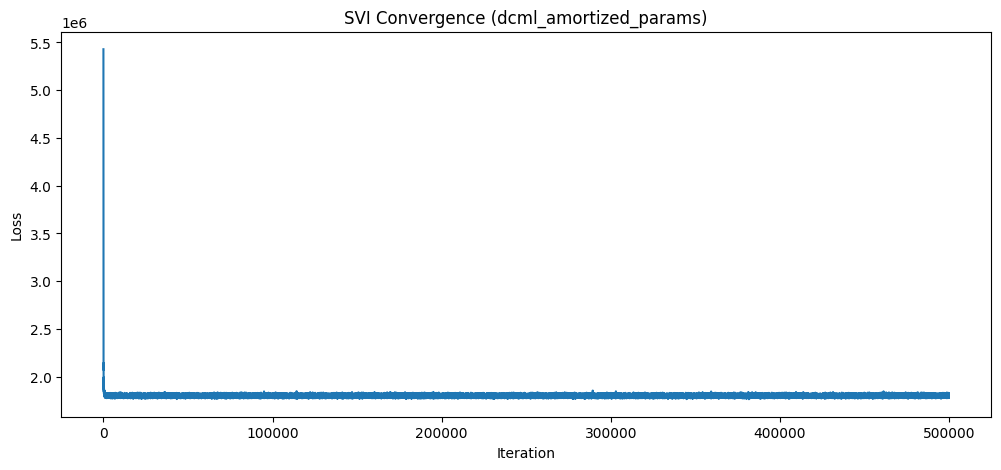

In [61]:
dcml_params, (alpha_h_history, alpha_phi_history) = infer_amortized_posteriors(npcs, len(dcml_chordtypes), dcml_obs,
                                                                              nsteps=500000, lr=0.1, plot_loss=True,
                                                                              save_as="dcml_amortized_params", collect_history=True
                                                                              )

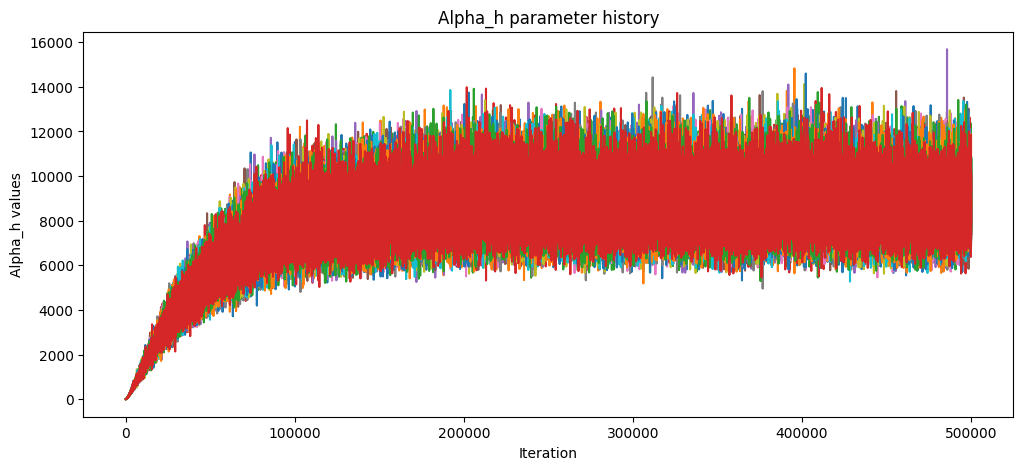

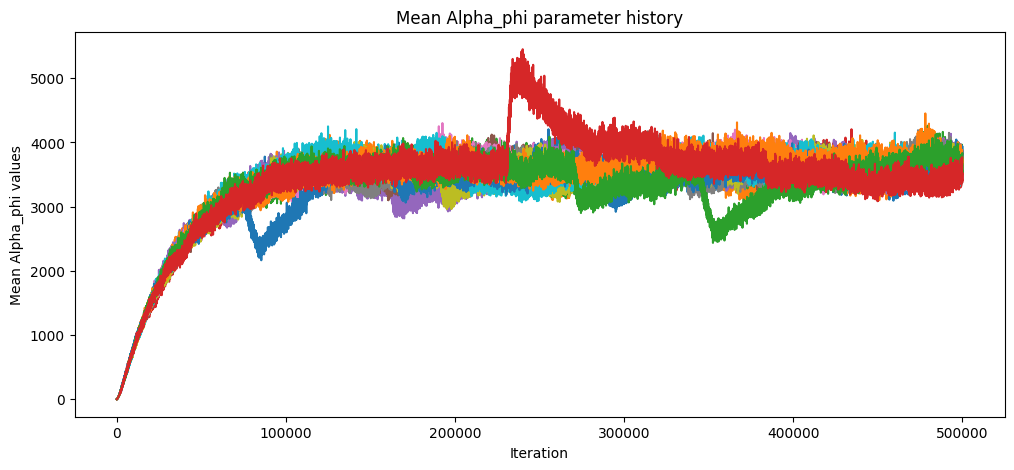

In [62]:
# Plot the parameter histories
plot_param_histories(alpha_h_history, alpha_phi_history)

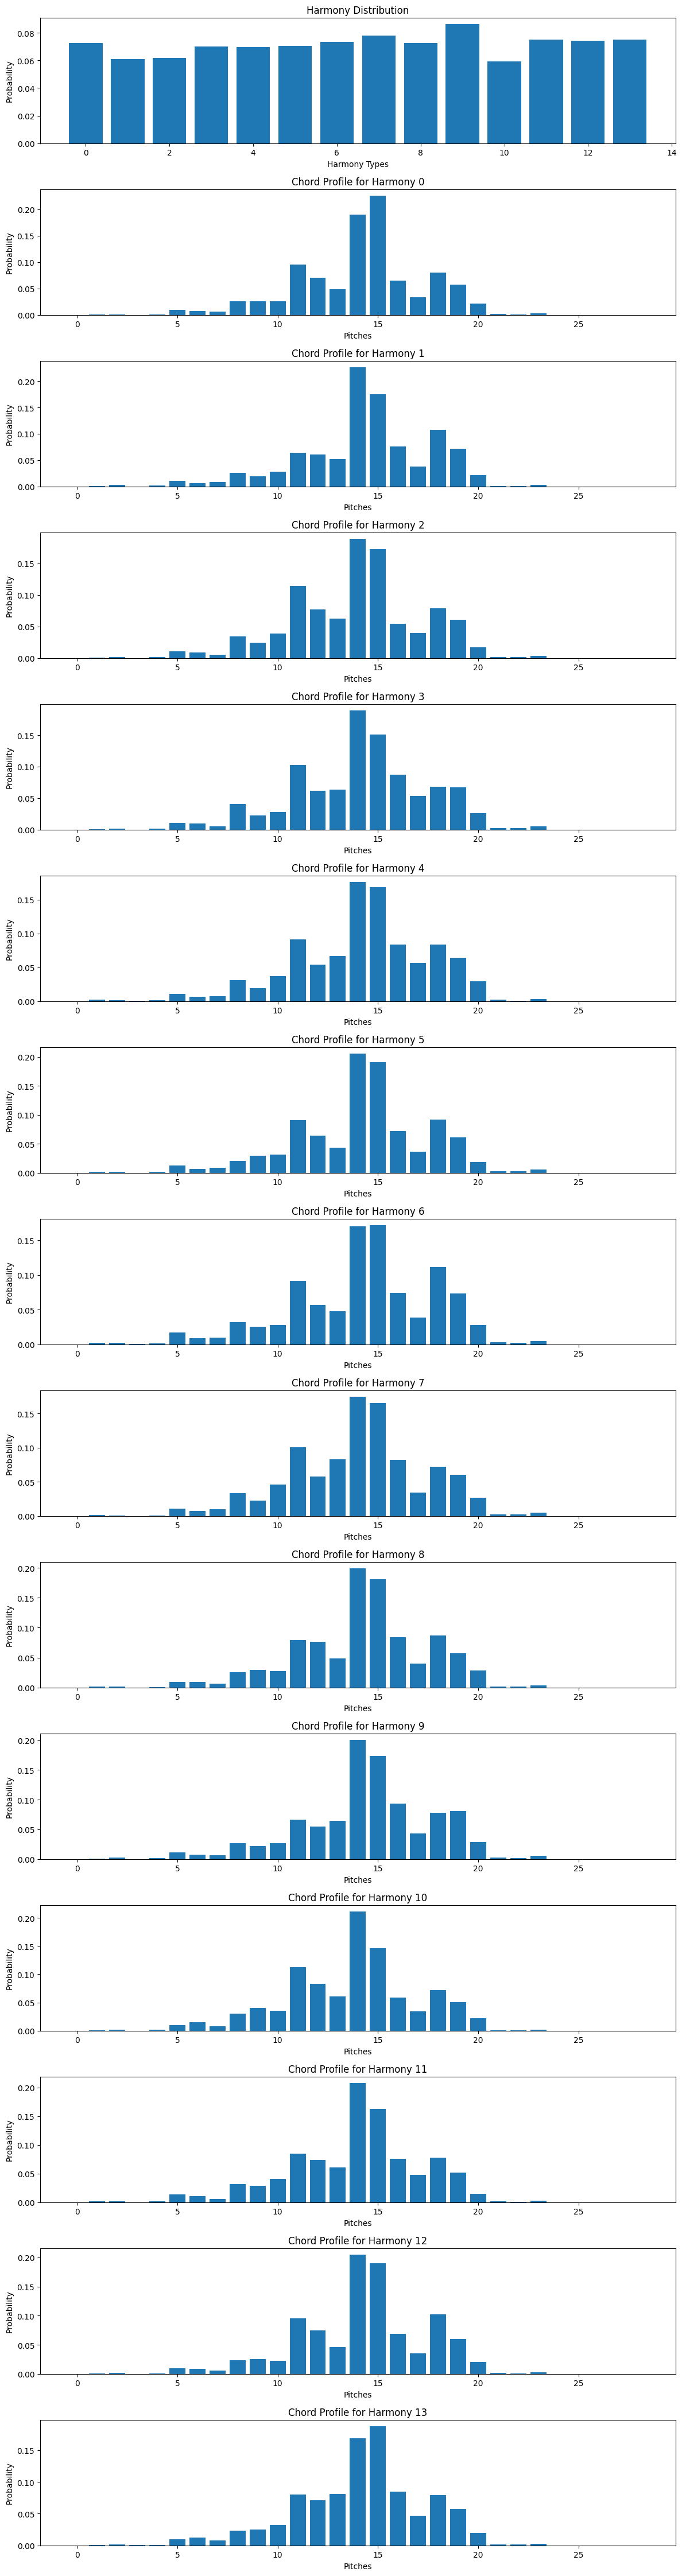

In [63]:
plot_amortized_inference_results(dcml_params, len(dcml_chordtypes), npcs, save_as="dcml_amortized_params")